In [1]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
cd drive/MyDrive/Colab\ Notebooks/scripts

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/scripts'
/Users/paolo/Documents/Droughts/Veronica/notebooks/NonLinCFA


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
import os
from collections import Counter

In [2]:
sys.path.append("/Users/paolo/Documents/Droughts/Veronica/scripts")
from feature_selection import forwardFeatureSelection

from NonLinCFA import NonLinCFA
from aux_GenLinCFA import prepare_target_binary

from aux_NonLinCFA import *
import random

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
import os
from collections import Counter
from imblearn.over_sampling import SMOTE

sys.path.append("/Users/paolo/Documents/Droughts/Veronica/scripts")

from NonLinCFA import NonLinCFA
from aux_NonLinCFA import *

# NonLinCFA aggregations standardized target



## Temp Prec

In [ ]:
basins = ['Emiliani1', 'Emiliani2', 'Garda_Mincio', 'Dora', 'Piemonte_Nord', 'Piemonte_Sud']

path_target = "./csv/"
path_features = './features_allvalues/'
destination_folder = './NonLinCFA/temp_prec_internal_ordering/dyn_eps_lin/' # eps = fixed_value/#basin_coord
plots_folder = './NonLinCFA/for_plots/internal_ordering/'

for basin in basins:
  print('####################' + basin + '####################')
  target_df_train, target_df_val, target_df_test, target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
      path=path_target+basin+'.csv', window_size = 1)
  eps = 0.1
  actual_path = path_features+basin+'_aggreg.csv'
  output, aggregate_trainVal, aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg',
                                                                            'cyclostationary_mean_tg_1w',
                                                                            'cyclostationary_mean_tg_4w',
                                                                            'cyclostationary_mean_tg_8w',
                                                                            'cyclostationary_mean_tg_12w',
                                                                            'cyclostationary_mean_tg_16w',
                                                                            'cyclostationary_mean_tg_24w',
                                                                            'cyclostationary_mean_rr',
                                                                            'cyclostationary_mean_rr_1w',
                                                                            'cyclostationary_mean_rr_4w',
                                                                            'cyclostationary_mean_rr_8w',
                                                                            'cyclostationary_mean_rr_12w',
                                                                            'cyclostationary_mean_rr_16w',
                                                                            'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                      target_df_trainVal, eps=eps,
                                                                      max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')

  #agg_trainVal_string = plots_folder + basin + "_trainVal_aggreg"
  #agg_test_string = plots_folder + basin + "_test_aggreg"
  #aggregate_trainVal.to_csv(agg_trainVal_string, index = False)
  #aggregate_test.to_csv(agg_test_string, index = False)

  selected_colnames = FS_with_linearWrapper(aggregate_trainVal, target_df_train, target_df_val, min(50,aggregate_trainVal.shape[1]-1), 228)

  print('\nFull model and selected features with wrapper\n')
  compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)

  print('\nFull model and best 5 selected features with wrapper\n')
  compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])

  train_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_train.csv'
  val_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_val.csv'
  test_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_test.csv'
  X_train_wrapper = aggregate_trainVal.loc[:410,selected_colnames[0:5]]
  X_validation_wrapper = aggregate_trainVal.loc[411:,selected_colnames[0:5]]
  X_train_validation_wrapper = pd.concat([X_train_wrapper, X_validation_wrapper])
  X_test_wrapper = aggregate_test.loc[:,selected_colnames[0:5]]
  X_train_wrapper.to_csv(train_string, index=False)
  X_validation_wrapper.to_csv(val_string, index=False)
  X_test_wrapper.to_csv(test_string, index=False)

  res = {
          "delta" : [],
          "numSelected" : [],
          "selectedFeatures" : []
      }

  res['selectedFeatures'] = forwardFeatureSelection(10,np.array(aggregate_trainVal),
                                                    np.array(target_df_trainVal.mean_std),res,10,1)

  selectedFeatures='selectedFeatures'
  print(f'\n{res[selectedFeatures]}\n')

  selected_colnames = aggregate_trainVal.columns[res['selectedFeatures']]

  print('\nFull model and selected features with CMI\n')
  compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)

  print('\nFull model and best 5 selected features with CMI\n')
  compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])

  train_string = destination_folder + basin + '_nonLinCFA_best5_CMI_train.csv'
  val_string = destination_folder + basin + '_nonLinCFA_best5_CMI_val.csv'
  test_string = destination_folder + basin + '_nonLinCFA_best5_CMI_test.csv'

  X_train_CMI5 = aggregate_trainVal.loc[:410,selected_colnames[0:5]]
  X_validation_CMI5 = aggregate_trainVal.loc[411:,selected_colnames[0:5]]
  X_train_validation_CMI5 = pd.concat([X_train_CMI5, X_validation_CMI5])
  X_test_CMI5 = aggregate_test.loc[:,selected_colnames[0:5]]

  selected_colnames_CMI5 = aggregate_trainVal.loc[:,selected_colnames[0:5]].columns.values

  X_train_CMI5.to_csv(train_string, index=False)
  X_validation_CMI5.to_csv(val_string, index=False)
  X_test_CMI5.to_csv(test_string, index=False)

  train_string = destination_folder + basin + '_nonLinCFA_CMI_train.csv'
  val_string = destination_folder + basin + '_nonLinCFA_CMI_val.csv'
  test_string = destination_folder + basin + '_nonLinCFA_CMI_test.csv'

  X_train_CMI = aggregate_trainVal.loc[:410,selected_colnames]
  X_validation_CMI = aggregate_trainVal.loc[411:,selected_colnames]
  X_train_validation_CMI = pd.concat([X_train_CMI, X_validation_CMI])
  X_test_CMI = aggregate_test.loc[:,selected_colnames]

  X_train_CMI.to_csv(train_string, index=False)
  X_validation_CMI.to_csv(val_string, index=False)
  X_test_CMI.to_csv(test_string, index=False)

  print('###### Regression ######')
  lin_regr = LinearRegression()

  # CMI
  lin_regr.fit(X_train_validation_CMI, target_df_trainVal.mean_std)
  print("Train R2 linear regression CMI: ", round(lin_regr.score(X_train_validation_CMI, target_df_trainVal.mean_std),3))
  print("Test R2 linear regression CMI: ", round(lin_regr.score(X_test_CMI, target_df_test.mean_std),3), "\n")

  # CMI best 5
  lin_regr.fit(X_train_validation_CMI5, target_df_trainVal.mean_std)
  print("Train R2 linear regression CMI best 5: ", round(lin_regr.score(X_train_validation_CMI5, target_df_trainVal.mean_std),3))
  print("Test R2 linear regression CMI best 5: ", round(lin_regr.score(X_test_CMI5, target_df_test.mean_std),3), "\n")

  # wrapper
  lin_regr.fit(X_train_validation_wrapper, target_df_trainVal.mean_std)
  print("Train R2 linear regression wrapper: ", round(lin_regr.score(X_train_validation_wrapper, target_df_trainVal.mean_std),3))
  print("Test R2 linear regression wrapper: ", round(lin_regr.score(X_test_wrapper, target_df_test.mean_std),3), "\n")

  print('###### Binary Classification ######')

  target_df_train = target_df_train.apply(lambda x: np.sign(x.mean_std), axis=1)
  target_df_val = target_df_val.apply(lambda x: np.sign(x.mean_std), axis=1)
  target_df_test = target_df_test.apply(lambda x: np.sign(x.mean_std), axis=1)
  target_df_trainVal = target_df_trainVal.apply(lambda x: np.sign(x.mean_std), axis=1)

  log_regr = LogisticRegression(solver='lbfgs', random_state = 42)

  # CMI
  log_regr.fit(X_train_validation_CMI, target_df_trainVal)
  print("Train accuracy logistic regression CMI: ", round(log_regr.score(X_train_validation_CMI, target_df_trainVal),3))
  print("Test accuracy logistic regression CMI: ", round(log_regr.score(X_test_CMI, target_df_test),3), "\n")

  # CMI best 5
  log_regr.fit(X_train_validation_CMI5, target_df_trainVal)
  print("Train accuracy logistic regression CMI best 5: ", round(log_regr.score(X_train_validation_CMI5, target_df_trainVal),3))
  print("Test accuracy logistic regression CMI best 5: ", round(log_regr.score(X_test_CMI5, target_df_test),3), "\n")

  # wrapper
  log_regr.fit(X_train_validation_wrapper, target_df_trainVal)
  print("Train accuracy logistic regression wrapper: ", round(log_regr.score(X_train_validation_wrapper, target_df_trainVal),3))
  print("Test accuracy logistic regression wrapper: ", round(log_regr.score(X_test_wrapper, target_df_test),3), "\n")

  output_string = plots_folder + basin + '_aggregations.npy'
  sel_col_string = plots_folder + basin + '_chosen_features.npy'
  np.save(sel_col_string, selected_colnames_CMI5)
  np.save(output_string, output)

####################Emiliani1####################
Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 7

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 5

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 2

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 6

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 9

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 7

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 2

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 18

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 17

Number of features: 172

eps value:  0.0005813953488372093
Number of aggregated features: 10

Number of feature

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


####################Emiliani2####################
Number of features: 130

eps value:  0.0007692307692307692
Number of aggregated features: 5

Number of features: 130

eps value:  0.0007692307692307692
Number of aggregated features: 3

Number of features: 130

eps value:  0.0007692307692307692
Number of aggregated features: 3

Number of features: 130

eps value:  0.0007692307692307692
Number of aggregated features: 3

Number of features: 130

eps value:  0.0007692307692307692
Number of aggregated features: 3

Number of features: 130

eps value:  0.0007692307692307692
Number of aggregated features: 4

Number of features: 130

eps value:  0.0007692307692307692
Number of aggregated features: 2

Number of features: 130

eps value:  0.0007692307692307692
Number of aggregated features: 4

Number of features: 130

eps value:  0.0007692307692307692
Number of aggregated features: 8

Number of features: 130

eps value:  0.0007692307692307692
Number of aggregated features: 7

Number of features: 

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


####################Garda_Mincio####################
Number of features: 67

eps value:  0.0014925373134328358
Number of aggregated features: 1

Number of features: 67

eps value:  0.0014925373134328358
Number of aggregated features: 3

Number of features: 67

eps value:  0.0014925373134328358
Number of aggregated features: 2

Number of features: 67

eps value:  0.0014925373134328358
Number of aggregated features: 2

Number of features: 67

eps value:  0.0014925373134328358
Number of aggregated features: 1

Number of features: 67

eps value:  0.0014925373134328358
Number of aggregated features: 1

Number of features: 67

eps value:  0.0014925373134328358
Number of aggregated features: 1

Number of features: 67

eps value:  0.0014925373134328358
Number of aggregated features: 4

Number of features: 67

eps value:  0.0014925373134328358
Number of aggregated features: 4

Number of features: 67

eps value:  0.0014925373134328358
Number of aggregated features: 4

Number of features: 67

eps

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


####################Dora####################
Number of features: 44

eps value:  0.002272727272727273
Number of aggregated features: 2

Number of features: 44

eps value:  0.002272727272727273
Number of aggregated features: 2

Number of features: 44

eps value:  0.002272727272727273
Number of aggregated features: 1

Number of features: 44

eps value:  0.002272727272727273
Number of aggregated features: 1

Number of features: 44

eps value:  0.002272727272727273
Number of aggregated features: 3

Number of features: 44

eps value:  0.002272727272727273
Number of aggregated features: 2

Number of features: 44

eps value:  0.002272727272727273
Number of aggregated features: 1

Number of features: 44

eps value:  0.002272727272727273
Number of aggregated features: 1

Number of features: 44

eps value:  0.002272727272727273
Number of aggregated features: 1

Number of features: 44

eps value:  0.002272727272727273
Number of aggregated features: 1

Number of features: 44

eps value:  0.0022727

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


####################Piemonte_Nord####################
Number of features: 89

eps value:  0.0011235955056179776
Number of aggregated features: 7

Number of features: 89

eps value:  0.0011235955056179776
Number of aggregated features: 5

Number of features: 89

eps value:  0.0011235955056179776
Number of aggregated features: 5

Number of features: 89

eps value:  0.0011235955056179776
Number of aggregated features: 5

Number of features: 89

eps value:  0.0011235955056179776
Number of aggregated features: 1

Number of features: 89

eps value:  0.0011235955056179776
Number of aggregated features: 1

Number of features: 89

eps value:  0.0011235955056179776
Number of aggregated features: 1

Number of features: 89

eps value:  0.0011235955056179776
Number of aggregated features: 2

Number of features: 89

eps value:  0.0011235955056179776
Number of aggregated features: 3

Number of features: 89

eps value:  0.0011235955056179776
Number of aggregated features: 4

Number of features: 89

ep

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


####################Piemonte_Sud####################
Number of features: 176

eps value:  0.0005681818181818183
Number of aggregated features: 2

Number of features: 176

eps value:  0.0005681818181818183
Number of aggregated features: 4

Number of features: 176

eps value:  0.0005681818181818183
Number of aggregated features: 2

Number of features: 176

eps value:  0.0005681818181818183
Number of aggregated features: 3

Number of features: 176

eps value:  0.0005681818181818183
Number of aggregated features: 3

Number of features: 176

eps value:  0.0005681818181818183
Number of aggregated features: 3

Number of features: 176

eps value:  0.0005681818181818183
Number of aggregated features: 2

Number of features: 176

eps value:  0.0005681818181818183
Number of aggregated features: 3

Number of features: 176

eps value:  0.0005681818181818183
Number of aggregated features: 7

Number of features: 176

eps value:  0.0005681818181818183
Number of aggregated features: 2

Number of feature

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
basins = ['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino']

path_target = "./csv/"
path_features = './features_allvalues/'
destination_folder = './NonLinCFA/temp_prec_internal_ordering/dyn_eps_lin/' # eps = fixed_value/#basin_coord
plots_folder = './NonLinCFA/for_plots/internal_ordering/'

for basin in basins:
  selected_colnames_CMI5 = []
  print('####################' + basin + '####################')
  target_df_train, target_df_val, target_df_test, target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
      path=path_target+basin+'.csv', window_size = 1)
  eps = 0.01
  actual_path = path_features+basin+'_aggreg.csv'
  output, aggregate_trainVal, aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg',
                                                                            'cyclostationary_mean_tg_1w',
                                                                            'cyclostationary_mean_tg_4w',
                                                                            'cyclostationary_mean_tg_8w',
                                                                            'cyclostationary_mean_tg_12w',
                                                                            'cyclostationary_mean_tg_16w',
                                                                            'cyclostationary_mean_tg_24w',
                                                                            'cyclostationary_mean_rr',
                                                                            'cyclostationary_mean_rr_1w',
                                                                            'cyclostationary_mean_rr_4w',
                                                                            'cyclostationary_mean_rr_8w',
                                                                            'cyclostationary_mean_rr_12w',
                                                                            'cyclostationary_mean_rr_16w',
                                                                            'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                      target_df_trainVal, eps=eps,
                                                                      max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')

  #agg_trainVal_string = plots_folder + basin + "_trainVal_aggreg"
  #agg_test_string = plots_folder + basin + "_test_aggreg"
  #aggregate_trainVal.to_csv(agg_trainVal_string, index = False)
  #aggregate_test.to_csv(agg_test_string, index = False)
  selected_colnames = FS_with_linearWrapper(aggregate_trainVal, target_df_train, target_df_val, min(50,aggregate_trainVal.shape[1]-1), 228)

  print('\nFull model and selected features with wrapper\n')
  compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)

  print('\nFull model and best 5 selected features with wrapper\n')
  compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])

  train_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_train.csv'
  val_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_val.csv'
  test_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_test.csv'
  X_train_wrapper = aggregate_trainVal.loc[:410,selected_colnames[0:5]]
  X_validation_wrapper = aggregate_trainVal.loc[411:,selected_colnames[0:5]]
  X_train_validation_wrapper = pd.concat([X_train_wrapper, X_validation_wrapper])
  X_test_wrapper = aggregate_test.loc[:,selected_colnames[0:5]]
  X_train_wrapper.to_csv(train_string, index=False)
  X_validation_wrapper.to_csv(val_string, index=False)
  X_test_wrapper.to_csv(test_string, index=False)

  res = {
          "delta" : [],
          "numSelected" : [],
          "selectedFeatures" : []
      }

  res['selectedFeatures'] = forwardFeatureSelection(10,np.array(aggregate_trainVal),
                                                    np.array(target_df_trainVal.mean_std),res,10,1)

  selectedFeatures='selectedFeatures'
  print(f'\n{res[selectedFeatures]}\n')

  selected_colnames = aggregate_trainVal.columns[res['selectedFeatures']]

  print('\nFull model and selected features with CMI\n')
  compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)

  print('\nFull model and best 5 selected features with CMI\n')
  compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])

  train_string = destination_folder + basin + '_nonLinCFA_best5_CMI_train.csv'
  val_string = destination_folder + basin + '_nonLinCFA_best5_CMI_val.csv'
  test_string = destination_folder + basin + '_nonLinCFA_best5_CMI_test.csv'

  X_train_CMI5 = aggregate_trainVal.loc[:410,selected_colnames[0:5]]
  X_validation_CMI5 = aggregate_trainVal.loc[411:,selected_colnames[0:5]]
  X_train_validation_CMI5 = pd.concat([X_train_CMI5, X_validation_CMI5])
  X_test_CMI5 = aggregate_test.loc[:,selected_colnames[0:5]]

  selected_colnames_CMI5.append(aggregate_trainVal.loc[:,selected_colnames[0:5]].columns.values)

  X_train_CMI5.to_csv(train_string, index=False)
  X_validation_CMI5.to_csv(val_string, index=False)
  X_test_CMI5.to_csv(test_string, index=False)

  train_string = destination_folder + basin + '_nonLinCFA_CMI_train.csv'
  val_string = destination_folder + basin + '_nonLinCFA_CMI_val.csv'
  test_string = destination_folder + basin + '_nonLinCFA_CMI_test.csv'

  X_train_CMI = aggregate_trainVal.loc[:410,selected_colnames]
  X_validation_CMI = aggregate_trainVal.loc[411:,selected_colnames]
  X_train_validation_CMI = pd.concat([X_train_CMI, X_validation_CMI])
  X_test_CMI = aggregate_test.loc[:,selected_colnames]

  X_train_CMI.to_csv(train_string, index=False)
  X_validation_CMI.to_csv(val_string, index=False)
  X_test_CMI.to_csv(test_string, index=False)

  print('###### Regression ######')
  lin_regr = LinearRegression()

  # CMI
  lin_regr.fit(X_train_validation_CMI, target_df_trainVal.mean_std)
  print("Train R2 linear regression CMI: ", round(lin_regr.score(X_train_validation_CMI, target_df_trainVal.mean_std),3))
  print("Test R2 linear regression CMI: ", round(lin_regr.score(X_test_CMI, target_df_test.mean_std),3), "\n")

  # CMI best 5
  lin_regr.fit(X_train_validation_CMI5, target_df_trainVal.mean_std)
  print("Train R2 linear regression CMI best 5: ", round(lin_regr.score(X_train_validation_CMI5, target_df_trainVal.mean_std),3))
  print("Test R2 linear regression CMI best 5: ", round(lin_regr.score(X_test_CMI5, target_df_test.mean_std),3), "\n")

  # wrapper
  lin_regr.fit(X_train_validation_wrapper, target_df_trainVal.mean_std)
  print("Train R2 linear regression wrapper: ", round(lin_regr.score(X_train_validation_wrapper, target_df_trainVal.mean_std),3))
  print("Test R2 linear regression wrapper: ", round(lin_regr.score(X_test_wrapper, target_df_test.mean_std),3), "\n")

  print('###### Binary Classification ######')

  target_df_train = target_df_train.apply(lambda x: np.sign(x.mean_std), axis=1)
  target_df_val = target_df_val.apply(lambda x: np.sign(x.mean_std), axis=1)
  target_df_test = target_df_test.apply(lambda x: np.sign(x.mean_std), axis=1)
  target_df_trainVal = target_df_trainVal.apply(lambda x: np.sign(x.mean_std), axis=1)

  log_regr = LogisticRegression(solver='lbfgs', random_state = 42)

  # CMI
  log_regr.fit(X_train_validation_CMI, target_df_trainVal)
  print("Train accuracy logistic regression CMI: ", round(log_regr.score(X_train_validation_CMI, target_df_trainVal),3))
  print("Test accuracy logistic regression CMI: ", round(log_regr.score(X_test_CMI, target_df_test),3), "\n")

  # CMI best 5
  log_regr.fit(X_train_validation_CMI5, target_df_trainVal)
  print("Train accuracy logistic regression CMI best 5: ", round(log_regr.score(X_train_validation_CMI5, target_df_trainVal),3))
  print("Test accuracy logistic regression CMI best 5: ", round(log_regr.score(X_test_CMI5, target_df_test),3), "\n")

  # wrapper
  log_regr.fit(X_train_validation_wrapper, target_df_trainVal)
  print("Train accuracy logistic regression wrapper: ", round(log_regr.score(X_train_validation_wrapper, target_df_trainVal),3))
  print("Test accuracy logistic regression wrapper: ", round(log_regr.score(X_test_wrapper, target_df_test),3), "\n")

  output_string = plots_folder + basin + '_aggregations.npy'
  sel_col_string = plots_folder + basin + '_chosen_features.npy'
  np.save(sel_col_string, selected_colnames_CMI5)
  np.save(output_string, output)

####################Adda####################
Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 4

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 5

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 4

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 1

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 3

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 1

Number of features: 92

e

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


####################Lambro_Olona####################
Number of features: 55

eps value:  0.00018181818181818183
Number of aggregated features: 6

Number of features: 55

eps value:  0.00018181818181818183
Number of aggregated features: 6

Number of features: 55

eps value:  0.00018181818181818183
Number of aggregated features: 5

Number of features: 55

eps value:  0.00018181818181818183
Number of aggregated features: 4

Number of features: 55

eps value:  0.00018181818181818183
Number of aggregated features: 3

Number of features: 55

eps value:  0.00018181818181818183
Number of aggregated features: 3

Number of features: 55

eps value:  0.00018181818181818183
Number of aggregated features: 2

Number of features: 55

eps value:  0.00018181818181818183
Number of aggregated features: 4

Number of features: 55

eps value:  0.00018181818181818183
Number of aggregated features: 2

Number of features: 55

eps value:  0.00018181818181818183
Number of aggregated features: 2

Number of feature

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


####################Oglio_Iseo####################
Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 3

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 2

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 1

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 1

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 1

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 1

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 1

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 3

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 2

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 1

Number of features:

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


####################Ticino####################
Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 3

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 4

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 5

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 3

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 3

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 1

Number of features: 92


/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [26]:
basins = ['Emiliani1']

path_target = "/Users/paolo/Documents/Droughts/Veronica/VHI_target/"
path_features = '/Users/paolo/Documents/Droughts/Veronica/final_features_allcoord/temp_prec/'
plots_folder = './NonLinCFA/for_plots/internal_ordering/'

for basin in basins:
    selected_colnames_CMI5 = []
    print('####################' + basin + '####################')
    target_df_train, target_df_val, target_df_test, target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
        path=path_target+basin+'.csv', window_size = 1)
    eps = 0.01
    actual_path = path_features+basin+'_aggreg.csv'
    output, aggregate_trainVal, aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg',
                                                                            'cyclostationary_mean_tg_1w',
                                                                            'cyclostationary_mean_tg_4w',
                                                                            'cyclostationary_mean_tg_8w',
                                                                            'cyclostationary_mean_tg_12w',
                                                                            'cyclostationary_mean_tg_16w',
                                                                            'cyclostationary_mean_tg_24w',
                                                                            'cyclostationary_mean_rr',
                                                                            'cyclostationary_mean_rr_1w',
                                                                            'cyclostationary_mean_rr_4w',
                                                                            'cyclostationary_mean_rr_8w',
                                                                            'cyclostationary_mean_rr_12w',
                                                                            'cyclostationary_mean_rr_16w',
                                                                            'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                      target_df_trainVal, eps=eps,
                                                                      max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')

    #agg_trainVal_string = plots_folder + basin + "_trainVal_aggreg"
    #agg_test_string = plots_folder + basin + "_test_aggreg"
    #aggregate_trainVal.to_csv(agg_trainVal_string, index = False)
    #aggregate_test.to_csv(agg_test_string, index = False)
    #selected_colnames = FS_with_linearWrapper(aggregate_trainVal, target_df_train, target_df_val, min(50,aggregate_trainVal.shape[1]-1), 228)
    #print('\nFull model and selected features with wrapper\n')
    #compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)
    #print('\nFull model and best 5 selected features with wrapper\n')
    #compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])
    #train_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_train.csv'
    #val_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_val.csv'
    #test_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_test.csv'
    #X_train_wrapper = aggregate_trainVal.loc[:410,selected_colnames[0:5]]
    #X_validation_wrapper = aggregate_trainVal.loc[411:,selected_colnames[0:5]]
    #X_train_validation_wrapper = pd.concat([X_train_wrapper, X_validation_wrapper])
    #X_test_wrapper = aggregate_test.loc[:,selected_colnames[0:5]]
    #X_train_wrapper.to_csv(train_string, index=False)
    #X_validation_wrapper.to_csv(val_string, index=False)
    #X_test_wrapper.to_csv(test_string, index=False)
    res = {
            "delta" : [],
            "numSelected" : [],
            "selectedFeatures" : []
        }
    res['selectedFeatures'] = forwardFeatureSelection(10,np.array(aggregate_trainVal),
                                                    np.array(target_df_trainVal.mean_std),res,10,1)

    selectedFeatures='selectedFeatures'
    print(f'\n{res[selectedFeatures]}\n')

    selected_colnames = aggregate_trainVal.columns[res['selectedFeatures']]

    print('\nFull model and selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)

    print('\nFull model and best 5 selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])

    #train_string = destination_folder + basin + '_nonLinCFA_best5_CMI_train.csv'
    #val_string = destination_folder + basin + '_nonLinCFA_best5_CMI_val.csv'
    #test_string = destination_folder + basin + '_nonLinCFA_best5_CMI_test.csv'

    X_train_CMI5 = aggregate_trainVal.loc[:410,selected_colnames[0:5]]
    X_validation_CMI5 = aggregate_trainVal.loc[411:,selected_colnames[0:5]]
    X_train_validation_CMI5 = pd.concat([X_train_CMI5, X_validation_CMI5])
    X_test_CMI5 = aggregate_test.loc[:,selected_colnames[0:5]]

    selected_colnames_CMI5.append(aggregate_trainVal.loc[:,selected_colnames[0:5]].columns.values)

    #X_train_CMI5.to_csv(train_string, index=False)
    #X_validation_CMI5.to_csv(val_string, index=False)
    #X_test_CMI5.to_csv(test_string, index=False)
#
    #train_string = destination_folder + basin + '_nonLinCFA_CMI_train.csv'
    #val_string = destination_folder + basin + '_nonLinCFA_CMI_val.csv'
    #test_string = destination_folder + basin + '_nonLinCFA_CMI_test.csv'
#
    #X_train_CMI = aggregate_trainVal.loc[:410,selected_colnames]
    #X_validation_CMI = aggregate_trainVal.loc[411:,selected_colnames]
    #X_train_validation_CMI = pd.concat([X_train_CMI, X_validation_CMI])
    #X_test_CMI = aggregate_test.loc[:,selected_colnames]
#
    #X_train_CMI.to_csv(train_string, index=False)
    #X_validation_CMI.to_csv(val_string, index=False)
    #X_test_CMI.to_csv(test_string, index=False)
#
    #print('###### Regression ######')
    #lin_regr = LinearRegression()
#
    ## CMI
    #lin_regr.fit(X_train_validation_CMI, target_df_trainVal.mean_std)
    #print("Train R2 linear regression CMI: ", round(lin_regr.score(X_train_validation_CMI, target_df_trainVal.mean_std),3))
    #print("Test R2 linear regression CMI: ", round(lin_regr.score(X_test_CMI, target_df_test.mean_std),3), "\n")
#
    ## CMI best 5
    #lin_regr.fit(X_train_validation_CMI5, target_df_trainVal.mean_std)
    #print("Train R2 linear regression CMI best 5: ", round(lin_regr.score(X_train_validation_CMI5, target_df_trainVal.mean_std),3))
    #print("Test R2 linear regression CMI best 5: ", round(lin_regr.score(X_test_CMI5, target_df_test.mean_std),3), "\n")
#
    ## wrapper
    #lin_regr.fit(X_train_validation_wrapper, target_df_trainVal.mean_std)
    #print("Train R2 linear regression wrapper: ", round(lin_regr.score(X_train_validation_wrapper, target_df_trainVal.mean_std),3))
    #print("Test R2 linear regression wrapper: ", round(lin_regr.score(X_test_wrapper, target_df_test.mean_std),3), "\n")
#
    #print('###### Binary Classification ######')
#
    #target_df_train = target_df_train.apply(lambda x: np.sign(x.mean_std), axis=1)
    #target_df_val = target_df_val.apply(lambda x: np.sign(x.mean_std), axis=1)
    #target_df_test = target_df_test.apply(lambda x: np.sign(x.mean_std), axis=1)
    #target_df_trainVal = target_df_trainVal.apply(lambda x: np.sign(x.mean_std), axis=1)
#
    #log_regr = LogisticRegression(solver='lbfgs', random_state = 42)
#
    ## CMI
    #log_regr.fit(X_train_validation_CMI, target_df_trainVal)
    #print("Train accuracy logistic regression CMI: ", round(log_regr.score(X_train_validation_CMI, target_df_trainVal),3))
    #print("Test accuracy logistic regression CMI: ", round(log_regr.score(X_test_CMI, target_df_test),3), "\n")
#
    ## CMI best 5
    #log_regr.fit(X_train_validation_CMI5, target_df_trainVal)
    #print("Train accuracy logistic regression CMI best 5: ", round(log_regr.score(X_train_validation_CMI5, target_df_trainVal),3))
    #print("Test accuracy logistic regression CMI best 5: ", round(log_regr.score(X_test_CMI5, target_df_test),3), "\n")
#
    ## wrapper
    #log_regr.fit(X_train_validation_wrapper, target_df_trainVal)
    #print("Train accuracy logistic regression wrapper: ", round(log_regr.score(X_train_validation_wrapper, target_df_trainVal),3))
    #print("Test accuracy logistic regression wrapper: ", round(log_regr.score(X_test_wrapper, target_df_test),3), "\n")
#
    #output_string = plots_folder + basin + '_aggregations.npy'
    #sel_col_string = plots_folder + basin + '_chosen_features.npy'
    #np.save(sel_col_string, selected_colnames_CMI5)
    #np.save(output_string, output)

####################Emiliani1####################
Number of features: 172

eps value:  5.8139534883720933e-05
Number of aggregated features: 7

Number of features: 172

eps value:  5.8139534883720933e-05
Number of aggregated features: 5

Number of features: 172

eps value:  5.8139534883720933e-05
Number of aggregated features: 3

Number of features: 172

eps value:  5.8139534883720933e-05
Number of aggregated features: 6

Number of features: 172

eps value:  5.8139534883720933e-05
Number of aggregated features: 10

Number of features: 172

eps value:  5.8139534883720933e-05
Number of aggregated features: 6

Number of features: 172

eps value:  5.8139534883720933e-05
Number of aggregated features: 4

Number of features: 172

eps value:  5.8139534883720933e-05
Number of aggregated features: 19

Number of features: 172

eps value:  5.8139534883720933e-05
Number of aggregated features: 17

Number of features: 172

eps value:  5.8139534883720933e-05
Number of aggregated features: 12

Number

CMI: 0.002415654790346611
CMI: 0.00984690962192375
CMI: 7.02969514455587e-05
CMI: 0.0034685564054879325
CMI: 0.023795469981194695
CMI: 0.0020631097037442925
CMI: 0.002915343270287085
CMI: 0.001559929475623334
CMI: 0.004566021274293897
CMI: 0.0074970881505499465
CMI: 0.001218504233976736
CMI: 0.010199777475952854
Highest CMI score: 0.023795469981194695
Adding original feature: 76
CMI: 0.0029397673291444715
CMI: 0.0025313971652076717
CMI: 0.0025696353707307384
CMI: 0.002433981665234952
Highest CMI score: 0.0029397673291444715
Adding original feature: 107
Highest CMI score: -0.004743392162028515

[84, 98, 6, 76, 107]


Full model and selected features with CMI

Full aggregate regression train score: 0.5856503695626463, test score: -0.6701229451054223
Aggregate regression train score with FS: 0.3284145915917833, test score: 0.2051401959534308

Full model and best 5 selected features with CMI

Full aggregate regression train score: 0.5856503695626463, test score: -0.6701229451054223
Aggrega

In [27]:
aggregate_trainVal

cyclostationary_mean_tg_0  cyclostationary_mean_tg_1  \
0                     0.678217                   1.315608   
1                     1.735302                   2.500199   
2                    -0.348507                   0.287614   
3                     1.288997                   1.591342   
4                     0.042118                   0.697108   
..                         ...                        ...   
634                   0.824033                   1.037262   
635                   1.265662                   1.109661   
636                   1.315621                   1.414047   
637                   1.329681                   0.936588   
638                   1.104837                   0.664199   

     cyclostationary_mean_tg_2  cyclostationary_mean_tg_3  \
0                     0.711885                   0.632706   
1                     1.922795                   2.181168   
2                    -0.190270                  -0.445633   
3                     1.713321                   1.286234   
4                     0.121987                   0.143018   
..                         ...                        ...   
634                   0.509861                   0.758586   
635                   1.156873                   0.865144   
636                   0.432583                   0.950627   
637                   0.914817                   0.891653   
638                   1.813271                   0.459134   

     cyclostationary_mean_tg_4  cyclostationary_mean_tg_5  \
0                     0.578387                   1.425364   
1                     1.948730                   2.336793   
2                    -0.278291                   0.436508   
3                     1.667032                   1.356529   
4                     0.018097                   0.600927   
..                         ...                        ...   
634                   0.633866                   0.941183   
635                   1.196341                   1.394801   
636                   0.210081                   1.450298   
637                   1.046781                   1.413585   
638                   1.690610                   0.378536   

     cyclostationary_mean_tg_6  cyclostationary_mean_tg_1w_0  \
0                     0.567008                      0.783154   
1                     2.626455                      1.408795   
2                     1.350590                      0.812962   
3                     3.815838                      0.571191   
4                     1.849207                      0.802813   
..                         ...                           ...   
634                   0.924489                      1.880913   
635                   1.064577                      1.244617   
636                   0.892093                      1.551576   
637                   1.384931                      1.593077   
638                   1.554395                      1.491428   

     cyclostationary_mean_tg_1w_1  cyclostationary_mean_tg_1w_2  ...  \
0                        0.411582                      0.845648  ...   
1                        1.094695                      1.565193  ...   
2                        0.010546                      1.029116  ...   
3                       -0.013728                      0.904633  ...   
4                        0.412380                      1.090174  ...   
..                            ...                           ...  ...   
634                      1.239880                      1.151383  ...   
635                      1.473693                      0.990020  ...   
636                      1.306075                      0.944152  ...   
637                      0.832214                      0.800292  ...   
638                      1.722203                      1.620566  ...   

     cyclostationary_mean_rr_16w_0  cyclostationary_mean_rr_16w_1  \
0                         3.205079                       3.238168   
1                         2.117249

In [31]:
df_target = pd.read_csv("/Users/paolo/Documents/thesis_teo/thesis-master/data/VHI_target/Emiliani1_train.csv")
aggregate_trainVal["target"] = df_target.mean_std
aggregate_trainVal

cyclostationary_mean_tg_0  cyclostationary_mean_tg_1  \
0                     0.678217                   1.315608   
1                     1.735302                   2.500199   
2                    -0.348507                   0.287614   
3                     1.288997                   1.591342   
4                     0.042118                   0.697108   
..                         ...                        ...   
634                   0.824033                   1.037262   
635                   1.265662                   1.109661   
636                   1.315621                   1.414047   
637                   1.329681                   0.936588   
638                   1.104837                   0.664199   

     cyclostationary_mean_tg_2  cyclostationary_mean_tg_3  \
0                     0.711885                   0.632706   
1                     1.922795                   2.181168   
2                    -0.190270                  -0.445633   
3                     1.713321                   1.286234   
4                     0.121987                   0.143018   
..                         ...                        ...   
634                   0.509861                   0.758586   
635                   1.156873                   0.865144   
636                   0.432583                   0.950627   
637                   0.914817                   0.891653   
638                   1.813271                   0.459134   

     cyclostationary_mean_tg_4  cyclostationary_mean_tg_5  \
0                     0.578387                   1.425364   
1                     1.948730                   2.336793   
2                    -0.278291                   0.436508   
3                     1.667032                   1.356529   
4                     0.018097                   0.600927   
..                         ...                        ...   
634                   0.633866                   0.941183   
635                   1.196341                   1.394801   
636                   0.210081                   1.450298   
637                   1.046781                   1.413585   
638                   1.690610                   0.378536   

     cyclostationary_mean_tg_6  cyclostationary_mean_tg_1w_0  \
0                     0.567008                      0.783154   
1                     2.626455                      1.408795   
2                     1.350590                      0.812962   
3                     3.815838                      0.571191   
4                     1.849207                      0.802813   
..                         ...                           ...   
634                   0.924489                      1.880913   
635                   1.064577                      1.244617   
636                   0.892093                      1.551576   
637                   1.384931                      1.593077   
638                   1.554395                      1.491428   

     cyclostationary_mean_tg_1w_1  cyclostationary_mean_tg_1w_2  ...  \
0                        0.411582                      0.845648  ...   
1                        1.094695                      1.565193  ...   
2                        0.010546                      1.029116  ...   
3                       -0.013728                      0.904633  ...   
4                        0.412380                      1.090174  ...   
..                            ...                           ...  ...   
634                      1.239880                      1.151383  ...   
635                      1.473693                      0.990020  ...   
636                      1.306075                      0.944152  ...   
637                      0.832214                      0.800292  ...   
638                      1.722203                      1.620566  ...   

     cyclostationary_mean_rr_16w_1  cyclostationary_mean_rr_16w_2  \
0                         3.238168                       0.869160   
1                         2.357825

In [33]:
df_target_test = pd.read_csv("/Users/paolo/Documents/thesis_teo/thesis-master/data/VHI_target/Emiliani1_test.csv")
aggregate_test["target"] = df_target_test.mean_std
aggregate_test


cyclostationary_mean_tg_0  cyclostationary_mean_tg_1  \
0                    -0.943170                  -0.865406   
1                     1.008992                   0.254958   
2                     1.713287                   1.674020   
3                     0.621095                   0.794853   
4                    -0.484844                  -0.357424   
..                         ...                        ...   
223                   0.541911                   0.196887   
224                   1.483742                   1.613225   
225                   0.544086                   0.403498   
226                   0.202232                   0.352997   
227                   3.000894                   3.164709   

     cyclostationary_mean_tg_2  cyclostationary_mean_tg_3  \
0                    -1.689501                  -1.060595   
1                     1.332931                   0.745078   
2                     1.450377                   2.225885   
3                    -0.089426                   0.607363   
4                    -1.009374                  -0.392089   
..                         ...                        ...   
223                   0.002698                   0.449026   
224                   1.015741                   1.553284   
225                   0.531805                   0.139960   
226                  -0.398731                   0.337971   
227                   2.318211                   3.103333   

     cyclostationary_mean_tg_4  cyclostationary_mean_tg_5  \
0                    -1.624542                  -0.514683   
1                     1.393102                   0.979458   
2                     1.308874                   1.958810   
3                    -0.240068                   1.405112   
4                    -1.184430                   0.030402   
..                         ...                        ...   
223                   0.148712                   0.081134   
224                   1.084560                   1.425045   
225                   0.539628                  -0.055782   
226                  -0.278023                   0.285667   
227                   2.239820                   3.281056   

     cyclostationary_mean_tg_6  cyclostationary_mean_tg_1w_0  \
0                    -0.765494                      0.111799   
1                     1.637262                      0.032680   
2                     1.449783                      1.614471   
3                     0.006874                      1.373595   
4                    -0.900298                      0.063431   
..                         ...                           ...   
223                   0.520464                      0.174362   
224                   1.171182                      1.223728   
225                   0.847116                      1.221214   
226                  -0.037979                      0.446892   
227                   2.135008                      1.907559   

     cyclostationary_mean_tg_1w_1  cyclostationary_mean_tg_1w_2  ...  \
0                        0.361451                      0.073153  ...   
1                        0.040138                     -0.212152  ...   
2                        1.244780                      1.653515  ...   
3                        0.191545                      0.808332  ...   
4                       -1.129515                     -0.653227  ...   
..                            ...                           ...  ...   
223                     -0.610150                     -0.253378  ...   
224                      0.292876                      0.604819  ...   
225                      0.789071                      0.919178  ...   
226                      0.059949                      0.078692  ...   
227                      0.647883                      1.140226  ...   

     cyclostationary_mean_rr_16w_1  cyclostationary_mean_rr_16w_2  \
0                        -0.118974                       0.147432   
1                        -0.172034

In [34]:
aggregate_trainVal.to_csv("/Users/paolo/Downloads/Emiliani1_train_ext.csv")
aggregate_test.to_csv("/Users/paolo/Downloads/Emiliani1_test_ext.csv")


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tefs import TEFS
%config InlineBackend.figure_format = 'retina'

from tefs.metrics import regression_analysis
from sklearn.model_selection import TimeSeriesSplit

#aggregate_trainVal = pd.read_csv("/Users/paolo/Downloads/Ticino_train_ext.csv")
#aggregate_test = pd.read_csv("/Users/paolo/Downloads/Ticino_test_ext.csv")
aggregate_trainVal = pd.read_csv("/Users/paolo/Downloads/Emiliani1_train_ext.csv")
aggregate_test = pd.read_csv("/Users/paolo/Downloads/Emiliani1_test_ext.csv")

data = aggregate_trainVal
data_test = aggregate_test
n_train = data.shape[0]
n_test = data_test.shape[0]

target_name = "target"
features = data.drop(columns=[target_name])
target = data[target_name]
features_names = list(features.columns)

k = n_train // 10 # Set k using the rule of thumb
direction = 'forward' # or 'backward'
lag_features = [0,1]
lag_target = [1]

fs = TEFS(
    features=features.values,
    target=target.values,
    k=k,
    lag_features=lag_features,
    lag_target=lag_target,
    direction=direction,
    verbose=2,
    var_names=features_names,
    n_jobs=4,
)

fs.fit()

num_total_features = features.shape[1]
scores = []
scores_cv = []
unified_df = pd.concat([data, data_test], axis=0).reset_index(drop=True)
n_samples = unified_df.shape[0]
n_splits = 5
# Fixed-size rolling window
cv_scheme = TimeSeriesSplit(
    n_splits=n_splits,
    max_train_size=n_samples // (n_splits + 1),
)

for n_features in range(0, num_total_features+1):

    selected_features = fs.select_n_features(n=n_features)
    inputs_names_lags = {feature: lag_features for feature in selected_features}
    inputs_names_lags[target_name] = lag_target

    # Train-test scores
    scores.append(regression_analysis(
        inputs_names_lags=inputs_names_lags,
        target_name=target_name,
        df_train=data,
        df_test=data_test,
    ))

    # Cross-validation scores
    scores_cv.append(regression_analysis(
        inputs_names_lags=inputs_names_lags,
        target_name=target_name,
        df=unified_df,
        cv_scheme=cv_scheme,
    ))

scores = np.array(scores)
scores_cv = np.array(scores_cv)

Iteration 1
Candidate Features: ['Unnamed: 0', 'cyclostationary_mean_tg_0', 'cyclostationary_mean_tg_1', 'cyclostationary_mean_tg_2', 'cyclostationary_mean_tg_3', 'cyclostationary_mean_tg_4', 'cyclostationary_mean_tg_5', 'cyclostationary_mean_tg_6', 'cyclostationary_mean_tg_1w_0', 'cyclostationary_mean_tg_1w_1', 'cyclostationary_mean_tg_1w_2', 'cyclostationary_mean_tg_1w_3', 'cyclostationary_mean_tg_1w_4', 'cyclostationary_mean_tg_4w_0', 'cyclostationary_mean_tg_4w_1', 'cyclostationary_mean_tg_4w_2', 'cyclostationary_mean_tg_8w_0', 'cyclostationary_mean_tg_8w_1', 'cyclostationary_mean_tg_8w_2', 'cyclostationary_mean_tg_8w_3', 'cyclostationary_mean_tg_8w_4', 'cyclostationary_mean_tg_8w_5', 'cyclostationary_mean_tg_12w_0', 'cyclostationary_mean_tg_12w_1', 'cyclostationary_mean_tg_12w_2', 'cyclostationary_mean_tg_12w_3', 'cyclostationary_mean_tg_12w_4', 'cyclostationary_mean_tg_12w_5', 'cyclostationary_mean_tg_12w_6', 'cyclostationary_mean_tg_12w_7', 'cyclostationary_mean_tg_12w_8', 'cycl

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.2208850748394159
TE score of feature cyclostationary_mean_tg_0: -0.04426939764511295
TE score of feature cyclostationary_mean_tg_1: -0.059876244823468566
TE score of feature cyclostationary_mean_tg_2: -0.05450458426349758
TE score of feature cyclostationary_mean_tg_3: -0.05636663241946499
TE score of feature cyclostationary_mean_tg_4: -0.05104262337998061
TE score of feature cyclostationary_mean_tg_5: -0.056395966158466954
TE score of feature cyclostationary_mean_tg_6: -0.03576321202412985
TE score of feature cyclostationary_mean_tg_1w_0: -0.058820733159150845
TE score of feature cyclostationary_mean_tg_1w_1: -0.056420219013369854
TE score of feature cyclostationary_mean_tg_1w_2: -0.06304453153017225
TE score of feature cyclostationary_mean_tg_1w_3: -0.06186833655869414
TE score of feature cyclostationary_mean_tg_1w_4: -0.055796279324221765
TE score of feature cyclostationary_mean_tg_4w_0: -0.0551738087388437
TE score of feature cyclos

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.20557032404347936
TE score of feature cyclostationary_mean_tg_0: -0.040611081945119254
TE score of feature cyclostationary_mean_tg_1: -0.0567696468988549
TE score of feature cyclostationary_mean_tg_2: -0.04876307148051706
TE score of feature cyclostationary_mean_tg_3: -0.05127305150810996
TE score of feature cyclostationary_mean_tg_4: -0.04701069425558907
TE score of feature cyclostationary_mean_tg_5: -0.04931299742666992
TE score of feature cyclostationary_mean_tg_6: -0.030693974310733896
TE score of feature cyclostationary_mean_tg_1w_0: -0.0507830132424526
TE score of feature cyclostationary_mean_tg_1w_1: -0.048117030166593106
TE score of feature cyclostationary_mean_tg_1w_2: -0.054127531025484246
TE score of feature cyclostationary_mean_tg_1w_3: -0.054196272680400975
TE score of feature cyclostationary_mean_tg_1w_4: -0.04819187623189275
TE score of feature cyclostationary_mean_tg_4w_0: -0.05318071320716114
TE score of feature cyclos

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.19746021346667347
TE score of feature cyclostationary_mean_tg_0: -0.036476246182644806
TE score of feature cyclostationary_mean_tg_1: -0.05192468878865995
TE score of feature cyclostationary_mean_tg_2: -0.04697108222170754
TE score of feature cyclostationary_mean_tg_3: -0.04705934697840486
TE score of feature cyclostationary_mean_tg_4: -0.04456847659783031
TE score of feature cyclostationary_mean_tg_5: -0.04377325085173703
TE score of feature cyclostationary_mean_tg_6: -0.02887745489340468
TE score of feature cyclostationary_mean_tg_1w_0: -0.04703798804065534
TE score of feature cyclostationary_mean_tg_1w_1: -0.04459959026731153
TE score of feature cyclostationary_mean_tg_1w_2: -0.05149130049345162
TE score of feature cyclostationary_mean_tg_1w_3: -0.05060194199902339
TE score of feature cyclostationary_mean_tg_1w_4: -0.04482496630559983
TE score of feature cyclostationary_mean_tg_4w_0: -0.04911917146449063
TE score of feature cyclosta

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.1892673719414149
TE score of feature cyclostationary_mean_tg_0: -0.03185569957348752
TE score of feature cyclostationary_mean_tg_1: -0.04680236964299654
TE score of feature cyclostationary_mean_tg_2: -0.04196637757110161
TE score of feature cyclostationary_mean_tg_3: -0.0414860507378869
TE score of feature cyclostationary_mean_tg_4: -0.04015625083496874
TE score of feature cyclostationary_mean_tg_5: -0.03899237258514025
TE score of feature cyclostationary_mean_tg_6: -0.02574937673146302
TE score of feature cyclostationary_mean_tg_1w_0: -0.04274952840081474
TE score of feature cyclostationary_mean_tg_1w_1: -0.040191510217967866
TE score of feature cyclostationary_mean_tg_1w_2: -0.04743712563018167
TE score of feature cyclostationary_mean_tg_1w_3: -0.0439515310001357
TE score of feature cyclostationary_mean_tg_1w_4: -0.04201562404696271
TE score of feature cyclostationary_mean_tg_4w_0: -0.04475344533762372
TE score of feature cyclostatio

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.1828064836987367
TE score of feature cyclostationary_mean_tg_0: -0.0286826430572181
TE score of feature cyclostationary_mean_tg_1: -0.043168281985463186
TE score of feature cyclostationary_mean_tg_2: -0.03944870832132866
TE score of feature cyclostationary_mean_tg_3: -0.0390441184113698
TE score of feature cyclostationary_mean_tg_4: -0.037910066177156754
TE score of feature cyclostationary_mean_tg_5: -0.03676246507295171
TE score of feature cyclostationary_mean_tg_6: -0.023622816244692035
TE score of feature cyclostationary_mean_tg_1w_0: -0.03919913108690769
TE score of feature cyclostationary_mean_tg_1w_1: -0.03693808126468692
TE score of feature cyclostationary_mean_tg_1w_2: -0.04405005383650888
TE score of feature cyclostationary_mean_tg_1w_3: -0.04048682604204906
TE score of feature cyclostationary_mean_tg_1w_4: -0.039499440734137234
TE score of feature cyclostationary_mean_tg_4w_0: -0.04172670186496208
TE score of feature cyclosta

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.17805412033384613
TE score of feature cyclostationary_mean_tg_0: -0.027251964165589462
TE score of feature cyclostationary_mean_tg_1: -0.03970463779681062
TE score of feature cyclostationary_mean_tg_2: -0.036452983135914246
TE score of feature cyclostationary_mean_tg_3: -0.03692693973523231
TE score of feature cyclostationary_mean_tg_4: -0.03467602818306621
TE score of feature cyclostationary_mean_tg_5: -0.034004165460471386
TE score of feature cyclostationary_mean_tg_6: -0.021097313989989624
TE score of feature cyclostationary_mean_tg_1w_0: -0.03510834108845902
TE score of feature cyclostationary_mean_tg_1w_1: -0.03662689853571044
TE score of feature cyclostationary_mean_tg_1w_2: -0.04203738555427482
TE score of feature cyclostationary_mean_tg_1w_3: -0.038684912400417645
TE score of feature cyclostationary_mean_tg_1w_4: -0.03559141262004002
TE score of feature cyclostationary_mean_tg_4w_0: -0.038278132133356416
TE score of feature cyc

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.17326914999210127
TE score of feature cyclostationary_mean_tg_0: -0.0265465726211689
TE score of feature cyclostationary_mean_tg_1: -0.04007726918379706
TE score of feature cyclostationary_mean_tg_2: -0.037700469726258956
TE score of feature cyclostationary_mean_tg_3: -0.03734198309980763
TE score of feature cyclostationary_mean_tg_4: -0.03571176902664462
TE score of feature cyclostationary_mean_tg_5: -0.03412523846792623
TE score of feature cyclostationary_mean_tg_6: -0.02051144208880508
TE score of feature cyclostationary_mean_tg_1w_0: -0.03636750653576741
TE score of feature cyclostationary_mean_tg_1w_1: -0.036362880938143036
TE score of feature cyclostationary_mean_tg_1w_2: -0.04162533748900511
TE score of feature cyclostationary_mean_tg_1w_3: -0.04011502686014087
TE score of feature cyclostationary_mean_tg_1w_4: -0.034623103655554974
TE score of feature cyclostationary_mean_tg_4w_0: -0.038707071693248385
TE score of feature cyclos

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.16658303906476835
TE score of feature cyclostationary_mean_tg_0: -0.02301649891993257
TE score of feature cyclostationary_mean_tg_1: -0.034189038634737906
TE score of feature cyclostationary_mean_tg_2: -0.03237244794156184
TE score of feature cyclostationary_mean_tg_3: -0.03151526464581425
TE score of feature cyclostationary_mean_tg_4: -0.030544486818136568
TE score of feature cyclostationary_mean_tg_5: -0.029681169632794546
TE score of feature cyclostationary_mean_tg_6: -0.019275974609976543
TE score of feature cyclostationary_mean_tg_1w_0: -0.03144691081125474
TE score of feature cyclostationary_mean_tg_1w_1: -0.033367586897222676
TE score of feature cyclostationary_mean_tg_1w_2: -0.03804137613880039
TE score of feature cyclostationary_mean_tg_1w_3: -0.03507513977233015
TE score of feature cyclostationary_mean_tg_1w_4: -0.03148111514030531
TE score of feature cyclostationary_mean_tg_4w_0: -0.035657264274443004
TE score of feature cyc

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.15901176841953257
TE score of feature cyclostationary_mean_tg_0: -0.0201012407494362
TE score of feature cyclostationary_mean_tg_1: -0.03024959400629651
TE score of feature cyclostationary_mean_tg_2: -0.028973841725140337
TE score of feature cyclostationary_mean_tg_3: -0.03037415370849783
TE score of feature cyclostationary_mean_tg_4: -0.028123196609867007
TE score of feature cyclostationary_mean_tg_5: -0.026906709345602423
TE score of feature cyclostationary_mean_tg_6: -0.017909025483906063
TE score of feature cyclostationary_mean_tg_1w_0: -0.030390853483799884
TE score of feature cyclostationary_mean_tg_1w_1: -0.032185583848833785
TE score of feature cyclostationary_mean_tg_1w_2: -0.03466127260361973
TE score of feature cyclostationary_mean_tg_1w_3: -0.03395194719394347
TE score of feature cyclostationary_mean_tg_1w_4: -0.029602785986944186
TE score of feature cyclostationary_mean_tg_4w_0: -0.03364225316336532
TE score of feature cyc

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.15483238936240443
TE score of feature cyclostationary_mean_tg_0: -0.018927412793576265
TE score of feature cyclostationary_mean_tg_1: -0.028846897189419032
TE score of feature cyclostationary_mean_tg_2: -0.028814373687161027
TE score of feature cyclostationary_mean_tg_3: -0.029499881475537212
TE score of feature cyclostationary_mean_tg_4: -0.027887094641276755
TE score of feature cyclostationary_mean_tg_5: -0.025164209481602973
TE score of feature cyclostationary_mean_tg_6: -0.01591794372466057
TE score of feature cyclostationary_mean_tg_1w_0: -0.028863930096798066
TE score of feature cyclostationary_mean_tg_1w_1: -0.030648685068478163
TE score of feature cyclostationary_mean_tg_1w_2: -0.03330207009758267
TE score of feature cyclostationary_mean_tg_1w_3: -0.03178518348725058
TE score of feature cyclostationary_mean_tg_1w_4: -0.02826850682591281
TE score of feature cyclostationary_mean_tg_4w_0: -0.03263805532479684
TE score of feature c

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.15187404296266593
TE score of feature cyclostationary_mean_tg_0: -0.018196890650028844
TE score of feature cyclostationary_mean_tg_1: -0.028099899428129044
TE score of feature cyclostationary_mean_tg_2: -0.027375494379855023
TE score of feature cyclostationary_mean_tg_3: -0.029786321761632983
TE score of feature cyclostationary_mean_tg_4: -0.02647997254607852
TE score of feature cyclostationary_mean_tg_5: -0.024879544014887414
TE score of feature cyclostationary_mean_tg_6: -0.014757213967286187
TE score of feature cyclostationary_mean_tg_1w_0: -0.02709234868111335
TE score of feature cyclostationary_mean_tg_1w_1: -0.029093383946556278
TE score of feature cyclostationary_mean_tg_1w_2: -0.03197114504772029
TE score of feature cyclostationary_mean_tg_1w_3: -0.029502126287835675
TE score of feature cyclostationary_mean_tg_1w_4: -0.028718276417101868
TE score of feature cyclostationary_mean_tg_4w_0: -0.029672229572208123
TE score of feature

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.14986976714584782
TE score of feature cyclostationary_mean_tg_0: -0.01908952228736298
TE score of feature cyclostationary_mean_tg_1: -0.030130596615798824
TE score of feature cyclostationary_mean_tg_2: -0.028630830362134305
TE score of feature cyclostationary_mean_tg_3: -0.03057130857909529
TE score of feature cyclostationary_mean_tg_4: -0.02792208973595553
TE score of feature cyclostationary_mean_tg_5: -0.02711755520037372
TE score of feature cyclostationary_mean_tg_6: -0.018878192693472073
TE score of feature cyclostationary_mean_tg_1w_0: -0.028467989613829042
TE score of feature cyclostationary_mean_tg_1w_1: -0.02957058617557956
TE score of feature cyclostationary_mean_tg_1w_2: -0.03420559940957078
TE score of feature cyclostationary_mean_tg_1w_3: -0.02982338434233675
TE score of feature cyclostationary_mean_tg_1w_4: -0.029117744084274685
TE score of feature cyclostationary_mean_tg_4w_0: -0.030336180385425168
TE score of feature cyc

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.14804207077426187
TE score of feature cyclostationary_mean_tg_0: -0.018109551627063847
TE score of feature cyclostationary_mean_tg_1: -0.02991015750401335
TE score of feature cyclostationary_mean_tg_2: -0.02811075897058303
TE score of feature cyclostationary_mean_tg_3: -0.029064220282795983
TE score of feature cyclostationary_mean_tg_4: -0.0276291364612955
TE score of feature cyclostationary_mean_tg_5: -0.026369024416639908
TE score of feature cyclostationary_mean_tg_6: -0.018083266498055486
TE score of feature cyclostationary_mean_tg_1w_0: -0.027520410714222704
TE score of feature cyclostationary_mean_tg_1w_1: -0.028948870790457618
TE score of feature cyclostationary_mean_tg_1w_2: -0.0344323653004438
TE score of feature cyclostationary_mean_tg_1w_3: -0.030126913879183315
TE score of feature cyclostationary_mean_tg_1w_4: -0.02949194436539969
TE score of feature cyclostationary_mean_tg_4w_0: -0.030133218673721082
TE score of feature cyc

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.14605258372181132
TE score of feature cyclostationary_mean_tg_0: -0.01725636980780404
TE score of feature cyclostationary_mean_tg_1: -0.028001330636132887
TE score of feature cyclostationary_mean_tg_2: -0.026116668879505367
TE score of feature cyclostationary_mean_tg_3: -0.02740401250937756
TE score of feature cyclostationary_mean_tg_4: -0.025058748816498402
TE score of feature cyclostationary_mean_tg_5: -0.02517256511775448
TE score of feature cyclostationary_mean_tg_6: -0.01717616822844198
TE score of feature cyclostationary_mean_tg_1w_0: -0.02601779997372862
TE score of feature cyclostationary_mean_tg_1w_1: -0.027964519602087387
TE score of feature cyclostationary_mean_tg_1w_2: -0.03223333229449282
TE score of feature cyclostationary_mean_tg_1w_3: -0.028319268960442068
TE score of feature cyclostationary_mean_tg_1w_4: -0.02739064797922794
TE score of feature cyclostationary_mean_tg_4w_0: -0.028694153594227736
TE score of feature cyc

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.14307811511073976
TE score of feature cyclostationary_mean_tg_0: -0.016230477061765267
TE score of feature cyclostationary_mean_tg_1: -0.02620461731778298
TE score of feature cyclostationary_mean_tg_2: -0.024443012021659397
TE score of feature cyclostationary_mean_tg_3: -0.025871391348657152
TE score of feature cyclostationary_mean_tg_4: -0.02365833332276747
TE score of feature cyclostationary_mean_tg_5: -0.02376385974008506
TE score of feature cyclostationary_mean_tg_6: -0.015747957062900997
TE score of feature cyclostationary_mean_tg_1w_0: -0.024197476534187315
TE score of feature cyclostationary_mean_tg_1w_1: -0.026875807824039255
TE score of feature cyclostationary_mean_tg_1w_2: -0.030605464710097438
TE score of feature cyclostationary_mean_tg_1w_3: -0.027314809358586184
TE score of feature cyclostationary_mean_tg_1w_4: -0.026093341033717368
TE score of feature cyclostationary_mean_tg_4w_0: -0.0269959131900062
TE score of feature c

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.14059215649653392
TE score of feature cyclostationary_mean_tg_0: -0.015668588354726593
TE score of feature cyclostationary_mean_tg_1: -0.025090966156907812
TE score of feature cyclostationary_mean_tg_2: -0.023237785639080424
TE score of feature cyclostationary_mean_tg_3: -0.02497777671271348
TE score of feature cyclostationary_mean_tg_4: -0.023088912088579105
TE score of feature cyclostationary_mean_tg_5: -0.022362790257781345
TE score of feature cyclostationary_mean_tg_6: -0.014700521042472908
TE score of feature cyclostationary_mean_tg_1w_0: -0.023090274655954576
TE score of feature cyclostationary_mean_tg_1w_1: -0.02528169756561581
TE score of feature cyclostationary_mean_tg_1w_2: -0.02868274465064144
TE score of feature cyclostationary_mean_tg_1w_3: -0.026161712639891935
TE score of feature cyclostationary_mean_tg_1w_4: -0.025278558711330834
TE score of feature cyclostationary_mean_tg_4w_0: -0.02639004814442998
TE score of feature 

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.1383662652352315
TE score of feature cyclostationary_mean_tg_0: -0.015151014887043596
TE score of feature cyclostationary_mean_tg_1: -0.024399314790714416
TE score of feature cyclostationary_mean_tg_2: -0.021309882504414304
TE score of feature cyclostationary_mean_tg_3: -0.023971415915387387
TE score of feature cyclostationary_mean_tg_4: -0.02198473166729227
TE score of feature cyclostationary_mean_tg_5: -0.02175873841671766
TE score of feature cyclostationary_mean_tg_6: -0.014205668848745148
TE score of feature cyclostationary_mean_tg_1w_0: -0.022924774024809552
TE score of feature cyclostationary_mean_tg_1w_1: -0.02412405536505499
TE score of feature cyclostationary_mean_tg_1w_2: -0.027780502834163376
TE score of feature cyclostationary_mean_tg_1w_3: -0.025943320523149543
TE score of feature cyclostationary_mean_tg_1w_4: -0.024634943708657597
TE score of feature cyclostationary_mean_tg_4w_0: -0.025984263571842955
TE score of feature 

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.1368758370839662
TE score of feature cyclostationary_mean_tg_0: -0.014725263746330763
TE score of feature cyclostationary_mean_tg_1: -0.023572744747725374
TE score of feature cyclostationary_mean_tg_2: -0.020739453119338183
TE score of feature cyclostationary_mean_tg_3: -0.02310907859187955
TE score of feature cyclostationary_mean_tg_4: -0.021304049487493926
TE score of feature cyclostationary_mean_tg_5: -0.020774918054177735
TE score of feature cyclostationary_mean_tg_6: -0.013435423739446894
TE score of feature cyclostationary_mean_tg_1w_0: -0.02202241860270819
TE score of feature cyclostationary_mean_tg_1w_1: -0.02407064629809748
TE score of feature cyclostationary_mean_tg_1w_2: -0.02733388746239547
TE score of feature cyclostationary_mean_tg_1w_3: -0.02506437580956687
TE score of feature cyclostationary_mean_tg_1w_4: -0.024348114122952
TE score of feature cyclostationary_mean_tg_4w_0: -0.02487022739723363
TE score of feature cyclos

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.13533410341977137
TE score of feature cyclostationary_mean_tg_0: -0.015914300618126834
TE score of feature cyclostationary_mean_tg_1: -0.02368498556344785
TE score of feature cyclostationary_mean_tg_2: -0.021060690109114266
TE score of feature cyclostationary_mean_tg_3: -0.02228882802060736
TE score of feature cyclostationary_mean_tg_4: -0.021323292006238836
TE score of feature cyclostationary_mean_tg_5: -0.021879750249106225
TE score of feature cyclostationary_mean_tg_6: -0.013676452740962547
TE score of feature cyclostationary_mean_tg_1w_0: -0.022635832186449573
TE score of feature cyclostationary_mean_tg_1w_1: -0.024401398971880428
TE score of feature cyclostationary_mean_tg_1w_2: -0.027932937413217424
TE score of feature cyclostationary_mean_tg_1w_3: -0.025016203551109534
TE score of feature cyclostationary_mean_tg_1w_4: -0.0238949348609883
TE score of feature cyclostationary_mean_tg_4w_0: -0.025461605493237838
TE score of feature 

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.13290026515947947
TE score of feature cyclostationary_mean_tg_0: -0.015233561457121098
TE score of feature cyclostationary_mean_tg_1: -0.023066590040963356
TE score of feature cyclostationary_mean_tg_2: -0.020354094176025364
TE score of feature cyclostationary_mean_tg_3: -0.021046150633858104
TE score of feature cyclostationary_mean_tg_4: -0.01916904878942627
TE score of feature cyclostationary_mean_tg_5: -0.02081311433833155
TE score of feature cyclostationary_mean_tg_6: -0.013126531087243029
TE score of feature cyclostationary_mean_tg_1w_0: -0.02124596247560044
TE score of feature cyclostationary_mean_tg_1w_1: -0.023021457019465397
TE score of feature cyclostationary_mean_tg_1w_2: -0.02680620708603272
TE score of feature cyclostationary_mean_tg_1w_3: -0.02443293490021102
TE score of feature cyclostationary_mean_tg_1w_4: -0.02311220994778994
TE score of feature cyclostationary_mean_tg_4w_0: -0.02427335537761184
TE score of feature cyc

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.13078919991405935
TE score of feature cyclostationary_mean_tg_0: -0.014305641831993732
TE score of feature cyclostationary_mean_tg_1: -0.021211452019104807
TE score of feature cyclostationary_mean_tg_2: -0.019064179255796704
TE score of feature cyclostationary_mean_tg_3: -0.019934812232636323
TE score of feature cyclostationary_mean_tg_4: -0.01796742908692972
TE score of feature cyclostationary_mean_tg_5: -0.01939732733773948
TE score of feature cyclostationary_mean_tg_6: -0.012014991117396068
TE score of feature cyclostationary_mean_tg_1w_0: -0.020683712716062216
TE score of feature cyclostationary_mean_tg_1w_1: -0.0211947780806665
TE score of feature cyclostationary_mean_tg_1w_2: -0.025282168815916967
TE score of feature cyclostationary_mean_tg_1w_3: -0.0237218871345464
TE score of feature cyclostationary_mean_tg_1w_4: -0.021755442386403576
TE score of feature cyclostationary_mean_tg_4w_0: -0.023328503502044337
TE score of feature cy

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.12965602594341677
TE score of feature cyclostationary_mean_tg_0: -0.014086721748623757
TE score of feature cyclostationary_mean_tg_1: -0.02066156147331938
TE score of feature cyclostationary_mean_tg_2: -0.018355096058356793
TE score of feature cyclostationary_mean_tg_3: -0.01906392796563082
TE score of feature cyclostationary_mean_tg_4: -0.017459487509591476
TE score of feature cyclostationary_mean_tg_5: -0.01850851164808895
TE score of feature cyclostationary_mean_tg_6: -0.011637205580381144
TE score of feature cyclostationary_mean_tg_1w_0: -0.01993461690771807
TE score of feature cyclostationary_mean_tg_1w_1: -0.020238278216984665
TE score of feature cyclostationary_mean_tg_1w_2: -0.024390763898692838
TE score of feature cyclostationary_mean_tg_1w_3: -0.023368296998286728
TE score of feature cyclostationary_mean_tg_1w_4: -0.021124507135424395
TE score of feature cyclostationary_mean_tg_4w_0: -0.023160903738053226
TE score of feature 

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.1293163986631913
TE score of feature cyclostationary_mean_tg_0: -0.01431791679657872
TE score of feature cyclostationary_mean_tg_1: -0.020837864097735248
TE score of feature cyclostationary_mean_tg_2: -0.019211774666405154
TE score of feature cyclostationary_mean_tg_3: -0.01967494275140695
TE score of feature cyclostationary_mean_tg_4: -0.01809594173578674
TE score of feature cyclostationary_mean_tg_5: -0.01973576057146706
TE score of feature cyclostationary_mean_tg_6: -0.012678352129571094
TE score of feature cyclostationary_mean_tg_1w_0: -0.020348073471036246
TE score of feature cyclostationary_mean_tg_1w_1: -0.021186164912898237
TE score of feature cyclostationary_mean_tg_1w_2: -0.02528699075679873
TE score of feature cyclostationary_mean_tg_1w_3: -0.024119626090310875
TE score of feature cyclostationary_mean_tg_1w_4: -0.02195770401088748
TE score of feature cyclostationary_mean_tg_4w_0: -0.02434638394042185
TE score of feature cycl

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.12857869237111627
TE score of feature cyclostationary_mean_tg_0: -0.013947397730299155
TE score of feature cyclostationary_mean_tg_1: -0.021302601552864855
TE score of feature cyclostationary_mean_tg_2: -0.018647071646289592
TE score of feature cyclostationary_mean_tg_3: -0.01953452390496299
TE score of feature cyclostationary_mean_tg_4: -0.017763960529485492
TE score of feature cyclostationary_mean_tg_5: -0.01978408633352638
TE score of feature cyclostationary_mean_tg_6: -0.011815512529320407
TE score of feature cyclostationary_mean_tg_1w_0: -0.019821314172713586
TE score of feature cyclostationary_mean_tg_1w_1: -0.020794231810256247
TE score of feature cyclostationary_mean_tg_1w_2: -0.02502728811202415
TE score of feature cyclostationary_mean_tg_1w_3: -0.023359608858010444
TE score of feature cyclostationary_mean_tg_1w_4: -0.020838715445291797
TE score of feature cyclostationary_mean_tg_4w_0: -0.02376620922250955
TE score of feature 

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.1274476003522297
TE score of feature cyclostationary_mean_tg_0: -0.013467186919861943
TE score of feature cyclostationary_mean_tg_1: -0.021133294398974697
TE score of feature cyclostationary_mean_tg_2: -0.018259893522459297
TE score of feature cyclostationary_mean_tg_3: -0.018948071490697008
TE score of feature cyclostationary_mean_tg_4: -0.017239088765940547
TE score of feature cyclostationary_mean_tg_5: -0.01911278597532276
TE score of feature cyclostationary_mean_tg_6: -0.011383034547334955
TE score of feature cyclostationary_mean_tg_1w_0: -0.019735712517410575
TE score of feature cyclostationary_mean_tg_1w_1: -0.02058392203933876
TE score of feature cyclostationary_mean_tg_1w_2: -0.02432534800603431
TE score of feature cyclostationary_mean_tg_1w_3: -0.023342578983786832
TE score of feature cyclostationary_mean_tg_1w_4: -0.020439375967817405
TE score of feature cyclostationary_mean_tg_4w_0: -0.023194551008805894
TE score of feature 

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.1266924654139
TE score of feature cyclostationary_mean_tg_0: -0.01341080744142889
TE score of feature cyclostationary_mean_tg_1: -0.02075048692676916
TE score of feature cyclostationary_mean_tg_2: -0.018328286458628162
TE score of feature cyclostationary_mean_tg_3: -0.019022410698476183
TE score of feature cyclostationary_mean_tg_4: -0.017386858955666523
TE score of feature cyclostationary_mean_tg_5: -0.018729169974066637
TE score of feature cyclostationary_mean_tg_6: -0.01136676006126057
TE score of feature cyclostationary_mean_tg_1w_0: -0.019643384140825212
TE score of feature cyclostationary_mean_tg_1w_1: -0.02072059677766558
TE score of feature cyclostationary_mean_tg_1w_2: -0.024453959946178605
TE score of feature cyclostationary_mean_tg_1w_3: -0.022801276195007464
TE score of feature cyclostationary_mean_tg_1w_4: -0.02016234185356494
TE score of feature cyclostationary_mean_tg_4w_0: -0.02313512325935657
TE score of feature cyclos

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.12537026116782446
TE score of feature cyclostationary_mean_tg_0: -0.012869352522887914
TE score of feature cyclostationary_mean_tg_1: -0.019279187719476495
TE score of feature cyclostationary_mean_tg_2: -0.017769096742123625
TE score of feature cyclostationary_mean_tg_3: -0.018049349738274698
TE score of feature cyclostationary_mean_tg_4: -0.017093259084286314
TE score of feature cyclostationary_mean_tg_5: -0.017658367471552236
TE score of feature cyclostationary_mean_tg_6: -0.010550275888466035
TE score of feature cyclostationary_mean_tg_1w_0: -0.019053181818048326
TE score of feature cyclostationary_mean_tg_1w_1: -0.020057652911268972
TE score of feature cyclostationary_mean_tg_1w_2: -0.02400887127468386
TE score of feature cyclostationary_mean_tg_1w_3: -0.021825486743274558
TE score of feature cyclostationary_mean_tg_1w_4: -0.01964023787551214
TE score of feature cyclostationary_mean_tg_4w_0: -0.0228135354618242
TE score of feature 

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.1235115452653961
TE score of feature cyclostationary_mean_tg_0: -0.013711728359194222
TE score of feature cyclostationary_mean_tg_1: -0.019242519522938442
TE score of feature cyclostationary_mean_tg_2: -0.01862046135208756
TE score of feature cyclostationary_mean_tg_3: -0.018809320889560027
TE score of feature cyclostationary_mean_tg_4: -0.017134188202516387
TE score of feature cyclostationary_mean_tg_5: -0.018035750124910405
TE score of feature cyclostationary_mean_tg_6: -0.011603304961996144
TE score of feature cyclostationary_mean_tg_1w_0: -0.019116829724521098
TE score of feature cyclostationary_mean_tg_1w_1: -0.020098948566000002
TE score of feature cyclostationary_mean_tg_1w_2: -0.024550599767758793
TE score of feature cyclostationary_mean_tg_1w_3: -0.02227246452595183
TE score of feature cyclostationary_mean_tg_1w_4: -0.020827223149619073
TE score of feature cyclostationary_mean_tg_4w_0: -0.023146995167797488
TE score of feature

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.12191099071100617
TE score of feature cyclostationary_mean_tg_0: -0.011536092878969478
TE score of feature cyclostationary_mean_tg_1: -0.017485619455725937
TE score of feature cyclostationary_mean_tg_2: -0.016707658304344897
TE score of feature cyclostationary_mean_tg_3: -0.017159657899027014
TE score of feature cyclostationary_mean_tg_4: -0.015250691072588224
TE score of feature cyclostationary_mean_tg_5: -0.015599220027022923
TE score of feature cyclostationary_mean_tg_6: -0.011164066483450363
TE score of feature cyclostationary_mean_tg_1w_0: -0.017383505727068413
TE score of feature cyclostationary_mean_tg_1w_1: -0.01885940688103932
TE score of feature cyclostationary_mean_tg_1w_2: -0.023069364318204374
TE score of feature cyclostationary_mean_tg_1w_3: -0.01997529902003159
TE score of feature cyclostationary_mean_tg_1w_4: -0.018614469466331607
TE score of feature cyclostationary_mean_tg_4w_0: -0.020871979448204125
TE score of featur

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.12035527341217894
TE score of feature cyclostationary_mean_tg_0: -0.010871332258692745
TE score of feature cyclostationary_mean_tg_1: -0.016424263898371164
TE score of feature cyclostationary_mean_tg_2: -0.015632237035021576
TE score of feature cyclostationary_mean_tg_3: -0.016127725290750253
TE score of feature cyclostationary_mean_tg_4: -0.014951836093022641
TE score of feature cyclostationary_mean_tg_5: -0.015053327483029413
TE score of feature cyclostationary_mean_tg_6: -0.01047149286317034
TE score of feature cyclostationary_mean_tg_1w_0: -0.016882519974172366
TE score of feature cyclostationary_mean_tg_1w_1: -0.01805487364509395
TE score of feature cyclostationary_mean_tg_1w_2: -0.021952627237993322
TE score of feature cyclostationary_mean_tg_1w_3: -0.018496363533408056
TE score of feature cyclostationary_mean_tg_1w_4: -0.017771749750995103
TE score of feature cyclostationary_mean_tg_4w_0: -0.02009482231299306
TE score of feature

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.11833459466410512
TE score of feature cyclostationary_mean_tg_0: -0.009784628931845299
TE score of feature cyclostationary_mean_tg_1: -0.015998087832936783
TE score of feature cyclostationary_mean_tg_2: -0.014890894068720226
TE score of feature cyclostationary_mean_tg_3: -0.014714255819860772
TE score of feature cyclostationary_mean_tg_4: -0.014037201223698212
TE score of feature cyclostationary_mean_tg_5: -0.014008201282226698
TE score of feature cyclostationary_mean_tg_6: -0.009211172374659099
TE score of feature cyclostationary_mean_tg_1w_0: -0.015550928161184127
TE score of feature cyclostationary_mean_tg_1w_1: -0.017352770238131768
TE score of feature cyclostationary_mean_tg_1w_2: -0.020623909095640477
TE score of feature cyclostationary_mean_tg_1w_3: -0.01770974757797715
TE score of feature cyclostationary_mean_tg_1w_4: -0.01643113306023991
TE score of feature cyclostationary_mean_tg_4w_0: -0.018317993202996
TE score of feature c

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.11702340517669571
TE score of feature cyclostationary_mean_tg_0: -0.009420655766784983
TE score of feature cyclostationary_mean_tg_1: -0.015674194115802134
TE score of feature cyclostationary_mean_tg_2: -0.014728802194399551
TE score of feature cyclostationary_mean_tg_3: -0.014288667427822449
TE score of feature cyclostationary_mean_tg_4: -0.013674737075023882
TE score of feature cyclostationary_mean_tg_5: -0.013923122485909073
TE score of feature cyclostationary_mean_tg_6: -0.008689988443867189
TE score of feature cyclostationary_mean_tg_1w_0: -0.01472397774698174
TE score of feature cyclostationary_mean_tg_1w_1: -0.01675831092240393
TE score of feature cyclostationary_mean_tg_1w_2: -0.020209567582348223
TE score of feature cyclostationary_mean_tg_1w_3: -0.01754693237177303
TE score of feature cyclostationary_mean_tg_1w_4: -0.016273148157914002
TE score of feature cyclostationary_mean_tg_4w_0: -0.017480492239949547
TE score of feature

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.11527637258762469
TE score of feature cyclostationary_mean_tg_0: -0.008715235829204276
TE score of feature cyclostationary_mean_tg_1: -0.014808371998062161
TE score of feature cyclostationary_mean_tg_2: -0.013752299114411157
TE score of feature cyclostationary_mean_tg_3: -0.013551791228383472
TE score of feature cyclostationary_mean_tg_4: -0.012641772245816335
TE score of feature cyclostationary_mean_tg_5: -0.012923177393523985
TE score of feature cyclostationary_mean_tg_6: -0.0071906382774821614
TE score of feature cyclostationary_mean_tg_1w_0: -0.013893816994796679
TE score of feature cyclostationary_mean_tg_1w_1: -0.0158551155589593
TE score of feature cyclostationary_mean_tg_1w_2: -0.019583347190447034
TE score of feature cyclostationary_mean_tg_1w_3: -0.016607567223869926
TE score of feature cyclostationary_mean_tg_1w_4: -0.014894375013488823
TE score of feature cyclostationary_mean_tg_4w_0: -0.016323070756186664
TE score of featu

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.11335262582544939
TE score of feature cyclostationary_mean_tg_0: -0.00802765444286338
TE score of feature cyclostationary_mean_tg_1: -0.0144694210551842
TE score of feature cyclostationary_mean_tg_2: -0.012697038412900666
TE score of feature cyclostationary_mean_tg_3: -0.013698656938552448
TE score of feature cyclostationary_mean_tg_4: -0.011051643008529982
TE score of feature cyclostationary_mean_tg_5: -0.011821174635945578
TE score of feature cyclostationary_mean_tg_6: -0.0052483333653842446
TE score of feature cyclostationary_mean_tg_1w_0: -0.012130493899363048
TE score of feature cyclostationary_mean_tg_1w_1: -0.01442669939437316
TE score of feature cyclostationary_mean_tg_1w_2: -0.01814711901904352
TE score of feature cyclostationary_mean_tg_1w_3: -0.014963415233253854
TE score of feature cyclostationary_mean_tg_1w_4: -0.012945691167830661
TE score of feature cyclostationary_mean_tg_4w_0: -0.014712545139635769
TE score of feature 

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.1116714356831891
TE score of feature cyclostationary_mean_tg_0: -0.007449273449205762
TE score of feature cyclostationary_mean_tg_1: -0.014053530329107985
TE score of feature cyclostationary_mean_tg_2: -0.012192983087212103
TE score of feature cyclostationary_mean_tg_3: -0.012540605195700966
TE score of feature cyclostationary_mean_tg_4: -0.010542922628243814
TE score of feature cyclostationary_mean_tg_5: -0.011170284297280508
TE score of feature cyclostationary_mean_tg_6: -0.004390984742096968
TE score of feature cyclostationary_mean_tg_1w_0: -0.011716402328592529
TE score of feature cyclostationary_mean_tg_1w_1: -0.013142109341718874
TE score of feature cyclostationary_mean_tg_1w_2: -0.017836978786849048
TE score of feature cyclostationary_mean_tg_1w_3: -0.014300752822900872
TE score of feature cyclostationary_mean_tg_1w_4: -0.01258455153509816
TE score of feature cyclostationary_mean_tg_4w_0: -0.013795781410662969
TE score of featur

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.10991988454089396
TE score of feature cyclostationary_mean_tg_0: -0.008651881784199608
TE score of feature cyclostationary_mean_tg_1: -0.014700085848996763
TE score of feature cyclostationary_mean_tg_2: -0.012647102614516736
TE score of feature cyclostationary_mean_tg_3: -0.013033508756476186
TE score of feature cyclostationary_mean_tg_4: -0.011014880328441695
TE score of feature cyclostationary_mean_tg_5: -0.01112423901349631
TE score of feature cyclostationary_mean_tg_6: -0.004288701149939164
TE score of feature cyclostationary_mean_tg_1w_0: -0.011560562434563104
TE score of feature cyclostationary_mean_tg_1w_1: -0.01464922097821561
TE score of feature cyclostationary_mean_tg_1w_2: -0.01857353773870922
TE score of feature cyclostationary_mean_tg_1w_3: -0.01488798593919849
TE score of feature cyclostationary_mean_tg_1w_4: -0.014186595649016615
TE score of feature cyclostationary_mean_tg_4w_0: -0.01443469306944474
TE score of feature c

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.10869933468465234
TE score of feature cyclostationary_mean_tg_0: -0.00826314081894547
TE score of feature cyclostationary_mean_tg_1: -0.014527514652945717
TE score of feature cyclostationary_mean_tg_2: -0.013083452933940448
TE score of feature cyclostationary_mean_tg_3: -0.012090263891706018
TE score of feature cyclostationary_mean_tg_4: -0.011152722924614777
TE score of feature cyclostationary_mean_tg_5: -0.010696738832084149
TE score of feature cyclostationary_mean_tg_6: -0.004544358429298026
TE score of feature cyclostationary_mean_tg_1w_0: -0.01128389005291984
TE score of feature cyclostationary_mean_tg_1w_1: -0.014930266370744086
TE score of feature cyclostationary_mean_tg_1w_2: -0.017800416298437066
TE score of feature cyclostationary_mean_tg_1w_3: -0.014829544346349047
TE score of feature cyclostationary_mean_tg_1w_4: -0.013637518357351025
TE score of feature cyclostationary_mean_tg_4w_0: -0.013622533256558406
TE score of featur

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.10757230845730556
TE score of feature cyclostationary_mean_tg_0: -0.007366990711691002
TE score of feature cyclostationary_mean_tg_1: -0.01406876873767321
TE score of feature cyclostationary_mean_tg_2: -0.01287848900047106
TE score of feature cyclostationary_mean_tg_3: -0.012201195548266056
TE score of feature cyclostationary_mean_tg_4: -0.010851598831419187
TE score of feature cyclostationary_mean_tg_5: -0.009838067213585808
TE score of feature cyclostationary_mean_tg_6: -0.004167767724698457
TE score of feature cyclostationary_mean_tg_1w_0: -0.011281844433882762
TE score of feature cyclostationary_mean_tg_1w_1: -0.014351543684206325
TE score of feature cyclostationary_mean_tg_1w_2: -0.0175493533909886
TE score of feature cyclostationary_mean_tg_1w_3: -0.014172457399489677
TE score of feature cyclostationary_mean_tg_1w_4: -0.012995660806002826
TE score of feature cyclostationary_mean_tg_4w_0: -0.012998201180262028
TE score of feature 

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.10655057590182468
TE score of feature cyclostationary_mean_tg_0: -0.006827231848778259
TE score of feature cyclostationary_mean_tg_1: -0.014124325980237912
TE score of feature cyclostationary_mean_tg_2: -0.013616889255772341
TE score of feature cyclostationary_mean_tg_3: -0.011730487828282662
TE score of feature cyclostationary_mean_tg_4: -0.01112384670171157
TE score of feature cyclostationary_mean_tg_5: -0.009913125708958664
TE score of feature cyclostationary_mean_tg_6: -0.004648523393993326
TE score of feature cyclostationary_mean_tg_1w_0: -0.009766028473586263
TE score of feature cyclostationary_mean_tg_1w_1: -0.01441550599254103
TE score of feature cyclostationary_mean_tg_1w_2: -0.017999639527400912
TE score of feature cyclostationary_mean_tg_1w_3: -0.013500290919565602
TE score of feature cyclostationary_mean_tg_1w_4: -0.012021447732465593
TE score of feature cyclostationary_mean_tg_4w_0: -0.013128210926749276
TE score of featur

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.10615489025861313
TE score of feature cyclostationary_mean_tg_0: -0.006735450197363935
TE score of feature cyclostationary_mean_tg_1: -0.014322515992033727
TE score of feature cyclostationary_mean_tg_2: -0.013782749631445532
TE score of feature cyclostationary_mean_tg_3: -0.011830001591825456
TE score of feature cyclostationary_mean_tg_4: -0.01139679051375464
TE score of feature cyclostationary_mean_tg_5: -0.010217413359980929
TE score of feature cyclostationary_mean_tg_6: -0.005032644752037171
TE score of feature cyclostationary_mean_tg_1w_0: -0.009727510362372752
TE score of feature cyclostationary_mean_tg_1w_1: -0.014599847805505328
TE score of feature cyclostationary_mean_tg_1w_2: -0.018152550034340124
TE score of feature cyclostationary_mean_tg_1w_3: -0.013450582006205927
TE score of feature cyclostationary_mean_tg_1w_4: -0.011643636584231967
TE score of feature cyclostationary_mean_tg_4w_0: -0.013709134925298058
TE score of featu

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.10555523257282853
TE score of feature cyclostationary_mean_tg_0: -0.006409509403624253
TE score of feature cyclostationary_mean_tg_1: -0.013993110596898325
TE score of feature cyclostationary_mean_tg_2: -0.013511676557334651
TE score of feature cyclostationary_mean_tg_3: -0.01173916720262369
TE score of feature cyclostationary_mean_tg_4: -0.01126792647465552
TE score of feature cyclostationary_mean_tg_5: -0.01014878338611469
TE score of feature cyclostationary_mean_tg_6: -0.004659985370996544
TE score of feature cyclostationary_mean_tg_1w_0: -0.009780398961536457
TE score of feature cyclostationary_mean_tg_1w_1: -0.014228450228154804
TE score of feature cyclostationary_mean_tg_1w_2: -0.01773627491293646
TE score of feature cyclostationary_mean_tg_1w_3: -0.013579036486767879
TE score of feature cyclostationary_mean_tg_1w_4: -0.011706613752287348
TE score of feature cyclostationary_mean_tg_4w_0: -0.013475084684182792
TE score of feature 

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.1049591594619238
TE score of feature cyclostationary_mean_tg_0: -0.007475451429000468
TE score of feature cyclostationary_mean_tg_1: -0.014573603028241441
TE score of feature cyclostationary_mean_tg_2: -0.013443556029963236
TE score of feature cyclostationary_mean_tg_3: -0.011617898375734542
TE score of feature cyclostationary_mean_tg_4: -0.011747564923447446
TE score of feature cyclostationary_mean_tg_5: -0.011299218449346699
TE score of feature cyclostationary_mean_tg_6: -0.005800154638858024
TE score of feature cyclostationary_mean_tg_1w_0: -0.010202432807340803
TE score of feature cyclostationary_mean_tg_1w_1: -0.01450437936795404
TE score of feature cyclostationary_mean_tg_1w_2: -0.01725611507552128
TE score of feature cyclostationary_mean_tg_1w_3: -0.014427151072656283
TE score of feature cyclostationary_mean_tg_1w_4: -0.011853046156589886
TE score of feature cyclostationary_mean_tg_4w_0: -0.014648751803806863
TE score of feature

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.10467593211033607
TE score of feature cyclostationary_mean_tg_0: -0.007431640822564672
TE score of feature cyclostationary_mean_tg_1: -0.01456480142422896
TE score of feature cyclostationary_mean_tg_2: -0.014104020708757908
TE score of feature cyclostationary_mean_tg_3: -0.01147484242776009
TE score of feature cyclostationary_mean_tg_4: -0.011501740238283223
TE score of feature cyclostationary_mean_tg_5: -0.010872371204080106
TE score of feature cyclostationary_mean_tg_6: -0.0054344272659988535
TE score of feature cyclostationary_mean_tg_1w_0: -0.009929514596282302
TE score of feature cyclostationary_mean_tg_1w_1: -0.014665478649888583
TE score of feature cyclostationary_mean_tg_1w_2: -0.017151883909729965
TE score of feature cyclostationary_mean_tg_1w_3: -0.01434451999993052
TE score of feature cyclostationary_mean_tg_1w_4: -0.011596567816881051
TE score of feature cyclostationary_mean_tg_4w_0: -0.014518865732746293
TE score of featur

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.10401554283724931
TE score of feature cyclostationary_mean_tg_0: -0.006984841784047957
TE score of feature cyclostationary_mean_tg_1: -0.01408950272979606
TE score of feature cyclostationary_mean_tg_2: -0.01358997477298321
TE score of feature cyclostationary_mean_tg_3: -0.010844976367291856
TE score of feature cyclostationary_mean_tg_4: -0.01114991760530755
TE score of feature cyclostationary_mean_tg_5: -0.010262777219686506
TE score of feature cyclostationary_mean_tg_6: -0.005253194506562003
TE score of feature cyclostationary_mean_tg_1w_0: -0.009411111306009051
TE score of feature cyclostationary_mean_tg_1w_1: -0.013875998230523323
TE score of feature cyclostationary_mean_tg_1w_2: -0.016888286813758514
TE score of feature cyclostationary_mean_tg_1w_3: -0.013563846104310995
TE score of feature cyclostationary_mean_tg_1w_4: -0.011247027578715069
TE score of feature cyclostationary_mean_tg_4w_0: -0.01423907613741001
TE score of feature 

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.10351814584601474
TE score of feature cyclostationary_mean_tg_0: -0.006585659894068979
TE score of feature cyclostationary_mean_tg_1: -0.014143684575041261
TE score of feature cyclostationary_mean_tg_2: -0.013368754181732938
TE score of feature cyclostationary_mean_tg_3: -0.01012157734617189
TE score of feature cyclostationary_mean_tg_4: -0.011542047857640944
TE score of feature cyclostationary_mean_tg_5: -0.009739694661339518
TE score of feature cyclostationary_mean_tg_6: -0.004773384020455476
TE score of feature cyclostationary_mean_tg_1w_0: -0.008858527080208276
TE score of feature cyclostationary_mean_tg_1w_1: -0.014238982651480422
TE score of feature cyclostationary_mean_tg_1w_2: -0.01624885458939014
TE score of feature cyclostationary_mean_tg_1w_3: -0.01316017523171821
TE score of feature cyclostationary_mean_tg_1w_4: -0.010864675914103242
TE score of feature cyclostationary_mean_tg_4w_0: -0.013689576552604964
TE score of feature

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.10297690789250147
TE score of feature cyclostationary_mean_tg_0: -0.007197194044275379
TE score of feature cyclostationary_mean_tg_1: -0.014364888721286474
TE score of feature cyclostationary_mean_tg_2: -0.013417629474045359
TE score of feature cyclostationary_mean_tg_3: -0.010163085343263545
TE score of feature cyclostationary_mean_tg_4: -0.011970835549392295
TE score of feature cyclostationary_mean_tg_5: -0.010299088484283347
TE score of feature cyclostationary_mean_tg_6: -0.004989791475293659
TE score of feature cyclostationary_mean_tg_1w_0: -0.009258785482909593
TE score of feature cyclostationary_mean_tg_1w_1: -0.0145320415913116
TE score of feature cyclostationary_mean_tg_1w_2: -0.016314510133493894
TE score of feature cyclostationary_mean_tg_1w_3: -0.013548057803541312
TE score of feature cyclostationary_mean_tg_1w_4: -0.011030048249870972
TE score of feature cyclostationary_mean_tg_4w_0: -0.013747529855225961
TE score of featur

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.10186105156551045
TE score of feature cyclostationary_mean_tg_0: -0.0069154718620516725
TE score of feature cyclostationary_mean_tg_1: -0.014208485680984095
TE score of feature cyclostationary_mean_tg_2: -0.013188757587052888
TE score of feature cyclostationary_mean_tg_3: -0.01003942651039727
TE score of feature cyclostationary_mean_tg_4: -0.011344857643967518
TE score of feature cyclostationary_mean_tg_5: -0.010441615970174761
TE score of feature cyclostationary_mean_tg_6: -0.005088718218869859
TE score of feature cyclostationary_mean_tg_1w_0: -0.009622311537082456
TE score of feature cyclostationary_mean_tg_1w_1: -0.013857807230237676
TE score of feature cyclostationary_mean_tg_1w_2: -0.016129398525212793
TE score of feature cyclostationary_mean_tg_1w_3: -0.013049330399283542
TE score of feature cyclostationary_mean_tg_1w_4: -0.010732871386803247
TE score of feature cyclostationary_mean_tg_4w_0: -0.013880725311669617
TE score of feat

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.10092888722138804
TE score of feature cyclostationary_mean_tg_0: -0.006568251186271898
TE score of feature cyclostationary_mean_tg_1: -0.014014157847043199
TE score of feature cyclostationary_mean_tg_2: -0.012759243728284658
TE score of feature cyclostationary_mean_tg_3: -0.01008600515482018
TE score of feature cyclostationary_mean_tg_4: -0.010694542042166126
TE score of feature cyclostationary_mean_tg_5: -0.009729595166376268
TE score of feature cyclostationary_mean_tg_6: -0.00469786658451507
TE score of feature cyclostationary_mean_tg_1w_0: -0.009632770398644463
TE score of feature cyclostationary_mean_tg_1w_1: -0.013710509264724433
TE score of feature cyclostationary_mean_tg_1w_2: -0.015898202233100844
TE score of feature cyclostationary_mean_tg_1w_3: -0.012998218292374575
TE score of feature cyclostationary_mean_tg_1w_4: -0.010155242991975566
TE score of feature cyclostationary_mean_tg_4w_0: -0.013662771480855582
TE score of featur

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.09927160438595742
TE score of feature cyclostationary_mean_tg_0: -0.006424492224162526
TE score of feature cyclostationary_mean_tg_1: -0.013249265029289706
TE score of feature cyclostationary_mean_tg_2: -0.011859643572698218
TE score of feature cyclostationary_mean_tg_3: -0.010921775074999356
TE score of feature cyclostationary_mean_tg_4: -0.011148250627870712
TE score of feature cyclostationary_mean_tg_5: -0.008903126901812025
TE score of feature cyclostationary_mean_tg_6: -0.00424231122369452
TE score of feature cyclostationary_mean_tg_1w_0: -0.009642860745204186
TE score of feature cyclostationary_mean_tg_1w_1: -0.01193335550227731
TE score of feature cyclostationary_mean_tg_1w_2: -0.015300327403478454
TE score of feature cyclostationary_mean_tg_1w_3: -0.012466438904665325
TE score of feature cyclostationary_mean_tg_1w_4: -0.009030960405266734
TE score of feature cyclostationary_mean_tg_4w_0: -0.012264112240163966
TE score of featur

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.09792757467601695
TE score of feature cyclostationary_mean_tg_0: -0.005873438427624875
TE score of feature cyclostationary_mean_tg_1: -0.012608376272639658
TE score of feature cyclostationary_mean_tg_2: -0.011316811409573482
TE score of feature cyclostationary_mean_tg_3: -0.010319282947722198
TE score of feature cyclostationary_mean_tg_4: -0.010460372344289287
TE score of feature cyclostationary_mean_tg_5: -0.008039798853512886
TE score of feature cyclostationary_mean_tg_6: -0.0032539185968232937
TE score of feature cyclostationary_mean_tg_1w_0: -0.008667645688954978
TE score of feature cyclostationary_mean_tg_1w_1: -0.011213192992350289
TE score of feature cyclostationary_mean_tg_1w_2: -0.014377635778580242
TE score of feature cyclostationary_mean_tg_1w_3: -0.011680007394998262
TE score of feature cyclostationary_mean_tg_1w_4: -0.008148771217655434
TE score of feature cyclostationary_mean_tg_4w_0: -0.01173253050384182
TE score of feat

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.09705391789383275
TE score of feature cyclostationary_mean_tg_0: -0.005730882130575987
TE score of feature cyclostationary_mean_tg_1: -0.012238564809431578
TE score of feature cyclostationary_mean_tg_2: -0.01113235488696869
TE score of feature cyclostationary_mean_tg_3: -0.009476582590929122
TE score of feature cyclostationary_mean_tg_4: -0.010130632917438404
TE score of feature cyclostationary_mean_tg_5: -0.007519739202234164
TE score of feature cyclostationary_mean_tg_6: -0.0032925388255921617
TE score of feature cyclostationary_mean_tg_1w_0: -0.008408533775341724
TE score of feature cyclostationary_mean_tg_1w_1: -0.010571620955135808
TE score of feature cyclostationary_mean_tg_1w_2: -0.014134795445865544
TE score of feature cyclostationary_mean_tg_1w_3: -0.011118224566325108
TE score of feature cyclostationary_mean_tg_1w_4: -0.00817401895479375
TE score of feature cyclostationary_mean_tg_4w_0: -0.011830899538081606
TE score of featu

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.09659682799937008
TE score of feature cyclostationary_mean_tg_0: -0.005645346599217768
TE score of feature cyclostationary_mean_tg_1: -0.012114371880320114
TE score of feature cyclostationary_mean_tg_2: -0.01092531719813434
TE score of feature cyclostationary_mean_tg_3: -0.009564910331884863
TE score of feature cyclostationary_mean_tg_4: -0.009826923821781311
TE score of feature cyclostationary_mean_tg_5: -0.007501173305151751
TE score of feature cyclostationary_mean_tg_6: -0.0034422983298507126
TE score of feature cyclostationary_mean_tg_1w_0: -0.008283552524936504
TE score of feature cyclostationary_mean_tg_1w_1: -0.010490924335487227
TE score of feature cyclostationary_mean_tg_1w_2: -0.01396342320676873
TE score of feature cyclostationary_mean_tg_1w_3: -0.01113299197734096
TE score of feature cyclostationary_mean_tg_1w_4: -0.00808666543191816
TE score of feature cyclostationary_mean_tg_4w_0: -0.01182424105326875
TE score of feature 

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.0958142420163253
TE score of feature cyclostationary_mean_tg_0: -0.00492820180481264
TE score of feature cyclostationary_mean_tg_1: -0.011103614561615696
TE score of feature cyclostationary_mean_tg_2: -0.010523900793588982
TE score of feature cyclostationary_mean_tg_3: -0.009134584858933939
TE score of feature cyclostationary_mean_tg_4: -0.009094885677517726
TE score of feature cyclostationary_mean_tg_5: -0.007460711371553588
TE score of feature cyclostationary_mean_tg_6: -0.002769394402955261
TE score of feature cyclostationary_mean_tg_1w_0: -0.007951490363585383
TE score of feature cyclostationary_mean_tg_1w_1: -0.010550985504994295
TE score of feature cyclostationary_mean_tg_1w_2: -0.013172344808074665
TE score of feature cyclostationary_mean_tg_1w_3: -0.010881222331035001
TE score of feature cyclostationary_mean_tg_1w_4: -0.008138452545183868
TE score of feature cyclostationary_mean_tg_4w_0: -0.011681310559378204
TE score of featur

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.09505676023179527
TE score of feature cyclostationary_mean_tg_0: -0.0044940994704374265
TE score of feature cyclostationary_mean_tg_1: -0.01073645695688602
TE score of feature cyclostationary_mean_tg_2: -0.010079642980179972
TE score of feature cyclostationary_mean_tg_3: -0.008664154560577779
TE score of feature cyclostationary_mean_tg_4: -0.008777943207111963
TE score of feature cyclostationary_mean_tg_5: -0.007539712895807141
TE score of feature cyclostationary_mean_tg_6: -0.00281867862363748
TE score of feature cyclostationary_mean_tg_1w_0: -0.007548101477556773
TE score of feature cyclostationary_mean_tg_1w_1: -0.010167323027282696
TE score of feature cyclostationary_mean_tg_1w_2: -0.012801300396377412
TE score of feature cyclostationary_mean_tg_1w_3: -0.010682278209173252
TE score of feature cyclostationary_mean_tg_1w_4: -0.007919513988698335
TE score of feature cyclostationary_mean_tg_4w_0: -0.010858868050668477
TE score of featu

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.09441688938308443
TE score of feature cyclostationary_mean_tg_0: -0.006268249177540694
TE score of feature cyclostationary_mean_tg_1: -0.011044467787913119
TE score of feature cyclostationary_mean_tg_2: -0.011391850288423308
TE score of feature cyclostationary_mean_tg_3: -0.010129063751004239
TE score of feature cyclostationary_mean_tg_4: -0.009679523360641623
TE score of feature cyclostationary_mean_tg_5: -0.008265489670143573
TE score of feature cyclostationary_mean_tg_6: -0.004303100949011721
TE score of feature cyclostationary_mean_tg_1w_0: -0.008210486649349112
TE score of feature cyclostationary_mean_tg_1w_1: -0.010704493230636589
TE score of feature cyclostationary_mean_tg_1w_2: -0.012675288888959045
TE score of feature cyclostationary_mean_tg_1w_3: -0.011281945759716076
TE score of feature cyclostationary_mean_tg_1w_4: -0.008415826116813442
TE score of feature cyclostationary_mean_tg_4w_0: -0.010919765827108872
TE score of feat

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.09334484683905489
TE score of feature cyclostationary_mean_tg_0: -0.005904947487725985
TE score of feature cyclostationary_mean_tg_1: -0.010939967143515208
TE score of feature cyclostationary_mean_tg_2: -0.010610098143436886
TE score of feature cyclostationary_mean_tg_3: -0.009280523052145537
TE score of feature cyclostationary_mean_tg_4: -0.00901234597254303
TE score of feature cyclostationary_mean_tg_5: -0.007447694119680923
TE score of feature cyclostationary_mean_tg_6: -0.0036749362019821014
TE score of feature cyclostationary_mean_tg_1w_0: -0.007937811866770277
TE score of feature cyclostationary_mean_tg_1w_1: -0.010424524109802595
TE score of feature cyclostationary_mean_tg_1w_2: -0.012041604280668625
TE score of feature cyclostationary_mean_tg_1w_3: -0.01067054458689979
TE score of feature cyclostationary_mean_tg_1w_4: -0.008048583674631918
TE score of feature cyclostationary_mean_tg_4w_0: -0.010209033774678487
TE score of featu

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.09261912302209885
TE score of feature cyclostationary_mean_tg_0: -0.006025866105355562
TE score of feature cyclostationary_mean_tg_1: -0.010441123671806544
TE score of feature cyclostationary_mean_tg_2: -0.010311157779458027
TE score of feature cyclostationary_mean_tg_3: -0.008536256360264859
TE score of feature cyclostationary_mean_tg_4: -0.008569921775592966
TE score of feature cyclostationary_mean_tg_5: -0.007686781130781591
TE score of feature cyclostationary_mean_tg_6: -0.003652526902217068
TE score of feature cyclostationary_mean_tg_1w_0: -0.008458346127788945
TE score of feature cyclostationary_mean_tg_1w_1: -0.010564044230790604
TE score of feature cyclostationary_mean_tg_1w_2: -0.012284289002118774
TE score of feature cyclostationary_mean_tg_1w_3: -0.010621735205278086
TE score of feature cyclostationary_mean_tg_1w_4: -0.008337984510199369
TE score of feature cyclostationary_mean_tg_4w_0: -0.009942726611374221
TE score of feat

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.09136796045371759
TE score of feature cyclostationary_mean_tg_0: -0.005288593816196993
TE score of feature cyclostationary_mean_tg_1: -0.009463302558711702
TE score of feature cyclostationary_mean_tg_2: -0.009524082189505616
TE score of feature cyclostationary_mean_tg_3: -0.008026662556418485
TE score of feature cyclostationary_mean_tg_4: -0.008045365478136612
TE score of feature cyclostationary_mean_tg_5: -0.007095092726546841
TE score of feature cyclostationary_mean_tg_6: -0.0030576420201063326
TE score of feature cyclostationary_mean_tg_1w_0: -0.007914387440600648
TE score of feature cyclostationary_mean_tg_1w_1: -0.009441290463883138
TE score of feature cyclostationary_mean_tg_1w_2: -0.012034047778446001
TE score of feature cyclostationary_mean_tg_1w_3: -0.010023890970874055
TE score of feature cyclostationary_mean_tg_1w_4: -0.007556443813018815
TE score of feature cyclostationary_mean_tg_4w_0: -0.009696819245495626
TE score of fea

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.08956841913131444
TE score of feature cyclostationary_mean_tg_0: -0.005137160832526473
TE score of feature cyclostationary_mean_tg_1: -0.008993218913752765
TE score of feature cyclostationary_mean_tg_2: -0.009676173427304084
TE score of feature cyclostationary_mean_tg_3: -0.007962046029308133
TE score of feature cyclostationary_mean_tg_4: -0.007985079737816383
TE score of feature cyclostationary_mean_tg_5: -0.006549593549986063
TE score of feature cyclostationary_mean_tg_6: -0.0028474153432513985
TE score of feature cyclostationary_mean_tg_1w_0: -0.006828463900253115
TE score of feature cyclostationary_mean_tg_1w_1: -0.00902226167561572
TE score of feature cyclostationary_mean_tg_1w_2: -0.01120209110625825
TE score of feature cyclostationary_mean_tg_1w_3: -0.009386819583935446
TE score of feature cyclostationary_mean_tg_1w_4: -0.007826188299820638
TE score of feature cyclostationary_mean_tg_4w_0: -0.009202403145684365
TE score of featu

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.08866668940623185
TE score of feature cyclostationary_mean_tg_0: -0.0048396344082913476
TE score of feature cyclostationary_mean_tg_1: -0.008805114728490958
TE score of feature cyclostationary_mean_tg_2: -0.009294235315963621
TE score of feature cyclostationary_mean_tg_3: -0.008063111734834608
TE score of feature cyclostationary_mean_tg_4: -0.007796240453053271
TE score of feature cyclostationary_mean_tg_5: -0.006215412794968303
TE score of feature cyclostationary_mean_tg_6: -0.0030712069899490185
TE score of feature cyclostationary_mean_tg_1w_0: -0.006847129047716179
TE score of feature cyclostationary_mean_tg_1w_1: -0.008714731632507605
TE score of feature cyclostationary_mean_tg_1w_2: -0.010748538078984425
TE score of feature cyclostationary_mean_tg_1w_3: -0.008727218723473394
TE score of feature cyclostationary_mean_tg_1w_4: -0.007741992455415722
TE score of feature cyclostationary_mean_tg_4w_0: -0.008455597688114089
TE score of fe

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.08706385938146011
TE score of feature cyclostationary_mean_tg_0: -0.005146924134735477
TE score of feature cyclostationary_mean_tg_1: -0.008945108286174015
TE score of feature cyclostationary_mean_tg_2: -0.009306209757989438
TE score of feature cyclostationary_mean_tg_3: -0.008648244142484308
TE score of feature cyclostationary_mean_tg_4: -0.007960803184278734
TE score of feature cyclostationary_mean_tg_5: -0.006418121183261141
TE score of feature cyclostationary_mean_tg_6: -0.003304296455756209
TE score of feature cyclostationary_mean_tg_1w_0: -0.007250605348381574
TE score of feature cyclostationary_mean_tg_1w_1: -0.009313311367304844
TE score of feature cyclostationary_mean_tg_1w_2: -0.011127688038312086
TE score of feature cyclostationary_mean_tg_1w_3: -0.009108354387472928
TE score of feature cyclostationary_mean_tg_1w_4: -0.008004081173847037
TE score of feature cyclostationary_mean_tg_4w_0: -0.009936601422452965
TE score of feat

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.08563955857339794
TE score of feature cyclostationary_mean_tg_0: -0.005395722772085047
TE score of feature cyclostationary_mean_tg_1: -0.008827486194945812
TE score of feature cyclostationary_mean_tg_2: -0.008978980365192207
TE score of feature cyclostationary_mean_tg_3: -0.008195096320438876
TE score of feature cyclostationary_mean_tg_4: -0.007543323486600098
TE score of feature cyclostationary_mean_tg_5: -0.005841044282280508
TE score of feature cyclostationary_mean_tg_6: -0.002733729189629705
TE score of feature cyclostationary_mean_tg_1w_0: -0.007170050909655647
TE score of feature cyclostationary_mean_tg_1w_1: -0.008719068048297217
TE score of feature cyclostationary_mean_tg_1w_2: -0.010676918310350447
TE score of feature cyclostationary_mean_tg_1w_3: -0.008724189674007989
TE score of feature cyclostationary_mean_tg_1w_4: -0.007559580321757506
TE score of feature cyclostationary_mean_tg_4w_0: -0.01069599780700431
TE score of featu

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.08383467684658664
TE score of feature cyclostationary_mean_tg_0: -0.00455583690043633
TE score of feature cyclostationary_mean_tg_1: -0.00839727172696128
TE score of feature cyclostationary_mean_tg_2: -0.008516812269233016
TE score of feature cyclostationary_mean_tg_3: -0.007608724167652334
TE score of feature cyclostationary_mean_tg_4: -0.0074114879206262085
TE score of feature cyclostationary_mean_tg_5: -0.006425612431386764
TE score of feature cyclostationary_mean_tg_6: -0.002605089703030576
TE score of feature cyclostationary_mean_tg_1w_0: -0.00707394259880547
TE score of feature cyclostationary_mean_tg_1w_1: -0.008300547863390288
TE score of feature cyclostationary_mean_tg_1w_2: -0.010088063930546877
TE score of feature cyclostationary_mean_tg_1w_3: -0.008211447195347554
TE score of feature cyclostationary_mean_tg_1w_4: -0.008300033386826382
TE score of feature cyclostationary_mean_tg_4w_0: -0.010869865985029835
TE score of featur

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.08161944270291505
TE score of feature cyclostationary_mean_tg_0: -0.004914511469781439
TE score of feature cyclostationary_mean_tg_1: -0.009128088508472444
TE score of feature cyclostationary_mean_tg_2: -0.008585777980932068
TE score of feature cyclostationary_mean_tg_3: -0.008007990734801337
TE score of feature cyclostationary_mean_tg_4: -0.007535183339895425
TE score of feature cyclostationary_mean_tg_5: -0.007458968089976981
TE score of feature cyclostationary_mean_tg_6: -0.003113731854923578
TE score of feature cyclostationary_mean_tg_1w_0: -0.006947252237874249
TE score of feature cyclostationary_mean_tg_1w_1: -0.007933978124250285
TE score of feature cyclostationary_mean_tg_1w_2: -0.009491808154869531
TE score of feature cyclostationary_mean_tg_1w_3: -0.008007792904536737
TE score of feature cyclostationary_mean_tg_1w_4: -0.007681524981301188
TE score of feature cyclostationary_mean_tg_4w_0: -0.00981702362603578
TE score of featu

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.07909593427650552
TE score of feature cyclostationary_mean_tg_0: -0.00518104122872589
TE score of feature cyclostationary_mean_tg_1: -0.007796118112813284
TE score of feature cyclostationary_mean_tg_2: -0.008419282686106248
TE score of feature cyclostationary_mean_tg_3: -0.006926161416297816
TE score of feature cyclostationary_mean_tg_4: -0.006698001478950395
TE score of feature cyclostationary_mean_tg_5: -0.006809517635749392
TE score of feature cyclostationary_mean_tg_6: -0.002964324704305153
TE score of feature cyclostationary_mean_tg_1w_0: -0.006269884454477959
TE score of feature cyclostationary_mean_tg_1w_1: -0.007440285366040467
TE score of feature cyclostationary_mean_tg_1w_2: -0.009293925082006209
TE score of feature cyclostationary_mean_tg_1w_3: -0.007068691343939233
TE score of feature cyclostationary_mean_tg_1w_4: -0.006923970949351953
TE score of feature cyclostationary_mean_tg_4w_0: -0.00914989019974928
TE score of featur

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.0770006112450797
TE score of feature cyclostationary_mean_tg_0: -0.0050058973826488246
TE score of feature cyclostationary_mean_tg_1: -0.00757243604261762
TE score of feature cyclostationary_mean_tg_2: -0.008532379940088888
TE score of feature cyclostationary_mean_tg_3: -0.007485047524886296
TE score of feature cyclostationary_mean_tg_4: -0.006653923629650893
TE score of feature cyclostationary_mean_tg_5: -0.006851357642877358
TE score of feature cyclostationary_mean_tg_6: -0.0037669717757303905
TE score of feature cyclostationary_mean_tg_1w_0: -0.006342208269970506
TE score of feature cyclostationary_mean_tg_1w_1: -0.007389481994362866
TE score of feature cyclostationary_mean_tg_1w_2: -0.00873886345048907
TE score of feature cyclostationary_mean_tg_1w_3: -0.007357614278737226
TE score of feature cyclostationary_mean_tg_1w_4: -0.00726754303325669
TE score of feature cyclostationary_mean_tg_4w_0: -0.009203052940817066
TE score of featur

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.0725615350787138
TE score of feature cyclostationary_mean_tg_0: -0.0031614409307815297
TE score of feature cyclostationary_mean_tg_1: -0.006108815623412242
TE score of feature cyclostationary_mean_tg_2: -0.0073309981383136436
TE score of feature cyclostationary_mean_tg_3: -0.005166097736295429
TE score of feature cyclostationary_mean_tg_4: -0.0056033443478787776
TE score of feature cyclostationary_mean_tg_5: -0.004314320880294209
TE score of feature cyclostationary_mean_tg_6: -0.0020893386667806824
TE score of feature cyclostationary_mean_tg_1w_0: -0.005021600052200904
TE score of feature cyclostationary_mean_tg_1w_1: -0.005358174933123398
TE score of feature cyclostationary_mean_tg_1w_2: -0.007095401767455448
TE score of feature cyclostationary_mean_tg_1w_3: -0.005419855686095536
TE score of feature cyclostationary_mean_tg_1w_4: -0.005736168206316727
TE score of feature cyclostationary_mean_tg_4w_0: -0.007067050627193948
TE score of f

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.07076271852982419
TE score of feature cyclostationary_mean_tg_0: -0.0029392012030796527
TE score of feature cyclostationary_mean_tg_1: -0.004704894578315473
TE score of feature cyclostationary_mean_tg_2: -0.004887390450606988
TE score of feature cyclostationary_mean_tg_3: -0.003072244484772675
TE score of feature cyclostationary_mean_tg_4: -0.003972946491080716
TE score of feature cyclostationary_mean_tg_5: -0.0030633647636305952
TE score of feature cyclostationary_mean_tg_6: -0.00036450589285853124
TE score of feature cyclostationary_mean_tg_1w_0: -0.002844158573508518
TE score of feature cyclostationary_mean_tg_1w_1: -0.0038806809108818743
TE score of feature cyclostationary_mean_tg_1w_2: -0.005025430361879267
TE score of feature cyclostationary_mean_tg_1w_3: -0.004120582948146559
TE score of feature cyclostationary_mean_tg_1w_4: -0.0038608419013002257
TE score of feature cyclostationary_mean_tg_4w_0: -0.004975891656228332
TE score o

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.0698853149833821
TE score of feature cyclostationary_mean_tg_0: -0.002884244807678807
TE score of feature cyclostationary_mean_tg_1: -0.005027404682061261
TE score of feature cyclostationary_mean_tg_2: -0.0037404034818729615
TE score of feature cyclostationary_mean_tg_3: -0.0029742689833386904
TE score of feature cyclostationary_mean_tg_4: -0.0038335439838755175
TE score of feature cyclostationary_mean_tg_5: -0.0038480529968945992
TE score of feature cyclostationary_mean_tg_1w_0: -0.003274910406126104
TE score of feature cyclostationary_mean_tg_1w_1: -0.00329380695958794
TE score of feature cyclostationary_mean_tg_1w_2: -0.004709741060150402
TE score of feature cyclostationary_mean_tg_1w_3: -0.003518064226746387
TE score of feature cyclostationary_mean_tg_1w_4: -0.003922278718285155
TE score of feature cyclostationary_mean_tg_4w_0: -0.004768990810780263
TE score of feature cyclostationary_mean_tg_4w_1: -0.005349808181759036
TE score of

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.06708790528583473
TE score of feature cyclostationary_mean_tg_0: -0.0015468935126101424
TE score of feature cyclostationary_mean_tg_1: -0.003529900427578482
TE score of feature cyclostationary_mean_tg_2: -0.0026146167660495642
TE score of feature cyclostationary_mean_tg_3: -0.00170698870915071
TE score of feature cyclostationary_mean_tg_4: -0.0019998947582429566
TE score of feature cyclostationary_mean_tg_5: -0.002252312585623688
TE score of feature cyclostationary_mean_tg_1w_0: -0.0017066757388098028
TE score of feature cyclostationary_mean_tg_1w_1: -0.001786775081211625
TE score of feature cyclostationary_mean_tg_1w_2: -0.002245212600602675
TE score of feature cyclostationary_mean_tg_1w_3: -0.001762911966909829
TE score of feature cyclostationary_mean_tg_1w_4: -0.0022682030254592075
TE score of feature cyclostationary_mean_tg_4w_0: -0.0026007158655897977
TE score of feature cyclostationary_mean_tg_4w_1: -0.0026290054618703096
TE scor

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.06594447956309306
TE score of feature cyclostationary_mean_tg_0: -0.0011007077243677457
TE score of feature cyclostationary_mean_tg_1: -0.0032751308627336356
TE score of feature cyclostationary_mean_tg_2: -0.002440948749245865
TE score of feature cyclostationary_mean_tg_3: -0.001585488030645281
TE score of feature cyclostationary_mean_tg_4: -0.0017084270427112566
TE score of feature cyclostationary_mean_tg_5: -0.0022994321398825193
TE score of feature cyclostationary_mean_tg_1w_0: -0.0017426963181869232
TE score of feature cyclostationary_mean_tg_1w_1: -0.0016395662404978667
TE score of feature cyclostationary_mean_tg_1w_2: -0.002152410043598049
TE score of feature cyclostationary_mean_tg_1w_3: -0.0014412856102978058
TE score of feature cyclostationary_mean_tg_1w_4: -0.002332639542584114
TE score of feature cyclostationary_mean_tg_4w_0: -0.002383948376200984
TE score of feature cyclostationary_mean_tg_4w_1: -0.002570911182419644
TE sco

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.06534617066013192
TE score of feature cyclostationary_mean_tg_0: -0.001698042174526078
TE score of feature cyclostationary_mean_tg_1: -0.003422916294235079
TE score of feature cyclostationary_mean_tg_2: -0.002831676595802038
TE score of feature cyclostationary_mean_tg_3: -0.0019068921461775357
TE score of feature cyclostationary_mean_tg_4: -0.002425452323134694
TE score of feature cyclostationary_mean_tg_5: -0.002562176592769326
TE score of feature cyclostationary_mean_tg_1w_0: -0.001856728698849834
TE score of feature cyclostationary_mean_tg_1w_1: -0.002347016937447509
TE score of feature cyclostationary_mean_tg_1w_2: -0.0025933396473696232
TE score of feature cyclostationary_mean_tg_1w_3: -0.0018639789741992235
TE score of feature cyclostationary_mean_tg_1w_4: -0.0026071142660443955
TE score of feature cyclostationary_mean_tg_4w_0: -0.0021854131842971233
TE score of feature cyclostationary_mean_tg_4w_1: -0.002377341736722889
TE score

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.0646897078406542
TE score of feature cyclostationary_mean_tg_0: -0.0016194604844389643
TE score of feature cyclostationary_mean_tg_1: -0.0035802323091506452
TE score of feature cyclostationary_mean_tg_2: -0.002639243719109563
TE score of feature cyclostationary_mean_tg_3: -0.002386877196163824
TE score of feature cyclostationary_mean_tg_4: -0.0020915637666123615
TE score of feature cyclostationary_mean_tg_5: -0.002547863990843717
TE score of feature cyclostationary_mean_tg_1w_0: -0.0019508731169032567
TE score of feature cyclostationary_mean_tg_1w_1: -0.002368623149190445
TE score of feature cyclostationary_mean_tg_1w_2: -0.002738194609331196
TE score of feature cyclostationary_mean_tg_1w_3: -0.0020839139366183035
TE score of feature cyclostationary_mean_tg_1w_4: -0.002632188016421927
TE score of feature cyclostationary_mean_tg_4w_0: -0.0018109677954461362
TE score of feature cyclostationary_mean_tg_4w_1: -0.001846159230301958
TE score

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.0641265724009717
TE score of feature cyclostationary_mean_tg_0: -0.0009621613859620709
TE score of feature cyclostationary_mean_tg_1: -0.0033836113060309175
TE score of feature cyclostationary_mean_tg_2: -0.0025150785643591883
TE score of feature cyclostationary_mean_tg_3: -0.0020265159438091
TE score of feature cyclostationary_mean_tg_4: -0.001973118629958852
TE score of feature cyclostationary_mean_tg_5: -0.0024527448156296955
TE score of feature cyclostationary_mean_tg_1w_0: -0.0016774032590625362
TE score of feature cyclostationary_mean_tg_1w_1: -0.0020334120672353545
TE score of feature cyclostationary_mean_tg_1w_2: -0.002513104110508327
TE score of feature cyclostationary_mean_tg_1w_3: -0.0017842505386675284
TE score of feature cyclostationary_mean_tg_1w_4: -0.0021130999769692904
TE score of feature cyclostationary_mean_tg_4w_0: -0.0013591213460431573
TE score of feature cyclostationary_mean_tg_4w_1: -0.0016878386972760326
TE sco

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.06333581711320993
TE score of feature cyclostationary_mean_tg_0: -0.0011892223808473018
TE score of feature cyclostationary_mean_tg_1: -0.0035180351237734733
TE score of feature cyclostationary_mean_tg_2: -0.002609691229397755
TE score of feature cyclostationary_mean_tg_3: -0.0022862600480885314
TE score of feature cyclostationary_mean_tg_4: -0.0022132913139093213
TE score of feature cyclostationary_mean_tg_5: -0.0023347234858931143
TE score of feature cyclostationary_mean_tg_1w_0: -0.001479323049181372
TE score of feature cyclostationary_mean_tg_1w_1: -0.0022876842615587173
TE score of feature cyclostationary_mean_tg_1w_2: -0.00224959867458608
TE score of feature cyclostationary_mean_tg_1w_3: -0.0016340390378589698
TE score of feature cyclostationary_mean_tg_1w_4: -0.001923345714883437
TE score of feature cyclostationary_mean_tg_4w_0: -0.001086443788508487
TE score of feature cyclostationary_mean_tg_4w_1: -0.0012460940161275816
TE sco

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.06280690431076533
TE score of feature cyclostationary_mean_tg_0: -0.0010244837798773776
TE score of feature cyclostationary_mean_tg_1: -0.0033623533815390003
TE score of feature cyclostationary_mean_tg_2: -0.0023215418048214073
TE score of feature cyclostationary_mean_tg_3: -0.002238331898900929
TE score of feature cyclostationary_mean_tg_4: -0.0021168798461078525
TE score of feature cyclostationary_mean_tg_5: -0.002105589207162001
TE score of feature cyclostationary_mean_tg_1w_0: -0.001242544957373852
TE score of feature cyclostationary_mean_tg_1w_1: -0.002271686308173787
TE score of feature cyclostationary_mean_tg_1w_2: -0.0020891164979514806
TE score of feature cyclostationary_mean_tg_1w_3: -0.001420811729072921
TE score of feature cyclostationary_mean_tg_1w_4: -0.0018516467466745262
TE score of feature cyclostationary_mean_tg_4w_0: -0.0011051414325242356
TE score of feature cyclostationary_mean_tg_4w_1: -0.0013656885030770768
TE sc

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.062419318811179896
TE score of feature cyclostationary_mean_tg_0: -0.001115897086895891
TE score of feature cyclostationary_mean_tg_1: -0.0032516462487745257
TE score of feature cyclostationary_mean_tg_2: -0.002168313981032788
TE score of feature cyclostationary_mean_tg_3: -0.00228922573831241
TE score of feature cyclostationary_mean_tg_4: -0.0020385230309182337
TE score of feature cyclostationary_mean_tg_5: -0.002184138630636788
TE score of feature cyclostationary_mean_tg_1w_0: -0.0013902229624801615
TE score of feature cyclostationary_mean_tg_1w_1: -0.0020408038773391535
TE score of feature cyclostationary_mean_tg_1w_2: -0.001964677261859449
TE score of feature cyclostationary_mean_tg_1w_3: -0.0014850154128388596
TE score of feature cyclostationary_mean_tg_1w_4: -0.0017735239796047853
TE score of feature cyclostationary_mean_tg_4w_0: -0.0008922915419964789
TE score of feature cyclostationary_mean_tg_4w_1: -0.0012177807023607962
TE sc

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.06189064937105826
TE score of feature cyclostationary_mean_tg_0: -0.0012153905562514514
TE score of feature cyclostationary_mean_tg_1: -0.0029105917331789695
TE score of feature cyclostationary_mean_tg_2: -0.0017741595661969478
TE score of feature cyclostationary_mean_tg_3: -0.0022662376928935316
TE score of feature cyclostationary_mean_tg_4: -0.0014511648695435808
TE score of feature cyclostationary_mean_tg_5: -0.0018415871747935117
TE score of feature cyclostationary_mean_tg_1w_0: -0.0013949570089356253
TE score of feature cyclostationary_mean_tg_1w_1: -0.001955711193061531
TE score of feature cyclostationary_mean_tg_1w_2: -0.001850422232508822
TE score of feature cyclostationary_mean_tg_1w_3: -0.001124444713698193
TE score of feature cyclostationary_mean_tg_1w_4: -0.0019748528151710756
TE score of feature cyclostationary_mean_tg_4w_0: -0.0010746950417140008
TE score of feature cyclostationary_mean_tg_4w_1: -0.0012708270978632405
TE 

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.0615823996599101
TE score of feature cyclostationary_mean_tg_0: -0.0010138425244866703
TE score of feature cyclostationary_mean_tg_1: -0.002712284151105946
TE score of feature cyclostationary_mean_tg_2: -0.0018292725569563073
TE score of feature cyclostationary_mean_tg_3: -0.002239499027291189
TE score of feature cyclostationary_mean_tg_4: -0.0014873618930489538
TE score of feature cyclostationary_mean_tg_5: -0.001597134896520705
TE score of feature cyclostationary_mean_tg_1w_0: -0.0014324149342066286
TE score of feature cyclostationary_mean_tg_1w_1: -0.001725165491356817
TE score of feature cyclostationary_mean_tg_1w_2: -0.0017784795972485001
TE score of feature cyclostationary_mean_tg_1w_3: -0.0011294810286314738
TE score of feature cyclostationary_mean_tg_1w_4: -0.0017122387207464673
TE score of feature cyclostationary_mean_tg_4w_0: -0.0010383480468893133
TE score of feature cyclostationary_mean_tg_4w_1: -0.0011343316168371045
TE sc

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.060438033960979444
TE score of feature cyclostationary_mean_tg_0: -0.00029337579770710026
TE score of feature cyclostationary_mean_tg_1: -0.0017664943243877636
TE score of feature cyclostationary_mean_tg_2: -0.0013070187333192249
TE score of feature cyclostationary_mean_tg_3: -0.0015390315721983648
TE score of feature cyclostationary_mean_tg_4: -0.001292291946057969
TE score of feature cyclostationary_mean_tg_5: -0.0012992261195530486
TE score of feature cyclostationary_mean_tg_1w_0: -0.0004715842714392293
TE score of feature cyclostationary_mean_tg_1w_1: -0.0011743975715212407
TE score of feature cyclostationary_mean_tg_1w_2: -0.001262249333272715
TE score of feature cyclostationary_mean_tg_1w_3: -0.0006960210408522502
TE score of feature cyclostationary_mean_tg_1w_4: -0.0010555749098583658
TE score of feature cyclostationary_mean_tg_4w_0: -0.0007232876180128592
TE score of feature cyclostationary_mean_tg_4w_1: -0.000583738788073454
T

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.059891841751896976
TE score of feature cyclostationary_mean_tg_1: -0.001667434927354678
TE score of feature cyclostationary_mean_tg_2: -0.0010963269068838544
TE score of feature cyclostationary_mean_tg_3: -0.0013146389480747298
TE score of feature cyclostationary_mean_tg_4: -0.0012878277395674646
TE score of feature cyclostationary_mean_tg_5: -0.0008986933639085933
TE score of feature cyclostationary_mean_tg_1w_0: -0.00031376834813588717
TE score of feature cyclostationary_mean_tg_1w_1: -0.0011620975397111967
TE score of feature cyclostationary_mean_tg_1w_2: -0.0007166492591234377
TE score of feature cyclostationary_mean_tg_1w_4: -0.0010224945272160925
TE score of feature cyclostationary_mean_tg_4w_0: -0.0005361208350233085
TE score of feature cyclostationary_mean_tg_4w_1: -0.0003002872545203872
TE score of feature cyclostationary_mean_tg_8w_1: -0.0007734166402357592
Adding feature cyclostationary_mean_tg_4w_1 with TE score: -0.0003002

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.05930174786038434
TE score of feature cyclostationary_mean_tg_1: -0.0016040188798066672
TE score of feature cyclostationary_mean_tg_2: -0.001241493587720726
TE score of feature cyclostationary_mean_tg_3: -0.0010901876632740323
TE score of feature cyclostationary_mean_tg_4: -0.001204344382620251
TE score of feature cyclostationary_mean_tg_5: -0.0007046604954800244
TE score of feature cyclostationary_mean_tg_1w_0: -0.0003004257113677737
TE score of feature cyclostationary_mean_tg_1w_1: -0.0009696549211638504
TE score of feature cyclostationary_mean_tg_1w_2: -0.0007780403437056549
TE score of feature cyclostationary_mean_tg_1w_4: -0.0008246711628810098
TE score of feature cyclostationary_mean_tg_8w_1: -0.000632775867584822
Adding feature cyclostationary_mean_tg_1w_0 with TE score: -0.0003004257113677737
--------------------------------------------------------------------------------
Iteration 108
Candidate Features: ['Unnamed: 0', 'cyclos

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.05841739655796618
TE score of feature cyclostationary_mean_tg_1: -0.0016409905033490102
TE score of feature cyclostationary_mean_tg_2: -0.0012662477099303765
TE score of feature cyclostationary_mean_tg_3: -0.0010153726374903527
TE score of feature cyclostationary_mean_tg_4: -0.0012546282515061673
TE score of feature cyclostationary_mean_tg_1w_1: -0.000937253363352309
TE score of feature cyclostationary_mean_tg_1w_2: -0.0008665560028504639
TE score of feature cyclostationary_mean_tg_1w_4: -0.0007575492526836411
TE score of feature cyclostationary_mean_tg_8w_1: -0.000574866679404297
Adding feature cyclostationary_mean_tg_8w_1 with TE score: -0.000574866679404297
--------------------------------------------------------------------------------
Iteration 110
Candidate Features: ['Unnamed: 0', 'cyclostationary_mean_tg_1', 'cyclostationary_mean_tg_2', 'cyclostationary_mean_tg_3', 'cyclostationary_mean_tg_4', 'cyclostationary_mean_tg_1w_1', 'c

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.05717446862985133
TE score of feature cyclostationary_mean_tg_1: -0.0011988742719542395
TE score of feature cyclostationary_mean_tg_2: -0.0010960632614365542
TE score of feature cyclostationary_mean_tg_3: -0.0005904423900158669
TE score of feature cyclostationary_mean_tg_4: -0.0010602324138563775
TE score of feature cyclostationary_mean_tg_1w_1: -0.00013101081113557275
TE score of feature cyclostationary_mean_tg_1w_2: -0.0005246665020375366
Adding feature cyclostationary_mean_tg_1w_1 with TE score: -0.00013101081113557275
--------------------------------------------------------------------------------
Iteration 112
Candidate Features: ['Unnamed: 0', 'cyclostationary_mean_tg_1', 'cyclostationary_mean_tg_2', 'cyclostationary_mean_tg_3', 'cyclostationary_mean_tg_4', 'cyclostationary_mean_tg_1w_2']
Selected Features: ['cyclostationary_mean_rr_9', 'cyclostationary_mean_rr_1w_3', 'cyclostationary_mean_rr_4w_7', 'cyclostationary_mean_rr_1w_12

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.05671126337181545
TE score of feature cyclostationary_mean_tg_1: -0.0010267551683278905
TE score of feature cyclostationary_mean_tg_2: -0.0005072205566751635
TE score of feature cyclostationary_mean_tg_3: -0.0004172574087312475
TE score of feature cyclostationary_mean_tg_4: -0.0007202570642643735
Adding feature cyclostationary_mean_tg_3 with TE score: -0.0004172574087312475
--------------------------------------------------------------------------------
Iteration 114
Candidate Features: ['Unnamed: 0', 'cyclostationary_mean_tg_1', 'cyclostationary_mean_tg_2', 'cyclostationary_mean_tg_4']
Selected Features: ['cyclostationary_mean_rr_9', 'cyclostationary_mean_rr_1w_3', 'cyclostationary_mean_rr_4w_7', 'cyclostationary_mean_rr_1w_12', 'cyclostationary_mean_rr_1w_5', 'cyclostationary_mean_rr_12', 'cyclostationary_mean_rr_1w_0', 'cyclostationary_mean_rr_1w_7', 'cyclostationary_mean_rr_1w_10', 'cyclostationary_mean_rr_1w_2', 'cyclostationary_m

TE_cumulated: 0
TE score of feature Unnamed: 0: -0.05590370160829082
TE score of feature cyclostationary_mean_tg_1: -0.00032795492554933
TE score of feature cyclostationary_mean_tg_4: -0.00038660995502693904
Adding feature cyclostationary_mean_tg_1 with TE score: -0.00032795492554933
--------------------------------------------------------------------------------
Iteration 116
Candidate Features: ['Unnamed: 0', 'cyclostationary_mean_tg_4']
Selected Features: ['cyclostationary_mean_rr_9', 'cyclostationary_mean_rr_1w_3', 'cyclostationary_mean_rr_4w_7', 'cyclostationary_mean_rr_1w_12', 'cyclostationary_mean_rr_1w_5', 'cyclostationary_mean_rr_12', 'cyclostationary_mean_rr_1w_0', 'cyclostationary_mean_rr_1w_7', 'cyclostationary_mean_rr_1w_10', 'cyclostationary_mean_rr_1w_2', 'cyclostationary_mean_rr_1w_4', 'cyclostationary_mean_rr_1w_13', 'cyclostationary_mean_rr_1w_6', 'cyclostationary_mean_rr_1w_8', 'cyclostationary_mean_rr_1w_14', 'cyclostationary_mean_rr_1w_16', 'cyclostationary_mean_rr

In [16]:
colnames = [x for x in fulldf_onlyNonLinCFA_train.columns if x.startswith(tuple(['Adda','Lambro_Olona','Oglio_Iseo']))]
fulldf_onlyNonLinCFA_trainVal = pd.concat((fulldf_onlyNonLinCFA_train[colnames],fulldf_onlyNonLinCFA_val[colnames]),axis=0).reset_index(drop=True)
fulldf_onlyNonLinCFA_trainVal_withT = pd.concat((fulldf_onlyNonLinCFA_trainVal,aggregate_trainVal),axis=1)

Adda_cyclostationary_mean_tg_0  Adda_cyclostationary_mean_tg_1  \
0                          0.285436                       -1.292768   
1                          1.322951                        0.222613   
2                         -0.178611                       -1.988360   
3                          0.934990                        0.050282   
4                         -0.003431                       -1.846642   
..                              ...                             ...   
634                        1.116368                        0.958379   
635                        2.383516                        2.074401   
636                        2.319117                        1.180060   
637                        1.847690                        1.096783   
638                        1.211865                        1.731733   

     Adda_cyclostationary_mean_tg_2  Adda_cyclostationary_mean_tg_3  \
0                         -0.560605                        0.723001   
1                          0.671293                        1.550127   
2                         -1.022450                        0.089708   
3                          0.328023                        1.303410   
4                         -0.805411                        0.581894   
..                              ...                             ...   
634                        0.670025                        1.031912   
635                        2.087702                        2.258813   
636                        1.485859                        2.295498   
637                        1.437687                        1.696626   
638                        1.515480                        1.187782   

     Adda_cyclostationary_mean_tg_1w_0  Adda_cyclostationary_mean_tg_1w_1  \
0                             0.581323                          -1.539558   
1                             1.118994                          -0.620637   
2                             0.780177                          -1.052465   
3                             0.592104                          -1.163514   
4                             0.755795                          -1.074480   
..                                 ...                                ...   
634                           2.387290                           1.370490   
635                           1.967243                           1.860221   
636                           2.692583                           1.973540   
637                           2.392131                           1.372580   
638                           1.734050                           1.722960   

     Adda_cyclostationary_mean_tg_1w_2  Adda_cyclostationary_mean_tg_1w_3  \
0                            -0.758643                           0.768702   
1                             0.008552                           1.287634   
2                            -0.276508                           0.944244   
3                            -0.480745                           0.787506   
4                            -0.351520                           1.068756   
..                                 ...                                ...   
634                           1.617892                           2.355431   
635                           1.679349                           1.962480   
636                           2.179657                           2.714617   
637                           1.773825                           2.371314   
638                           1.799221                           1.728606   

     Adda_cyclostationary_mean_tg_1w_4  Adda_cyclostationary_mean_tg_4w_0  \
0                            -1.712079                           0.915106   
1                            -0.905931                           1.604306   
2                            -1.239590                           1.075960   
3                            -1.234532                           1.270512   
4                            -1.133790                          

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tefs import TEFS
%config InlineBackend.figure_format = 'retina'

from tefs.metrics import regression_analysis
from sklearn.model_selection import TimeSeriesSplit

aggregate_trainVal = pd.read_csv("/Users/paolo/Downloads/Ticino_train_ext.csv")
aggregate_test = pd.read_csv("/Users/paolo/Downloads/Ticino_test_ext.csv")

colnames = [x for x in fulldf_onlyNonLinCFA_train.columns if x.startswith(tuple(['Adda','Lambro_Olona','Oglio_Iseo']))]
fulldf_onlyNonLinCFA_trainVal = pd.concat((fulldf_onlyNonLinCFA_train[colnames],fulldf_onlyNonLinCFA_val[colnames]),axis=0).reset_index(drop=True)
fulldf_onlyNonLinCFA_trainVal_withT = pd.concat((fulldf_onlyNonLinCFA_trainVal,aggregate_trainVal),axis=1)
fulldf_onlyNonLinCFA_test_withT = pd.concat((fulldf_onlyNonLinCFA_test[colnames],aggregate_test),axis=1)

aggregate_trainVal = fulldf_onlyNonLinCFA_trainVal_withT
aggregate_test = fulldf_onlyNonLinCFA_test_withT

data = aggregate_trainVal
data_test = aggregate_test
n_train = data.shape[0]
n_test = data_test.shape[0]

target_name = "target"
features = data.drop(columns=[target_name])
target = data[target_name]
features_names = list(features.columns)

k = n_train // 10 # Set k using the rule of thumb
direction = 'forward' # or 'backward'
lag_features = [0,1]
lag_target = [1]

fs = TEFS(
    features=features.values,
    target=target.values,
    k=k,
    lag_features=lag_features,
    lag_target=lag_target,
    direction=direction,
    verbose=2,
    var_names=features_names,
    n_jobs=4,
    cycle_len=None
)

fs.fit()

num_total_features = features.shape[1]
scores = []
scores_cv = []
unified_df = pd.concat([data, data_test], axis=0).reset_index(drop=True)
n_samples = unified_df.shape[0]
n_splits = 5
# Fixed-size rolling window
cv_scheme = TimeSeriesSplit(
    n_splits=n_splits,
    max_train_size=n_samples // (n_splits + 1),
)

for n_features in range(0, num_total_features+1):

    selected_features = fs.select_n_features(n=n_features)
    inputs_names_lags = {feature: lag_features for feature in selected_features}
    inputs_names_lags[target_name] = lag_target

    # Train-test scores
    scores.append(regression_analysis(
        inputs_names_lags=inputs_names_lags,
        target_name=target_name,
        df_train=data,
        df_test=data_test,
    ))

    # Cross-validation scores
    scores_cv.append(regression_analysis(
        inputs_names_lags=inputs_names_lags,
        target_name=target_name,
        df=unified_df,
        cv_scheme=cv_scheme,
    ))

scores = np.array(scores)
scores_cv = np.array(scores_cv)

Iteration 1
Candidate Features: ['Adda_cyclostationary_mean_tg_0', 'Adda_cyclostationary_mean_tg_1', 'Adda_cyclostationary_mean_tg_2', 'Adda_cyclostationary_mean_tg_3', 'Adda_cyclostationary_mean_tg_1w_0', 'Adda_cyclostationary_mean_tg_1w_1', 'Adda_cyclostationary_mean_tg_1w_2', 'Adda_cyclostationary_mean_tg_1w_3', 'Adda_cyclostationary_mean_tg_1w_4', 'Adda_cyclostationary_mean_tg_4w_0', 'Adda_cyclostationary_mean_tg_4w_1', 'Adda_cyclostationary_mean_tg_4w_2', 'Adda_cyclostationary_mean_tg_4w_3', 'Adda_cyclostationary_mean_tg_8w_0', 'Adda_cyclostationary_mean_tg_8w_1', 'Adda_cyclostationary_mean_tg_12w_0', 'Adda_cyclostationary_mean_tg_12w_1', 'Adda_cyclostationary_mean_tg_16w_0', 'Adda_cyclostationary_mean_tg_24w_0', 'Adda_cyclostationary_mean_tg_24w_1', 'Adda_cyclostationary_mean_rr_0', 'Adda_cyclostationary_mean_rr_1', 'Adda_cyclostationary_mean_rr_2', 'Adda_cyclostationary_mean_rr_1w_0', 'Adda_cyclostationary_mean_rr_1w_1', 'Adda_cyclostationary_mean_rr_4w_0', 'Adda_cyclostationary

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_0: -0.028601005602025747
TE score of feature Adda_cyclostationary_mean_tg_1: -0.023157979012426083
TE score of feature Adda_cyclostationary_mean_tg_2: -0.015315142888217281
TE score of feature Adda_cyclostationary_mean_tg_3: -0.0300003630990055
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.030685885817651415
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.028135356679220874
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.025715606536380192
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.03222158601684749
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.02973202469726824
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.04197334612349729
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.0337677351993535
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.03591264704658198
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.036

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_0: -0.020216328491893143
TE score of feature Adda_cyclostationary_mean_tg_1: -0.011302360792364519
TE score of feature Adda_cyclostationary_mean_tg_3: -0.020442221909080516
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.0235282399241159
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.02014816558900387
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.015517130425552361
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.02526469751591673
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.02305674324522977
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.035070884776904676
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.02730883574466575
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.030341008908961686
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.030965261927977356
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_0: -0.01643197930996218
TE score of feature Adda_cyclostationary_mean_tg_1: -0.006635867536400664
TE score of feature Adda_cyclostationary_mean_tg_3: -0.017748428090428786
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.021866827460604615
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.01652146647104233
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.013344012299647684
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.02221144532572153
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.020611559331200874
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.03296936274978099
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.023676645090079357
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.02666835562643277
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.025873852583873425
TE score of feature Adda_cyclostationary_mean_tg_8w_0: 

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_0: -0.012613569550001341
TE score of feature Adda_cyclostationary_mean_tg_1: -0.005959184148477764
TE score of feature Adda_cyclostationary_mean_tg_3: -0.014207533252920346
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.019003933409677765
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.014007600229702016
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.01282125581198404
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.018888828897823562
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.01821453056354777
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.031009467493078646
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.020589717589778178
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.02320047428765107
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.022617355988375776
TE score of feature Adda_cyclostationary_mean_tg_8w_0

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_0: -0.008839549777864497
TE score of feature Adda_cyclostationary_mean_tg_1: -0.0043977312004103986
TE score of feature Adda_cyclostationary_mean_tg_3: -0.010836296537904189
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.015442590946782603
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.011610696597370351
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.011363858550069661
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.015903090966046474
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.015095506471024034
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.027928954278729323
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.01823294785498253
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.021056844630571808
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.021018888345877118
TE score of feature Adda_cyclostationary_mean_tg_8

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_0: -0.007112143973582563
TE score of feature Adda_cyclostationary_mean_tg_1: -0.0040720713502711
TE score of feature Adda_cyclostationary_mean_tg_3: -0.008684306990588697
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.013101095032710036
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.01093163467920305
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.009854459368977525
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.012745597342517984
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.013379729649267702
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.026237873342752516
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.01594411765266132
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.018441786117236736
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.019125231037991186
TE score of feature Adda_cyclostationary_mean_tg_8w_0:

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_0: -0.006926169901864676
TE score of feature Adda_cyclostationary_mean_tg_1: -0.0038361321833467743
TE score of feature Adda_cyclostationary_mean_tg_3: -0.007010447120126495
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.012191789292884336
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.01051112494767431
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.009746161231938416
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.011830207929517944
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.013537675686815687
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.025221672313474636
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.016596755878686503
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.018579668767160606
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.020182763236633844
TE score of feature Adda_cyclostationary_mean_tg_8

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_0: -0.005082332769877601
TE score of feature Adda_cyclostationary_mean_tg_1: -0.0022391445810610033
TE score of feature Adda_cyclostationary_mean_tg_3: -0.004904369032954686
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.010582370651000567
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.009282477652490434
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.008953010492690178
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.009383267344754781
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.011446071165444827
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.024023950046039855
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.01660437945068638
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.01746812022747779
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.019436401088522653
TE score of feature Adda_cyclostationary_mean_tg_8w

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_0: -0.006354738221917677
TE score of feature Adda_cyclostationary_mean_tg_3: -0.007600273238604238
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.010561009371484631
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.008586511731421526
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.009153214110264263
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.011276369863498392
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.010923325325521399
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.024129420803346097
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.01668648288167346
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.016640419056689226
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.02004132229896141
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.021624755595182038
TE score of feature Adda_cyclostationary_mean_tg_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_0: -0.005002824050645421
TE score of feature Adda_cyclostationary_mean_tg_3: -0.0060038330217216385
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.008732463565907816
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.006317400891662384
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.006849613413024369
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.008836465108791491
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.00860733910299516
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.02192019312630386
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.014014085279804828
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.014017975956558876
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.017624568998669904
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.019886387358874547
TE score of feature Adda_cyclostationary_mean_tg

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_0: -0.005943335944826766
TE score of feature Adda_cyclostationary_mean_tg_3: -0.007325440129633376
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.008528598032909868
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.006463856524815487
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.007618522046500903
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.009655668958474778
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.007890246345083979
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.021870394365185897
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.014467775282651557
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.014806190961934917
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.017148516591356827
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.020150965711487445
TE score of feature Adda_cyclostationary_mean_t

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_0: -0.0032918735592336046
TE score of feature Adda_cyclostationary_mean_tg_3: -0.004789779482320927
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.004652767290631632
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.003968927055383542
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.004173978375640042
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.006217390581234994
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.006786176953055334
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.020459883122438682
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.013784665059169199
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.013039414819701667
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.016271627645203818
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.017666992689704786
TE score of feature Adda_cyclostationary_mean_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_0: -0.001884390978049183
TE score of feature Adda_cyclostationary_mean_tg_3: -0.00295296833534911
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.004708927615322767
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.004215799393981173
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.004567249622885211
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.005103641542166887
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.007299113388311018
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.020582265134687833
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.013511980154585768
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.01285699861325848
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.017020900995127652
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.01674665110038684
TE score of feature Adda_cyclostationary_mean_tg_8

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_3: -0.0027051239862611876
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.0035667661308748377
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.004263378521076472
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.005096679580704672
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.00453262882093583
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.007859112249768957
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.019221520101482925
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.012764824848359446
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.012167857757163808
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.015242515830153291
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.017080363965172707
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.017062716021716967
TE score of feature Adda_cyclostationary_me

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.002953136581452992
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.00405718078143516
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.004190134269692225
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.0032840836861746103
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.00751906953750725
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.018467055786293013
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.011117203634947753
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.011134754545668951
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.014219249359358338
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.016261851508618308
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.015584784534604545
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.014405886031948811
TE score of feature Adda_cyclostationary_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.002925038097066457
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.004957054273819067
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.003323743192716694
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.0025217858259826698
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.00808377429299234
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.018468211920059818
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.012553741483742914
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.011601394415456129
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.01578659902811061
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.016789015516495392
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.016867785272818236
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.014827948882091518
TE score of feature Adda_cyclostationary_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.0021342993155822887
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.004285794058396214
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.003186852418142816
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.0021995239611403705
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.007438817545090848
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.017442627842662567
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.011854527374602852
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.010994367731101101
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.015298874831891879
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.015611720310557409
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.015917181300181438
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.013890486340487118
TE score of feature Adda_cyclostationa

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.0010449732603528272
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.0038958413052595786
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.0018116500606630837
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.0019112851788062046
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.006621602126005377
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.016333218314966758
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.011517368527075605
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.010057967382976707
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.014748452360471287
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.015351884061541449
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.014887216037991091
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.013680824950162151
TE score of feature Adda_cyclostatio

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.0012080224223859348
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.0033287866199591953
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.0015671367296721528
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.002301198283023942
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.00597527516037305
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.015989217614301193
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.011711223889208061
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.01065087633758488
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.01450692003484827
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.015076296017686341
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.016255595112345533
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.014276098869374643
TE score of feature Adda_cyclostationary

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.0012491807688016499
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.002951196631312686
TE score of feature Adda_cyclostationary_mean_tg_1w_2: -0.0011359743588597593
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.0017893554775928466
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.005183336043067421
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.01553515473327377
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.010913602256235
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.009778658642800059
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.013938783708156904
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.01493416802018932
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.015587099448681488
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.013205067002373255
TE score of feature Adda_cyclostationary_m

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_1w_0: -0.0013105199828393754
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.0021884264709645107
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.0018153204774631615
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.00414279472923651
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.015301363663110967
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.010328820860868726
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.00910367356980385
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.013330751942816466
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.014484083876431214
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.015525684434524525
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.013148714816555385
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.016493200565317098
TE score of feature Adda_cyclostationa

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.002518587734378991
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.0008450299558234453
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.004654420987405039
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.013354564475305655
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.01006259311131616
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.008653665643735764
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.01223546840850967
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.013577686780908496
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.01521757536212287
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.012821939563826684
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.01566296302081939
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.015235276755204391
TE score of feature Adda_cyclostationary_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.002233374267210292
TE score of feature Adda_cyclostationary_mean_tg_1w_3: -0.0008914463290973229
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.004560040336145876
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.01369823122589657
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.009854197846285634
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.00893757814582477
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.011816369442369995
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.01342206125703832
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.014813368314068737
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.012668793934049627
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.01532136339089285
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.015029121880990953
TE score of feature Adda_cyclostationary_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.00199591682559902
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.004345698414834925
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.012733342029195877
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.009082523093592337
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.008532273690035036
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.011465290287885302
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.013065228659679434
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.014555240751805892
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.012162226540623933
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.014490278663965808
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.014313544990254806
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.013378106144822266
TE score of feature Adda_cyclostationa

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_1w_1: -0.0014206277167733983
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.003675440714773187
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.01228126086544161
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.00904968329894043
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.007747143997747674
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.010931253204915656
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.012664715599817022
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.013765819988655378
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.011670115804991887
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.013559878913719084
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.013430687693543289
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.013057301495540338
TE score of feature Adda_cyclostationa

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.0025515801342930466
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.012115727691062672
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.008687198083215691
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.007032449864267154
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.010764575060280154
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.012765398280781298
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.014668718660009544
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.011465268804054546
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.013505593978768021
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.01390859572144687
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.013039091744857095
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.010581319626687527
TE score of feature Adda_cyclostatio

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.002568432134816917
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.012049000063821341
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.009153024441597615
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.007467089744539246
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.01121120130985187
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.012813247737562539
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.014897741404360149
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.01168849325470335
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.014307388090457063
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.013973706811068257
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.01295350191765518
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.010149207238897381
TE score of feature Adda_cyclostationar

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.002381124647934163
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.01188479453394975
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.00934898795188982
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.007843401644042208
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.010801762703668075
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.012947022721500778
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.014958699661757058
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.01185901486226569
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.014702621976100255
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.014237486954919415
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.013188083271706355
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.010061486513150655
TE score of feature Adda_cyclostationar

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.0022765797688497624
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.01187935502090319
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.00941693477120234
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.008011671442818974
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.0110186174544534
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.012227601431857874
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.01596495291843704
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.012463731934695826
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.015207567437979852
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.013826587105126228
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.012642276588109166
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.010386568210658462
TE score of feature Adda_cyclostationary

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_1w_4: -0.0017103781005302354
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.010543435004108134
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.008384873710658852
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.006626577529009928
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.009308446004565554
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.010996594150660718
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.014193258247200052
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.010818692697396964
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.013091924566666108
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.012376289194201626
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.011700756810318971
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.009491085796442755
TE score of feature Adda_cyclostati

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.010106440934731536
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.0074085487109822185
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.006237130289664022
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.008857717579525734
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.010963949387994651
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.012710086825955355
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.010487213690982128
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.01235975990493629
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0120804457655561
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.011223443596751828
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.00831989893038644
TE score of feature Adda_cyclostationary_mean_rr_0: -0.01571873026336687
TE score of feature Adda_cyclostationary_me

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.009895044448720483
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.00776354305607968
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.006254087915262149
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.008865682684964182
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.011595522186762963
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.01272409370843293
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.010541686606830053
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.011997601952094372
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.011487442485982838
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.010319806382220187
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.007967681523445486
TE score of feature Adda_cyclostationary_mean_rr_0: -0.015020265599746868
TE score of feature Adda_cyclostationary_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.009881004118187403
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.00696302911391207
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.005936664345198933
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.008777411515661249
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.01078971402984373
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.011649666352247748
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.009554015147406655
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.011453930580545585
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.010280851134256946
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.010646395719719426
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.007969992558821762
TE score of feature Adda_cyclostationary_mean_rr_0: -0.014259999025749731
TE score of feature Adda_cyclostationary_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.00568324390101603
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.002580854159401069
TE score of feature Adda_cyclostationary_mean_tg_4w_2: -0.0022452170828363843
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.004827311651777147
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.006466713197985335
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.00820567521230424
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.006892972495922495
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.008992519121401268
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.007941991846688673
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.008071995686224381
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.006559178874622526
TE score of feature Adda_cyclostationary_mean_rr_0: -0.014046018569056073
TE score of feature Adda_cyclostationary

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.006419951760330292
TE score of feature Adda_cyclostationary_mean_tg_4w_1: -0.0010832013077480274
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.0028096783451494467
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.007204448674365316
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.008306769631939145
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.0066768509708569485
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.008926143030841757
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.006646462308368739
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.007273350554682909
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.00672936996725465
TE score of feature Adda_cyclostationary_mean_rr_0: -0.014524444950292925
TE score of feature Adda_cyclostationary_mean_rr_1: -0.016084291641686885
TE score of feature Adda_cyclostationary

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.005850442902007244
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.0017382435983678557
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.006759216207249633
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.007752348359740702
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.006361752477840973
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.00819525345155156
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.006340543893977479
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.006996208711451388
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.00671802707780976
TE score of feature Adda_cyclostationary_mean_rr_0: -0.014643249662309746
TE score of feature Adda_cyclostationary_mean_rr_1: -0.015940730622352378
TE score of feature Adda_cyclostationary_mean_rr_2: -0.01935550287878282
TE score of feature Adda_cyclostationary_mean_r

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.005883600777792111
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.001735673392945003
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.007437839812788324
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.008736857981990587
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.006201287625868565
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.008626750041404826
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.007074852574518883
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.007718375661850421
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.007116521027204406
TE score of feature Adda_cyclostationary_mean_rr_0: -0.015045855299830976
TE score of feature Adda_cyclostationary_mean_rr_1: -0.01641984272931299
TE score of feature Adda_cyclostationary_mean_rr_2: -0.019455433194029467
TE score of feature Adda_cyclostationary_mean_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.005075049157607064
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.001105911638798071
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.006989672304416272
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.00796862515239398
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.006045963192976053
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.008030721198022242
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.007191092796856757
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.007321497000055507
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.006743784458393867
TE score of feature Adda_cyclostationary_mean_rr_0: -0.014127060831829977
TE score of feature Adda_cyclostationary_mean_rr_1: -0.016314992116603422
TE score of feature Adda_cyclostationary_mean_rr_2: -0.019369068368976186
TE score of feature Adda_cyclostationary_mean_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.004953784270058784
TE score of feature Adda_cyclostationary_mean_tg_4w_3: -0.0010757515937540735
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.006814516121383715
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.007786305894512693
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.00599927543482387
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.007999255803599864
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.006950217882203014
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.007320547068330352
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0070930320428500004
TE score of feature Adda_cyclostationary_mean_rr_0: -0.014016571188510477
TE score of feature Adda_cyclostationary_mean_rr_1: -0.016186088363065898
TE score of feature Adda_cyclostationary_mean_rr_2: -0.019102628438391417
TE score of feature Adda_cyclostationary_mea

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.004755812219613992
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.006857964422583046
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.006968231418110121
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.006214858115516933
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.007562234314591271
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.007031126930815465
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.0072246276227228845
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.007429521371190809
TE score of feature Adda_cyclostationary_mean_rr_0: -0.014614552676130432
TE score of feature Adda_cyclostationary_mean_rr_1: -0.016589523639215967
TE score of feature Adda_cyclostationary_mean_rr_2: -0.01889284572755069
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.006804306850217365
TE score of feature Adda_cyclostationary_mean

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.00467369268930147
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.006193376562111275
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.006642803743325265
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.006720702073450796
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.007270326394201193
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.00792555330315664
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.008619947095654376
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.00734177635141077
TE score of feature Adda_cyclostationary_mean_rr_0: -0.014315952460423331
TE score of feature Adda_cyclostationary_mean_rr_1: -0.017250443029943247
TE score of feature Adda_cyclostationary_mean_rr_2: -0.01907360334463641
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.007120581653812949
TE score of feature Adda_cyclostationary_mean_rr_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.0037499027320486017
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.0055482881746791585
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.0062634343509107016
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.005984330500315466
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.007320210238256353
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.007568837373878659
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.008185839087361785
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.006780278691918315
TE score of feature Adda_cyclostationary_mean_rr_0: -0.013877581104958833
TE score of feature Adda_cyclostationary_mean_rr_1: -0.016736985964227943
TE score of feature Adda_cyclostationary_mean_rr_2: -0.0183713504932881
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.006407085830668707
TE score of feature Adda_cyclostationary_mea

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.0034990499060747887
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.005433204958251794
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.006333363045708168
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.006102317224256901
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.007639254282277422
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.008197601681090502
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.007489049770154105
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.006482949481053893
TE score of feature Adda_cyclostationary_mean_rr_0: -0.014219367170819175
TE score of feature Adda_cyclostationary_mean_rr_1: -0.016541694264659595
TE score of feature Adda_cyclostationary_mean_rr_2: -0.01784987565357468
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0069889898259934274
TE score of feature Adda_cyclostationary_mea

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.002737385568245182
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.004603771772104331
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.005436454498736698
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.005473300057683428
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.007071593096121792
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.007193319090452219
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.006762918397715853
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.005963667016772589
TE score of feature Adda_cyclostationary_mean_rr_0: -0.013170622447261068
TE score of feature Adda_cyclostationary_mean_rr_1: -0.015357684367556995
TE score of feature Adda_cyclostationary_mean_rr_2: -0.017002768170094898
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.006254636350194867
TE score of feature Adda_cyclostationary_mean

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.002198860780394968
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.0036438496479533483
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.00437725879178405
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.004806384328277541
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.006364429439126712
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.006357598598139655
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.005983747720257046
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.004961549854373595
TE score of feature Adda_cyclostationary_mean_rr_0: -0.01219256458022315
TE score of feature Adda_cyclostationary_mean_rr_1: -0.013959170583293476
TE score of feature Adda_cyclostationary_mean_rr_2: -0.016600747984727604
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.005494597567902035
TE score of feature Adda_cyclostationary_mean_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.0016253788185548734
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.003624369007550546
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.004144243692509986
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.004532049946759362
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.006062824875294637
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.006319964550794602
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.005778305293391184
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0048077087737666
TE score of feature Adda_cyclostationary_mean_rr_0: -0.01197778051190418
TE score of feature Adda_cyclostationary_mean_rr_1: -0.012962289141358718
TE score of feature Adda_cyclostationary_mean_rr_2: -0.015895809263052826
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.005734983129479607
TE score of feature Adda_cyclostationary_mean_r

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_4w_0: -0.001575441489346796
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.0037767309460080972
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.004467385940740365
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.004394888240028635
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.005529445428343632
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.006067577897277895
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.005533194192580873
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.004471116191728228
TE score of feature Adda_cyclostationary_mean_rr_0: -0.011940745979762468
TE score of feature Adda_cyclostationary_mean_rr_1: -0.012701602106076723
TE score of feature Adda_cyclostationary_mean_rr_2: -0.015491162873471076
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.005590647750186459
TE score of feature Adda_cyclostationary_mea

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.003740104356392937
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.004226584499859479
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.0040960123581544605
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.005480912996664561
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0058393814877120975
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.0056582385904490745
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.004935598052980467
TE score of feature Adda_cyclostationary_mean_rr_0: -0.0112229599498017
TE score of feature Adda_cyclostationary_mean_rr_1: -0.012222157855879906
TE score of feature Adda_cyclostationary_mean_rr_2: -0.01486222010337565
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.005218796730010272
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.007748747803986877
TE score of feature Adda_cyclostationary_mean

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_8w_0: -0.0014028955502940893
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.002566461368421896
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.0033706898246168016
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.004469668528515533
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.004229463609122963
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.004413883731696322
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0032784921878242917
TE score of feature Adda_cyclostationary_mean_rr_0: -0.011519072558590457
TE score of feature Adda_cyclostationary_mean_rr_1: -0.011635094945345203
TE score of feature Adda_cyclostationary_mean_rr_2: -0.014473963879535076
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0055930637598558125
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.006401416616141381
TE score of feature Adda_cyclostationary_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.001547782151745239
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.0025365473509436215
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0034753054951950774
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.003389132288970212
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.003342238162534192
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0022277264694812726
TE score of feature Adda_cyclostationary_mean_rr_0: -0.010672457880962952
TE score of feature Adda_cyclostationary_mean_rr_1: -0.01116240586377805
TE score of feature Adda_cyclostationary_mean_rr_2: -0.013847048484910737
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.005015224558740802
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005848495983635904
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.004644099303780791
TE score of feature Adda_cyclostationary_me

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.0017507442920962624
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.001944684768724031
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0029322406613477986
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.003222734549844744
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.0032694678384507236
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0022928691322758737
TE score of feature Adda_cyclostationary_mean_rr_0: -0.010772314956519799
TE score of feature Adda_cyclostationary_mean_rr_1: -0.011112246953083674
TE score of feature Adda_cyclostationary_mean_rr_2: -0.013597517736232745
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.004779390472144721
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005466718482029967
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.004416077177730071
TE score of feature Adda_cyclostationary_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.0015007868125101187
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.002348325060125764
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0031230125530422453
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.003864517687204999
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.0036395704106701315
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0032972946946133452
TE score of feature Adda_cyclostationary_mean_rr_0: -0.011344571972725231
TE score of feature Adda_cyclostationary_mean_rr_1: -0.011081306818321798
TE score of feature Adda_cyclostationary_mean_rr_2: -0.014397502649233035
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0051565607578822475
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.0060735006041586215
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.004457376842779054
TE score of feature Adda_cyclostationar

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_8w_1: -0.0010581479788078219
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.00196881038707844
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.003315426073117439
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0033689803363890353
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.003295402356472202
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.003525389325330988
TE score of feature Adda_cyclostationary_mean_rr_0: -0.011306194858243274
TE score of feature Adda_cyclostationary_mean_rr_1: -0.01123480731772429
TE score of feature Adda_cyclostationary_mean_rr_2: -0.014555618154394934
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.005290756361406315
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.006248204559373055
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.004500654260679943
TE score of feature Adda_cyclostationary_mean

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.0020027167114645833
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.00351002350544026
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0038641939266143427
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.0037566700953892834
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.003344399103897208
TE score of feature Adda_cyclostationary_mean_rr_0: -0.01180856979767983
TE score of feature Adda_cyclostationary_mean_rr_1: -0.01190427475606351
TE score of feature Adda_cyclostationary_mean_rr_2: -0.014219565057347172
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.006025077707668788
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.006074510046385026
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.004664801850748079
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0048479347545602736
TE score of feature Adda_cyclostationary_mea

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.0015134555811706363
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.002988560390965442
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.003341994774245627
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.003464921911633667
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.003498681045106755
TE score of feature Adda_cyclostationary_mean_rr_0: -0.010820619452273333
TE score of feature Adda_cyclostationary_mean_rr_1: -0.011071689928595294
TE score of feature Adda_cyclostationary_mean_rr_2: -0.013116244112194253
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0051588258846552715
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.004976040366122397
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.004677822146564703
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0037448137294184974
TE score of feature Adda_cyclostationary_m

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.0015452757572555487
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0024604192536988173
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0030260520733923074
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.0030079541241808394
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0033058536559477797
TE score of feature Adda_cyclostationary_mean_rr_0: -0.010301411962177418
TE score of feature Adda_cyclostationary_mean_rr_1: -0.010402449494586269
TE score of feature Adda_cyclostationary_mean_rr_2: -0.012404291230871264
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0042226732108981285
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.0044729949159172805
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.003913521023584762
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0031114628279598072
TE score of feature Adda_cyclostation

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.001219544103119613
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0018254478144203168
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0019017489619383293
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.0012962004999908516
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0017646249062702735
TE score of feature Adda_cyclostationary_mean_rr_0: -0.009435165147453059
TE score of feature Adda_cyclostationary_mean_rr_1: -0.007579264047403514
TE score of feature Adda_cyclostationary_mean_rr_2: -0.010635853095424808
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0043045444741608985
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.0059163839938766866
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0038170811718374054
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0021528956113102543
TE score of feature Adda_cyclostation

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.0008877485351678066
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.001456243919786604
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0011013362320833747
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.0008345366220538636
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0015546109401255448
TE score of feature Adda_cyclostationary_mean_rr_0: -0.00850638643101545
TE score of feature Adda_cyclostationary_mean_rr_1: -0.006817847505953989
TE score of feature Adda_cyclostationary_mean_rr_2: -0.00980364171796011
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.004029962924985905
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005437552748080721
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.003410135172140699
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.002060298530527818
TE score of feature Adda_cyclostationary_me

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.00044567186675216475
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0016913290500965572
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0011923600735113532
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.001022552528756937
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0020559064044232273
TE score of feature Adda_cyclostationary_mean_rr_0: -0.009263468086569554
TE score of feature Adda_cyclostationary_mean_rr_1: -0.007479426969122072
TE score of feature Adda_cyclostationary_mean_rr_2: -0.010195615542631584
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.00422421424901645
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005244860657243652
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0036208177684984855
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.00256165586265375
TE score of feature Adda_cyclostationary_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_0: -0.00033593526330667756
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0013880283479069527
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0012546446654037174
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.001227230623143824
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0019078590484736674
TE score of feature Adda_cyclostationary_mean_rr_0: -0.009225956468879123
TE score of feature Adda_cyclostationary_mean_rr_1: -0.007522299588028303
TE score of feature Adda_cyclostationary_mean_rr_2: -0.01020714645090573
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.003964600277509708
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.0051959748160318175
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.003671010151090809
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0026554390052437593
TE score of feature Adda_cyclostationar

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0012466746408395513
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0010294214583350947
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.0009742310405306959
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0017364502275423327
TE score of feature Adda_cyclostationary_mean_rr_0: -0.008987389149059513
TE score of feature Adda_cyclostationary_mean_rr_1: -0.007375571968171651
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009979191873066742
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.00378074266357252
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.004908670276408081
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.003562491956426772
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0026110739904198904
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.005954145549245032
TE score of feature Adda_cyclostationary_m

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0010873344662328671
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.00091817869902594
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.0010143594434764147
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.001744634571769224
TE score of feature Adda_cyclostationary_mean_rr_0: -0.008811121393304991
TE score of feature Adda_cyclostationary_mean_rr_1: -0.007381297122724839
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009781948115816036
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.003768928679275002
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.004755704691004198
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0035337963201964723
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0023594511437757537
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.005821461937825775
TE score of feature Adda_cyclostationary_me

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0007978934433807566
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.001095948313330125
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.0007624225081133973
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0017312046153524913
TE score of feature Adda_cyclostationary_mean_rr_0: -0.008477382833838129
TE score of feature Adda_cyclostationary_mean_rr_1: -0.007067845154206415
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009403855709143233
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0036377130974729055
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.0050417055370208935
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0034445417091751446
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0018961498266710924
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.00545453334153205
TE score of feature Adda_cyclostationary

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0010311860089353975
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0010054145683844884
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.0008455133423510702
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0019376746164652126
TE score of feature Adda_cyclostationary_mean_rr_0: -0.00842291289273242
TE score of feature Adda_cyclostationary_mean_rr_1: -0.00722517608664984
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009740272145903367
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0038868840102958546
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005298355163467494
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0036952810982183726
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.002196911238698182
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.005851632759040201
TE score of feature Adda_cyclostationary_m

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0011710833172541152
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0013067995077485073
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.0015678527087897298
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.002044405976268343
TE score of feature Adda_cyclostationary_mean_rr_0: -0.008594566541085771
TE score of feature Adda_cyclostationary_mean_rr_1: -0.007422606925464467
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009856093356489848
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.00412301768241094
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005706386651990664
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.00358898787980394
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0020097770659493475
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.0054520020655522555
TE score of feature Adda_cyclostationary_me

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0009138371527767641
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.001116963706504992
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.0010790125128412043
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0018219111757078743
TE score of feature Adda_cyclostationary_mean_rr_0: -0.007943722345487278
TE score of feature Adda_cyclostationary_mean_rr_1: -0.006950760177448875
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009525319977670685
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.003755362635123785
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005173128103051192
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0037204713409277473
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.00195641067103533
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.005319722704578464
TE score of feature Adda_cyclostationary_me

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0009564748368117437
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0008706822724359464
TE score of feature Adda_cyclostationary_mean_tg_24w_0: -0.00044985702782748827
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0011381466340399243
TE score of feature Adda_cyclostationary_mean_rr_0: -0.007247204268277546
TE score of feature Adda_cyclostationary_mean_rr_1: -0.007258435424649226
TE score of feature Adda_cyclostationary_mean_rr_2: -0.00933350181418885
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.00370565013827559
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.004576508705863333
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0038054917967752094
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.001713355646215664
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.004603007753098257
TE score of feature Adda_cyclostationary_m

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0014405897600151818
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0007604884104957244
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0014317641083729515
TE score of feature Adda_cyclostationary_mean_rr_0: -0.007465346540543635
TE score of feature Adda_cyclostationary_mean_rr_1: -0.007044683814339578
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009789282836872665
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0037838381955164757
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.004855967609766962
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.003829242896802823
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.001777537133567486
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.00507188441901911
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.0017787707362336008
TE score of feature Adda_cyclostationary_m

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0012691257223645946
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0006356234790628468
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0010227640446443809
TE score of feature Adda_cyclostationary_mean_rr_0: -0.007152915859548137
TE score of feature Adda_cyclostationary_mean_rr_1: -0.0070981995825653565
TE score of feature Adda_cyclostationary_mean_rr_2: -0.00939820827375075
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.003842962487666496
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005028625205826795
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.00392474544659345
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0017908839074837618
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.005014810517235069
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.0016368987616260794
TE score of feature Adda_cyclostationary_m

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0011001463510481174
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0007897939485344424
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0009084242120631358
TE score of feature Adda_cyclostationary_mean_rr_0: -0.007256580600463608
TE score of feature Adda_cyclostationary_mean_rr_1: -0.00731188856935408
TE score of feature Adda_cyclostationary_mean_rr_2: -0.00970662402748658
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0037858873901331636
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.0053319774856475655
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.003808050200371546
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0017674478027366186
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.005252259463581918
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.0015609757117344275
TE score of feature Adda_cyclostationary_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.000812611347631928
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0005780095280872727
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.0005514327581109257
TE score of feature Adda_cyclostationary_mean_rr_0: -0.0073664316344370095
TE score of feature Adda_cyclostationary_mean_rr_1: -0.007654116093665286
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009703077551891495
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.003865792870146073
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005943843458306175
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.00415607442138316
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0016859370132746715
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.005317941528882819
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.0017003436286115864
TE score of feature Adda_cyclostationary_m

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.0005934381370985703
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.0002967756598206417
TE score of feature Adda_cyclostationary_mean_tg_24w_1: -0.00022741708167856034
TE score of feature Adda_cyclostationary_mean_rr_0: -0.007116649607110517
TE score of feature Adda_cyclostationary_mean_rr_1: -0.007752576071052175
TE score of feature Adda_cyclostationary_mean_rr_2: -0.00939578846176288
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.003740357647937023
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005720580167842354
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.00394951044090823
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.001806716524189872
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.005048731506580875
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.0012820272905558067
TE score of feature Adda_cyclostationary_me

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.00035933560925170693
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.00036479918677828627
TE score of feature Adda_cyclostationary_mean_rr_0: -0.007118134935655704
TE score of feature Adda_cyclostationary_mean_rr_1: -0.007365019272942502
TE score of feature Adda_cyclostationary_mean_rr_2: -0.00947708877302629
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0037015260064333644
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.006035668378532574
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.003632232421318618
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0016066660388350112
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.004555183463003529
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.0009518701056269313
TE score of feature Adda_cyclostationary_mean_rr_16w_0: -0.0016054319279148743
TE score of feature Adda_cyclostationar

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_12w_1: -0.00016635004523696262
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.00018399816777787958
TE score of feature Adda_cyclostationary_mean_rr_0: -0.006894771347262227
TE score of feature Adda_cyclostationary_mean_rr_1: -0.007359833758981499
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009439050538774335
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0032252410676454762
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005950023955429151
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0033972611601743863
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0015880247239150325
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.004532645510612707
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.001170552184493287
TE score of feature Adda_cyclostationary_mean_rr_16w_0: -0.0016059957590489615
TE score of feature Adda_cyclostationa

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_tg_16w_0: -0.00023111927912954078
TE score of feature Adda_cyclostationary_mean_rr_0: -0.006764552362031134
TE score of feature Adda_cyclostationary_mean_rr_1: -0.006977643884849921
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009675629285009868
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.003095469096190809
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005686410783366236
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0031946297156749542
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0017605847429661287
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.004422411538795842
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.0014213574818566915
TE score of feature Adda_cyclostationary_mean_rr_16w_0: -0.0015699631141986442
TE score of feature Adda_cyclostationary_mean_rr_24w_0: -0.0013121482779383242
TE score of feature Lambro_Olona_cyclos

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.006675966916821846
TE score of feature Adda_cyclostationary_mean_rr_1: -0.006892593529764943
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009726321302155186
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.003141981272874031
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.0056907106366177185
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0031515819287512847
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.001738744880313045
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.004260914604716573
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.0014205995584130188
TE score of feature Adda_cyclostationary_mean_rr_16w_0: -0.0015592686114276472
TE score of feature Adda_cyclostationary_mean_rr_24w_0: -0.0012874984032353043
TE score of feature Lambro_Olona_cyclostationary_mean_tg_16w_1: -0.0012872805996535508
TE score of feature Lambro_Olona

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.006723678619519752
TE score of feature Adda_cyclostationary_mean_rr_1: -0.006763458074869597
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009796829471926075
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0031452945459522486
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005572443636600685
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0031348721686918907
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.001721921816066438
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.004027441757814373
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.0012738418739864088
TE score of feature Adda_cyclostationary_mean_rr_16w_0: -0.0013996820203903138
TE score of feature Adda_cyclostationary_mean_rr_24w_0: -0.0013238900428042683
TE score of feature Lambro_Olona_cyclostationary_mean_tg_16w_1: -0.0014460629212469656
TE score of feature Lambro_Olona

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.007144053996128108
TE score of feature Adda_cyclostationary_mean_rr_1: -0.006623142875941568
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009902528299794211
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.003208478577920476
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005868425511345435
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.003332292845120627
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0018119856142669866
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.004178474405364022
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.001640462316183408
TE score of feature Adda_cyclostationary_mean_rr_16w_0: -0.0016380217613496117
TE score of feature Adda_cyclostationary_mean_rr_24w_0: -0.0014137373463983527
TE score of feature Lambro_Olona_cyclostationary_mean_tg_16w_1: -0.0016278657532411561
TE score of feature Lambro_Olona_c

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.006856214048330256
TE score of feature Adda_cyclostationary_mean_rr_1: -0.006771807581773037
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009584340048919587
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0033934235287175624
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005673448396669931
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0030720853989232716
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0017544443159026868
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.004176627966217955
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.0014692133069406782
TE score of feature Adda_cyclostationary_mean_rr_16w_0: -0.0015956239772232095
TE score of feature Adda_cyclostationary_mean_rr_24w_0: -0.0014258332062298124
TE score of feature Lambro_Olona_cyclostationary_mean_tg_16w_1: -0.0014360502148621362
TE score of feature Lambro_Olon

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.006592498638134547
TE score of feature Adda_cyclostationary_mean_rr_1: -0.006682043631862922
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009234862456333454
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0033412195716328447
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005339015427824931
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.00281938153825248
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0018505455626008083
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.003714803871560604
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.0010399230073085547
TE score of feature Adda_cyclostationary_mean_rr_16w_0: -0.0009043292698904387
TE score of feature Adda_cyclostationary_mean_rr_24w_0: -0.0012158296393870727
TE score of feature Lambro_Olona_cyclostationary_mean_tg_16w_1: -0.0011765498377147576
TE score of feature Lambro_Olona_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.0069121652070409795
TE score of feature Adda_cyclostationary_mean_rr_1: -0.0060036140330217425
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009631148877553453
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0032609921836485867
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005606353769930891
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.003260970145714956
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0013964632888510825
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.004359152141305667
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.0015774604150373128
TE score of feature Adda_cyclostationary_mean_rr_16w_0: -0.0013090055488359092
TE score of feature Adda_cyclostationary_mean_rr_24w_0: -0.0019254888995478975
TE score of feature Lambro_Olona_cyclostationary_mean_tg_16w_1: -0.0011246100336676501
TE score of feature Lambro_Olo

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.006628972508414779
TE score of feature Adda_cyclostationary_mean_rr_1: -0.005958377344255555
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009126375262421965
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.002712329471139613
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005226499394900608
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0030946382183632826
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0014498687777451807
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.004188331625331443
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.0013533551978052172
TE score of feature Adda_cyclostationary_mean_rr_16w_0: -0.001245387533046774
TE score of feature Adda_cyclostationary_mean_rr_24w_0: -0.0013659377394794614
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.006432623188214193
TE score of feature Lambro_Olona_cyclo

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.006696103093460318
TE score of feature Adda_cyclostationary_mean_rr_1: -0.005999340031563827
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009569186021883558
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.002140252760433059
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.005117303000113066
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0024858759902996602
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0010162285086958572
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.0033213089207307644
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.0008466130182358672
TE score of feature Adda_cyclostationary_mean_rr_24w_0: -0.0006591420993106306
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.007139848902264476
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.009044312543727326
TE score of feature Lambro_Olona_

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.006659622826273748
TE score of feature Adda_cyclostationary_mean_rr_1: -0.005884486124963881
TE score of feature Adda_cyclostationary_mean_rr_2: -0.009265182312516357
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0020847103007902157
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.004693008318929964
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.002734597758552018
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0010243578503128237
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.0028833302145012396
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.0007851386325147119
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.007165777284957209
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.009107755477570964
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.011657142851604428
TE score of feature Lambro_Olo

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.006697509700864454
TE score of feature Adda_cyclostationary_mean_rr_1: -0.006491915110734783
TE score of feature Adda_cyclostationary_mean_rr_2: -0.008960193947965739
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0022613437277202303
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.004377732747189861
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.003057330035223224
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0009372717273471859
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.0028893181604512097
TE score of feature Adda_cyclostationary_mean_rr_12w_0: -0.0004586259511776408
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.007222783769724045
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.009202343155164147
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.011555724464574826
TE score of feature Lambro_Olo

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.006317904716050829
TE score of feature Adda_cyclostationary_mean_rr_1: -0.006081917409048718
TE score of feature Adda_cyclostationary_mean_rr_2: -0.008647025576769135
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.00211676834152795
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.00418627481861969
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0029964948963802085
TE score of feature Adda_cyclostationary_mean_rr_8w_0: -0.0007166266616080164
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.0022389036669097084
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.007004589616755749
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.008992218251062237
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.011282382792296236
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.006845497923414337
TE score of feature Lambro_Ol

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.0061962742919576125
TE score of feature Adda_cyclostationary_mean_rr_1: -0.005856408819425535
TE score of feature Adda_cyclostationary_mean_rr_2: -0.008470179752048515
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0018612332731990366
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.003858046956884728
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.002626291504467873
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.0016921633486095405
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.006721100167998387
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.008782181520238908
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.011015929195138045
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.0065182773483517115
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_0: -0.005740656203451752
TE score of featur

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.0057256894445231465
TE score of feature Adda_cyclostationary_mean_rr_1: -0.005624618218025096
TE score of feature Adda_cyclostationary_mean_rr_2: -0.00788616175311209
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0020343970588748567
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.0037492593319385092
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.002294982862706782
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.0018898435514229928
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.00661689224427639
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.0081220863386645
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.01046809632404621
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.006004186647896731
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_0: -0.004910424209603664
TE score of feature Lam

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.005740847067233074
TE score of feature Adda_cyclostationary_mean_rr_1: -0.005749413975653636
TE score of feature Adda_cyclostationary_mean_rr_2: -0.007781595487449333
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0020860133702700068
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.003958491374028428
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0023048610813689724
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.0021642672210884784
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.00636338263502767
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.008080510521818282
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.01060718265174386
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.005974004054768084
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_0: -0.005312336455424768
TE score of feature L

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.00555977711454006
TE score of feature Adda_cyclostationary_mean_rr_1: -0.005317492493517484
TE score of feature Adda_cyclostationary_mean_rr_2: -0.007059921386677215
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.001691349895176969
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.0032721719896605106
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0021401764391220796
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.0018128043154360812
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.006261847676711327
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.008033154631265624
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.010613866633832202
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.005774944367718027
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_0: -0.0049586393453963235
TE score of feature

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.004872824472292994
TE score of feature Adda_cyclostationary_mean_rr_1: -0.004899165571259259
TE score of feature Adda_cyclostationary_mean_rr_2: -0.0065412907291605565
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0015188566238219514
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.003006579547365232
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0020178425504978476
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.0017096557305379262
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.0057460532520008795
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.007463092177897791
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.009960534495960759
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.005381824150857778
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_0: -0.004870906740988959
TE score of featu

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.004711307165073467
TE score of feature Adda_cyclostationary_mean_rr_1: -0.004722973087184251
TE score of feature Adda_cyclostationary_mean_rr_2: -0.00646275940572754
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0016161550817945791
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.0028265319195648203
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.001660468222456482
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.001783186364943068
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.004829695841084072
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.007266189968821231
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.009513140947837166
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.005275322683781239
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_0: -0.004326818775555422
TE score of feature L

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.00429893543510123
TE score of feature Adda_cyclostationary_mean_rr_1: -0.004217394631287931
TE score of feature Adda_cyclostationary_mean_rr_2: -0.00598319852826764
TE score of feature Adda_cyclostationary_mean_rr_1w_0: -0.0011951740528658855
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.0024586689686408453
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0015177485625504639
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.0013542796038688715
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.004365745777717353
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.007057809674243597
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.009347223134637123
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.004711656244603776
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_0: -0.003975699112963069
TE score of feature 

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.0038568580822198537
TE score of feature Adda_cyclostationary_mean_rr_1: -0.0036620731936528594
TE score of feature Adda_cyclostationary_mean_rr_2: -0.005096002320682809
TE score of feature Adda_cyclostationary_mean_rr_1w_1: -0.0007536529585476653
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.001292212273729082
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.0008665006003934217
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.003366517425720583
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.006791034517051486
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.008500531385793944
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.004274509914488224
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_0: -0.00286699545427839
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_1: -0.002749473298957944
TE score of

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.0021407137218120986
TE score of feature Adda_cyclostationary_mean_rr_1: -0.0028079558116940947
TE score of feature Adda_cyclostationary_mean_rr_2: -0.004060816388010133
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0012468290274099542
TE score of feature Adda_cyclostationary_mean_rr_8w_1: -0.0009544600133146036
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.0023270453010413375
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.005294759374832543
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.006601396326439309
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.00329929688595363
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_0: -0.0018183308129958442
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_1: -0.0014907900117495862
TE score of feature Lambro_Olona_cyclostationary_mean_rr_4w_0: -0.002838725605339751


TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.00156089500377065
TE score of feature Adda_cyclostationary_mean_rr_1: -0.0023560362522083156
TE score of feature Adda_cyclostationary_mean_rr_2: -0.00444300691702422
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.0011345774514844725
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.002351678018150387
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.004956664954539204
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.006154334613115278
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.0028423746425174645
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_0: -0.0020131934982021635
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_1: -0.0018481251375918745
TE score of feature Lambro_Olona_cyclostationary_mean_rr_4w_0: -0.0028414092931923485
TE score of feature Lambro_Olona_cyclostationary_mean_rr_4w_1: -0.0034842718690

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.001220082848848128
TE score of feature Adda_cyclostationary_mean_rr_1: -0.002141385578492097
TE score of feature Adda_cyclostationary_mean_rr_2: -0.00409127636535804
TE score of feature Adda_cyclostationary_mean_rr_4w_0: -0.00043192694803907
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.0025014489009745414
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.005331945161727095
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.006108367965241321
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.0029372089408987723
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_0: -0.0019376668184511309
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_1: -0.0015907318261092346
TE score of feature Lambro_Olona_cyclostationary_mean_rr_4w_0: -0.002119774195198487
TE score of feature Lambro_Olona_cyclostationary_mean_rr_4w_1: -0.002691656668374

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.0014662338576760248
TE score of feature Adda_cyclostationary_mean_rr_1: -0.0020546136634534487
TE score of feature Adda_cyclostationary_mean_rr_2: -0.0037687084094381942
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.0025680729561620083
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.005226014967053778
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.0057633983525224725
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.0030125264060279072
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_0: -0.001762649149455127
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_1: -0.0014118576912185848
TE score of feature Lambro_Olona_cyclostationary_mean_rr_4w_0: -0.0014008751878726924
TE score of feature Lambro_Olona_cyclostationary_mean_rr_4w_1: -0.001811444745365584
TE score of feature Lambro_Olona_cyclostationary_mean_rr_24w_0: -0.

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.0021663179636473157
TE score of feature Adda_cyclostationary_mean_rr_1: -0.0021470159505189226
TE score of feature Adda_cyclostationary_mean_rr_2: -0.004223390194772053
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.003938743658921572
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.0050636025647086205
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.005865096896183544
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.0029206615606843372
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_0: -0.0010761652916454686
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1w_1: -0.0011213394597281157
TE score of feature Lambro_Olona_cyclostationary_mean_rr_4w_0: -0.0014089077437776446
TE score of feature Lambro_Olona_cyclostationary_mean_rr_4w_1: -0.0015662646152566628
TE score of feature Lambro_Olona_cyclostationary_mean_rr_24w_0: -0.

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.0022317701063952963
TE score of feature Adda_cyclostationary_mean_rr_1: -0.002510672269978642
TE score of feature Adda_cyclostationary_mean_rr_2: -0.004445694933486434
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.003626265015091522
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.003829438908930928
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.004628652169676645
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.0022049481350615366
TE score of feature Lambro_Olona_cyclostationary_mean_rr_4w_0: -0.0008301826081170138
TE score of feature Lambro_Olona_cyclostationary_mean_rr_4w_1: -0.0011071209307036214
TE score of feature Lambro_Olona_cyclostationary_mean_rr_24w_0: -0.001397712961993841
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_0: -0.0032445019445044715
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_1: -0.0039204307432

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.002613981614564616
TE score of feature Adda_cyclostationary_mean_rr_1: -0.0023553585688130332
TE score of feature Adda_cyclostationary_mean_rr_2: -0.004041287099382736
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.003257036006371873
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.0035563919677726943
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.00462151967672271
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.002674832186458441
TE score of feature Lambro_Olona_cyclostationary_mean_rr_24w_0: -0.0017708031321364004
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_0: -0.0034513748754962034
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_1: -0.003514543020166412
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_2: -0.0020334117754270756
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_1w_1: -0.0011604231141297758
T

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.0014116266110783884
TE score of feature Adda_cyclostationary_mean_rr_1: -0.001057227541501081
TE score of feature Adda_cyclostationary_mean_rr_2: -0.0028051980799292248
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.0017556374728591936
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.002776943515845058
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.00378223537189451
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.0011970784511626878
TE score of feature Lambro_Olona_cyclostationary_mean_rr_24w_0: -0.0008684338035353997
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_0: -0.002086670871282864
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_1: -0.002210325057027479
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_2: -0.0014832625637234143
TE score of feature Unnamed: 0: -0.08090998519690526
TE score of feature cyclostatio

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.0007620982685110911
TE score of feature Adda_cyclostationary_mean_rr_2: -0.0018389424289548678
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.0011897277108791973
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.0022540107174097643
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.0028546493960337344
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.0008285677458587451
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_0: -0.0016763866520485976
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_1: -0.0014470927226665348
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_2: -0.0005884048296302541
TE score of feature Unnamed: 0: -0.07907293864736245
TE score of feature cyclostationary_mean_rr_1: -0.0028783381150847
TE score of feature cyclostationary_mean_rr_1w_1: -0.0006132541411185896
TE score of feature cyclostationary_mean_rr_24w

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_0: -0.0009804172584424453
TE score of feature Adda_cyclostationary_mean_rr_2: -0.0018970284818739316
TE score of feature Lambro_Olona_cyclostationary_mean_rr_0: -0.0013126983181804622
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.002078737847678737
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.0031327735951307487
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.0014243705521939723
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_0: -0.001338716809032775
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_1: -0.00148882574168311
TE score of feature Unnamed: 0: -0.07788701912362776
TE score of feature cyclostationary_mean_rr_1: -0.0033803762235513
TE score of feature cyclostationary_mean_rr_24w_1: -0.0020161425975593478
Adding feature Adda_cyclostationary_mean_rr_0 with TE score: -0.0009804172584424453
-----------------------------------------------

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_2: -0.0018158593021598973
TE score of feature Lambro_Olona_cyclostationary_mean_rr_1: -0.0009120870655962704
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.0020933034577142046
TE score of feature Lambro_Olona_cyclostationary_mean_rr_3: -0.0009074096419932273
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_0: -0.0010283603092669028
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_1: -0.001280729525674984
TE score of feature Unnamed: 0: -0.07649116900941945
TE score of feature cyclostationary_mean_rr_1: -0.003048956437162527
TE score of feature cyclostationary_mean_rr_24w_1: -0.0012654277335363492
Adding feature Lambro_Olona_cyclostationary_mean_rr_3 with TE score: -0.0009074096419932273
--------------------------------------------------------------------------------
Iteration 121
Candidate Features: ['Adda_cyclostationary_mean_rr_2', 'Lambro_Olona_cyclostationary_mean_rr_1', 

TE_cumulated: 0.012284532834412304
TE score of feature Adda_cyclostationary_mean_rr_2: -0.0009916878240106355
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.0014811328329050466
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_0: -0.0013137073277169273
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_1: -0.000915876117329302
TE score of feature Unnamed: 0: -0.07483470484261223
TE score of feature cyclostationary_mean_rr_1: -0.002792001417067508
TE score of feature cyclostationary_mean_rr_24w_1: -0.0009177026175784392
Adding feature Oglio_Iseo_cyclostationary_mean_rr_1 with TE score: -0.000915876117329302
--------------------------------------------------------------------------------
Iteration 123
Candidate Features: ['Adda_cyclostationary_mean_rr_2', 'Lambro_Olona_cyclostationary_mean_rr_2', 'Oglio_Iseo_cyclostationary_mean_rr_0', 'Unnamed: 0', 'cyclostationary_mean_rr_1', 'cyclostationary_mean_rr_24w_1']
Selected Features: ['Lambro_Olona_cyclostationary_mea

TE_cumulated: 0.012284532834412304
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.0013274000638909891
TE score of feature Oglio_Iseo_cyclostationary_mean_rr_0: -0.0010460767592341408
TE score of feature Unnamed: 0: -0.07350973585224854
TE score of feature cyclostationary_mean_rr_1: -0.002848072777112326
TE score of feature cyclostationary_mean_rr_24w_1: -0.0005635641426926102
Adding feature cyclostationary_mean_rr_24w_1 with TE score: -0.0005635641426926102
--------------------------------------------------------------------------------
Iteration 125
Candidate Features: ['Lambro_Olona_cyclostationary_mean_rr_2', 'Oglio_Iseo_cyclostationary_mean_rr_0', 'Unnamed: 0', 'cyclostationary_mean_rr_1']
Selected Features: ['Lambro_Olona_cyclostationary_mean_tg_4', 'Adda_cyclostationary_mean_tg_2', 'cyclostationary_mean_tg_0', 'Oglio_Iseo_cyclostationary_mean_tg_1', 'Lambro_Olona_cyclostationary_mean_tg_0', 'Lambro_Olona_cyclostationary_mean_tg_3', 'Lambro_Olona_cyclostationary_me

TE_cumulated: 0.012284532834412304
TE score of feature Lambro_Olona_cyclostationary_mean_rr_2: -0.0014041426568070017
TE score of feature Unnamed: 0: -0.07189681550655352
TE score of feature cyclostationary_mean_rr_1: -0.0028663896870617656
Adding feature Lambro_Olona_cyclostationary_mean_rr_2 with TE score: -0.0014041426568070017
--------------------------------------------------------------------------------
Iteration 127
Candidate Features: ['Unnamed: 0', 'cyclostationary_mean_rr_1']
Selected Features: ['Lambro_Olona_cyclostationary_mean_tg_4', 'Adda_cyclostationary_mean_tg_2', 'cyclostationary_mean_tg_0', 'Oglio_Iseo_cyclostationary_mean_tg_1', 'Lambro_Olona_cyclostationary_mean_tg_0', 'Lambro_Olona_cyclostationary_mean_tg_3', 'Lambro_Olona_cyclostationary_mean_tg_2', 'Lambro_Olona_cyclostationary_mean_tg_5', 'Adda_cyclostationary_mean_tg_1', 'Lambro_Olona_cyclostationary_mean_tg_1', 'cyclostationary_mean_tg_2', 'Oglio_Iseo_cyclostationary_mean_tg_1w_0', 'Oglio_Iseo_cyclostationary

TE_cumulated: 0.012284532834412304
TE score of feature Unnamed: 0: -0.06799737867717272
Adding feature Unnamed: 0 with TE score: -0.06799737867717272
--------------------------------------------------------------------------------


Stopping condition reached: all feature scores are negative


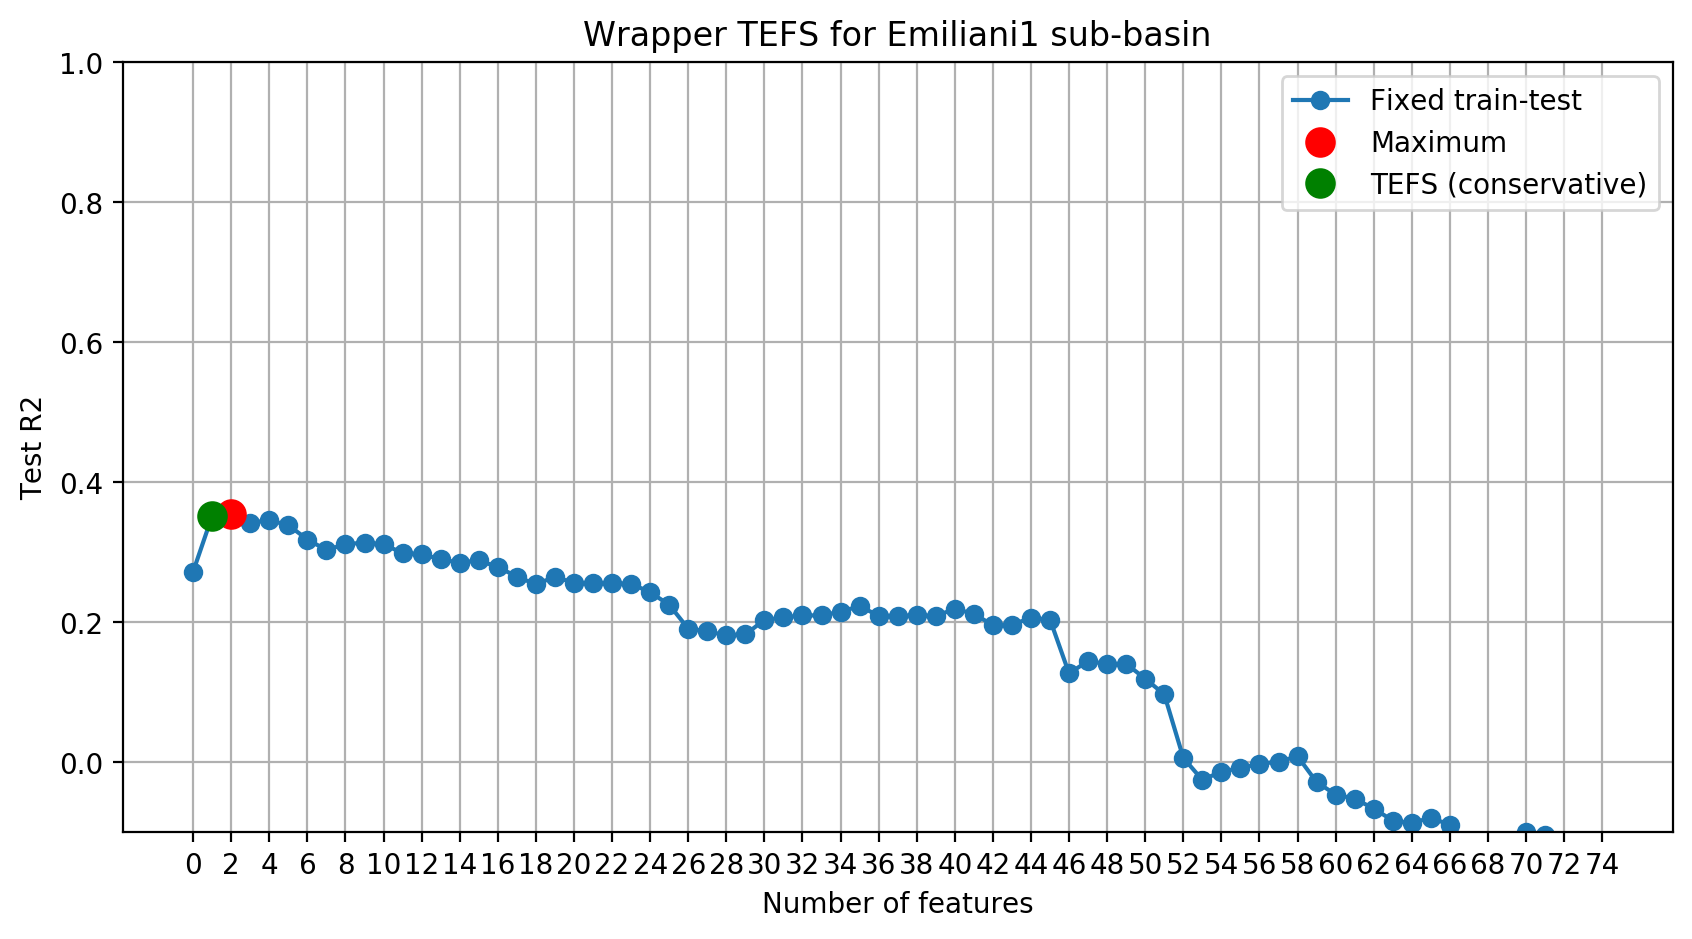

In [39]:
selected_features = fs.select_features(threshold=np.inf)
n_features_selected_with_threshold = len(selected_features)
selected_features

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(scores[0:75], marker="o", label="Fixed train-test")
maxima = np.where(scores == scores.max())[0]
ax.plot(maxima, scores[maxima], marker="o", color="red", linestyle="None", label="Maximum", markersize=10)
ax.plot(1, scores[1], marker="o", color="green", linestyle="None", label="TEFS (conservative)", markersize=10)

ax.legend()

ax.set_xlabel("Number of features")
ax.set_ylabel("Test R2")
ax.set_title("Wrapper TEFS for Emiliani1 sub-basin")
step = 2
ax.set_xticks(range(0, 75, step))
ax.set_xticklabels(range(0, 75, step)) #int(num_total_features)+1
ax.set_ylim(-0.1, 1)
ax.grid(visible=True)

plt.show()

fig.savefig("/Users/paolo/Downloads/wrapperEmiliani1.png")

In [6]:
actual_path1 = path_features+'Emiliani1'+'_aggreg.csv'
actual_path2 = path_features+'Emiliani2'+'_aggreg.csv'
actual_path3 = path_features+'Garda_Mincio'+'_aggreg.csv'

df1 = pd.read_csv(actual_path1)
df2 = pd.read_csv(actual_path2)
df3 = pd.read_csv(actual_path3)

df_all = pd.concat((df1,df2,df3),axis=0)
actual_path_all = path_features+'Emiliani1_2_GM'+'_aggreg.csv'

df_all.to_csv(actual_path_all)


KeyboardInterrupt: 

In [24]:
print(len(output[0][0]))
print(len(output[0][1]))
print(len(output[0][2]))

83
4
5


In [35]:
basins = ['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino', 'Emiliani1', 'Emiliani2', 'Dora', 'Piemonte_Nord', 'Piemonte_Sud']


path_target = "/Users/paolo/Documents/Droughts/Veronica/VHI_target/"
path_features = '/Users/paolo/Documents/Droughts/Veronica/final_features_allcoord/temp_prec/'
plots_folder = './NonLinCFA/for_plots/internal_ordering/'

basin = "Garda_Mincio"
selected_colnames_CMI5 = []
print('####################' + basin + '####################')
target_df_train, target_df_val, target_df_test, target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
    path=path_target+basin+'.csv', window_size = 1)
eps = 0.01
actual_path = path_features+basin+'_aggreg.csv'
output, aggregate_trainVal, aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg',
                                                                        'cyclostationary_mean_tg_1w',
                                                                        'cyclostationary_mean_tg_4w',
                                                                        'cyclostationary_mean_tg_8w',
                                                                        'cyclostationary_mean_tg_12w',
                                                                        'cyclostationary_mean_tg_16w',
                                                                        'cyclostationary_mean_tg_24w',
                                                                        'cyclostationary_mean_rr',
                                                                        'cyclostationary_mean_rr_1w',
                                                                        'cyclostationary_mean_rr_4w',
                                                                        'cyclostationary_mean_rr_8w',
                                                                        'cyclostationary_mean_rr_12w',
                                                                        'cyclostationary_mean_rr_16w',
                                                                        'cyclostationary_mean_rr_24w'
                                                                        ],
                                                                  target_df_trainVal, eps=eps,
                                                                  max_train='2010-01-01', max_val='2015-01-01', max_test='2030-01-01')

for basin in basins:
    selected_colnames_CMI5 = []
    print('####################' + basin + '####################')
    target_df_train, target_df_val, target_df_test, target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
        path=path_target+basin+'.csv', window_size = 1)
    eps = 0.01
    actual_path = path_features+basin+'_aggreg.csv'
    output, curr_aggregate_trainVal, curr_aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg',
                                                                            'cyclostationary_mean_tg_1w',
                                                                            'cyclostationary_mean_tg_4w',
                                                                            'cyclostationary_mean_tg_8w',
                                                                            'cyclostationary_mean_tg_12w',
                                                                            'cyclostationary_mean_tg_16w',
                                                                            'cyclostationary_mean_tg_24w',
                                                                            'cyclostationary_mean_rr',
                                                                            'cyclostationary_mean_rr_1w',
                                                                            'cyclostationary_mean_rr_4w',
                                                                            'cyclostationary_mean_rr_8w',
                                                                            'cyclostationary_mean_rr_12w',
                                                                            'cyclostationary_mean_rr_16w',
                                                                            'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                      target_df_trainVal, eps=eps,
                                                                      max_train='2010-01-01', max_val='2015-01-01', max_test='2030-01-01')
    aggregate_trainVal = pd.concat((aggregate_trainVal,curr_aggregate_trainVal),axis=1)
    aggregate_test = pd.concat((aggregate_test,curr_aggregate_test),axis=1)


####################Garda_Mincio####################
Number of features: 67

eps value:  0.00014925373134328358
Number of aggregated features: 2

Number of features: 67

eps value:  0.00014925373134328358
Number of aggregated features: 3

Number of features: 67

eps value:  0.00014925373134328358
Number of aggregated features: 2

Number of features: 67

eps value:  0.00014925373134328358
Number of aggregated features: 4

Number of features: 67

eps value:  0.00014925373134328358
Number of aggregated features: 1

Number of features: 67

eps value:  0.00014925373134328358
Number of aggregated features: 1

Number of features: 67

eps value:  0.00014925373134328358
Number of aggregated features: 1

Number of features: 67

eps value:  0.00014925373134328358
Number of aggregated features: 3

Number of features: 67

eps value:  0.00014925373134328358
Number of aggregated features: 3

Number of features: 67

eps value:  0.00014925373134328358
Number of aggregated features: 1

Number of feature

Number of aggregated features: 5

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 5

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 3

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 4

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 3

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 4

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 2

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 4

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 8

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 6

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 4

Number of features: 130

eps value: 

In [3]:
import pandas as pd
path_features = '/Users/paolo/Documents/Droughts/Veronica/final_features_allcoord/temp_prec/'
df = pd.read_csv(path_features+'Adda_aggreg.csv')

In [5]:
df.cyclostationary_mean_tg

0        1.966346
1        1.889038
2        1.971827
3        0.615192
4        1.527212
           ...   
90247    2.902019
90248    3.042596
90249    3.280673
90250    3.071346
90251    3.166346
Name: cyclostationary_mean_tg, Length: 90252, dtype: float64

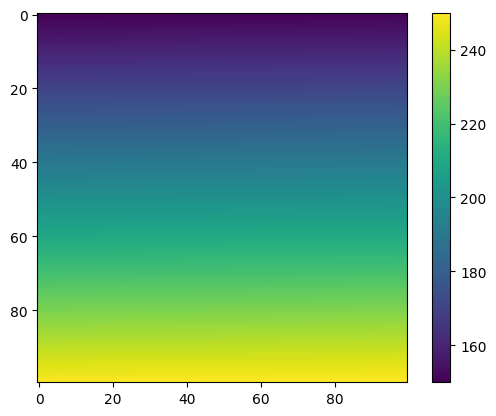

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='viridis') #hsv
    plt.colorbar()
    plt.show()
    
test_array = (np.arange(100 * 100).reshape(100, 100)/10000)*100+150
heatmap2d(test_array)


In [37]:
aggregate_trainVal.to_csv("/Users/paolo/Documents/MultiLinCFA/full_trainVal.csv")

In [39]:
aggregate_test.to_csv("/Users/paolo/Documents/MultiLinCFA/full_test.csv")

In [41]:
pd.concat((aggregate_trainVal.reset_index(drop=True),aggregate_test.reset_index(drop=True)), axis=0).reset_index(drop=True).to_csv("/Users/paolo/Documents/MultiLinCFA/full.csv")


In [42]:
pd.concat((aggregate_trainVal.reset_index(drop=True),aggregate_test.reset_index(drop=True)), axis=0).reset_index(drop=True)

cyclostationary_mean_tg_0  cyclostationary_mean_tg_1  \
0                     0.478276                  -0.549284   
1                     1.255624                   0.623450   
2                    -0.610679                  -1.478095   
3                     0.681476                   0.282302   
4                    -0.031294                  -1.088700   
..                         ...                        ...   
976                   1.680725                   2.153587   
977                   0.842483                   0.538383   
978                   1.564644                   1.234374   
979                   0.996856                   0.778341   
980                   1.535883                   1.467692   

     cyclostationary_mean_tg_1w_0  cyclostationary_mean_tg_1w_1  \
0                        0.505197                     -0.749990   
1                        0.978959                     -0.012007   
2                        0.330739                     -0.582438   
3                       -0.003101                     -0.793257   
4                        0.344541                     -0.567002   
..                            ...                           ...   
976                      1.830801                      2.243088   
977                      1.516672                      1.654492   
978                      1.419087                      1.070180   
979                      1.517234                      1.223759   
980                      1.512357                      1.373204   

     cyclostationary_mean_tg_1w_2  cyclostationary_mean_tg_4w_0  \
0                        1.242417                      0.571739   
1                        1.807682                      1.253458   
2                        1.228954                      0.447531   
3                        0.788622                      0.594058   
4                        0.890362                      0.423349   
..                            ...                           ...   
976                      1.646810                      1.021750   
977                      1.455139                      1.144671   
978                      1.601932                      1.673268   
979                      1.485756                      2.076997   
980                      1.232065                      2.128942   

     cyclostationary_mean_tg_4w_1  cyclostationary_mean_tg_8w_0  \
0                       -1.537812                      1.022926   
1                       -0.537524                      1.731718   
2                       -1.392925                      0.783567   
3                       -1.010250                      0.916920   
4                       -1.313482                      0.744542   
..                            ...                           ...   
976                      1.509889                      0.819237   
977                      1.384973                      0.811276   
978                      1.747053                      1.134753   
979                      2.031409                      1.392787   
980                      2.039399                      1.653246   

     cyclostationary_mean_tg_8w_1  cyclostationary_mean_tg_8w_2  ...  \
0                       -0.735498                     -1.600249  ...   
1                        0.406213                     -0.473982  ...   
2                       -0.563680                     -1.549546  ...   
3                       -0.234225                     -1.089813  ...   
4                       -0.536819                     -1.492265  ...   
..                            ...                           ...  ...   
976                      0.955727                      0.919258  ...   
977                      0.943940                      0.924717  ...   
978                      1.213495                      1.126145  ...   
979                      1.569915                      1.476436  ...   
980                      1.870260                      1.768031  

In [106]:
basins = ['Emiliani2']

path_target = "/Users/paolo/Documents/Droughts/Veronica/VHI_target/"
path_features = '/Users/paolo/Documents/Droughts/Veronica/final_features_allcoord/temp_prec/'
plots_folder = './NonLinCFA/for_plots/internal_ordering/'

for basin in basins:
    selected_colnames_CMI5 = []
    print('####################' + basin + '####################')
    target_df_train, target_df_val, target_df_test, target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
        path=path_target+basin+'.csv', window_size = 1)
    eps = 0.01
    actual_path = path_features+basin+'_aggreg.csv'
    output, aggregate_trainVal, aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg',
                                                                            'cyclostationary_mean_tg_1w',
                                                                            'cyclostationary_mean_tg_4w',
                                                                            'cyclostationary_mean_tg_8w',
                                                                            'cyclostationary_mean_tg_12w',
                                                                            'cyclostationary_mean_tg_16w',
                                                                            'cyclostationary_mean_tg_24w',
                                                                            'cyclostationary_mean_rr',
                                                                            'cyclostationary_mean_rr_1w',
                                                                            'cyclostationary_mean_rr_4w',
                                                                            'cyclostationary_mean_rr_8w',
                                                                            'cyclostationary_mean_rr_12w',
                                                                            'cyclostationary_mean_rr_16w',
                                                                            'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                      target_df_trainVal, eps=eps,
                                                                      max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')



####################Emiliani2####################
Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 5

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 5

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 3

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 4

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 3

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 4

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 2

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 4

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 8

Number of features: 130

eps value:  7.692307692307693e-05
Number of aggregated features: 6

Number of features: 

In [107]:
res = {
        "delta" : [],
        "numSelected" : [],
        "selectedFeatures" : []
    }
res['selectedFeatures'] = forwardFeatureSelection(10,np.array(aggregate_trainVal),
                                                np.array(target_df_trainVal.mean_std),res,10,1)

selectedFeatures='selectedFeatures'
print(f'\n{res[selectedFeatures]}\n')

selected_colnames = aggregate_trainVal.columns[res['selectedFeatures']]

print('\nFull model and selected features with CMI\n')
compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)

print('\nFull model and best 5 selected features with CMI\n')
compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])

#train_string = destination_folder + basin + '_nonLinCFA_best5_CMI_train.csv'
#val_string = destination_folder + basin + '_nonLinCFA_best5_CMI_val.csv'
#test_string = destination_folder + basin + '_nonLinCFA_best5_CMI_test.csv'

X_train_CMI5 = aggregate_trainVal.loc[:410,selected_colnames[0:5]]
X_validation_CMI5 = aggregate_trainVal.loc[411:,selected_colnames[0:5]]
X_train_validation_CMI5 = pd.concat([X_train_CMI5, X_validation_CMI5])
X_test_CMI5 = aggregate_test.loc[:,selected_colnames[0:5]]

selected_colnames_CMI5.append(aggregate_trainVal.loc[:,selected_colnames[0:5]].columns.values)

----- MI Scores -----
[(0, 0.12719286406728322), (7, 0.12040956068136226), (6, 0.1171824496324987), (1, 0.11105606559756273), (47, 0.10961607625896948), (2, 0.10936349802020918), (49, 0.10520683881063538), (42, 0.10273933299236679), (41, 0.10049432405580411), (44, 0.0991118627424368), (45, 0.09382355499119019), (12, 0.09139628132408192), (9, 0.09095231533312907), (4, 0.09002344943712864), (8, 0.08840980007656025), (3, 0.08633953056624281), (48, 0.08558216466683924), (46, 0.08205295692304651), (5, 0.08074682714382724), (29, 0.0797931918055127), (34, 0.07903782549178083), (38, 0.07798004464157235), (33, 0.07735136800386032), (40, 0.07546697074838876), (35, 0.07529516903161296), (27, 0.07402819821151656), (36, 0.07013399097421287), (31, 0.06647069285556821), (28, 0.06487236326605675), (30, 0.06324959179957317), (39, 0.05972054269611112), (13, 0.05743261433434155), (11, 0.05531454827164086), (50, 0.051368576889659456), (16, 0.05010637686748453), (43, 0.04953166864293311), (32, 0.0493669649

In [118]:
features = ['cyclostationary_mean_tg', 'cyclostationary_mean_tg_1w', 'cyclostationary_mean_tg_4w', 'cyclostationary_mean_tg_8w',
                                                                            'cyclostationary_mean_tg_12w',
                                                                            'cyclostationary_mean_tg_16w',
                                                                            'cyclostationary_mean_tg_24w',
                                                                            'cyclostationary_mean_rr',
                                                                            'cyclostationary_mean_rr_1w',
                                                                            'cyclostationary_mean_rr_4w',
                                                                            'cyclostationary_mean_rr_8w',
                                                                            'cyclostationary_mean_rr_12w',
                                                                            'cyclostationary_mean_rr_16w',
                                                                            'cyclostationary_mean_rr_24w']

def plot_cells(output, selected_colnames, xmin=9, xmax=11, ymin=44, ymax=45.5, sample=0, starting_point=[0,0]):
    x = []
    y = []
    fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize=(9, 9), constrained_layout=True)
    # fig.suptitle(basin + ' shuffle num. ' + str(sample) + ' standardized target, no moving avg', fontsize=12)
    fig.suptitle(basin + ' NonLinCFA and CMI selected features', fontsize=12)
    for j in range(0, 2):
        for i in range(0,5):
            ax[i][j].set_xlim(xmin,xmax)
            ax[i][j].set_ylim(ymin,ymax)

    cmap = plt.get_cmap('rainbow')
    selected_colnames_nocoord = [feature.rsplit('_', 1)[0] for feature in selected_colnames]
    
    print(selected_colnames_nocoord)

    for i in range(len(selected_colnames)):
      # iterate over all the features aggregations
        for k in range (len(output)):
            
            # print only the aggregations of the chosen features
            #if output[k][0][0].split('_')[0].replace("-", "_" ) == selected_colnames_nocoord[i]:
            if features[k] == selected_colnames_nocoord[i]:
            #print ("Found feature ", selected_colnames_nocoord[i])

                for j in range (len(output[k])):       # j iterates all the clusters
                #colors = cm.rainbow(np.linspace(0,1,len(output[k])))
                #np.random.shuffle(cm)
                    x = []
                    y = []
                    for datum in output[k][j]:
                        x.append(float(datum.split('_')[1]))
                        #print(float(datum.split('_')[1]))
                        y.append(float(datum.split('_')[2]))
                        #print(float(datum.split('_')[2]))

                    ax[i][0].scatter(x,y,color=cmap(1.*j/len(output[k]))) # ax[i][0].scatter(x,y,color=colors[j])
                    ax[i][0].scatter(float(starting_point[0]), float(starting_point[1]), facecolors='none', edgecolors='r')
                    ax[i][0].set_title(selected_colnames_nocoord[i] + '_all_aggreg', fontsize = 9)

        for k in range (len(output)):
            
            # print only the aggregations of the chosen features
            #if output[k][0][0].split('_')[0].replace("-", "_" ) == selected_colnames_nocoord[i]:
            if features[k] == selected_colnames_nocoord[i]:
            #print ("Found feature ", selected_colnames_nocoord[i])

                for j in range (len(output[k])):       # j iterates all the clusters
                #colors = cm.rainbow(np.linspace(0,1,len(output[k])))
                #np.random.shuffle(cm)
                    x = []
                    y = []
                    for datum in output[k][j]:
                        x.append(float(datum.split('_')[1]))
                        #print(float(datum.split('_')[1]))
                        y.append(float(datum.split('_')[2]))
                        #print(float(datum.split('_')[2]))

                    ax[i][1].scatter(x,y,color='lightgrey') # ax[i][0].scatter(x,y,color=colors[j])
                    #ax[i][0].scatter(float(starting_point[0]), float(starting_point[1]), facecolors='none', edgecolors='r')
                    #ax[i][0].set_title(selected_colnames_nocoord[i] + '_all_aggreg', fontsize = 9)

                    
    col = cm.rainbow(np.linspace(0,1,len(selected_colnames)))
    for i in range(len(selected_colnames)):
        for k in range(0, len(output)):
            if features[k] == selected_colnames_nocoord[i]:
            #if output[k][0][0].split('_')[0].replace("-", "_" ) == selected_colnames_nocoord[i]:
                # print ("Found feature ", output[k][0][0].split('_')[0].replace("-", "_" ))
                x = []
                y = []
                idx = int(selected_colnames[i].split('_')[-1])
                for datum in output[k][idx]:
                    x.append(float(datum.split('_')[1]))
                    y.append(float(datum.split('_')[2]))
        col=0
        if i==1:
            col=0.8
        if i==3:
            col=0.125
        if i==4:
            col=0.4
        ax[i][1].scatter(x,y,color=cmap(col)) # 1.*i/len(selected_colnames)
        ax[i][1].set_title(selected_colnames_nocoord[i] + '_chosen_aggreg', fontsize = 9)
        fig.savefig('/Users/paolo/Downloads/Emiliani2_selection_grey.png', dpi=fig.dpi)

['cyclostationary_mean_tg', 'cyclostationary_mean_rr_8w', 'cyclostationary_mean_tg_4w', 'cyclostationary_mean_rr_1w', 'cyclostationary_mean_rr_12w']


[array(['cyclostationary_mean_tg_0', 'cyclostationary_mean_rr_8w_3',
        'cyclostationary_mean_tg_4w_0', 'cyclostationary_mean_rr_1w_1',
        'cyclostationary_mean_rr_12w_1'], dtype=object)]

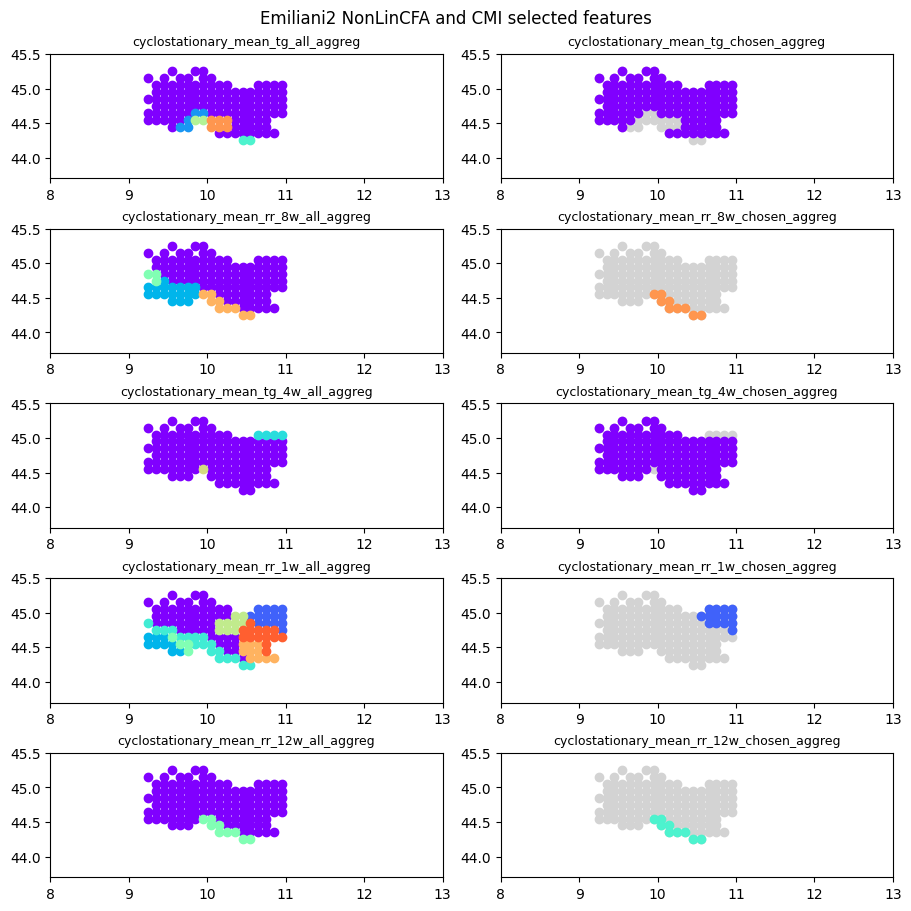

In [119]:
plot_cells(output, selected_colnames, xmin=8, xmax=13, ymin=43.7, ymax=45.5, sample=1)
selected_colnames_CMI5

## Temp Prec Snow

In [ ]:
basins = ['Adda', 'Oglio_Iseo', 'Ticino', 'Dora', 'Piemonte_Nord', 'Piemonte_Sud']
path_target = "./csv/"
path_features='./features_allvalues/'
path_features_snow = './features_allvalues/snow/copernicus/relevant_coords/'

destination_folder = './NonLinCFA/temp_prec_snow_copernicus/relevant_coords/'
plots_folder = './NonLinCFA/for_plots/internal_ordering/snow/'

for basin in basins:

    print('####################' + basin + '####################')

    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
                                                                                     path=path_target+basin+'.csv')

    eps = 0.01
    actual_path = path_features+basin+'_aggreg.csv'
    snow_actual_path = path_features_snow+basin+'_aggreg_sd_allCoord.csv'


    output,aggregate_trainVal_temp_prec,aggregate_test_temp_prec = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg',
                                                                             'cyclostationary_mean_tg_1w',
                                                                             'cyclostationary_mean_tg_4w',
                                                                             'cyclostationary_mean_tg_8w',
                                                                             'cyclostationary_mean_tg_12w',
                                                                             'cyclostationary_mean_tg_16w',
                                                                             'cyclostationary_mean_tg_24w',
                                                                             'cyclostationary_mean_rr',
                                                                             'cyclostationary_mean_rr_1w',
                                                                             'cyclostationary_mean_rr_4w',
                                                                             'cyclostationary_mean_rr_8w',
                                                                             'cyclostationary_mean_rr_12w',
                                                                             'cyclostationary_mean_rr_16w',
                                                                             'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                       target_df_trainVal, eps=eps,
                                                                       max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
    if os.path.isfile(snow_actual_path):
      output_snow,aggregate_trainVal_snow,aggregate_test_snow = aggregate_unfolded_data(snow_actual_path,['cyclostationary_mean_HS',
                                                                              'cyclostationary_mean_HS_1w',
                                                                              'cyclostationary_mean_HS_4w',
                                                                              'cyclostationary_mean_HS_8w',
                                                                              'cyclostationary_mean_HS_12w',
                                                                              'cyclostationary_mean_HS_16w',
                                                                              'cyclostationary_mean_HS_24w'
                                                                              ],
                                                                        target_df_trainVal, eps=eps,
                                                                        max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
                                                                                        scale = 0.26)


      aggregate_trainVal = pd.concat((aggregate_trainVal_snow,aggregate_trainVal_temp_prec),axis=1)
      aggregate_test = pd.concat((aggregate_test_snow,aggregate_test_temp_prec),axis=1)

    selected_colnames = FS_with_linearWrapper(aggregate_trainVal, target_df_train, target_df_val, min(50,aggregate_trainVal.shape[1]-1), 228)

    print('\nFull model and selected features with wrapper\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)

    print('\nFull model and best 5 selected features with wrapper\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])

    train_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_train_withSnow.csv'
    val_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_val_withSnow.csv'
    test_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_test_withSnow.csv'
    X_train_wrapper = aggregate_trainVal.loc[:410,selected_colnames[0:5]]
    X_validation_wrapper = aggregate_trainVal.loc[411:,selected_colnames[0:5]]
    X_train_validation_wrapper = pd.concat([X_train_wrapper, X_validation_wrapper])
    X_test_wrapper = aggregate_test.loc[:,selected_colnames[0:5]]
    X_train_wrapper.to_csv(train_string, index=False)
    X_validation_wrapper.to_csv(val_string, index=False)
    X_test_wrapper.to_csv(test_string, index=False)

    res = {
            "delta" : [],
            "numSelected" : [],
            "selectedFeatures" : []
        }

    res['selectedFeatures'] = forwardFeatureSelection(10,np.array(aggregate_trainVal),
                                                      np.array(target_df_trainVal.mean_std),res,10,1)

    selectedFeatures='selectedFeatures'
    print(f'\n{res[selectedFeatures]}\n')

    selected_colnames = aggregate_trainVal.columns[res['selectedFeatures']]

    print('\nFull model and selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)

    print('\nFull model and best 5 selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])

    train_string = destination_folder + basin + '_nonLinCFA_best5_CMI_train_withSnow.csv'
    val_string = destination_folder + basin + '_nonLinCFA_best5_CMI_val_withSnow.csv'
    test_string = destination_folder + basin + '_nonLinCFA_best5_CMI_test_withSnow.csv'

    X_train_CMI5 = aggregate_trainVal.loc[:410,selected_colnames[0:5]]
    X_validation_CMI5 = aggregate_trainVal.loc[411:,selected_colnames[0:5]]
    X_train_validation_CMI5 = pd.concat([X_train_CMI5, X_validation_CMI5])
    X_test_CMI5 = aggregate_test.loc[:,selected_colnames[0:5]]

    selected_colnames_CMI5 = aggregate_trainVal.loc[:,selected_colnames[0:5]].columns.values

    X_train_CMI5.to_csv(train_string, index=False)
    X_validation_CMI5.to_csv(val_string, index=False)
    X_test_CMI5.to_csv(test_string, index=False)

    train_string = destination_folder + basin + '_nonLinCFA_CMI_train_withSnow.csv'
    val_string = destination_folder + basin + '_nonLinCFA_CMI_val_withSnow.csv'
    test_string = destination_folder + basin + '_nonLinCFA_CMI_test_withSnow.csv'

    X_train_CMI = aggregate_trainVal.loc[:410,selected_colnames]
    X_validation_CMI = aggregate_trainVal.loc[411:,selected_colnames]
    X_train_validation_CMI = pd.concat([X_train_CMI, X_validation_CMI])
    X_test_CMI = aggregate_test.loc[:,selected_colnames]

    X_train_CMI.to_csv(train_string, index=False)
    X_validation_CMI.to_csv(val_string, index=False)
    X_test_CMI.to_csv(test_string, index=False)

    print('###### Regression ######')
    lin_regr = LinearRegression()

    # CMI
    lin_regr.fit(X_train_validation_CMI, target_df_trainVal.mean_std)
    print("Train R2 linear regression CMI: ", round(lin_regr.score(X_train_validation_CMI, target_df_trainVal.mean_std),3))
    print("Test R2 linear regression CMI: ", round(lin_regr.score(X_test_CMI, target_df_test.mean_std),3), "\n")

    # CMI best 5
    lin_regr.fit(X_train_validation_CMI5, target_df_trainVal.mean_std)
    print("Train R2 linear regression CMI best 5: ", round(lin_regr.score(X_train_validation_CMI5, target_df_trainVal.mean_std),3))
    print("Test R2 linear regression CMI best 5: ", round(lin_regr.score(X_test_CMI5, target_df_test.mean_std),3), "\n")

    # wrapper
    lin_regr.fit(X_train_validation_wrapper, target_df_trainVal.mean_std)
    print("Train R2 linear regression wrapper: ", round(lin_regr.score(X_train_validation_wrapper, target_df_trainVal.mean_std),3))
    print("Test R2 linear regression wrapper: ", round(lin_regr.score(X_test_wrapper, target_df_test.mean_std),3), "\n")

    print('###### Binary Classification ######')

    target_df_train = target_df_train.apply(lambda x: np.sign(x.mean_std), axis=1)
    target_df_val = target_df_val.apply(lambda x: np.sign(x.mean_std), axis=1)
    target_df_test = target_df_test.apply(lambda x: np.sign(x.mean_std), axis=1)
    target_df_trainVal = target_df_trainVal.apply(lambda x: np.sign(x.mean_std), axis=1)

    log_regr = LogisticRegression(solver='lbfgs', random_state = 42)

    # CMI
    log_regr.fit(X_train_validation_CMI, target_df_trainVal)
    print("Train accuracy logistic regression CMI: ", round(log_regr.score(X_train_validation_CMI, target_df_trainVal),3))
    print("Test accuracy logistic regression CMI: ", round(log_regr.score(X_test_CMI, target_df_test),3), "\n")

    # CMI best 5
    log_regr.fit(X_train_validation_CMI5, target_df_trainVal)
    print("Train accuracy logistic regression CMI best 5: ", round(log_regr.score(X_train_validation_CMI5, target_df_trainVal),3))
    print("Test accuracy logistic regression CMI best 5: ", round(log_regr.score(X_test_CMI5, target_df_test),3), "\n")

    # wrapper
    log_regr.fit(X_train_validation_wrapper, target_df_trainVal)
    print("Train accuracy logistic regression wrapper: ", round(log_regr.score(X_train_validation_wrapper, target_df_trainVal),3))
    print("Test accuracy logistic regression wrapper: ", round(log_regr.score(X_test_wrapper, target_df_test),3), "\n")

    output_string = plots_folder + basin + '_aggregations.npy'
    sel_col_string = plots_folder + basin + '_chosen_features.npy'
    np.save(sel_col_string, selected_colnames_CMI5)
    np.save(output_string, output)

####################Adda####################
Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 4

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 5

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 4

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 1

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 3

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 1

Number of features: 92

e

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


####################Oglio_Iseo####################
Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 3

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 2

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 1

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 1

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 1

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 1

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 1

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 3

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 2

Number of features: 74

eps value:  0.00013513513513513514
Number of aggregated features: 1

Number of features:

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


####################Ticino####################
Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 3

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 4

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 5

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 3

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 3

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 1

Number of features: 92


/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


####################Dora####################
Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 3

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 2

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 2

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 1

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 3

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 2

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 1

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 1

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 1

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 2

Number of features: 44

e

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


####################Piemonte_Nord####################
Number of features: 89

eps value:  0.00011235955056179776
Number of aggregated features: 8

Number of features: 89

eps value:  0.00011235955056179776
Number of aggregated features: 5

Number of features: 89

eps value:  0.00011235955056179776
Number of aggregated features: 5

Number of features: 89

eps value:  0.00011235955056179776
Number of aggregated features: 5

Number of features: 89

eps value:  0.00011235955056179776
Number of aggregated features: 1

Number of features: 89

eps value:  0.00011235955056179776
Number of aggregated features: 1

Number of features: 89

eps value:  0.00011235955056179776
Number of aggregated features: 1

Number of features: 89

eps value:  0.00011235955056179776
Number of aggregated features: 5

Number of features: 89

eps value:  0.00011235955056179776
Number of aggregated features: 6

Number of features: 89

eps value:  0.00011235955056179776
Number of aggregated features: 4

Number of featur

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


####################Piemonte_Sud####################
Number of features: 176

eps value:  5.681818181818182e-05
Number of aggregated features: 3

Number of features: 176

eps value:  5.681818181818182e-05
Number of aggregated features: 4

Number of features: 176

eps value:  5.681818181818182e-05
Number of aggregated features: 2

Number of features: 176

eps value:  5.681818181818182e-05
Number of aggregated features: 4

Number of features: 176

eps value:  5.681818181818182e-05
Number of aggregated features: 6

Number of features: 176

eps value:  5.681818181818182e-05
Number of aggregated features: 5

Number of features: 176

eps value:  5.681818181818182e-05
Number of aggregated features: 2

Number of features: 176

eps value:  5.681818181818182e-05
Number of aggregated features: 7

Number of features: 176

eps value:  5.681818181818182e-05
Number of aggregated features: 5

Number of features: 176

eps value:  5.681818181818182e-05
Number of aggregated features: 4

Number of feature

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## Temp Prec Snow Lakes

In [ ]:
basins = ['Ticino', 'Oglio_Iseo', 'Adda', 'Lambro_Olona']

path_target = "./csv/"
path_features_snow = './features_allvalues/snow/copernicus/relevant_coords/'
path_features='./features_allvalues/'
path_features_lakes='./lakes/'

destination_folder = './NonLinCFA/temp_prec_snow_lakes_copernicus/'

for basin in basins:
    print('####################' + basin + '####################')

    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
                                                                                     path=path_target+basin+'.csv')

    eps = 0.01
    actual_path = path_features+basin+'_aggreg.csv'
    snow_actual_path = path_features_snow+basin+'_aggreg_sd_allCoord.csv'
    lakes_actual_path = path_features_lakes + 'lakes_' + basin + '_with_aggreg.csv'

    output,aggregate_trainVal,aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg',
                                                                             'cyclostationary_mean_tg_1w',
                                                                             'cyclostationary_mean_tg_4w',
                                                                             'cyclostationary_mean_tg_8w',
                                                                             'cyclostationary_mean_tg_12w',
                                                                             'cyclostationary_mean_tg_16w',
                                                                             'cyclostationary_mean_tg_24w',
                                                                             'cyclostationary_mean_rr',
                                                                             'cyclostationary_mean_rr_1w',
                                                                             'cyclostationary_mean_rr_4w',
                                                                             'cyclostationary_mean_rr_8w',
                                                                             'cyclostationary_mean_rr_12w',
                                                                             'cyclostationary_mean_rr_16w',
                                                                             'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                       target_df_trainVal, eps=eps,
                                                                       max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')

    if os.path.isfile(snow_actual_path):
      output_snow,aggregate_trainVal_snow,aggregate_test_snow = aggregate_unfolded_data(snow_actual_path,['cyclostationary_mean_HS',
                                                                              'cyclostationary_mean_HS_1w',
                                                                              'cyclostationary_mean_HS_4w',
                                                                              'cyclostationary_mean_HS_8w',
                                                                              'cyclostationary_mean_HS_12w',
                                                                              'cyclostationary_mean_HS_16w',
                                                                              'cyclostationary_mean_HS_24w'
                                                                              ],
                                                                        target_df_trainVal, eps=eps,
                                                                        max_train='2010-01-01', max_val='2015-01-01',
                                                                                        max_test='2020-01-01', scale = 0.26)

      aggregate_trainVal = pd.concat((aggregate_trainVal_snow,aggregate_trainVal),axis=1)
      aggregate_test = pd.concat((aggregate_test_snow,aggregate_test),axis=1)

    if os.path.isfile(lakes_actual_path):
      df_lakes = pd.read_csv(lakes_actual_path)
      df_lakes = df_lakes.drop("Unnamed: 0", axis='columns')

      df_lakes_trainVal = df_lakes.loc[(df_lakes['date'] > '2001-01-01') & (df_lakes['date'] <= '2015-01-01'),:]
      df_lakes_trainVal.reset_index(inplace = True, drop = True)
      df_lakes_trainVal = df_lakes_trainVal.iloc[:,3:]
      df_lakes_test = df_lakes.loc[(df_lakes['date'] > '2015-01-01') & (df_lakes['date'] <= '2020-01-01'),:]
      df_lakes_test.reset_index(inplace = True, drop = True)
      df_lakes_test = df_lakes_test.iloc[:,3:]

      aggregate_trainVal = pd.concat((aggregate_trainVal, df_lakes_trainVal),axis=1)
      aggregate_test = pd.concat((aggregate_test, df_lakes_test),axis=1)

    selected_colnames = FS_with_linearWrapper(aggregate_trainVal, target_df_train, target_df_val, min(50,aggregate_trainVal.shape[1]-1), 228)

    print('\nFull model and selected features with wrapper\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)

    print('\nFull model and best 5 selected features with wrapper\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])

    train_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_train_withSnowLakes.csv'
    val_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_val_withSnowLakes.csv'
    test_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_test_withSnowLakes.csv'
    X_train_wrapper = aggregate_trainVal.loc[:410,selected_colnames[0:5]]
    X_validation_wrapper = aggregate_trainVal.loc[411:,selected_colnames[0:5]]
    X_train_validation_wrapper = pd.concat([X_train_wrapper, X_validation_wrapper])
    X_test_wrapper = aggregate_test.loc[:,selected_colnames[0:5]]
    X_train_wrapper.to_csv(train_string, index=False)
    X_validation_wrapper.to_csv(val_string, index=False)
    X_test_wrapper.to_csv(test_string, index=False)

    res = {
            "delta" : [],
            "numSelected" : [],
            "selectedFeatures" : []
        }

    res['selectedFeatures'] = forwardFeatureSelection(10,np.array(aggregate_trainVal),
                                                      np.array(target_df_trainVal.mean_std),res,10,1)

    selectedFeatures='selectedFeatures'
    print(f'\n{res[selectedFeatures]}\n')

    selected_colnames = aggregate_trainVal.columns[res['selectedFeatures']]

    print('\nFull model and selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)

    print('\nFull model and best 5 selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])

    train_string = destination_folder + basin + '_nonLinCFA_best5_CMI_train_withSnowLakes.csv'
    val_string = destination_folder + basin + '_nonLinCFA_best5_CMI_val_withSnowLakes.csv'
    test_string = destination_folder + basin + '_nonLinCFA_best5_CMI_test_withSnowLakes.csv'

    X_train_CMI5 = aggregate_trainVal.loc[:410,selected_colnames[0:5]]
    X_validation_CMI5 = aggregate_trainVal.loc[411:,selected_colnames[0:5]]
    X_train_validation_CMI5 = pd.concat([X_train_CMI5, X_validation_CMI5])
    X_test_CMI5 = aggregate_test.loc[:,selected_colnames[0:5]]

    selected_colnames_CMI5 = aggregate_trainVal.loc[:,selected_colnames[0:5]].columns.values

    X_train_CMI5.to_csv(train_string, index=False)
    X_validation_CMI5.to_csv(val_string, index=False)
    X_test_CMI5.to_csv(test_string, index=False)

    train_string = destination_folder + basin + '_nonLinCFA_CMI_train_withSnowLakes.csv'
    val_string = destination_folder + basin + '_nonLinCFA_CMI_val_withSnowLakes.csv'
    test_string = destination_folder + basin + '_nonLinCFA_CMI_test_withSnowLakes.csv'

    X_train_CMI = aggregate_trainVal.loc[:410,selected_colnames]
    X_validation_CMI = aggregate_trainVal.loc[411:,selected_colnames]
    X_train_validation_CMI = pd.concat([X_train_CMI, X_validation_CMI])
    X_test_CMI = aggregate_test.loc[:,selected_colnames]

    X_train_CMI.to_csv(train_string, index=False)
    X_validation_CMI.to_csv(val_string, index=False)
    X_test_CMI.to_csv(test_string, index=False)

    print('###### Regression ######')
    lin_regr = LinearRegression()

    # CMI
    lin_regr.fit(X_train_validation_CMI, target_df_trainVal.mean_std)
    print("Train R2 linear regression CMI: ", round(lin_regr.score(X_train_validation_CMI, target_df_trainVal.mean_std),3))
    print("Test R2 linear regression CMI: ", round(lin_regr.score(X_test_CMI, target_df_test.mean_std),3), "\n")

    # CMI best 5
    lin_regr.fit(X_train_validation_CMI5, target_df_trainVal.mean_std)
    print("Train R2 linear regression CMI best 5: ", round(lin_regr.score(X_train_validation_CMI5, target_df_trainVal.mean_std),3))
    print("Test R2 linear regression CMI best 5: ", round(lin_regr.score(X_test_CMI5, target_df_test.mean_std),3), "\n")

    # wrapper
    lin_regr.fit(X_train_validation_wrapper, target_df_trainVal.mean_std)
    print("Train R2 linear regression wrapper: ", round(lin_regr.score(X_train_validation_wrapper, target_df_trainVal.mean_std),3))
    print("Test R2 linear regression wrapper: ", round(lin_regr.score(X_test_wrapper, target_df_test.mean_std),3), "\n")

    print('###### Binary Classification ######')

    target_df_train = target_df_train.apply(lambda x: np.sign(x.mean_std), axis=1)
    target_df_val = target_df_val.apply(lambda x: np.sign(x.mean_std), axis=1)
    target_df_test = target_df_test.apply(lambda x: np.sign(x.mean_std), axis=1)
    target_df_trainVal = target_df_trainVal.apply(lambda x: np.sign(x.mean_std), axis=1)

    log_regr = LogisticRegression(solver='lbfgs', random_state = 42)

    # CMI
    log_regr.fit(X_train_validation_CMI, target_df_trainVal)
    print("Train accuracy logistic regression CMI: ", round(log_regr.score(X_train_validation_CMI, target_df_trainVal),3))
    print("Test accuracy logistic regression CMI: ", round(log_regr.score(X_test_CMI, target_df_test),3), "\n")

    # CMI best 5
    log_regr.fit(X_train_validation_CMI5, target_df_trainVal)
    print("Train accuracy logistic regression CMI best 5: ", round(log_regr.score(X_train_validation_CMI5, target_df_trainVal),3))
    print("Test accuracy logistic regression CMI best 5: ", round(log_regr.score(X_test_CMI5, target_df_test),3), "\n")

    # wrapper
    log_regr.fit(X_train_validation_wrapper, target_df_trainVal)
    print("Train accuracy logistic regression wrapper: ", round(log_regr.score(X_train_validation_wrapper, target_df_trainVal),3))
    print("Test accuracy logistic regression wrapper: ", round(log_regr.score(X_test_wrapper, target_df_test),3), "\n")

## Temp Prec Lakes

In [ ]:
basins = ['Adda', 'Ticino', 'Oglio_Iseo']
path_target = "./csv/"
path_features='./features_allvalues/'
path_features_lakes='./lakes/'
destination_folder = './NonLinCFA/temp_prec_lakes/internal_ordering/'

for basin in basins:
    print('####################' + basin + '####################')

    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', path=path_target+basin+'.csv')

    eps = 0.01
    actual_path = path_features+basin+'_aggreg.csv'
    lakes_actual_path = path_features_lakes + 'lakes_' + basin + '_with_aggreg.csv'

    output,aggregate_trainVal_temp_prec,aggregate_test_temp_prec = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg',
                                                                             'cyclostationary_mean_tg_1w',
                                                                             'cyclostationary_mean_tg_4w',
                                                                             'cyclostationary_mean_tg_8w',
                                                                             'cyclostationary_mean_tg_12w',
                                                                             'cyclostationary_mean_tg_16w',
                                                                             'cyclostationary_mean_tg_24w',
                                                                             'cyclostationary_mean_rr',
                                                                             'cyclostationary_mean_rr_1w',
                                                                             'cyclostationary_mean_rr_4w',
                                                                             'cyclostationary_mean_rr_8w',
                                                                             'cyclostationary_mean_rr_12w',
                                                                             'cyclostationary_mean_rr_16w',
                                                                             'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                       target_df_trainVal, eps=eps,
                                                                       max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')

    if os.path.isfile(lakes_actual_path):
      df_lakes = pd.read_csv(lakes_actual_path)

      df_lakes = df_lakes.drop("Unnamed: 0", axis='columns')

      df_lakes_trainVal = df_lakes.loc[(df_lakes['date'] > '2001-01-01') & (df_lakes['date'] <= '2015-01-01'),:]
      df_lakes_trainVal.reset_index(inplace = True, drop = True)
      df_lakes_trainVal = df_lakes_trainVal.iloc[:,3:]
      df_lakes_test = df_lakes.loc[(df_lakes['date'] > '2015-01-01') & (df_lakes['date'] <= '2020-01-01'),:]
      df_lakes_test.reset_index(inplace = True, drop = True)
      df_lakes_test = df_lakes_test.iloc[:,3:]

      aggregate_trainVal = pd.concat((df_lakes_trainVal,aggregate_trainVal_temp_prec),axis=1)
      aggregate_test = pd.concat((df_lakes_test,aggregate_test_temp_prec),axis=1)

    selected_colnames = FS_with_linearWrapper(aggregate_trainVal, target_df_train, target_df_val, min(50,aggregate_trainVal.shape[1]-1), 228)

    print('\nFull model and selected features with wrapper\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)

    print('\nFull model and best 5 selected features with wrapper\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])

    train_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_train_withLakes.csv'
    val_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_val_withLakes.csv'
    test_string = destination_folder + basin + '_nonLinCFA_wrapper_best5_test_withLakes.csv'
    X_train_wrapper = aggregate_trainVal.loc[:410,selected_colnames[0:5]]
    X_validation_wrapper = aggregate_trainVal.loc[411:,selected_colnames[0:5]]
    X_train_validation_wrapper = pd.concat([X_train_wrapper, X_validation_wrapper])
    X_test_wrapper = aggregate_test.loc[:,selected_colnames[0:5]]
    X_train_wrapper.to_csv(train_string, index=False)
    X_validation_wrapper.to_csv(val_string, index=False)
    X_test_wrapper.to_csv(test_string, index=False)

    res = {
            "delta" : [],
            "numSelected" : [],
            "selectedFeatures" : []
        }

    res['selectedFeatures'] = forwardFeatureSelection(10,np.array(aggregate_trainVal),
                                                      np.array(target_df_trainVal.mean_std),res,10,1)

    selectedFeatures='selectedFeatures'
    print(f'\n{res[selectedFeatures]}\n')

    selected_colnames = aggregate_trainVal.columns[res['selectedFeatures']]

    print('\nFull model and selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)

    print('\nFull model and best 5 selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])

    train_string = destination_folder + basin + '_nonLinCFA_best5_CMI_train_withLakes.csv'
    val_string = destination_folder + basin + '_nonLinCFA_best5_CMI_val_withLakes.csv'
    test_string = destination_folder + basin + '_nonLinCFA_best5_CMI_test_withLakes.csv'

    X_train_CMI5 = aggregate_trainVal.loc[:410,selected_colnames[0:5]]
    X_validation_CMI5 = aggregate_trainVal.loc[411:,selected_colnames[0:5]]
    X_train_validation_CMI5 = pd.concat([X_train_CMI5, X_validation_CMI5])
    X_test_CMI5 = aggregate_test.loc[:,selected_colnames[0:5]]

    selected_colnames_CMI5 = aggregate_trainVal.loc[:,selected_colnames[0:5]].columns.values

    X_train_CMI5.to_csv(train_string, index=False)
    X_validation_CMI5.to_csv(val_string, index=False)
    X_test_CMI5.to_csv(test_string, index=False)

    train_string = destination_folder + basin + '_nonLinCFA_CMI_train_withLakes.csv'
    val_string = destination_folder + basin + '_nonLinCFA_CMI_val_withLakes.csv'
    test_string = destination_folder + basin + '_nonLinCFA_CMI_test_withLakes.csv'

    X_train_CMI = aggregate_trainVal.loc[:410,selected_colnames]
    X_validation_CMI = aggregate_trainVal.loc[411:,selected_colnames]
    X_train_validation_CMI = pd.concat([X_train_CMI, X_validation_CMI])
    X_test_CMI = aggregate_test.loc[:,selected_colnames]

    X_train_CMI.to_csv(train_string, index=False)
    X_validation_CMI.to_csv(val_string, index=False)
    X_test_CMI.to_csv(test_string, index=False)

    print('###### Regression ######')
    lin_regr = LinearRegression()

    # CMI
    lin_regr.fit(X_train_validation_CMI, target_df_trainVal.mean_std)
    print("Train R2 linear regression CMI: ", round(lin_regr.score(X_train_validation_CMI, target_df_trainVal.mean_std),3))
    print("Test R2 linear regression CMI: ", round(lin_regr.score(X_test_CMI, target_df_test.mean_std),3), "\n")

    # CMI best 5
    lin_regr.fit(X_train_validation_CMI5, target_df_trainVal.mean_std)
    print("Train R2 linear regression CMI best 5: ", round(lin_regr.score(X_train_validation_CMI5, target_df_trainVal.mean_std),3))
    print("Test R2 linear regression CMI best 5: ", round(lin_regr.score(X_test_CMI5, target_df_test.mean_std),3), "\n")

    # wrapper
    lin_regr.fit(X_train_validation_wrapper, target_df_trainVal.mean_std)
    print("Train R2 linear regression wrapper: ", round(lin_regr.score(X_train_validation_wrapper, target_df_trainVal.mean_std),3))
    print("Test R2 linear regression wrapper: ", round(lin_regr.score(X_test_wrapper, target_df_test.mean_std),3), "\n")

    print('###### Binary Classification ######')

    target_df_train = target_df_train.apply(lambda x: np.sign(x.mean_std), axis=1)
    target_df_val = target_df_val.apply(lambda x: np.sign(x.mean_std), axis=1)
    target_df_test = target_df_test.apply(lambda x: np.sign(x.mean_std), axis=1)
    target_df_trainVal = target_df_trainVal.apply(lambda x: np.sign(x.mean_std), axis=1)

    log_regr = LogisticRegression(solver='lbfgs', random_state = 42)

    # CMI
    log_regr.fit(X_train_validation_CMI, target_df_trainVal)
    print("Train accuracy logistic regression CMI: ", round(log_regr.score(X_train_validation_CMI, target_df_trainVal),3))
    print("Test accuracy logistic regression CMI: ", round(log_regr.score(X_test_CMI, target_df_test),3), "\n")

    # CMI best 5
    log_regr.fit(X_train_validation_CMI5, target_df_trainVal)
    print("Train accuracy logistic regression CMI best 5: ", round(log_regr.score(X_train_validation_CMI5, target_df_trainVal),3))
    print("Test accuracy logistic regression CMI best 5: ", round(log_regr.score(X_test_CMI5, target_df_test),3), "\n")

    # wrapper
    log_regr.fit(X_train_validation_wrapper, target_df_trainVal)
    print("Train accuracy logistic regression wrapper: ", round(log_regr.score(X_train_validation_wrapper, target_df_trainVal),3))
    print("Test accuracy logistic regression wrapper: ", round(log_regr.score(X_test_wrapper, target_df_test),3), "\n")

####################Adda####################
Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 4

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 5

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 4

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 1

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 3

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 1

Number of features: 92

e

## Multi task scores

In [ ]:
# for binary classification

from sklearn.metrics import accuracy_score
def MTL_scores(clust_basins, df_train, df_val, df_test, targets_df_train, targets_df_val, targets_df_test):

    colnames = [x for x in df_train.columns if x.startswith(tuple(clust_basins))]

    clusterdf_train_withClass = pd.DataFrame()
    clusterdf_val_withClass = pd.DataFrame()
    clusterdf_test_withClass = pd.DataFrame()

    for i in range(len(clust_basins)):
        clusterdf_train_withClass = pd.concat((clusterdf_train_withClass,pd.concat((df_train[colnames],pd.DataFrame(1+i*np.ones(len(df_train)),columns=['basin'])),axis=1)),axis=0)
        clusterdf_val_withClass = pd.concat((clusterdf_val_withClass,pd.concat((df_val[colnames],pd.DataFrame(1+i*np.ones(len(df_val)),columns=['basin'])),axis=1)),axis=0)
        clusterdf_test_withClass = pd.concat((clusterdf_test_withClass,pd.concat((df_test[colnames],pd.DataFrame(1+i*np.ones(len(df_test)),columns=['basin'])),axis=1)),axis=0)

    for i in range(len(clust_basins)):
        clusterdf_train_withClass[clust_basins[i]] = clusterdf_train_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
        clusterdf_val_withClass[clust_basins[i]] = clusterdf_val_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
        clusterdf_test_withClass[clust_basins[i]] = clusterdf_test_withClass.apply(lambda x: int(x.basin==i+1),axis=1)

    clusterdf_train_withClass = clusterdf_train_withClass.loc[:,clusterdf_train_withClass.columns != 'basin']
    clusterdf_val_withClass = clusterdf_val_withClass.loc[:,clusterdf_val_withClass.columns != 'basin']
    clusterdf_test_withClass = clusterdf_test_withClass.loc[:,clusterdf_test_withClass.columns != 'basin']

    targets_df_train_unfolded = pd.DataFrame()
    targets_df_val_unfolded = pd.DataFrame()
    targets_df_test_unfolded = pd.DataFrame()

    for basin in clust_basins:
        targets_df_train_unfolded =  pd.concat((targets_df_train_unfolded,targets_df_train[basin]),axis=0)
        targets_df_val_unfolded =  pd.concat((targets_df_val_unfolded,targets_df_val[basin]),axis=0)
        targets_df_test_unfolded =  pd.concat((targets_df_test_unfolded,targets_df_test[basin]),axis=0)
    targets_df_train_unfolded = targets_df_train_unfolded.reset_index(drop=True)
    targets_df_val_unfolded = targets_df_val_unfolded.reset_index(drop=True)
    targets_df_test_unfolded = targets_df_test_unfolded.reset_index(drop=True)

    # same scores changing the solver, some differences changing penalty, some improve with l1
    model_ohe = LogisticRegression(max_iter = 500)
    model_ohe.fit(pd.concat((clusterdf_train_withClass,clusterdf_val_withClass)).values,pd.concat((targets_df_train_unfolded,targets_df_val_unfolded)).values.ravel())

    for basin in clust_basins:
        print(basin)
        res = model_ohe.predict(clusterdf_test_withClass.loc[clusterdf_test_withClass[basin]==1].values)
        print(accuracy_score(targets_df_test[basin].values.ravel(), res))

In [7]:
# for linear regression

def MTL_scores(clust_basins, df_train, df_val, df_test, targets_df_train, targets_df_val, targets_df_test):

    colnames = [x for x in df_train.columns if x.startswith(tuple(clust_basins))]

    clusterdf_train_withClass = pd.DataFrame()
    clusterdf_val_withClass = pd.DataFrame()
    clusterdf_test_withClass = pd.DataFrame()

    for i in range(len(clust_basins)):
        clusterdf_train_withClass = pd.concat((clusterdf_train_withClass,pd.concat((df_train[colnames],pd.DataFrame(1+i*np.ones(len(df_train)),columns=['basin'])),axis=1)),axis=0)
        clusterdf_val_withClass = pd.concat((clusterdf_val_withClass,pd.concat((df_val[colnames],pd.DataFrame(1+i*np.ones(len(df_val)),columns=['basin'])),axis=1)),axis=0)
        clusterdf_test_withClass = pd.concat((clusterdf_test_withClass,pd.concat((df_test[colnames],pd.DataFrame(1+i*np.ones(len(df_test)),columns=['basin'])),axis=1)),axis=0)

    for i in range(len(clust_basins)):
        clusterdf_train_withClass[clust_basins[i]] = clusterdf_train_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
        clusterdf_val_withClass[clust_basins[i]] = clusterdf_val_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
        clusterdf_test_withClass[clust_basins[i]] = clusterdf_test_withClass.apply(lambda x: int(x.basin==i+1),axis=1)

    clusterdf_train_withClass = clusterdf_train_withClass.loc[:,clusterdf_train_withClass.columns != 'basin']
    clusterdf_val_withClass = clusterdf_val_withClass.loc[:,clusterdf_val_withClass.columns != 'basin']
    clusterdf_test_withClass = clusterdf_test_withClass.loc[:,clusterdf_test_withClass.columns != 'basin']

    targets_df_train_unfolded = pd.DataFrame()
    targets_df_val_unfolded = pd.DataFrame()
    targets_df_test_unfolded = pd.DataFrame()

    for basin in clust_basins:
        targets_df_train_unfolded =  pd.concat((targets_df_train_unfolded,targets_df_train[basin]),axis=0)
        targets_df_val_unfolded =  pd.concat((targets_df_val_unfolded,targets_df_val[basin]),axis=0)
        targets_df_test_unfolded =  pd.concat((targets_df_test_unfolded,targets_df_test[basin]),axis=0)
    targets_df_train_unfolded = targets_df_train_unfolded.reset_index(drop=True)
    targets_df_val_unfolded = targets_df_val_unfolded.reset_index(drop=True)
    targets_df_test_unfolded = targets_df_test_unfolded.reset_index(drop=True)

    # same scores changing the solver, some differences changing penalty, some improve with l1
    model_ohe = LinearRegression()
    model_ohe.fit(pd.concat((clusterdf_train_withClass,clusterdf_val_withClass)).values,pd.concat((targets_df_train_unfolded,targets_df_val_unfolded)).values.ravel())

    for basin in clust_basins:
        print(basin)
        res = model_ohe.predict(clusterdf_test_withClass.loc[clusterdf_test_withClass[basin]==1].values)
        print(r2_score(targets_df_test[basin].values.ravel(), res))

In [8]:
### continuous targets
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']
path_targets = "./csv/"
targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()
targets_df_trainVal = pd.DataFrame()

for basin in basins:
    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01',
                                                                                     max_test='2020-01-01', path=path_targets+basin+'.csv',
                                                                                     window_size = 1)
    targets_df_train[basin] = target_df_train.mean_std
    targets_df_val[basin] = target_df_val.mean_std
    targets_df_test[basin] = target_df_test.mean_std
    targets_df_trainVal[basin] = target_df_trainVal.mean_std

In [ ]:
### binary targets
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']
path_targets = "./csv/"
targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()
targets_df_trainVal = pd.DataFrame()

for basin in basins:
    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target_binary('',max_train='2010-01-01', max_val='2015-01-01',
                                                                                            max_test='2020-01-01', path=path_targets+basin+'.csv',
                                                                                            threshold = None, nopeaks = False,
                                                                                            window_size = 1)
    targets_df_train[basin] = target_df_train.mean_std
    targets_df_val[basin] = target_df_val.mean_std
    targets_df_test[basin] = target_df_test.mean_std
    targets_df_trainVal[basin] = target_df_trainVal.mean_std

# Chosen Features analysis

In [ ]:
basin = 'Oglio_Iseo'
path_features = './NonLinCFA/temp_prec_snow_lakes_copernicus/'
train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_train_withSnowLakes.csv')

print("Features chosen by CMI for ", basin, " \ntaken temp, prec, snow, lakes now: ")
idx_dic = {}
for col in train_temp.columns:
    idx_dic[col] = train_temp.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

# Temp Prec

In [ ]:
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona',
          'Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']

### CMI best5 features
path_features = './NonLinCFA/temp_prec_internal_ordering/dyn_eps_lin/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test.csv')
    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

In [ ]:
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona',
          'Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']

### CMI features
path_features = './NonLinCFA/temp_prec_internal_ordering/dyn_eps_lin/'

CMI_fulldf_train = pd.DataFrame()
CMI_fulldf_val = pd.DataFrame()
CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_train.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_val.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_test.csv')
    CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

In [ ]:
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona',
          'Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']

### wrapper best5 features
path_features = './NonLinCFA/temp_prec_internal_ordering/dyn_eps_lin/'

best5_wrapper_fulldf_train = pd.DataFrame()
best5_wrapper_fulldf_val = pd.DataFrame()
best5_wrapper_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_train.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_val.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_test.csv')
    best5_wrapper_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_wrapper_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_wrapper_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

# Temp Prec Snow

In [9]:
basins = ['Adda', 'Oglio_Iseo', 'Ticino', 'Dora', 'Piemonte_Nord', 'Piemonte_Sud']

### CMI best5 features
path_features = './NonLinCFA/temp_prec_snow_copernicus/relevant_coords/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train_withSnow.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val_withSnow.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test_withSnow.csv')
    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

basin = 'Lambro_Olona'
path_features = './NonLinCFA/temp_prec_internal_ordering/dyn_eps_lin/'

train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train.csv')
val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val.csv')
test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test.csv')
best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

In [10]:
basins = ['Adda', 'Oglio_Iseo', 'Ticino', 'Dora', 'Piemonte_Nord', 'Piemonte_Sud']

### CMI features
path_features = './NonLinCFA/temp_prec_snow_copernicus/relevant_coords/'

CMI_fulldf_train = pd.DataFrame()
CMI_fulldf_val = pd.DataFrame()
CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_train_withSnow.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_val_withSnow.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_test_withSnow.csv')
    CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

basin = 'Lambro_Olona'
path_features = './NonLinCFA/temp_prec_internal_ordering/dyn_eps_lin/'

train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_train.csv')
val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_val.csv')
test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_test.csv')
CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

In [11]:
basins = ['Adda', 'Oglio_Iseo', 'Ticino', 'Dora', 'Piemonte_Nord', 'Piemonte_Sud']

### wrapper best5 features
path_features = './NonLinCFA/temp_prec_snow_copernicus/relevant_coords/'

best5_wrapper_fulldf_train = pd.DataFrame()
best5_wrapper_fulldf_val = pd.DataFrame()
best5_wrapper_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_train_withSnow.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_val_withSnow.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_test_withSnow.csv')
    best5_wrapper_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_wrapper_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_wrapper_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

basin = 'Lambro_Olona'
path_features = './NonLinCFA/temp_prec_internal_ordering/dyn_eps_lin/'

train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_train.csv')
val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_val.csv')
test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_test.csv')
best5_wrapper_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
best5_wrapper_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
best5_wrapper_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

# Temp Prec Snow Lakes

In [89]:
basins = ['Ticino', 'Oglio_Iseo', 'Adda', 'Lambro_Olona']

### CMI best5 features
path_features = '/Users/paolo/Documents/Droughts/Veronica/NonLinCFA_final_features/temp_prec_snow_lakes/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train_withSnowLakes.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val_withSnowLakes.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test_withSnowLakes.csv')
    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

In [8]:
basins = ['Ticino', 'Oglio_Iseo', 'Adda', 'Lambro_Olona']

### CMI best5 features
path_features = './NonLinCFA/temp_prec_snow_lakes_copernicus/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train_withSnowLakes.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val_withSnowLakes.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test_withSnowLakes.csv')
    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

In [9]:
basins = ['Ticino', 'Oglio_Iseo', 'Adda', 'Lambro_Olona']

### CMI features
path_features = './NonLinCFA/temp_prec_snow_lakes_copernicus/'

CMI_fulldf_train = pd.DataFrame()
CMI_fulldf_val = pd.DataFrame()
CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_train_withSnowLakes.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_val_withSnowLakes.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_test_withSnowLakes.csv')
    CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

In [10]:
basins = ['Ticino', 'Oglio_Iseo', 'Adda', 'Lambro_Olona']

### wrapper best5 features
path_features = './NonLinCFA/temp_prec_snow_lakes_copernicus/'

best5_wrapper_fulldf_train = pd.DataFrame()
best5_wrapper_fulldf_val = pd.DataFrame()
best5_wrapper_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_train_withSnowLakes.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_val_withSnowLakes.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_test_withSnowLakes.csv')
    best5_wrapper_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_wrapper_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_wrapper_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

# Temp Prec Lakes

In [27]:
basins = ['Ticino', 'Oglio_Iseo', 'Adda']

### CMI best5 features
path_features = './NonLinCFA/temp_prec_lakes/internal_ordering/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train_withLakes.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val_withLakes.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test_withLakes.csv')
    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

basin = 'Lambro_Olona'
path_features = './NonLinCFA/temp_prec_internal_ordering/dyn_eps_lin/'

train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train.csv')
val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val.csv')
test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test.csv')
best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

In [29]:
basins = ['Ticino', 'Oglio_Iseo', 'Adda']

### CMI features
path_features = './NonLinCFA/temp_prec_lakes/internal_ordering/'

CMI_fulldf_train = pd.DataFrame()
CMI_fulldf_val = pd.DataFrame()
CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_train_withLakes.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_val_withLakes.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_test_withLakes.csv')
    CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

basin = 'Lambro_Olona'
path_features = './NonLinCFA/temp_prec_internal_ordering/dyn_eps_lin/'

train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_train.csv')
val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_val.csv')
test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_test.csv')
CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

In [30]:
basins = ['Ticino', 'Oglio_Iseo', 'Adda']

### wrapper best5 features
path_features = './NonLinCFA/temp_prec_lakes/internal_ordering/'

best5_wrapper_fulldf_train = pd.DataFrame()
best5_wrapper_fulldf_val = pd.DataFrame()
best5_wrapper_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_train_withLakes.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_val_withLakes.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_test_withLakes.csv')
    best5_wrapper_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_wrapper_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_wrapper_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

basin = 'Lambro_Olona'
path_features = './NonLinCFA/temp_prec_internal_ordering/dyn_eps_lin/'

train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_train.csv')
val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_val.csv')
test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_test.csv')
best5_wrapper_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
best5_wrapper_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
best5_wrapper_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

# MTL scores

## CMI best 5

In [23]:
MTL_scores(clust_basins=['Emiliani1','Emiliani2','Garda_Mincio'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)

Emiliani1
-0.014517744669723553
Emiliani2
-0.010037458448500791
Garda_Mincio
-0.07339744154500183


In [24]:
MTL_scores(clust_basins=['Dora','Piemonte_Sud', 'Piemonte_Nord'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)

Dora
-0.29205489910850146
Piemonte_Sud
-0.05206902691266557
Piemonte_Nord
0.0585558916397908


In [25]:
MTL_scores(clust_basins=['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)

Adda
0.1804925042258657
Lambro_Olona
0.14283102959093497
Oglio_Iseo
0.18119239504163553
Ticino
0.12752723907741315


## CMI

In [26]:
MTL_scores(clust_basins=['Emiliani1','Emiliani2','Garda_Mincio'], df_train=CMI_fulldf_train, df_val=CMI_fulldf_val, df_test=CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)

Emiliani1
-0.014517744669723553
Emiliani2
-0.010037458448500791
Garda_Mincio
-0.07339744154500183


In [27]:
MTL_scores(clust_basins=['Dora','Piemonte_Sud', 'Piemonte_Nord'], df_train=CMI_fulldf_train, df_val=CMI_fulldf_val, df_test=CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)

Dora
-0.1587187138885835
Piemonte_Sud
0.06443333124880335
Piemonte_Nord
0.13530625148562625


In [28]:
MTL_scores(clust_basins=['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino'], df_train=CMI_fulldf_train, df_val=CMI_fulldf_val, df_test=CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)

Adda
0.16683530072841646
Lambro_Olona
0.11399602240924211
Oglio_Iseo
0.18608333775983354
Ticino
0.10370336968912319


## Wrapper best 5

In [12]:
MTL_scores(clust_basins=['Emiliani1','Emiliani2','Garda_Mincio'], df_train=best5_wrapper_fulldf_train, df_val=best5_wrapper_fulldf_val, df_test=best5_wrapper_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)

Emiliani1
-0.014517744669723553
Emiliani2
-0.010037458448500791
Garda_Mincio
-0.07339744154500183


In [13]:
MTL_scores(clust_basins=['Dora','Piemonte_Sud', 'Piemonte_Nord'], df_train=best5_wrapper_fulldf_train, df_val=best5_wrapper_fulldf_val, df_test=best5_wrapper_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)

Dora
-0.06083194307625717
Piemonte_Sud
0.11328609927901678
Piemonte_Nord
0.11238616192636108


In [14]:
MTL_scores(clust_basins=['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino'], df_train=best5_wrapper_fulldf_train, df_val=best5_wrapper_fulldf_val, df_test=best5_wrapper_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)

Adda
0.05382670758417063
Lambro_Olona
-0.024199259090986303
Oglio_Iseo
0.034961311535131046
Ticino
0.015471835019220337


# Additional baseline

In [3]:
basins = ['Ticino']

path_target = "/Users/paolo/Documents/Droughts/Veronica/VHI_target/"
path_features = '/Users/paolo/Documents/Droughts/Veronica/final_features_allcoord/temp_prec/'
plots_folder = './NonLinCFA/for_plots/internal_ordering/'

for basin in basins:
    print('####################' + basin + '####################')
    target_df_train, target_df_val, target_df_test, target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
        path=path_target+basin+'.csv', window_size = 1)

####################Ticino####################


In [4]:
target_df_test

date      mean  median  year  week  mean_std
639  2015-01-04  0.350427    0.00  2015     1 -0.435378
640  2015-01-12  0.437325    0.49  2015     3  0.193118
641  2015-01-20  0.391061    0.42  2015     4 -0.141490
642  2015-01-28  0.515327    0.56  2015     5  0.757265
643  2015-02-05  0.518892    0.56  2015     6  0.783050
..          ...       ...     ...   ...   ...       ...
862  2019-11-23  0.663974    0.75  2019    47  1.832358
863  2019-12-01  0.457430    0.50  2019    48  0.338528
864  2019-12-09  0.353519    0.39  2019    50 -0.413011
865  2019-12-17  0.469796    0.51  2019    51  0.427964
866  2019-12-25  0.463421    0.51  2019    52  0.381855

[228 rows x 6 columns]

In [20]:
import rioxarray as xr
import os
import glob
import pandas as pd
import xarray

xarray = xr.open_rasterio('/Users/paolo/Downloads/trial.tif')
#xarray = xarray.assign_coords(x = round_coord(xarray.x), y = round_coord(xarray.y)).drop_vars(["spatial_ref"])
dataframe = xarray.to_dataset('band').to_dataframe()
#dataarray = xr.open_rasterio('/Users/paolo/Downloads/trial.tif')
#dataframe = xarray.to_dataset('band').to_dataframe()
dataframe


1  spatial_ref
y    x                       
45.5 10.5  1.164            0
     11.5  1.172            0
     12.5  1.366            0

In [21]:

#dataarray = rxr.open_rasterio('/Users/paolo/Downloads.tif')
path='/Users/paolo/Downloads/spg01_m_wld_20010101_20011201_m/spg01_m_wld_20010101_m.tif'

xarray = xr.open_rasterio(path)
#xarray = xarray.assign_coords(x = round_coord(xarray.x), y = round_coord(xarray.y)).drop_vars(["spatial_ref"])
dataframe = xarray.to_dataset.to_dataframe()
#dataarray = xr.open_rasterio('/Users/paolo/Downloads/trial.tif')
#dataframe = xarray.to_dataset('band').to_dataframe()
dataframe

AttributeError: 'function' object has no attribute 'to_dataframe'

# All 9 combinations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
import os
from collections import Counter

sys.path.append("/Users/paolo/Documents/Droughts/Veronica/scripts")
from feature_selection import forwardFeatureSelection

from NonLinCFA import NonLinCFA
from aux_GenLinCFA import prepare_target_binary

from aux_NonLinCFA import *
import random

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score,mean_absolute_error
import os
from collections import Counter
from imblearn.over_sampling import SMOTE

sys.path.append("/Users/paolo/Documents/Droughts/Veronica/scripts")

from NonLinCFA import NonLinCFA
from aux_NonLinCFA import *

In [3]:
# for linear regression

def MTL_scores(clust_basins, df_train, df_val, df_test, targets_df_train, targets_df_val, targets_df_test):

    colnames = [x for x in df_train.columns if x.startswith(tuple(clust_basins))]

    clusterdf_train_withClass = pd.DataFrame()
    clusterdf_val_withClass = pd.DataFrame()
    clusterdf_test_withClass = pd.DataFrame()

    for i in range(len(clust_basins)):
        clusterdf_train_withClass = pd.concat((clusterdf_train_withClass,pd.concat((df_train[colnames],pd.DataFrame(1+i*np.ones(len(df_train)),columns=['basin'])),axis=1)),axis=0)
        clusterdf_val_withClass = pd.concat((clusterdf_val_withClass,pd.concat((df_val[colnames],pd.DataFrame(1+i*np.ones(len(df_val)),columns=['basin'])),axis=1)),axis=0)
        clusterdf_test_withClass = pd.concat((clusterdf_test_withClass,pd.concat((df_test[colnames],pd.DataFrame(1+i*np.ones(len(df_test)),columns=['basin'])),axis=1)),axis=0)

    for i in range(len(clust_basins)):
        clusterdf_train_withClass[clust_basins[i]] = clusterdf_train_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
        clusterdf_val_withClass[clust_basins[i]] = clusterdf_val_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
        clusterdf_test_withClass[clust_basins[i]] = clusterdf_test_withClass.apply(lambda x: int(x.basin==i+1),axis=1)

    clusterdf_train_withClass = clusterdf_train_withClass.loc[:,clusterdf_train_withClass.columns != 'basin']
    clusterdf_val_withClass = clusterdf_val_withClass.loc[:,clusterdf_val_withClass.columns != 'basin']
    clusterdf_test_withClass = clusterdf_test_withClass.loc[:,clusterdf_test_withClass.columns != 'basin']

    targets_df_train_unfolded = pd.DataFrame()
    targets_df_val_unfolded = pd.DataFrame()
    targets_df_test_unfolded = pd.DataFrame()

    for basin in clust_basins:
        targets_df_train_unfolded =  pd.concat((targets_df_train_unfolded,targets_df_train[basin]),axis=0)
        targets_df_val_unfolded =  pd.concat((targets_df_val_unfolded,targets_df_val[basin]),axis=0)
        targets_df_test_unfolded =  pd.concat((targets_df_test_unfolded,targets_df_test[basin]),axis=0)
    targets_df_train_unfolded = targets_df_train_unfolded.reset_index(drop=True)
    targets_df_val_unfolded = targets_df_val_unfolded.reset_index(drop=True)
    targets_df_test_unfolded = targets_df_test_unfolded.reset_index(drop=True)

    # same scores changing the solver, some differences changing penalty, some improve with l1
    model_ohe = LinearRegression()
    model_ohe.fit(pd.concat((clusterdf_train_withClass,clusterdf_val_withClass)).values,pd.concat((targets_df_train_unfolded,targets_df_val_unfolded)).values.ravel())

    r2s = []
    for basin in clust_basins:
        print(basin)
        res = model_ohe.predict(clusterdf_test_withClass.loc[clusterdf_test_withClass[basin]==1].values)
        res_train = model_ohe.predict(clusterdf_train_withClass.loc[clusterdf_train_withClass[basin]==1].values)
        res_val = model_ohe.predict(clusterdf_val_withClass.loc[clusterdf_val_withClass[basin]==1].values)
        #print(r2_score(targets_df_test[basin].values.ravel(), res))
        #print(np.corrcoef(targets_df_test[basin].values.ravel(), res)[0][1])
        #print('MAE: ',mean_absolute_error(targets_df_test[basin].values.ravel(), res))
        #print('RMSE: ', np.sqrt(mean_squared_error(targets_df_test[basin].values.ravel(), res)))
        #r2s.append(r2_score(targets_df_test[basin].values.ravel(), res))
        #print(clusterdf_train_withClass.columns, '\n', model_ohe.coef_,model_ohe.intercept_)
        print('R2: ',r2_score(targets_df_test[basin].values.ravel(), res))
        #print(np.corrcoef(targets_df_test[basin].values.ravel(), res)[0][1])
        #print(mean_absolute_error(targets_df_test[basin].values.ravel(), res))
        print('MAE: ',mean_absolute_error(targets_df_test[basin].values.ravel(), res))
        print('RMSE: ', np.sqrt(mean_squared_error(targets_df_test[basin].values.ravel(), res)))
        
    return res_train,res_val,res # r2s

In [73]:
# for SVR
from sklearn.svm import SVR
def MTL_scores_SVR(clust_basins, df_train, df_val, df_test, targets_df_train, targets_df_val, targets_df_test):

    colnames = [x for x in df_train.columns if x.startswith(tuple(clust_basins))]

    clusterdf_train_withClass = pd.DataFrame()
    clusterdf_val_withClass = pd.DataFrame()
    clusterdf_test_withClass = pd.DataFrame()

    for i in range(len(clust_basins)):
        clusterdf_train_withClass = pd.concat((clusterdf_train_withClass,pd.concat((df_train[colnames],pd.DataFrame(1+i*np.ones(len(df_train)),columns=['basin'])),axis=1)),axis=0)
        clusterdf_val_withClass = pd.concat((clusterdf_val_withClass,pd.concat((df_val[colnames],pd.DataFrame(1+i*np.ones(len(df_val)),columns=['basin'])),axis=1)),axis=0)
        clusterdf_test_withClass = pd.concat((clusterdf_test_withClass,pd.concat((df_test[colnames],pd.DataFrame(1+i*np.ones(len(df_test)),columns=['basin'])),axis=1)),axis=0)

    for i in range(len(clust_basins)):
        clusterdf_train_withClass[clust_basins[i]] = clusterdf_train_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
        clusterdf_val_withClass[clust_basins[i]] = clusterdf_val_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
        clusterdf_test_withClass[clust_basins[i]] = clusterdf_test_withClass.apply(lambda x: int(x.basin==i+1),axis=1)

    clusterdf_train_withClass = clusterdf_train_withClass.loc[:,clusterdf_train_withClass.columns != 'basin']
    clusterdf_val_withClass = clusterdf_val_withClass.loc[:,clusterdf_val_withClass.columns != 'basin']
    clusterdf_test_withClass = clusterdf_test_withClass.loc[:,clusterdf_test_withClass.columns != 'basin']

    targets_df_train_unfolded = pd.DataFrame()
    targets_df_val_unfolded = pd.DataFrame()
    targets_df_test_unfolded = pd.DataFrame()

    for basin in clust_basins:
        targets_df_train_unfolded =  pd.concat((targets_df_train_unfolded,targets_df_train[basin]),axis=0)
        targets_df_val_unfolded =  pd.concat((targets_df_val_unfolded,targets_df_val[basin]),axis=0)
        targets_df_test_unfolded =  pd.concat((targets_df_test_unfolded,targets_df_test[basin]),axis=0)
    targets_df_train_unfolded = targets_df_train_unfolded.reset_index(drop=True)
    targets_df_val_unfolded = targets_df_val_unfolded.reset_index(drop=True)
    targets_df_test_unfolded = targets_df_test_unfolded.reset_index(drop=True)

    # same scores changing the solver, some differences changing penalty, some improve with l1
    model_ohe = SVR()
    model_ohe.fit(pd.concat((clusterdf_train_withClass,clusterdf_val_withClass)).values,pd.concat((targets_df_train_unfolded,targets_df_val_unfolded)).values.ravel())

    for basin in clust_basins:
        print(basin)
        res = model_ohe.predict(clusterdf_test_withClass.loc[clusterdf_test_withClass[basin]==1].values)
        print('R2: ',r2_score(targets_df_test[basin].values.ravel(), res))
        #print(np.corrcoef(targets_df_test[basin].values.ravel(), res)[0][1])
        #print(mean_absolute_error(targets_df_test[basin].values.ravel(), res))
        print('MAE: ',mean_absolute_error(targets_df_test[basin].values.ravel(), res))
        print('RMSE: ', np.sqrt(mean_squared_error(targets_df_test[basin].values.ravel(), res)))
        

In [74]:
# for FFNN

from sklearn.neural_network import MLPRegressor

def MTL_scores_FFNN(clust_basins, df_train, df_val, df_test, targets_df_train, targets_df_val, targets_df_test):

    colnames = [x for x in df_train.columns if x.startswith(tuple(clust_basins))]

    clusterdf_train_withClass = pd.DataFrame()
    clusterdf_val_withClass = pd.DataFrame()
    clusterdf_test_withClass = pd.DataFrame()

    for i in range(len(clust_basins)):
        clusterdf_train_withClass = pd.concat((clusterdf_train_withClass,pd.concat((df_train[colnames],pd.DataFrame(1+i*np.ones(len(df_train)),columns=['basin'])),axis=1)),axis=0)
        clusterdf_val_withClass = pd.concat((clusterdf_val_withClass,pd.concat((df_val[colnames],pd.DataFrame(1+i*np.ones(len(df_val)),columns=['basin'])),axis=1)),axis=0)
        clusterdf_test_withClass = pd.concat((clusterdf_test_withClass,pd.concat((df_test[colnames],pd.DataFrame(1+i*np.ones(len(df_test)),columns=['basin'])),axis=1)),axis=0)

    for i in range(len(clust_basins)):
        clusterdf_train_withClass[clust_basins[i]] = clusterdf_train_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
        clusterdf_val_withClass[clust_basins[i]] = clusterdf_val_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
        clusterdf_test_withClass[clust_basins[i]] = clusterdf_test_withClass.apply(lambda x: int(x.basin==i+1),axis=1)

    clusterdf_train_withClass = clusterdf_train_withClass.loc[:,clusterdf_train_withClass.columns != 'basin']
    clusterdf_val_withClass = clusterdf_val_withClass.loc[:,clusterdf_val_withClass.columns != 'basin']
    clusterdf_test_withClass = clusterdf_test_withClass.loc[:,clusterdf_test_withClass.columns != 'basin']

    targets_df_train_unfolded = pd.DataFrame()
    targets_df_val_unfolded = pd.DataFrame()
    targets_df_test_unfolded = pd.DataFrame()

    for basin in clust_basins:
        targets_df_train_unfolded =  pd.concat((targets_df_train_unfolded,targets_df_train[basin]),axis=0)
        targets_df_val_unfolded =  pd.concat((targets_df_val_unfolded,targets_df_val[basin]),axis=0)
        targets_df_test_unfolded =  pd.concat((targets_df_test_unfolded,targets_df_test[basin]),axis=0)
    targets_df_train_unfolded = targets_df_train_unfolded.reset_index(drop=True)
    targets_df_val_unfolded = targets_df_val_unfolded.reset_index(drop=True)
    targets_df_test_unfolded = targets_df_test_unfolded.reset_index(drop=True)

    # same scores changing the solver, some differences changing penalty, some improve with l1
    model_ohe = MLPRegressor(hidden_layer_sizes=5)
    model_ohe.fit(pd.concat((clusterdf_train_withClass,clusterdf_val_withClass)).values,pd.concat((targets_df_train_unfolded,targets_df_val_unfolded)).values.ravel())

    for basin in clust_basins:
        print(basin)
        res = model_ohe.predict(clusterdf_test_withClass.loc[clusterdf_test_withClass[basin]==1].values)
        print('R2: ',r2_score(targets_df_test[basin].values.ravel(), res))
        #print(np.corrcoef(targets_df_test[basin].values.ravel(), res)[0][1])
        #print(mean_absolute_error(targets_df_test[basin].values.ravel(), res))
        print('MAE: ',mean_absolute_error(targets_df_test[basin].values.ravel(), res))
        print('RMSE: ', np.sqrt(mean_squared_error(targets_df_test[basin].values.ravel(), res)))
        

In [75]:
# for random forest
from sklearn.ensemble import ExtraTreesRegressor

def MTL_scores_RF(clust_basins, df_train, df_val, df_test, targets_df_train, targets_df_val, targets_df_test):

    colnames = [x for x in df_train.columns if x.startswith(tuple(clust_basins))]

    clusterdf_train_withClass = pd.DataFrame()
    clusterdf_val_withClass = pd.DataFrame()
    clusterdf_test_withClass = pd.DataFrame()

    for i in range(len(clust_basins)):
        clusterdf_train_withClass = pd.concat((clusterdf_train_withClass,pd.concat((df_train[colnames],pd.DataFrame(1+i*np.ones(len(df_train)),columns=['basin'])),axis=1)),axis=0)
        clusterdf_val_withClass = pd.concat((clusterdf_val_withClass,pd.concat((df_val[colnames],pd.DataFrame(1+i*np.ones(len(df_val)),columns=['basin'])),axis=1)),axis=0)
        clusterdf_test_withClass = pd.concat((clusterdf_test_withClass,pd.concat((df_test[colnames],pd.DataFrame(1+i*np.ones(len(df_test)),columns=['basin'])),axis=1)),axis=0)

    for i in range(len(clust_basins)):
        clusterdf_train_withClass[clust_basins[i]] = clusterdf_train_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
        clusterdf_val_withClass[clust_basins[i]] = clusterdf_val_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
        clusterdf_test_withClass[clust_basins[i]] = clusterdf_test_withClass.apply(lambda x: int(x.basin==i+1),axis=1)

    clusterdf_train_withClass = clusterdf_train_withClass.loc[:,clusterdf_train_withClass.columns != 'basin']
    clusterdf_val_withClass = clusterdf_val_withClass.loc[:,clusterdf_val_withClass.columns != 'basin']
    clusterdf_test_withClass = clusterdf_test_withClass.loc[:,clusterdf_test_withClass.columns != 'basin']

    targets_df_train_unfolded = pd.DataFrame()
    targets_df_val_unfolded = pd.DataFrame()
    targets_df_test_unfolded = pd.DataFrame()

    for basin in clust_basins:
        targets_df_train_unfolded =  pd.concat((targets_df_train_unfolded,targets_df_train[basin]),axis=0)
        targets_df_val_unfolded =  pd.concat((targets_df_val_unfolded,targets_df_val[basin]),axis=0)
        targets_df_test_unfolded =  pd.concat((targets_df_test_unfolded,targets_df_test[basin]),axis=0)
    targets_df_train_unfolded = targets_df_train_unfolded.reset_index(drop=True)
    targets_df_val_unfolded = targets_df_val_unfolded.reset_index(drop=True)
    targets_df_test_unfolded = targets_df_test_unfolded.reset_index(drop=True)

    # same scores changing the solver, some differences changing penalty, some improve with l1
    model_ohe = ExtraTreesRegressor()
    model_ohe.fit(pd.concat((clusterdf_train_withClass,clusterdf_val_withClass)).values,pd.concat((targets_df_train_unfolded,targets_df_val_unfolded)).values.ravel())

    for basin in clust_basins:
        print(basin)
        res = model_ohe.predict(clusterdf_test_withClass.loc[clusterdf_test_withClass[basin]==1].values)
        print('R2: ',r2_score(targets_df_test[basin].values.ravel(), res))
        #print(np.corrcoef(targets_df_test[basin].values.ravel(), res)[0][1])
        #print(mean_absolute_error(targets_df_test[basin].values.ravel(), res))
        print('MAE: ',mean_absolute_error(targets_df_test[basin].values.ravel(), res))
        print('RMSE: ', np.sqrt(mean_squared_error(targets_df_test[basin].values.ravel(), res)))
        

In [5]:
### continuous targets
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']
path_targets = "/Users/paolo/Documents/Droughts/Veronica/VHI_target/"
targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()
targets_df_trainVal = pd.DataFrame()

for basin in basins:
    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01',
                                                                                     max_test='2020-01-01', path=path_targets+basin+'.csv',
                                                                                     window_size = 1)
    targets_df_train[basin] = target_df_train.mean_std
    targets_df_val[basin] = target_df_val.mean_std
    targets_df_test[basin] = target_df_test.mean_std
    targets_df_trainVal[basin] = target_df_trainVal.mean_std


In [7]:
# Temp Prec

basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona',
          'Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']

### CMI best5 features
path_features = '/Users/paolo/Documents/thesis_teo/thesis-master/data/NonLinCFA_CMIbest5/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_train.csv')
    val_temp = pd.read_csv(path_features+basin+'_val.csv')
    test_temp = pd.read_csv(path_features+basin+'_test.csv')
    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona',
          'Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']

### CMI features
path_features = '/Users/paolo/Documents/Droughts/Veronica/NonLinCFA_final_features/temp_prec/'

CMI_fulldf_train = pd.DataFrame()
CMI_fulldf_val = pd.DataFrame()
CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_train.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_val.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_test.csv')
    CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona',
          'Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']

### wrapper best5 features
path_features = '/Users/paolo/Documents/Droughts/Veronica/NonLinCFA_final_features/temp_prec/'

best5_wrapper_fulldf_train = pd.DataFrame()
best5_wrapper_fulldf_val = pd.DataFrame()
best5_wrapper_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_train.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_val.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_test.csv')
    best5_wrapper_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_wrapper_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_wrapper_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp


In [83]:
basins = ['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino', 'Emiliani1', 'Emiliani2', 'Dora', 'Piemonte_Nord', 'Piemonte_Sud']


path_target = "/Users/paolo/Documents/Droughts/Veronica/VHI_target/"
path_features = '/Users/paolo/Documents/Droughts/Veronica/final_features_allcoord/temp_prec/'


fulldf_onlyNonLinCFA_train = pd.DataFrame()
fulldf_onlyNonLinCFA_val = pd.DataFrame()
fulldf_onlyNonLinCFA_test = pd.DataFrame()

for basin in basins:
    
    print('####################' + basin + '####################')
    target_df_train, target_df_val, target_df_test, target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
        path=path_target+basin+'.csv', window_size = 1)
    eps = 0.01

    actual_path = path_features+basin+'_aggreg.csv'
    output, aggregate_trainVal, aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg',
                                                                            'cyclostationary_mean_tg_1w',
                                                                            'cyclostationary_mean_tg_4w',
                                                                            'cyclostationary_mean_tg_8w',
                                                                            'cyclostationary_mean_tg_12w',
                                                                            'cyclostationary_mean_tg_16w',
                                                                            'cyclostationary_mean_tg_24w',
                                                                            'cyclostationary_mean_rr',
                                                                            'cyclostationary_mean_rr_1w',
                                                                            'cyclostationary_mean_rr_4w',
                                                                            'cyclostationary_mean_rr_8w',
                                                                            'cyclostationary_mean_rr_12w',
                                                                            'cyclostationary_mean_rr_16w',
                                                                            'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                      target_df_trainVal, eps=eps,
                                                                      max_train='2010-01-01', max_val='2015-01-01', max_test='2030-01-01')
    aggregate_trainVal = aggregate_trainVal.add_prefix(basin+'_')
    aggregate_test = aggregate_test.add_prefix(basin+'_')
    
    fulldf_onlyNonLinCFA_train = pd.concat((fulldf_onlyNonLinCFA_train,aggregate_trainVal.iloc[:411,:].reset_index(drop=True)),axis=1)
    fulldf_onlyNonLinCFA_val = pd.concat((fulldf_onlyNonLinCFA_val,aggregate_trainVal.iloc[411:,:].reset_index(drop=True)),axis=1)
    fulldf_onlyNonLinCFA_test = pd.concat((fulldf_onlyNonLinCFA_test,aggregate_test),axis=1)


####################Adda####################
Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 4

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 5

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 4

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 1

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 3

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 1

Number of features: 92

e

Number of aggregated features: 3

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 2

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 2

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 1

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 3

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 2

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 1

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 1

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 1

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 2

Number of features: 44

eps value:  0.00022727272727272727
Number of aggregated features: 1

Number of features: 44

eps value:  

### three conf. with NonLinCFA

In [7]:
best5_CMI_fulldf_train.to_csv("/Users/paolo/Downloads/esempi_droughts/best5_CMI_fulldf_train.csv")
best5_CMI_fulldf_val.to_csv("/Users/paolo/Downloads/esempi_droughts/best5_CMI_fulldf_val.csv")
best5_CMI_fulldf_test.to_csv("/Users/paolo/Downloads/esempi_droughts/best5_CMI_fulldf_test.csv")
targets_df_train.to_csv("/Users/paolo/Downloads/esempi_droughts/targets_df_train.csv")
targets_df_val.to_csv("/Users/paolo/Downloads/esempi_droughts/targets_df_val.csv")
targets_df_test.to_csv("/Users/paolo/Downloads/esempi_droughts/targets_df_test.csv")


In [10]:
### 1 ### NonLinCFA + CMI
for clust_basins in [['Emiliani2']]:
    res_train,res_val,res_test = MTL_scores(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Emiliani2
0.24353431838283113
0.5344501166880027
0.5806412006089803
Index(['Emiliani2_cyclostationary_mean_tg_0',
       'Emiliani2_cyclostationary_mean_rr_8w_0',
       'Emiliani2_cyclostationary_mean_tg_4w_0',
       'Emiliani2_cyclostationary_mean_rr_4w_5',
       'Emiliani2_cyclostationary_mean_rr_8w_3', 'Emiliani2'],
      dtype='object') 
 [-0.34525001  0.14258936  0.08755925  0.25275573 -0.05061614  0.        ] 0.05127526813939277


In [44]:
### 1 ### NonLinCFA + CMI
#for clust_basins in [['Emiliani2']]:
#    res_train_ar,res_val_ar,res_test_ar = MTL_scores(clust_basins=clust_basins, df_train=targets_df_train[:-1], df_val=targets_df_val[:-1], df_test=targets_df_test[:-1], targets_df_train=targets_df_train[1:], targets_df_val=targets_df_val[1:], targets_df_test=targets_df_test[1:])

model_ohe = LinearRegression()
model_ohe.fit(pd.concat((targets_df_train[:-1].Emiliani2,targets_df_val[:-1].Emiliani2)).values.reshape(-1,1),pd.concat((targets_df_train[1:].Emiliani2,targets_df_val[1:].Emiliani2)).values.ravel())
res_train = model_ohe.predict(targets_df_train[:-1].Emiliani2.values.reshape(-1, 1))
res_val = model_ohe.predict(targets_df_val[:-1].Emiliani2.values.reshape(-1, 1))
res_test = model_ohe.predict(targets_df_test[:-1].Emiliani2.values.reshape(-1, 1))

ar_all = pd.concat((pd.DataFrame(res_train),pd.DataFrame(res_val),pd.DataFrame(res_test)),axis=0).reset_index(drop=True)

#res_train = model_ohe.predict(clusterdf_train_withClass.loc[clusterdf_train_withClass[basin]==1].values)
#res_val = model_ohe.predict(clusterdf_val_withClass.loc[clusterdf_val_withClass[basin]==1].values)

In [78]:
model_ohe = LinearRegression()
model_ohe.fit(pd.concat((targets_df_train[:-1].Ticino,targets_df_val[:-1].Ticino)).values.reshape(-1,1),pd.concat((targets_df_train[1:].Ticino,targets_df_val[1:].Ticino)).values.ravel())
res = model_ohe.predict(targets_df_test[:-1].Ticino.values.reshape(-1, 1))
print(r2_score(targets_df_test['Ticino'][1:].values.ravel(), res))
print(np.corrcoef(targets_df_test['Ticino'][1:].values.ravel(), res)[0][1])
print('MAE: ',mean_absolute_error(targets_df_test['Ticino'][1:].values.ravel(), res))
print('RMSE: ', np.sqrt(mean_squared_error(targets_df_test['Ticino'][1:].values.ravel(), res)))
print('\n')
model_ohe = LinearRegression()

tr = pd.concat((targets_df_train[:-1].Ticino.reset_index(drop=True),best5_CMI_fulldf_train.iloc[1:,-3:].reset_index(drop=True)),axis=1)
va = pd.concat((targets_df_val[:-1].Ticino.reset_index(drop=True),best5_CMI_fulldf_val.iloc[1:,-3:].reset_index(drop=True)),axis=1)
te = pd.concat((targets_df_test[:-1].Ticino.reset_index(drop=True),best5_CMI_fulldf_test.iloc[1:,-3:].reset_index(drop=True)),axis=1)

model_ohe.fit(pd.concat((tr,va)).values,pd.concat((targets_df_train[1:].Ticino,targets_df_val[1:].Ticino)).values.ravel())
res = model_ohe.predict(te.values)
print(r2_score(targets_df_test['Ticino'][1:].values.ravel(), res))
print(np.corrcoef(targets_df_test['Ticino'][1:].values.ravel(), res)[0][1])
print('MAE: ',mean_absolute_error(targets_df_test['Ticino'][1:].values.ravel(), res))
print('RMSE: ', np.sqrt(mean_squared_error(targets_df_test['Ticino'][1:].values.ravel(), res)))
print('\n')

path_features_lakes = '/Users/paolo/Documents/Droughts/Veronica/final_features_allcoord/lakes/'
lakes_actual_path = path_features_lakes + 'lakes_' + 'Ticino' + '_with_aggreg.csv'

df_lakes = pd.read_csv(lakes_actual_path)
df_lakes = df_lakes.drop("Unnamed: 0", axis='columns')
df_lakes
df_lakes_train = df_lakes.loc[(df_lakes['date'] > '2001-01-01') & (df_lakes['date'] <= '2010-01-01'),:]
df_lakes_train.reset_index(inplace = True, drop = True)
df_lakes_train = df_lakes_train.iloc[:,3:]
df_lakes_val = df_lakes.loc[(df_lakes['date'] > '2010-01-01') & (df_lakes['date'] <= '2015-01-01'),:]
df_lakes_val.reset_index(inplace = True, drop = True)
df_lakes_val = df_lakes_val.iloc[:,3:]
df_lakes_test = df_lakes.loc[(df_lakes['date'] > '2015-01-01') & (df_lakes['date'] <= '2020-01-01'),:]
df_lakes_test.reset_index(inplace = True, drop = True)
df_lakes_test = df_lakes_test.iloc[:,3:]
df_lakes_test.cyclostat_level_Lugano

tr = pd.concat((targets_df_train[:-1].Ticino.reset_index(drop=True),best5_CMI_fulldf_train[1:].Ticino_cyclostationary_mean_tg_0.reset_index(drop=True),df_lakes_train[1:].cyclostat_level_Lugano.reset_index(drop=True)),axis=1)
va = pd.concat((targets_df_val[:-1].Ticino.reset_index(drop=True),best5_CMI_fulldf_val[1:].Ticino_cyclostationary_mean_tg_0.reset_index(drop=True),df_lakes_val[1:].cyclostat_level_Lugano.reset_index(drop=True)),axis=1)
te = pd.concat((targets_df_test[:-1].Ticino.reset_index(drop=True),best5_CMI_fulldf_test[1:].Ticino_cyclostationary_mean_tg_0.reset_index(drop=True),df_lakes_test[1:].cyclostat_level_Lugano.reset_index(drop=True)),axis=1)

#
model_ohe.fit(pd.concat((tr,va)).values,pd.concat((targets_df_train[1:].Ticino,targets_df_val[1:].Ticino)).values.ravel())
res = model_ohe.predict(te.values)
print(r2_score(targets_df_test['Ticino'][1:].values.ravel(), res))
print(np.corrcoef(targets_df_test['Ticino'][1:].values.ravel(), res)[0][1])
print('MAE: ',mean_absolute_error(targets_df_test['Ticino'][1:].values.ravel(), res))
print('RMSE: ', np.sqrt(mean_squared_error(targets_df_test['Ticino'][1:].values.ravel(), res)))
print('\n')

tr = pd.concat((targets_df_train[:-1].Ticino.reset_index(drop=True),best5_CMI_fulldf_train[1:].Ticino_cyclostationary_mean_tg_0.reset_index(drop=True)),axis=1)
va = pd.concat((targets_df_val[:-1].Ticino.reset_index(drop=True),best5_CMI_fulldf_val[1:].Ticino_cyclostationary_mean_tg_0.reset_index(drop=True)),axis=1)
te = pd.concat((targets_df_test[:-1].Ticino.reset_index(drop=True),best5_CMI_fulldf_test[1:].Ticino_cyclostationary_mean_tg_0.reset_index(drop=True)),axis=1)

#
model_ohe.fit(pd.concat((tr,va)).values,pd.concat((targets_df_train[1:].Ticino,targets_df_val[1:].Ticino)).values.ravel())
res = model_ohe.predict(te.values)
print(r2_score(targets_df_test['Ticino'][1:].values.ravel(), res))
print(np.corrcoef(targets_df_test['Ticino'][1:].values.ravel(), res)[0][1])
print('MAE: ',mean_absolute_error(targets_df_test['Ticino'][1:].values.ravel(), res))
print('RMSE: ', np.sqrt(mean_squared_error(targets_df_test['Ticino'][1:].values.ravel(), res)))
print('\n')

tr = best5_CMI_fulldf_train[1:].loc[:,["Ticino_cyclostationary_mean_tg_0","Ticino_cyclostationary_mean_rr_4w_0"]].reset_index(drop=True)
va = best5_CMI_fulldf_val[1:].loc[:,["Ticino_cyclostationary_mean_tg_0","Ticino_cyclostationary_mean_rr_4w_0"]].reset_index(drop=True)
te = best5_CMI_fulldf_test[1:].loc[:,["Ticino_cyclostationary_mean_tg_0","Ticino_cyclostationary_mean_rr_4w_0"]].reset_index(drop=True)

model_ohe.fit(pd.concat((tr,va)).values,pd.concat((targets_df_train[1:].Ticino,targets_df_val[1:].Ticino)).values.ravel())
res = model_ohe.predict(te.values)
print(r2_score(targets_df_test['Ticino'][1:].values.ravel(), res))
print(np.corrcoef(targets_df_test['Ticino'][1:].values.ravel(), res)[0][1])
print('MAE: ',mean_absolute_error(targets_df_test['Ticino'][1:].values.ravel(), res))
print('RMSE: ', np.sqrt(mean_squared_error(targets_df_test['Ticino'][1:].values.ravel(), res)))


0.20004456433723938
0.459184854141487
MAE:  0.6070154644621086
RMSE:  0.7497139045652161


0.35135866504483315
0.6021566010101896
MAE:  0.539517353569712
RMSE:  0.6750951362280154


0.36088314892012785
0.6113439917076164
MAE:  0.5339966943024372
RMSE:  0.6701203441757437


0.34630920932329157
0.5960821658780843
MAE:  0.5407337499197589
RMSE:  0.6777177369613215


0.1497922923991376
0.42757195768416095
MAE:  0.6150514721014596
RMSE:  0.7729033462576609


/var/folders/h8/q6jr81l13jg__h7vcvcff1y00000gn/T/ipykernel_13174/2422603681.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(r2_score(targets_df_test['Ticino'][1:].values.ravel(), res))
/var/folders/h8/q6jr81l13jg__h7vcvcff1y00000gn/T/ipykernel_13174/2422603681.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(np.corrcoef(targets_df_test['Ticino'][1:].values.ravel(), res)[0][1])
/var/folders/h8/q6jr81l13jg__h7vcvcff1y00000gn/T/ipykernel_13174/2422603681.py:6: Fut

In [73]:
best5_CMI_fulldf_train.columns

Index(['Adda_cyclostationary_mean_tg_2', 'Adda_cyclostationary_mean_rr_8w_0',
       'Adda_cyclostationary_mean_rr_1w_0', 'Adda_cyclostationary_mean_rr_1',
       'Dora_cyclostationary_mean_tg_0', 'Dora_cyclostationary_mean_rr_4w_1',
       'Dora_cyclostationary_mean_rr_4w_0',
       'Dora_cyclostationary_mean_tg_24w_0',
       'Emiliani1_cyclostationary_mean_rr_4w_1',
       'Emiliani1_cyclostationary_mean_tg_0',
       'Emiliani1_cyclostationary_mean_rr_1w_16',
       'Emiliani1_cyclostationary_mean_rr_24w_2',
       'Emiliani2_cyclostationary_mean_tg_0',
       'Emiliani2_cyclostationary_mean_rr_8w_0',
       'Emiliani2_cyclostationary_mean_tg_4w_0',
       'Emiliani2_cyclostationary_mean_rr_4w_5',
       'Emiliani2_cyclostationary_mean_rr_8w_3',
       'Garda_Mincio_cyclostationary_mean_rr_4w_2',
       'Garda_Mincio_cyclostationary_mean_tg_1w_0',
       'Garda_Mincio_cyclostationary_mean_rr_4w_1',
       'Lambro_Olona_cyclostationary_mean_tg_1w_5',
       'Lambro_Olona_cyclostatio

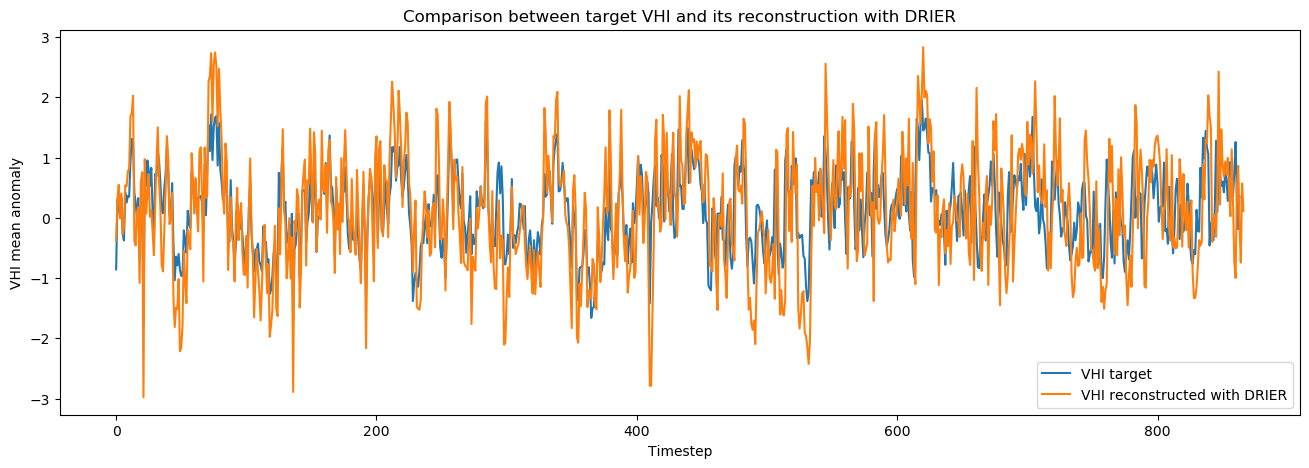

In [63]:
#pd.concat((res_train,res_val,res_test),axis=0)
plt.figure(figsize=(16, 5))
plt.plot(pd.concat((pd.DataFrame(res_train),pd.DataFrame(res_val), pd.DataFrame(res_test)),axis=0).reset_index(drop=True), label="VHI target") #867
plt.plot(pd.concat((targets_df_train.Emiliani1,targets_df_val.Emiliani1,targets_df_test.Emiliani1),axis=0).reset_index(drop=True), label="VHI reconstructed with DRIER")
#plt.plot(ar_all[1:])
plt.title("Comparison between target VHI and its reconstruction with DRIER")
plt.legend()
plt.ylabel("VHI mean anomaly")
plt.xlabel("Timestep")
plt.savefig("/Users/paolo/Downloads/VHIpred.png")
plt.show()


In [18]:
### 1 ### NonLinCFA + CMI
for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Lambro_Olona','Oglio_Iseo','Ticino']]:
    MTL_scores(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)

# 0.6467670731609066, 0.5837979257757202, 0.6150506544447802, 0.6155108450998603
# 0.790407597916781, 0.7242090925077914, 0.7505697767991935, 0.7697240504684202

# 0.5986518801235216, 0.5933392109385226, 0.6040871603807578, 0.5876925264624528
# 0.7387000323353683, 0.7310854674499224, 0.7405025145470655, 0.731739790238489


Adda
0.10103920812541434
0.499624996365322
MAE:  0.6467670731609066
RMSE:  0.790407597916781
Index(['Adda_cyclostationary_mean_tg_2', 'Adda_cyclostationary_mean_rr_8w_0',
       'Adda_cyclostationary_mean_rr_1w_0', 'Adda_cyclostationary_mean_rr_1',
       'Adda'],
      dtype='object') 
 [-0.32401128  0.08710343  0.20895601 -0.0153651   0.        ] 0.09855752861898005
Lambro_Olona
0.257988593738008
0.5150120676347784
MAE:  0.5837979257757202
RMSE:  0.7242090925077914
Index(['Lambro_Olona_cyclostationary_mean_tg_1w_5',
       'Lambro_Olona_cyclostationary_mean_rr_1w_1',
       'Lambro_Olona_cyclostationary_mean_tg_3',
       'Lambro_Olona_cyclostationary_mean_rr_8w_1',
       'Lambro_Olona_cyclostationary_mean_tg_1w_4', 'Lambro_Olona'],
      dtype='object') 
 [-0.36575228  0.1423551  -0.29993115  0.07750549  0.23128244  0.        ] 0.06690175112305699
Oglio_Iseo
0.19993206756174065
0.47948286884282015
MAE:  0.6150506544447802
RMSE:  0.7505697767991935
Index(['Oglio_Iseo_cyclostationary

In [16]:
### 1 ### NonLinCFA + CMI
for clust_basins in [['Emiliani1'],['Emiliani2'],['Garda_Mincio'],['Emiliani1','Emiliani2','Garda_Mincio'],['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Lambro_Olona','Oglio_Iseo','Ticino'],['Piemonte_Nord'],['Piemonte_Sud'],['Dora'],['Piemonte_Nord','Piemonte_Sud','Dora']]:
    MTL_scores(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Emiliani1
0.2860711267941548
0.586602729037454
MAE:  0.5642123216063224
RMSE:  0.7167537595740808
Index(['Emiliani1_cyclostationary_mean_rr_4w_1',
       'Emiliani1_cyclostationary_mean_tg_0',
       'Emiliani1_cyclostationary_mean_rr_1w_16',
       'Emiliani1_cyclostationary_mean_rr_24w_2', 'Emiliani1'],
      dtype='object') 
 [ 0.40700671 -0.32699628  0.07351767  0.12402228  0.        ] 0.018449330268238237
Emiliani2
0.24353431838283113
0.5344501166880027
MAE:  0.5806412006089803
RMSE:  0.7216678656462637
Index(['Emiliani2_cyclostationary_mean_tg_0',
       'Emiliani2_cyclostationary_mean_rr_8w_0',
       'Emiliani2_cyclostationary_mean_tg_4w_0',
       'Emiliani2_cyclostationary_mean_rr_4w_5',
       'Emiliani2_cyclostationary_mean_rr_8w_3', 'Emiliani2'],
      dtype='object') 
 [-0.34525001  0.14258936  0.08755925  0.25275573 -0.05061614  0.        ] 0.05127526813939277
Garda_Mincio
0.1713073084951655
0.5308526726022612
MAE:  0.6673751457293776
RMSE:  0.8303876294737612
Index(['Ga

Piemonte_Sud
0.1372217420831492
0.3753840620065252
MAE:  0.6683145732428545
RMSE:  0.831239919226215
Index(['Piemonte_Sud_cyclostationary_mean_tg_0',
       'Piemonte_Sud_cyclostationary_mean_rr_24w_0',
       'Piemonte_Sud_cyclostationary_mean_rr_8w_1',
       'Piemonte_Sud_cyclostationary_mean_rr_16w_0',
       'Piemonte_Sud_cyclostationary_mean_tg_24w_0', 'Piemonte_Sud'],
      dtype='object') 
 [-0.32616336  0.21432621  0.10993631 -0.07061251  0.07881229  0.        ] 0.07702370738334424
Dora
-0.2598218647983095
-0.03489462913257695
MAE:  0.7070502241532248
RMSE:  0.8951015791416781
Index(['Dora_cyclostationary_mean_tg_0', 'Dora_cyclostationary_mean_rr_4w_1',
       'Dora_cyclostationary_mean_rr_4w_0',
       'Dora_cyclostationary_mean_tg_24w_0', 'Dora'],
      dtype='object') 
 [-0.25950162 -0.04495343  0.21702496  0.037865    0.        ] 0.07921029524185018
Piemonte_Nord
0.025309161703930716
0.2850187234743894
MAE:  0.6958068336465061
RMSE:  0.8662665755116803
Index(['Dora_cyclost

In [15]:
### 1 ### NonLinCFA + CMI
for clust_basins in [['Adda'],['Dora'],['Emiliani1'],['Emiliani2'],['Garda_Mincio'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Piemonte_Nord'],['Piemonte_Sud']]:
    MTL_scores(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
0.10103920812541434
0.499624996365322
0.6467670731609066
Index(['Adda_cyclostationary_mean_tg_2', 'Adda_cyclostationary_mean_rr_8w_0',
       'Adda_cyclostationary_mean_rr_1w_0', 'Adda_cyclostationary_mean_rr_1',
       'Adda'],
      dtype='object') 
 [-0.32401128  0.08710343  0.20895601 -0.0153651   0.        ] 0.09855752861898005
Dora
-0.2598218647983095
-0.03489462913257695
0.7070502241532248
Index(['Dora_cyclostationary_mean_tg_0', 'Dora_cyclostationary_mean_rr_4w_1',
       'Dora_cyclostationary_mean_rr_4w_0',
       'Dora_cyclostationary_mean_tg_24w_0', 'Dora'],
      dtype='object') 
 [-0.25950162 -0.04495343  0.21702496  0.037865    0.        ] 0.07921029524185018
Emiliani1
0.2860711267941548
0.586602729037454
0.5642123216063224
Index(['Emiliani1_cyclostationary_mean_rr_4w_1',
       'Emiliani1_cyclostationary_mean_tg_0',
       'Emiliani1_cyclostationary_mean_rr_1w_16',
       'Emiliani1_cyclostationary_mean_rr_24w_2', 'Emiliani1'],
      dtype='object') 
 [ 0.40700671 -

In [70]:
### 1 ### NonLinCFA + CMI
for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Garda_Mincio'],['Emiliani1'],['Emiliani2'],['Dora'],['Piemonte_Sud'],['Piemonte_Nord']]:
    MTL_scores(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)
for clust_basins in [['Adda','Ticino','Lambro_Olona','Oglio_Iseo'],['Garda_Mincio','Emiliani1','Emiliani2'],['Dora','Piemonte_Sud','Piemonte_Nord']]:
    MTL_scores(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
0.10103920812541434
0.499624996365322
MAE:  0.6467670731609066
RMSE:  0.790407597916781
Index(['Adda_cyclostationary_mean_tg_2', 'Adda_cyclostationary_mean_rr_8w_0',
       'Adda_cyclostationary_mean_rr_1w_0', 'Adda_cyclostationary_mean_rr_1',
       'Adda'],
      dtype='object') 
 [-0.32401128  0.08710343  0.20895601 -0.0153651   0.        ] 0.09855752861898005
Ticino
0.15480738872169852
0.4507222725902471
MAE:  0.6155108450998603
RMSE:  0.7697240504684202
Index(['Ticino_cyclostationary_mean_tg_0',
       'Ticino_cyclostationary_mean_rr_4w_0',
       'Ticino_cyclostationary_mean_tg_2', 'Ticino'],
      dtype='object') 
 [-0.25864992  0.19507379 -0.13204464  0.        ] 0.09084312914047851
Lambro_Olona
0.257988593738008
0.5150120676347784
MAE:  0.5837979257757202
RMSE:  0.7242090925077914
Index(['Lambro_Olona_cyclostationary_mean_tg_1w_5',
       'Lambro_Olona_cyclostationary_mean_rr_1w_1',
       'Lambro_Olona_cyclostationary_mean_tg_3',
       'Lambro_Olona_cyclostationary_mean

Dora
-0.24935390194555018
0.11654508072950724
MAE:  0.7325917614714997
RMSE:  0.891375085966956
Index(['Dora_cyclostationary_mean_tg_0', 'Dora_cyclostationary_mean_rr_4w_1',
       'Dora_cyclostationary_mean_rr_4w_0',
       'Dora_cyclostationary_mean_tg_24w_0',
       'Piemonte_Nord_cyclostationary_mean_tg_1',
       'Piemonte_Nord_cyclostationary_mean_rr_8w_1',
       'Piemonte_Nord_cyclostationary_mean_rr_8w_2',
       'Piemonte_Nord_cyclostationary_mean_rr_1w_3',
       'Piemonte_Nord_cyclostationary_mean_rr_8w_0',
       'Piemonte_Sud_cyclostationary_mean_tg_0',
       'Piemonte_Sud_cyclostationary_mean_rr_24w_0',
       'Piemonte_Sud_cyclostationary_mean_rr_8w_1',
       'Piemonte_Sud_cyclostationary_mean_rr_16w_0',
       'Piemonte_Sud_cyclostationary_mean_tg_24w_0', 'Dora', 'Piemonte_Sud',
       'Piemonte_Nord'],
      dtype='object') 
 [ 0.14257924 -0.01908733  0.08108151  0.56663608 -0.52091718  0.13177417
 -0.46426853  0.06777353  0.3686853   0.06585144  0.27596989  0.01178

In [15]:
### train
r2s_train = []
r2s_val = []
r2s_test = []
r2s_trainval = []
for clust_basins in [['Emiliani1'],['Emiliani2'],['Garda_Mincio'],['Emiliani1','Emiliani2','Garda_Mincio'],['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Lambro_Olona','Oglio_Iseo','Ticino'],['Piemonte_Nord'],['Piemonte_Sud'],['Dora'],['Piemonte_Nord','Piemonte_Sud','Dora']]:
    r2s_train.append(MTL_scores(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_train, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_train))
    r2s_val.append(MTL_scores(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_val, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_val))
    r2s_test.append(MTL_scores(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test))
    r2s_trainval.append(MTL_scores(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=pd.concat((best5_CMI_fulldf_train,best5_CMI_fulldf_val),axis=0).reset_index(drop=True), targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=pd.concat((targets_df_train,targets_df_val),axis=0).reset_index(drop=True)))


Emiliani1
0.25265720136961456
0.5098067260767175
0.6806105119191951
Emiliani1
0.45172158553793584
0.6860381108578133
0.629105686515059
Emiliani1
0.2860711267941548
0.586602729037454
0.5642123216063224
Emiliani1
0.3354591078929168
0.5791883181599201
0.662233203324292
Emiliani2
0.15375274255084304
0.39974932275912106
0.7243992431385852
Emiliani2
0.31520883953303225
0.5738331045305031
0.6625660069766742
Emiliani2
0.24353431838283113
0.5344501166880027
0.5806412006089803
Emiliani2
0.2242689434113071
0.47357042075208544
0.7023366800010019
Garda_Mincio
0.030454905360876472
0.2864866697591202
0.7708068756424137
Garda_Mincio
0.2726324923810871
0.6175543243430853
0.7443029096154461
Garda_Mincio
0.1713073084951655
0.5308526726022612
0.6673751457293776
Garda_Mincio
0.18416277048738983
0.42914190017684106
0.7613500614731671
Emiliani1
0.2763363099150514
0.5264320536058517
0.6690275505118836
Emiliani2
0.1565148626671775
0.4151962210468687
0.7166222393915161
Garda_Mincio
0.09296075098650636
0.3765881

In [16]:
r2s_trainval

[[0.3354591078929168],
 [0.2242689434113071],
 [0.18416277048738983],
 [0.34417354655051946, 0.25212173927298887, 0.2370593434368108],
 [0.1544424050246367],
 [0.17963535378242046],
 [0.23114166571955352],
 [0.14395642022556665],
 [0.20003546302308284,
  0.2427946754423813,
  0.18614028646391267,
  0.2258102946758478],
 [0.195542991329828],
 [0.1460945522676872],
 [0.12958452812394095],
 [0.22782919294311732, 0.2028774730130115, 0.14978574481109286]]

In [76]:
### same with SVR

for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Garda_Mincio'],['Emiliani1'],['Emiliani2'],['Dora'],['Piemonte_Sud'],['Piemonte_Nord']]:
    MTL_scores_SVR(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)
for clust_basins in [['Adda','Ticino','Lambro_Olona','Oglio_Iseo'],['Garda_Mincio','Emiliani1','Emiliani2'],['Dora','Piemonte_Sud','Piemonte_Nord']]:
    MTL_scores_SVR(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
R2:  0.1473206109938726
MAE:  0.6308912338058221
RMSE:  0.7697923906044127
Ticino
R2:  0.16976526363192568
MAE:  0.6223056813444248
RMSE:  0.7628825141482136
Lambro_Olona
R2:  0.2723288544323249
MAE:  0.5740313880380522
RMSE:  0.7171768452775492
Oglio_Iseo
R2:  0.1817060157619521
MAE:  0.6112558271551999
RMSE:  0.7590708607284182
Garda_Mincio
R2:  0.11645898776415076
MAE:  0.6918114273793013
RMSE:  0.8574276277672458
Emiliani1
R2:  0.19901893414411376
MAE:  0.5997702609947835
RMSE:  0.7591955109246455
Emiliani2
R2:  0.036537057922730876
MAE:  0.652566915943466
RMSE:  0.8144421839869004
Dora
R2:  -0.0771354627623162
MAE:  0.706143667049035
RMSE:  0.8276618069498219
Piemonte_Sud
R2:  0.10511520336935654
MAE:  0.6890583012669373
RMSE:  0.8465650994300933
Piemonte_Nord
R2:  0.04876143595612881
MAE:  0.6861646420290125
RMSE:  0.8557813940586576
Adda
R2:  0.15606081314314424
MAE:  0.624367546346153
RMSE:  0.7658369347436622
Ticino
R2:  0.15428385647119125
MAE:  0.6224428611965293
RMSE: 

In [25]:
# train

for clust_basins in [['Emiliani1'],['Emiliani2'],['Garda_Mincio'],['Emiliani1','Emiliani2','Garda_Mincio'],['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Lambro_Olona','Oglio_Iseo','Ticino'],['Piemonte_Nord'],['Piemonte_Sud'],['Dora'],['Piemonte_Nord','Piemonte_Sud','Dora']]:
    MTL_scores_SVR(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=pd.concat((best5_CMI_fulldf_train,best5_CMI_fulldf_val),axis=0).reset_index(drop=True), targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=pd.concat((targets_df_train,targets_df_val),axis=0).reset_index(drop=True))

for clust_basins in [['Emiliani1'],['Emiliani2'],['Garda_Mincio'],['Emiliani1','Emiliani2','Garda_Mincio'],['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Lambro_Olona','Oglio_Iseo','Ticino'],['Piemonte_Nord'],['Piemonte_Sud'],['Dora'],['Piemonte_Nord','Piemonte_Sud','Dora']]:
    MTL_scores_RF(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=pd.concat((best5_CMI_fulldf_train,best5_CMI_fulldf_val),axis=0).reset_index(drop=True), targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=pd.concat((targets_df_train,targets_df_val),axis=0).reset_index(drop=True))

for clust_basins in [['Emiliani1'],['Emiliani2'],['Garda_Mincio'],['Emiliani1','Emiliani2','Garda_Mincio'],['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Lambro_Olona','Oglio_Iseo','Ticino'],['Piemonte_Nord'],['Piemonte_Sud'],['Dora'],['Piemonte_Nord','Piemonte_Sud','Dora']]:
    MTL_scores_FFNN(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=pd.concat((best5_CMI_fulldf_train,best5_CMI_fulldf_val),axis=0).reset_index(drop=True), targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=pd.concat((targets_df_train,targets_df_val),axis=0).reset_index(drop=True))
    

Emiliani1
0.49607086781349363
Emiliani2
0.45917199097357564
Garda_Mincio
0.26876700775887863
Emiliani1
0.6528287737854648
Emiliani2
0.6526170639283011
Garda_Mincio
0.6028004134043672
Adda
0.2438858558952942
Ticino
0.23724786464783976
Lambro_Olona
0.3380346398423453
Oglio_Iseo
0.21107852453707976
Adda
0.4915568275578156
Lambro_Olona
0.4991716041277713
Oglio_Iseo
0.45469693505637665
Ticino
0.48984999881301505
Piemonte_Nord
0.29642296460391315
Piemonte_Sud
0.31430872909609475
Dora
0.41296987634388327
Piemonte_Nord
0.5821629422420849
Piemonte_Sud
0.5851845669389439
Dora
0.6137961794330358
Emiliani1
1.0
Emiliani2
1.0
Garda_Mincio
1.0
Emiliani1
1.0
Emiliani2
1.0
Garda_Mincio
1.0
Adda
1.0
Ticino
1.0
Lambro_Olona
1.0
Oglio_Iseo
1.0
Adda
1.0
Lambro_Olona
1.0
Oglio_Iseo
1.0
Ticino
1.0
Piemonte_Nord
1.0
Piemonte_Sud
1.0
Dora
1.0
Piemonte_Nord
1.0
Piemonte_Sud
1.0
Dora
1.0
Emiliani1
0.3649518065886723
Emiliani2
0.2596540011278201


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Garda_Mincio
0.19653502136533207
Emiliani1


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

0.45019956553520635
Emiliani2
0.39402589540600486
Garda_Mincio
0.35844820265609967
Adda
0.1758136109750038
Ticino
0.20679705579419771
Lambro_Olona
0.2274812093000691
Oglio_Iseo
0.15767611556665573


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

Adda
0.2975737918152346
Lambro_Olona
0.316871770005447
Oglio_Iseo
0.25344335639177706
Ticino
0.3105218774736519
Piemonte_Nord
0.21529282557030216
Piemonte_Sud
0.1300054874178771
Dora
0.20865774710682472
Piemonte_Nord
0.34186903254558754
Piemonte_Sud
0.3151345875334406
Dora
0.3187005368283288


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [77]:
### same with RF

for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Garda_Mincio'],['Emiliani1'],['Emiliani2'],['Dora'],['Piemonte_Sud'],['Piemonte_Nord']]:
    MTL_scores_RF(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)
for clust_basins in [['Adda','Ticino','Lambro_Olona','Oglio_Iseo'],['Garda_Mincio','Emiliani1','Emiliani2'],['Dora','Piemonte_Sud','Piemonte_Nord']]:
    MTL_scores_RF(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
R2:  -0.056560938752404866
MAE:  0.7040334406883407
RMSE:  0.8568957847817096
Ticino
R2:  0.05742779557397337
MAE:  0.6670842964864961
RMSE:  0.8128577017804012
Lambro_Olona
R2:  0.18069977598967168
MAE:  0.6150251406241173
RMSE:  0.7609922243185846
Oglio_Iseo
R2:  0.08325031210683775
MAE:  0.6416419365428034
RMSE:  0.8034392165356319
Garda_Mincio
R2:  -0.17316371103793848
MAE:  0.8013230272771923
RMSE:  0.9880147467004348
Emiliani1
R2:  0.15010751599312777
MAE:  0.6258796156564196
RMSE:  0.7820319575072758
Emiliani2
R2:  0.17126708509943012
MAE:  0.6177247284772006
RMSE:  0.7553531530749229
Dora
R2:  -0.1726838882183157
MAE:  0.7082967972173659
RMSE:  0.8635912467680309
Piemonte_Sud
R2:  0.0003243544885948024
MAE:  0.726112132145407
RMSE:  0.8947595681213718
Piemonte_Nord
R2:  0.04954045200804624
MAE:  0.6722904052844765
RMSE:  0.8554309015451507
Adda
R2:  0.1566283528004634
MAE:  0.6242749888804732
RMSE:  0.765579383052754
Ticino
R2:  0.19428789622516818
MAE:  0.6055457429144768

In [78]:
### same with FFNN

for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Garda_Mincio'],['Emiliani1'],['Emiliani2'],['Dora'],['Piemonte_Sud'],['Piemonte_Nord']]:
    MTL_scores_FFNN(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)
for clust_basins in [['Adda','Ticino','Lambro_Olona','Oglio_Iseo'],['Garda_Mincio','Emiliani1','Emiliani2'],['Dora','Piemonte_Sud','Piemonte_Nord']]:
    MTL_scores_FFNN(clust_basins=clust_basins, df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
R2:  0.0929379606239561
MAE:  0.6532700645588871
RMSE:  0.793961104366298
Ticino
R2:  0.13150165666223956
MAE:  0.6289932707986226
RMSE:  0.7802642480245554
Lambro_Olona
R2:  0.2174209930124329
MAE:  0.6046265838321514
RMSE:  0.7437428082019907
Oglio_Iseo
R2:  0.2058634822693468
MAE:  0.6049771931924306
RMSE:  0.7477823743607529


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Garda_Mincio
R2:  0.150938677589596
MAE:  0.6816301103795213
RMSE:  0.8405308254274998
Emiliani1
R2:  0.3240508366974555
MAE:  0.5569196840368964
RMSE:  0.6974282322343888
Emiliani2
R2:  0.09586995318546865
MAE:  0.6438076261172674
RMSE:  0.7889658466156637
Dora
R2:  -0.030258761368924025
MAE:  0.6620855591091613
RMSE:  0.8094516465383516


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

Piemonte_Sud
R2:  0.1311991891962755
MAE:  0.6785486931713943
RMSE:  0.8341360749708578
Piemonte_Nord
R2:  0.14296932295389775
MAE:  0.659220669804837
RMSE:  0.8122997124989405


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Adda
R2:  0.24705618056480805
MAE:  0.5894164035166694
RMSE:  0.7233725383734282
Ticino
R2:  0.23161011903350948
MAE:  0.5932966034194471
RMSE:  0.7339188277919082
Lambro_Olona
R2:  0.24113925978977346
MAE:  0.6013712325614966
RMSE:  0.7323854790690909
Oglio_Iseo
R2:  0.2360850317897436
MAE:  0.5944961127113383
RMSE:  0.7334156123952752
Garda_Mincio
R2:  0.18053207559871243
MAE:  0.6664192583070715
RMSE:  0.8257528778685126
Emiliani1
R2:  0.23584346661556888
MAE:  0.5914393809474278
RMSE:  0.741538444712366
Emiliani2
R2:  0.24267422418714235
MAE:  0.5832267666141986
RMSE:  0.7220780138027634
Dora
R2:  -0.08166546875450509
MAE:  0.6847746139374992
RMSE:  0.8294003901225054
Piemonte_Sud
R2:  0.08569342977997507
MAE:  0.6938221710571962
RMSE:  0.8557023321758704
Piemonte_Nord
R2:  0.059415312274888055
MAE:  0.6720946839623442
RMSE:  0.8509755219339769


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [85]:
### 2 ### NonLinCFA + Wrapper
for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Ticino','Lambro_Olona','Oglio_Iseo'],['Garda_Mincio'],['Emiliani1'],['Emiliani2'],['Dora'],['Piemonte_Sud'],['Piemonte_Nord'],['Garda_Mincio','Emiliani1','Emiliani2'],['Dora','Piemonte_Sud','Piemonte_Nord']]:
    MTL_scores(clust_basins=clust_basins, df_train=best5_wrapper_fulldf_train, df_val=best5_wrapper_fulldf_val, df_test=best5_wrapper_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
R2:  0.09056594814663488
MAE:  0.6427763434204101
RMSE:  0.794998550511167
Ticino
R2:  0.21528805474868118
MAE:  0.5997855201361417
RMSE:  0.7416727837098127
Lambro_Olona
R2:  0.19477414670453563
MAE:  0.6124440508188347
RMSE:  0.7544275467223333
Oglio_Iseo
R2:  0.2756897001667614
MAE:  0.5864971438997398
RMSE:  0.7141508727888889
Adda
R2:  0.07916105260683326
MAE:  0.6412997636280043
RMSE:  0.7999679191692728
Ticino
R2:  0.0748211476813212
MAE:  0.6504624730148385
RMSE:  0.8053229193875667
Lambro_Olona
R2:  -0.05666978226864505
MAE:  0.6977727530386135
RMSE:  0.8642279872876455
Oglio_Iseo
R2:  0.08746721831795878
MAE:  0.6316738495170088
RMSE:  0.8015892388621692
Garda_Mincio
R2:  0.21027323651027574
MAE:  0.644634084650932
RMSE:  0.81062976177472
Emiliani1
R2:  0.23936597704485651
MAE:  0.5978838259707061
RMSE:  0.7398273462966461
Emiliani2
R2:  0.2711938330621153
MAE:  0.5666502898187366
RMSE:  0.7083514247958497
Dora
R2:  -0.07008057178805882
MAE:  0.6604447753504457
RMSE:  0.

In [86]:
### 3 ### Only NonLinCFA 
for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Ticino','Lambro_Olona','Oglio_Iseo'],['Garda_Mincio'],['Emiliani1'],['Emiliani2'],['Dora'],['Piemonte_Sud'],['Piemonte_Nord'],['Garda_Mincio','Emiliani1','Emiliani2'],['Dora','Piemonte_Sud','Piemonte_Nord']]:
    MTL_scores(clust_basins=clust_basins, df_train=fulldf_onlyNonLinCFA_train, df_val=fulldf_onlyNonLinCFA_val, df_test=fulldf_onlyNonLinCFA_test.loc[:227,:], targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
R2:  -0.2265596078067722
MAE:  0.743589659204977
RMSE:  0.9232622113412956
Ticino
R2:  0.1745086256475996
MAE:  0.6219009629487353
RMSE:  0.7607001124996469
Lambro_Olona
R2:  0.021620181305453512
MAE:  0.6682289642592821
RMSE:  0.8315960644502188
Oglio_Iseo
R2:  0.23110613190394558
MAE:  0.5972764146100955
RMSE:  0.7358017891561587
Adda
R2:  -1.119153105672945
MAE:  0.9800548504234274
RMSE:  1.2135618032228577
Ticino
R2:  -0.9978396066925619
MAE:  0.9645785073565966
RMSE:  1.1834162269205515
Lambro_Olona
R2:  -1.1330538849687652
MAE:  0.9986560395986032
RMSE:  1.227890376966633
Oglio_Iseo
R2:  -1.260259146361875
MAE:  1.0249823223067374
RMSE:  1.2615566536315643
Garda_Mincio
R2:  -0.07453489840494099
MAE:  0.7884625908899178
RMSE:  0.9455715108563842
Emiliani1
R2:  -0.6701229451054209
MAE:  0.8742487659120184
RMSE:  1.0962679760423515
Emiliani2
R2:  0.23850225854427953
MAE:  0.5665677785170684
RMSE:  0.7240641783743316
Dora
R2:  -0.39677806385440495
MAE:  0.7492730767978698
RMSE: 

### Averages

In [87]:
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona',
          'Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']

path_target = "/Users/paolo/Documents/Droughts/Veronica/VHI_target/"
path_features = '/Users/paolo/Documents/Droughts/Veronica/final_features_allcoord/temp_prec/'

fulldf_averages_train = pd.DataFrame()
fulldf_averages_val = pd.DataFrame()
fulldf_averages_test = pd.DataFrame()

for basin in basins:
    
    print('####################' + basin + '####################')
    target_df_train, target_df_val, target_df_test, target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
        path=path_target+basin+'.csv', window_size = 1)

    actual_path = path_features+basin+'_aggreg.csv'
        
    df = pd.read_csv(actual_path).groupby(["date"]).mean()
    
    df = df.loc[:,['cyclostationary_mean_tg',
                                                                            'cyclostationary_mean_tg_1w',
                                                                            'cyclostationary_mean_tg_4w',
                                                                            'cyclostationary_mean_tg_8w',
                                                                            'cyclostationary_mean_tg_12w',
                                                                            'cyclostationary_mean_tg_16w',
                                                                            'cyclostationary_mean_tg_24w',
                                                                            'cyclostationary_mean_rr',
                                                                            'cyclostationary_mean_rr_1w',
                                                                            'cyclostationary_mean_rr_4w',
                                                                            'cyclostationary_mean_rr_8w',
                                                                            'cyclostationary_mean_rr_12w',
                                                                            'cyclostationary_mean_rr_16w',
                                                                            'cyclostationary_mean_rr_24w'
                                                                            ]]
    
    aggregate_trainVal = df.iloc[:639,:].reset_index(drop=True)
    aggregate_test = df.iloc[639:867,:].reset_index(drop=True)
    
    #output, aggregate_trainVal, aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg',
    #                                                                        'cyclostationary_mean_tg_1w',
    #                                                                        'cyclostationary_mean_tg_4w',
    #                                                                        'cyclostationary_mean_tg_8w',
    #                                                                        'cyclostationary_mean_tg_12w',
    #                                                                        'cyclostationary_mean_tg_16w',
    #                                                                        'cyclostationary_mean_tg_24w',
    #                                                                        'cyclostationary_mean_rr',
    #                                                                        'cyclostationary_mean_rr_1w',
    #                                                                        'cyclostationary_mean_rr_4w',
    #                                                                        'cyclostationary_mean_rr_8w',
    #                                                                        'cyclostationary_mean_rr_12w',
    #                                                                        'cyclostationary_mean_rr_16w',
    #                                                                        'cyclostationary_mean_rr_24w'
    #                                                                        ],
    #                                                                  target_df_trainVal, eps=eps,
    #                                                                  max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
    aggregate_trainVal = aggregate_trainVal.add_prefix(basin+'_')
    aggregate_test = aggregate_test.add_prefix(basin+'_')
    
    fulldf_averages_train = pd.concat((fulldf_averages_train,aggregate_trainVal.iloc[:411,:].reset_index(drop=True)),axis=1)
    fulldf_averages_val = pd.concat((fulldf_averages_val,aggregate_trainVal.iloc[411:,:].reset_index(drop=True)),axis=1)
    fulldf_averages_test = pd.concat((fulldf_averages_test,aggregate_test),axis=1)


####################Adda####################
####################Dora####################
####################Emiliani1####################
####################Emiliani2####################
####################Garda_Mincio####################
####################Lambro_Olona####################
####################Oglio_Iseo####################
####################Piemonte_Nord####################
####################Piemonte_Sud####################
####################Ticino####################


In [89]:
### 1 ### Only Averages 
for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Ticino','Lambro_Olona','Oglio_Iseo'],['Garda_Mincio'],['Emiliani1'],['Emiliani2'],['Dora'],['Piemonte_Sud'],['Piemonte_Nord'],['Garda_Mincio','Emiliani1','Emiliani2'],['Dora','Piemonte_Sud','Piemonte_Nord']]:
    MTL_scores(clust_basins=clust_basins, df_train=fulldf_averages_train, df_val=fulldf_averages_val, df_test=fulldf_averages_test.loc[:227,:], targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
R2:  0.15188026216897565
MAE:  0.6292197231317861
RMSE:  0.7677314226899826
Ticino
R2:  0.18597011304788968
MAE:  0.6058466996528888
RMSE:  0.7554007049422751
Lambro_Olona
R2:  0.2819013685058267
MAE:  0.5736859594159945
RMSE:  0.7124439978203483
Oglio_Iseo
R2:  0.2369391089291506
MAE:  0.5958199678234477
RMSE:  0.7330055087100656
Adda
R2:  -0.09479076544491094
MAE:  0.6874330161504286
RMSE:  0.8722606763477441
Ticino
R2:  -0.016825378223764176
MAE:  0.6669146010422533
RMSE:  0.8442681369745476
Lambro_Olona
R2:  -0.02746387656199234
MAE:  0.6750512284763254
RMSE:  0.8522008507575689
Oglio_Iseo
R2:  -0.07926252985742721
MAE:  0.7020870800324743
RMSE:  0.8717484632940531
Garda_Mincio
R2:  0.14924494546538403
MAE:  0.6810600323271816
RMSE:  0.8413687653698232
Emiliani1
R2:  0.3284476001740626
MAE:  0.5524707378307333
RMSE:  0.6951562938386375
Emiliani2
R2:  0.24962811712559874
MAE:  0.574060053108406
RMSE:  0.7187552476398676
Dora
R2:  -0.18169045784160942
MAE:  0.6987344371284738
RM

In [90]:
selected_colnames = []
for basin in basins:
    colnames = [x for x in fulldf_averages_train.columns if x.startswith((basin))]
    print(colnames)
    selected_colnames_curr = FS_with_linearWrapper(pd.concat((fulldf_averages_train.loc[:,colnames],fulldf_averages_val.loc[:,colnames]),axis=0).reset_index(drop=True), target_df_train, target_df_val, min(50,fulldf_averages_train.loc[:,colnames].shape[1]-1), 228)
    selected_colnames = selected_colnames + selected_colnames_curr

['Adda_cyclostationary_mean_tg', 'Adda_cyclostationary_mean_tg_1w', 'Adda_cyclostationary_mean_tg_4w', 'Adda_cyclostationary_mean_tg_8w', 'Adda_cyclostationary_mean_tg_12w', 'Adda_cyclostationary_mean_tg_16w', 'Adda_cyclostationary_mean_tg_24w', 'Adda_cyclostationary_mean_rr', 'Adda_cyclostationary_mean_rr_1w', 'Adda_cyclostationary_mean_rr_4w', 'Adda_cyclostationary_mean_rr_8w', 'Adda_cyclostationary_mean_rr_12w', 'Adda_cyclostationary_mean_rr_16w', 'Adda_cyclostationary_mean_rr_24w']


selected columns: ['Adda_cyclostationary_mean_tg_1w', 'Adda_cyclostationary_mean_rr_1w', 'Adda_cyclostationary_mean_tg_24w', 'Adda_cyclostationary_mean_rr_8w', 'Adda_cyclostationary_mean_rr_24w'], 

validation score: 0.23640251481243812, 

number of selected features: 5
['Dora_cyclostationary_mean_tg', 'Dora_cyclostationary_mean_tg_1w', 'Dora_cyclostationary_mean_tg_4w', 'Dora_cyclostationary_mean_tg_8w', 'Dora_cyclostationary_mean_tg_12w', 'Dora_cyclostationary_mean_tg_16w', 'Dora_cyclostationary_mean



selected columns: ['Ticino_cyclostationary_mean_tg_1w', 'Ticino_cyclostationary_mean_rr_1w', 'Ticino_cyclostationary_mean_tg_24w', 'Ticino_cyclostationary_mean_rr_8w', 'Ticino_cyclostationary_mean_rr_24w'], 

validation score: 0.24028764573333505, 

number of selected features: 5


In [91]:
### 2 ### Averages + Wrapper
for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Ticino','Lambro_Olona','Oglio_Iseo'],['Garda_Mincio'],['Emiliani1'],['Emiliani2'],['Dora'],['Piemonte_Sud'],['Piemonte_Nord'],['Garda_Mincio','Emiliani1','Emiliani2'],['Dora','Piemonte_Sud','Piemonte_Nord']]:
    MTL_scores(clust_basins=clust_basins, df_train=fulldf_averages_train.loc[:,selected_colnames], df_val=fulldf_averages_val.loc[:,selected_colnames], df_test=fulldf_averages_test.loc[:227,selected_colnames], targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
R2:  0.18803334468431931
MAE:  0.6189681124208996
RMSE:  0.751190052841942
Ticino
R2:  0.18660895071551575
MAE:  0.6109306547420861
RMSE:  0.7551042335538549
Lambro_Olona
R2:  0.2657553752530908
MAE:  0.5751176108780807
RMSE:  0.7204089014371218
Oglio_Iseo
R2:  0.2581283647436884
MAE:  0.6018667026559721
RMSE:  0.7227565298928977
Adda
R2:  0.15447681800840352
MAE:  0.6200240586515061
RMSE:  0.7665553000717823
Ticino
R2:  0.17436128772792292
MAE:  0.6048065574944881
RMSE:  0.7607679962927733
Lambro_Olona
R2:  0.2018249738567941
MAE:  0.6011753326045512
RMSE:  0.7511172742392646
Oglio_Iseo
R2:  0.1973081560721558
MAE:  0.615955769897175
RMSE:  0.7517995577239291
Garda_Mincio
R2:  0.10133510529704304
MAE:  0.7065418579900996
RMSE:  0.8647349352496421
Emiliani1
R2:  0.263220514305354
MAE:  0.576881787839628
RMSE:  0.7281339300371332
Emiliani2
R2:  0.2877569876592845
MAE:  0.560696665566154
RMSE:  0.7002560197919416
Dora
R2:  -0.17174812409502604
MAE:  0.6824729908026991
RMSE:  0.86324

In [92]:
selected_colnames = []
for basin in basins:
    colnames = [x for x in fulldf_averages_train.columns if x.startswith((basin))]
    print(colnames)
    
    res = {
          "delta" : [],
          "numSelected" : [],
          "selectedFeatures" : []
      }
    
    aggregate_trainVal = pd.concat((fulldf_averages_train.loc[:,colnames],fulldf_averages_val.loc[:,colnames]),axis=0).reset_index(drop=True)

    res['selectedFeatures'] = forwardFeatureSelection(10, np.array(aggregate_trainVal),
                                                    np.array(target_df_trainVal.mean_std),res,10,1)

    selectedFeatures='selectedFeatures'
    print(f'\n{res[selectedFeatures]}\n')

    selected_colnames_curr = list(aggregate_trainVal.columns[res['selectedFeatures']])

    #selected_colnames_curr = FS_with_linearWrapper(pd.concat((fulldf_averages_train.loc[:,colnames],fulldf_averages_val.loc[:,colnames]),axis=0).reset_index(drop=True), target_df_train, target_df_val, min(50,fulldf_averages_train.loc[:,colnames].shape[1]-1), 228)
    selected_colnames = selected_colnames + selected_colnames_curr

['Adda_cyclostationary_mean_tg', 'Adda_cyclostationary_mean_tg_1w', 'Adda_cyclostationary_mean_tg_4w', 'Adda_cyclostationary_mean_tg_8w', 'Adda_cyclostationary_mean_tg_12w', 'Adda_cyclostationary_mean_tg_16w', 'Adda_cyclostationary_mean_tg_24w', 'Adda_cyclostationary_mean_rr', 'Adda_cyclostationary_mean_rr_1w', 'Adda_cyclostationary_mean_rr_4w', 'Adda_cyclostationary_mean_rr_8w', 'Adda_cyclostationary_mean_rr_12w', 'Adda_cyclostationary_mean_rr_16w', 'Adda_cyclostationary_mean_rr_24w']
----- MI Scores -----
[(0, 0.1105939461369749), (1, 0.08297808767967776), (9, 0.0826433740941452), (8, 0.07432712425813687), (2, 0.07003293533150211), (10, 0.059626334003486395), (7, 0.03976096843642825), (6, 0.028289763874970834), (13, 0.02246643233589946), (12, 0.015778538625886535), (3, 0.012760370709750888), (4, 0.010351736888478428), (11, 0.00870205671751376), (5, 0.0073458770466477055)]
Best MI score: 0.1105939461369749
Adding first best original feature: 0
CMI: 0.010023222300484802
CMI: 0.02567046

CMI: 0.0343722937987897
CMI: 0.019302396794629473
CMI: 0.008628263497181848
Highest CMI score: 0.0343722937987897
Adding original feature: 8
Highest CMI score: -0.0015884134341420941

[0, 8]

['Oglio_Iseo_cyclostationary_mean_tg', 'Oglio_Iseo_cyclostationary_mean_tg_1w', 'Oglio_Iseo_cyclostationary_mean_tg_4w', 'Oglio_Iseo_cyclostationary_mean_tg_8w', 'Oglio_Iseo_cyclostationary_mean_tg_12w', 'Oglio_Iseo_cyclostationary_mean_tg_16w', 'Oglio_Iseo_cyclostationary_mean_tg_24w', 'Oglio_Iseo_cyclostationary_mean_rr', 'Oglio_Iseo_cyclostationary_mean_rr_1w', 'Oglio_Iseo_cyclostationary_mean_rr_4w', 'Oglio_Iseo_cyclostationary_mean_rr_8w', 'Oglio_Iseo_cyclostationary_mean_rr_12w', 'Oglio_Iseo_cyclostationary_mean_rr_16w', 'Oglio_Iseo_cyclostationary_mean_rr_24w']
----- MI Scores -----
[(0, 0.1193155148652461), (1, 0.0799152140618355), (8, 0.0707627233626705), (10, 0.044308680983470586), (6, 0.039736770062899864), (5, 0.03953494510098103), (9, 0.037422564031424736), (4, 0.03353536894424908), (

In [93]:
### 3 ### Averages + CMI
for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Ticino','Lambro_Olona','Oglio_Iseo'],['Garda_Mincio'],['Emiliani1'],['Emiliani2'],['Garda_Mincio','Emiliani1','Emiliani2'],['Dora'],['Piemonte_Sud'],['Piemonte_Nord'],['Dora','Piemonte_Sud','Piemonte_Nord']]:
    MTL_scores(clust_basins=clust_basins, df_train=fulldf_averages_train.loc[:,selected_colnames], df_val=fulldf_averages_val.loc[:,selected_colnames], df_test=fulldf_averages_test.loc[:227,selected_colnames], targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
R2:  0.15991323175748173
MAE:  0.6356819176294716
RMSE:  0.7640869869214356
Ticino
R2:  0.14717641540586757
MAE:  0.616015217821734
RMSE:  0.7731910384008979
Lambro_Olona
R2:  0.20167636565953972
MAE:  0.6039071206656844
RMSE:  0.7511871943603443
Oglio_Iseo
R2:  0.18581267990957195
MAE:  0.616702599034539
RMSE:  0.7571637405332772
Adda
R2:  0.1914729862311645
MAE:  0.6159610538047043
RMSE:  0.7495972739391116
Ticino
R2:  0.22358263739000184
MAE:  0.5902452558461654
RMSE:  0.7377425457551091
Lambro_Olona
R2:  0.2570023926199575
MAE:  0.5917875585575733
RMSE:  0.7246902028072593
Oglio_Iseo
R2:  0.22921299575443366
MAE:  0.6098825071736191
RMSE:  0.7367070614236791
Garda_Mincio
R2:  0.13784162407527478
MAE:  0.6885002485208279
RMSE:  0.8469887506993793
Emiliani1
R2:  0.28845905368186053
MAE:  0.5659812167935181
RMSE:  0.7155540678215155
Emiliani2
R2:  0.19739268046440483
MAE:  0.5948632911144985
RMSE:  0.7433516510854734
Garda_Mincio
R2:  0.16969510021175083
MAE:  0.6691649314441639


### Original pixels

In [94]:
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona',
          'Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']

path_target = "/Users/paolo/Documents/Droughts/Veronica/VHI_target/"
path_features = '/Users/paolo/Documents/Droughts/Veronica/final_features_allcoord/temp_prec/'


fulldf_originalPixel_train = pd.DataFrame()
fulldf_originalPixel_val = pd.DataFrame()
fulldf_originalPixel_test = pd.DataFrame()

for basin in basins:
    
    print('####################' + basin + '####################')
    target_df_train, target_df_val, target_df_test, target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
        path=path_target+basin+'.csv', window_size = 1)
    eps = -10000

    actual_path = path_features+basin+'_aggreg.csv'
    output, aggregate_trainVal, aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg',
                                                                            'cyclostationary_mean_tg_1w',
                                                                            'cyclostationary_mean_tg_4w',
                                                                            'cyclostationary_mean_tg_8w',
                                                                            'cyclostationary_mean_tg_12w',
                                                                            'cyclostationary_mean_tg_16w',
                                                                            'cyclostationary_mean_tg_24w',
                                                                            'cyclostationary_mean_rr',
                                                                            'cyclostationary_mean_rr_1w',
                                                                            'cyclostationary_mean_rr_4w',
                                                                            'cyclostationary_mean_rr_8w',
                                                                            'cyclostationary_mean_rr_12w',
                                                                            'cyclostationary_mean_rr_16w',
                                                                            'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                      target_df_trainVal, eps=eps,
                                                                      max_train='2010-01-01', max_val='2015-01-01', max_test='2030-01-01')
    aggregate_trainVal = aggregate_trainVal.add_prefix(basin+'_')
    aggregate_test = aggregate_test.add_prefix(basin+'_')
    
    fulldf_originalPixel_train = pd.concat((fulldf_originalPixel_train,aggregate_trainVal.iloc[:411,:].reset_index(drop=True)),axis=1)
    fulldf_originalPixel_val = pd.concat((fulldf_originalPixel_val,aggregate_trainVal.iloc[411:,:].reset_index(drop=True)),axis=1)
    fulldf_originalPixel_test = pd.concat((fulldf_originalPixel_test,aggregate_test),axis=1)


####################Adda####################
Number of features: 92

eps value:  -108.69565217391305
Number of aggregated features: 92

Number of features: 92

eps value:  -108.69565217391305
Number of aggregated features: 92

Number of features: 92

eps value:  -108.69565217391305
Number of aggregated features: 92

Number of features: 92

eps value:  -108.69565217391305
Number of aggregated features: 92

Number of features: 92

eps value:  -108.69565217391305
Number of aggregated features: 92

Number of features: 92

eps value:  -108.69565217391305
Number of aggregated features: 92

Number of features: 92

eps value:  -108.69565217391305
Number of aggregated features: 92

Number of features: 92

eps value:  -108.69565217391305
Number of aggregated features: 92

Number of features: 92

eps value:  -108.69565217391305
Number of aggregated features: 92

Number of features: 92

eps value:  -108.69565217391305
Number of aggregated features: 92

Number of features: 92

eps value:  -108.6956

Number of aggregated features: 74

Number of features: 74

eps value:  -135.13513513513513
Number of aggregated features: 74

Number of features: 74

eps value:  -135.13513513513513
Number of aggregated features: 74

Number of features: 74

eps value:  -135.13513513513513
Number of aggregated features: 74

Number of features: 74

eps value:  -135.13513513513513
Number of aggregated features: 74

Number of features: 74

eps value:  -135.13513513513513
Number of aggregated features: 74

Number of features: 74

eps value:  -135.13513513513513
Number of aggregated features: 74

Number of features: 74

eps value:  -135.13513513513513
Number of aggregated features: 74

Number of features: 74

eps value:  -135.13513513513513
Number of aggregated features: 74

Number of features: 74

eps value:  -135.13513513513513
Number of aggregated features: 74

Number of features: 74

eps value:  -135.13513513513513
Number of aggregated features: 74

Number of features: 74

eps value:  -135.13513513513513

In [96]:
### 1 ### Only pixels 
for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Ticino','Lambro_Olona','Oglio_Iseo'],['Garda_Mincio'],['Emiliani1'],['Emiliani2'],['Dora'],['Piemonte_Sud'],['Piemonte_Nord'],['Garda_Mincio','Emiliani1','Emiliani2'],['Dora','Piemonte_Sud','Piemonte_Nord']]:
    MTL_scores(clust_basins=clust_basins, df_train=fulldf_originalPixel_train, df_val=fulldf_originalPixel_val, df_test=fulldf_originalPixel_test.loc[:227,:], targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
R2:  -215.8442929121091
MAE:  9.6156222713492
RMSE:  12.275939216128789
Ticino
R2:  -107.80498354769347
MAE:  7.333178490770559
RMSE:  8.733364862195103
Lambro_Olona
R2:  -157.63911560662072
MAE:  8.947875201342223
RMSE:  10.589216373051162
Oglio_Iseo
R2:  -52.64868536220697
MAE:  4.980819428106875
RMSE:  6.146207000162853
Adda
R2:  -3.943276085435914e+21
MAE:  41612603631.20342
RMSE:  52349112537.284424
Ticino
R2:  -3.9093470450204667e+21
MAE:  41612603631.23159
RMSE:  52349112537.29463
Lambro_Olona
R2:  -3.8770489321554785e+21
MAE:  41612603631.2572
RMSE:  52349112537.30689
Oglio_Iseo
R2:  -3.891915169544288e+21
MAE:  41612603631.17787
RMSE:  52349112537.25288
Garda_Mincio
R2:  -264.85282284176344
MAE:  12.662292733128703
RMSE:  14.873211523389115
Emiliani1
R2:  -13.920973897498545
MAE:  2.6145907191302613
RMSE:  3.276733277730636
Emiliani2
R2:  -8.248594013473118
MAE:  2.0110633937569933
RMSE:  2.5233681097851846
Dora
R2:  -554.2996491206108
MAE:  14.30528725660175
RMSE:  18.79

In [97]:
selected_colnames = []
for basin in basins:
    colnames = [x for x in fulldf_originalPixel_train.columns if x.startswith((basin))]
    print(colnames)
    selected_colnames_curr = FS_with_linearWrapper(pd.concat((fulldf_originalPixel_train.loc[:,colnames],fulldf_originalPixel_val.loc[:,colnames]),axis=0).reset_index(drop=True), target_df_train, target_df_val, min(50,fulldf_originalPixel_train.loc[:,colnames].shape[1]-1), 228)
    selected_colnames = selected_colnames + selected_colnames_curr

['Adda_cyclostationary_mean_tg_0', 'Adda_cyclostationary_mean_tg_1', 'Adda_cyclostationary_mean_tg_2', 'Adda_cyclostationary_mean_tg_3', 'Adda_cyclostationary_mean_tg_4', 'Adda_cyclostationary_mean_tg_5', 'Adda_cyclostationary_mean_tg_6', 'Adda_cyclostationary_mean_tg_7', 'Adda_cyclostationary_mean_tg_8', 'Adda_cyclostationary_mean_tg_9', 'Adda_cyclostationary_mean_tg_10', 'Adda_cyclostationary_mean_tg_11', 'Adda_cyclostationary_mean_tg_12', 'Adda_cyclostationary_mean_tg_13', 'Adda_cyclostationary_mean_tg_14', 'Adda_cyclostationary_mean_tg_15', 'Adda_cyclostationary_mean_tg_16', 'Adda_cyclostationary_mean_tg_17', 'Adda_cyclostationary_mean_tg_18', 'Adda_cyclostationary_mean_tg_19', 'Adda_cyclostationary_mean_tg_20', 'Adda_cyclostationary_mean_tg_21', 'Adda_cyclostationary_mean_tg_22', 'Adda_cyclostationary_mean_tg_23', 'Adda_cyclostationary_mean_tg_24', 'Adda_cyclostationary_mean_tg_25', 'Adda_cyclostationary_mean_tg_26', 'Adda_cyclostationary_mean_tg_27', 'Adda_cyclostationary_mean_tg



selected columns: ['Adda_cyclostationary_mean_tg_1w_20', 'Adda_cyclostationary_mean_rr_1w_24', 'Adda_cyclostationary_mean_tg_1w_43', 'Adda_cyclostationary_mean_tg_24w_53', 'Adda_cyclostationary_mean_tg_24w_84', 'Adda_cyclostationary_mean_tg_1w_31', 'Adda_cyclostationary_mean_rr_8w_19', 'Adda_cyclostationary_mean_rr_16w_42', 'Adda_cyclostationary_mean_rr_8w_11', 'Adda_cyclostationary_mean_tg_1w_55', 'Adda_cyclostationary_mean_tg_1w_66', 'Adda_cyclostationary_mean_rr_8w_36', 'Adda_cyclostationary_mean_rr_24w_55', 'Adda_cyclostationary_mean_rr_1w_55', 'Adda_cyclostationary_mean_rr_16w_61', 'Adda_cyclostationary_mean_tg_1w_73', 'Adda_cyclostationary_mean_rr_1w_46', 'Adda_cyclostationary_mean_rr_1w_19', 'Adda_cyclostationary_mean_rr_1w_63', 'Adda_cyclostationary_mean_rr_1w_41', 'Adda_cyclostationary_mean_tg_24w_54', 'Adda_cyclostationary_mean_tg_1w_75', 'Adda_cyclostationary_mean_rr_8w_6', 'Adda_cyclostationary_mean_tg_1w_24', 'Adda_cyclostationary_mean_tg_1w_35', 'Adda_cyclostationary_me



selected columns: ['Dora_cyclostationary_mean_tg_1w_7', 'Dora_cyclostationary_mean_rr_4w_11', 'Dora_cyclostationary_mean_tg_1w_25', 'Dora_cyclostationary_mean_tg_12w_22', 'Dora_cyclostationary_mean_tg_12w_15', 'Dora_cyclostationary_mean_rr_12w_18', 'Dora_cyclostationary_mean_rr_8w_11', 'Dora_cyclostationary_mean_rr_1w_7', 'Dora_cyclostationary_mean_tg_12w_9', 'Dora_cyclostationary_mean_tg_12w_31', 'Dora_cyclostationary_mean_rr_1w_18', 'Dora_cyclostationary_mean_rr_24w_19', 'Dora_cyclostationary_mean_rr_16w_18', 'Dora_cyclostationary_mean_tg_12w_33', 'Dora_cyclostationary_mean_rr_24w_23', 'Dora_cyclostationary_mean_rr_8w_29', 'Dora_cyclostationary_mean_rr_1w_2', 'Dora_cyclostationary_mean_rr_1w_4', 'Dora_cyclostationary_mean_tg_4w_30', 'Dora_cyclostationary_mean_tg_4w_20', 'Dora_cyclostationary_mean_tg_16w_25', 'Dora_cyclostationary_mean_tg_16w_34', 'Dora_cyclostationary_mean_tg_12w_25', 'Dora_cyclostationary_mean_tg_16w_13', 'Dora_cyclostationary_mean_rr_4w_13', 'Dora_cyclostationary



selected columns: ['Emiliani1_cyclostationary_mean_tg_1w_62', 'Emiliani1_cyclostationary_mean_rr_4w_110', 'Emiliani1_cyclostationary_mean_rr_8w_167', 'Emiliani1_cyclostationary_mean_rr_8w_130', 'Emiliani1_cyclostationary_mean_rr_8w_121', 'Emiliani1_cyclostationary_mean_rr_16w_46', 'Emiliani1_cyclostationary_mean_tg_1w_16', 'Emiliani1_cyclostationary_mean_tg_1w_18', 'Emiliani1_cyclostationary_mean_rr_4w_60', 'Emiliani1_cyclostationary_mean_rr_4w_32', 'Emiliani1_cyclostationary_mean_rr_1w_63', 'Emiliani1_cyclostationary_mean_rr_4w_5', 'Emiliani1_cyclostationary_mean_tg_1w_66', 'Emiliani1_cyclostationary_mean_tg_1w_159', 'Emiliani1_cyclostationary_mean_tg_1w_123', 'Emiliani1_cyclostationary_mean_rr_8w_157', 'Emiliani1_cyclostationary_mean_rr_16w_104', 'Emiliani1_cyclostationary_mean_rr_24w_75', 'Emiliani1_cyclostationary_mean_rr_1w_47', 'Emiliani1_cyclostationary_mean_rr_4w_48', 'Emiliani1_cyclostationary_mean_tg_1w_87', 'Emiliani1_cyclostationary_mean_rr_8w_152', 'Emiliani1_cyclostatio



selected columns: ['Emiliani2_cyclostationary_mean_tg_1w_90', 'Emiliani2_cyclostationary_mean_rr_8w_105', 'Emiliani2_cyclostationary_mean_rr_8w_88', 'Emiliani2_cyclostationary_mean_rr_16w_55', 'Emiliani2_cyclostationary_mean_tg_1w_43', 'Emiliani2_cyclostationary_mean_rr_24w_90', 'Emiliani2_cyclostationary_mean_rr_24w_107', 'Emiliani2_cyclostationary_mean_tg_1w_61', 'Emiliani2_cyclostationary_mean_tg_8w_35', 'Emiliani2_cyclostationary_mean_tg_8w_7', 'Emiliani2_cyclostationary_mean_rr_16w_22', 'Emiliani2_cyclostationary_mean_tg_1w_34', 'Emiliani2_cyclostationary_mean_tg_1w_23', 'Emiliani2_cyclostationary_mean_rr_8w_2', 'Emiliani2_cyclostationary_mean_rr_8w_31', 'Emiliani2_cyclostationary_mean_rr_16w_52', 'Emiliani2_cyclostationary_mean_rr_16w_70', 'Emiliani2_cyclostationary_mean_rr_8w_82', 'Emiliani2_cyclostationary_mean_rr_1w_121', 'Emiliani2_cyclostationary_mean_rr_1w_22', 'Emiliani2_cyclostationary_mean_rr_24w_23', 'Emiliani2_cyclostationary_mean_rr_24w_22', 'Emiliani2_cyclostationa



selected columns: ['Garda_Mincio_cyclostationary_mean_tg_1w_39', 'Garda_Mincio_cyclostationary_mean_rr_8w_18', 'Garda_Mincio_cyclostationary_mean_rr_8w_6', 'Garda_Mincio_cyclostationary_mean_tg_1w_15', 'Garda_Mincio_cyclostationary_mean_rr_16w_38', 'Garda_Mincio_cyclostationary_mean_tg_16w_46', 'Garda_Mincio_cyclostationary_mean_tg_12w_58', 'Garda_Mincio_cyclostationary_mean_rr_12w_65', 'Garda_Mincio_cyclostationary_mean_rr_1w_63', 'Garda_Mincio_cyclostationary_mean_rr_12w_14', 'Garda_Mincio_cyclostationary_mean_tg_8w_27', 'Garda_Mincio_cyclostationary_mean_rr_8w_0', 'Garda_Mincio_cyclostationary_mean_rr_4w_36', 'Garda_Mincio_cyclostationary_mean_rr_1w_60', 'Garda_Mincio_cyclostationary_mean_rr_24w_56', 'Garda_Mincio_cyclostationary_mean_rr_24w_0', 'Garda_Mincio_cyclostationary_mean_tg_8w_62', 'Garda_Mincio_cyclostationary_mean_rr_8w_33', 'Garda_Mincio_cyclostationary_mean_rr_8w_23', 'Garda_Mincio_cyclostationary_mean_rr_8w_22', 'Garda_Mincio_cyclostationary_mean_rr_4w_60', 'Garda_Mi



selected columns: ['Lambro_Olona_cyclostationary_mean_tg_1w_37', 'Lambro_Olona_cyclostationary_mean_tg_1w_17', 'Lambro_Olona_cyclostationary_mean_rr_1w_52', 'Lambro_Olona_cyclostationary_mean_tg_16w_41', 'Lambro_Olona_cyclostationary_mean_rr_1w_7', 'Lambro_Olona_cyclostationary_mean_tg_1w_44', 'Lambro_Olona_cyclostationary_mean_tg_16w_10', 'Lambro_Olona_cyclostationary_mean_tg_8w_8', 'Lambro_Olona_cyclostationary_mean_tg_8w_21', 'Lambro_Olona_cyclostationary_mean_tg_24w_13', 'Lambro_Olona_cyclostationary_mean_tg_8w_32', 'Lambro_Olona_cyclostationary_mean_rr_1w_16', 'Lambro_Olona_cyclostationary_mean_rr_12w_33', 'Lambro_Olona_cyclostationary_mean_tg_12w_10', 'Lambro_Olona_cyclostationary_mean_tg_24w_40', 'Lambro_Olona_cyclostationary_mean_rr_1w_34', 'Lambro_Olona_cyclostationary_mean_rr_1w_41', 'Lambro_Olona_cyclostationary_mean_tg_16w_53', 'Lambro_Olona_cyclostationary_mean_rr_24w_31', 'Lambro_Olona_cyclostationary_mean_rr_1w_8', 'Lambro_Olona_cyclostationary_mean_rr_24w_32', 'Lambro



selected columns: ['Oglio_Iseo_cyclostationary_mean_tg_44', 'Oglio_Iseo_cyclostationary_mean_rr_4w_1', 'Oglio_Iseo_cyclostationary_mean_tg_24w_70', 'Oglio_Iseo_cyclostationary_mean_tg_24w_66', 'Oglio_Iseo_cyclostationary_mean_tg_24w_52', 'Oglio_Iseo_cyclostationary_mean_rr_1w_43', 'Oglio_Iseo_cyclostationary_mean_rr_16w_67', 'Oglio_Iseo_cyclostationary_mean_rr_1w_54', 'Oglio_Iseo_cyclostationary_mean_rr_8w_64', 'Oglio_Iseo_cyclostationary_mean_tg_4w_57', 'Oglio_Iseo_cyclostationary_mean_tg_4w_73', 'Oglio_Iseo_cyclostationary_mean_tg_8w_46', 'Oglio_Iseo_cyclostationary_mean_tg_8w_43', 'Oglio_Iseo_cyclostationary_mean_tg_8w_21', 'Oglio_Iseo_cyclostationary_mean_tg_8w_1', 'Oglio_Iseo_cyclostationary_mean_tg_4w_70', 'Oglio_Iseo_cyclostationary_mean_rr_1w_69', 'Oglio_Iseo_cyclostationary_mean_tg_24w_62', 'Oglio_Iseo_cyclostationary_mean_tg_1w_68', 'Oglio_Iseo_cyclostationary_mean_rr_8w_8', 'Oglio_Iseo_cyclostationary_mean_rr_8w_13', 'Oglio_Iseo_cyclostationary_mean_tg_24w_43', 'Oglio_Iseo



selected columns: ['Piemonte_Nord_cyclostationary_mean_tg_1w_76', 'Piemonte_Nord_cyclostationary_mean_rr_4w_14', 'Piemonte_Nord_cyclostationary_mean_rr_1w_79', 'Piemonte_Nord_cyclostationary_mean_rr_1w_36', 'Piemonte_Nord_cyclostationary_mean_rr_1w_53', 'Piemonte_Nord_cyclostationary_mean_tg_1w_22', 'Piemonte_Nord_cyclostationary_mean_tg_24w_0', 'Piemonte_Nord_cyclostationary_mean_tg_24w_2', 'Piemonte_Nord_cyclostationary_mean_rr_24w_7', 'Piemonte_Nord_cyclostationary_mean_rr_16w_68', 'Piemonte_Nord_cyclostationary_mean_rr_16w_67', 'Piemonte_Nord_cyclostationary_mean_rr_24w_16', 'Piemonte_Nord_cyclostationary_mean_rr_8w_14', 'Piemonte_Nord_cyclostationary_mean_rr_24w_57', 'Piemonte_Nord_cyclostationary_mean_rr_8w_80', 'Piemonte_Nord_cyclostationary_mean_tg_8w_12', 'Piemonte_Nord_cyclostationary_mean_tg_8w_84', 'Piemonte_Nord_cyclostationary_mean_tg_8w_9', 'Piemonte_Nord_cyclostationary_mean_rr_1w_75', 'Piemonte_Nord_cyclostationary_mean_tg_1w_54', 'Piemonte_Nord_cyclostationary_mean_



selected columns: ['Piemonte_Sud_cyclostationary_mean_tg_1w_9', 'Piemonte_Sud_cyclostationary_mean_rr_8w_142', 'Piemonte_Sud_cyclostationary_mean_rr_8w_148', 'Piemonte_Sud_cyclostationary_mean_rr_1w_161', 'Piemonte_Sud_cyclostationary_mean_rr_1w_12', 'Piemonte_Sud_cyclostationary_mean_tg_1w_50', 'Piemonte_Sud_cyclostationary_mean_tg_4w_17', 'Piemonte_Sud_cyclostationary_mean_tg_4w_2', 'Piemonte_Sud_cyclostationary_mean_rr_1w_157', 'Piemonte_Sud_cyclostationary_mean_rr_1w_109', 'Piemonte_Sud_cyclostationary_mean_rr_1w_44', 'Piemonte_Sud_cyclostationary_mean_rr_8w_172', 'Piemonte_Sud_cyclostationary_mean_tg_16w_91', 'Piemonte_Sud_cyclostationary_mean_tg_16w_116', 'Piemonte_Sud_cyclostationary_mean_rr_24w_96', 'Piemonte_Sud_cyclostationary_mean_rr_24w_167', 'Piemonte_Sud_cyclostationary_mean_rr_16w_99', 'Piemonte_Sud_cyclostationary_mean_rr_12w_36', 'Piemonte_Sud_cyclostationary_mean_rr_12w_1', 'Piemonte_Sud_cyclostationary_mean_rr_24w_119', 'Piemonte_Sud_cyclostationary_mean_tg_16w_42'



selected columns: ['Ticino_cyclostationary_mean_tg_1w_26', 'Ticino_cyclostationary_mean_rr_1w_10', 'Ticino_cyclostationary_mean_tg_24w_67', 'Ticino_cyclostationary_mean_rr_24w_1', 'Ticino_cyclostationary_mean_rr_1w_2', 'Ticino_cyclostationary_mean_rr_16w_0', 'Ticino_cyclostationary_mean_rr_24w_43', 'Ticino_cyclostationary_mean_rr_4w_47', 'Ticino_cyclostationary_mean_rr_4w_49', 'Ticino_cyclostationary_mean_rr_4w_34', 'Ticino_cyclostationary_mean_rr_1w_8', 'Ticino_cyclostationary_mean_tg_8w_84', 'Ticino_cyclostationary_mean_tg_8w_22', 'Ticino_cyclostationary_mean_tg_24w_74', 'Ticino_cyclostationary_mean_rr_8w_21', 'Ticino_cyclostationary_mean_rr_8w_44', 'Ticino_cyclostationary_mean_rr_24w_0', 'Ticino_cyclostationary_mean_rr_4w_79', 'Ticino_cyclostationary_mean_tg_12w_31', 'Ticino_cyclostationary_mean_rr_24w_55', 'Ticino_cyclostationary_mean_tg_24w_90', 'Ticino_cyclostationary_mean_rr_24w_65', 'Ticino_cyclostationary_mean_rr_24w_24', 'Ticino_cyclostationary_mean_rr_24w_48', 'Ticino_cycl

In [99]:
### 2 ### Pixels + Wrapper
for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Ticino','Lambro_Olona','Oglio_Iseo'],['Garda_Mincio'],['Emiliani1'],['Emiliani2'],['Dora'],['Piemonte_Sud'],['Piemonte_Nord'],['Garda_Mincio','Emiliani1','Emiliani2'],['Dora','Piemonte_Sud','Piemonte_Nord']]:
    MTL_scores(clust_basins=clust_basins, df_train=fulldf_originalPixel_train.loc[:,selected_colnames], df_val=fulldf_originalPixel_val.loc[:,selected_colnames], df_test=fulldf_originalPixel_test.loc[:227,selected_colnames], targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
R2:  -0.0014200072267924746
MAE:  0.6527736571673802
RMSE:  0.8342358768861252
Ticino
R2:  -0.29967346075519785
MAE:  0.7555261102460044
RMSE:  0.9544964907917044
Lambro_Olona
R2:  -1.0981660887639748
MAE:  0.9236764224122767
RMSE:  1.2178074154385978
Oglio_Iseo
R2:  -0.5330761347151918
MAE:  0.8363990114644955
RMSE:  1.038985537586439
Adda
R2:  -7.022092756838113
MAE:  1.8659777537689208
RMSE:  2.361155397509288
Ticino
R2:  -6.865705209354674
MAE:  1.880928513960013
RMSE:  2.348151121330937
Lambro_Olona
R2:  -7.30651466517457
MAE:  1.952421672543458
RMSE:  2.4230819391544642
Oglio_Iseo
R2:  -7.2745325473235525
MAE:  1.9033115397615357
RMSE:  2.4137893961093497
Garda_Mincio
R2:  -0.05585402883089463
MAE:  0.7649034272220728
RMSE:  0.9373160574029131
Emiliani1
R2:  -0.00871648461435326
MAE:  0.6951671341304096
RMSE:  0.8519754204950811
Emiliani2
R2:  0.1894755902110976
MAE:  0.5982037973854535
RMSE:  0.7470089439715382
Dora
R2:  -0.8121427626781172
MAE:  0.8266417511029912
RMSE:  1

In [100]:
### 3 ### Averages + CMI
selected_colnames = []
for basin in basins:
    colnames = [x for x in fulldf_originalPixel_train.columns if x.startswith((basin))]
    print(colnames)
    
    res = {
          "delta" : [],
          "numSelected" : [],
          "selectedFeatures" : []
      }
    
    aggregate_trainVal = pd.concat((fulldf_originalPixel_train.loc[:,colnames],fulldf_originalPixel_val.loc[:,colnames]),axis=0).reset_index(drop=True)

    res['selectedFeatures'] = forwardFeatureSelection(10, np.array(aggregate_trainVal),
                                                    np.array(target_df_trainVal.mean_std),res,10,1)

    selectedFeatures='selectedFeatures'
    print(f'\n{res[selectedFeatures]}\n')

    selected_colnames_curr = list(aggregate_trainVal.columns[res['selectedFeatures']])

    #selected_colnames_curr = FS_with_linearWrapper(pd.concat((fulldf_averages_train.loc[:,colnames],fulldf_averages_val.loc[:,colnames]),axis=0).reset_index(drop=True), target_df_train, target_df_val, min(50,fulldf_averages_train.loc[:,colnames].shape[1]-1), 228)
    selected_colnames = selected_colnames + selected_colnames_curr
    
for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Ticino','Lambro_Olona','Oglio_Iseo'],['Garda_Mincio'],['Emiliani1'],['Emiliani2'],['Garda_Mincio','Emiliani1','Emiliani2'],['Dora'],['Piemonte_Sud'],['Piemonte_Nord'],['Dora','Piemonte_Sud','Piemonte_Nord']]:
    MTL_scores(clust_basins=clust_basins, df_train=fulldf_originalPixel_train.loc[:,selected_colnames], df_val=fulldf_originalPixel_val.loc[:,selected_colnames], df_test=fulldf_originalPixel_test.loc[:227,selected_colnames], targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


['Adda_cyclostationary_mean_tg_0', 'Adda_cyclostationary_mean_tg_1', 'Adda_cyclostationary_mean_tg_2', 'Adda_cyclostationary_mean_tg_3', 'Adda_cyclostationary_mean_tg_4', 'Adda_cyclostationary_mean_tg_5', 'Adda_cyclostationary_mean_tg_6', 'Adda_cyclostationary_mean_tg_7', 'Adda_cyclostationary_mean_tg_8', 'Adda_cyclostationary_mean_tg_9', 'Adda_cyclostationary_mean_tg_10', 'Adda_cyclostationary_mean_tg_11', 'Adda_cyclostationary_mean_tg_12', 'Adda_cyclostationary_mean_tg_13', 'Adda_cyclostationary_mean_tg_14', 'Adda_cyclostationary_mean_tg_15', 'Adda_cyclostationary_mean_tg_16', 'Adda_cyclostationary_mean_tg_17', 'Adda_cyclostationary_mean_tg_18', 'Adda_cyclostationary_mean_tg_19', 'Adda_cyclostationary_mean_tg_20', 'Adda_cyclostationary_mean_tg_21', 'Adda_cyclostationary_mean_tg_22', 'Adda_cyclostationary_mean_tg_23', 'Adda_cyclostationary_mean_tg_24', 'Adda_cyclostationary_mean_tg_25', 'Adda_cyclostationary_mean_tg_26', 'Adda_cyclostationary_mean_tg_27', 'Adda_cyclostationary_mean_tg

----- MI Scores -----
[(16, 0.13259359038299875), (11, 0.13137122822063863), (12, 0.12936761117033357), (17, 0.12842838831858494), (18, 0.1283487720290645), (34, 0.12676402406556647), (32, 0.12421307949336297), (59, 0.12340387325984437), (14, 0.12227859010875784), (10, 0.12096575270625955), (13, 0.11906306339597204), (33, 0.11905149976111064), (25, 0.11862918633367356), (58, 0.11658583232990648), (15, 0.11492452031223767), (20, 0.11339744106821552), (7, 0.11290461037077831), (26, 0.1121849850574929), (142, 0.11132115154995219), (76, 0.10999163978290796), (23, 0.1097696488306418), (168, 0.10872966700470364), (53, 0.10851830317605625), (75, 0.10838038112272724), (27, 0.10811045700667643), (84, 0.10811002730336394), (30, 0.10772187415701794), (66, 0.10749026492866448), (4, 0.1073926741595712), (21, 0.10735203019657066), (48, 0.10703561093125771), (47, 0.10695367341379627), (28, 0.10659466987557793), (123, 0.10546475765825317), (37, 0.10522127534454546), (40, 0.10520744307535773), (29, 0.1

CMI: 0.005079269882456244
CMI: 0.015212423120151919
CMI: 0.013370112228180853
CMI: 0.025033877072933725
CMI: 0.01768932595517758
CMI: 0.01175376389284602
CMI: 0.014788544558106548
CMI: 0.014084789258895086
CMI: 0.018863597574057367
CMI: 0.0021149436754970274
CMI: 0.013355430048739708
CMI: 0.01307182834117726
CMI: 0.0016493911197621447
CMI: 0.010694954976532778
CMI: 0.02034544349452358
CMI: 0.006673802383594968
CMI: 0.002183931272577072
CMI: 0.003482784696779734
CMI: 0.006933953806747134
CMI: 0.007674510883334373
CMI: 0.023301232806099248
CMI: 0.001842101803705587
CMI: 0.0037131858984486565
CMI: 0.00017877947553443518
CMI: 0.004217325586037601
CMI: 0.004192251904777233
CMI: 0.017253592718530997
CMI: 0.014136802025236539
CMI: 0.010274773781687008
CMI: 0.0036738550309393103
CMI: 0.005166241026988372
CMI: 0.00038678550985163374
CMI: 0.009471833554212328
CMI: 0.012301259660316893
CMI: 0.0127446868080891
CMI: 0.007027190030423958
CMI: 0.0017740532194195635
CMI: 0.007495559542590902
CMI: 0.00

CMI: 0.05425371763959927
CMI: 0.054084761303258205
CMI: 0.042823862097598975
CMI: 0.036417019509777826
CMI: 0.04927885885158653
CMI: 0.048853232577783734
CMI: 0.04823812421123819
CMI: 0.05344192095303574
CMI: 0.030711900670113257
CMI: 0.049956897270769546
CMI: 0.03615581727205086
CMI: 0.04632662093864856
CMI: 0.03432866881079702
CMI: 0.05158704588335161
CMI: 0.04279864885618703
CMI: 0.03769158920107965
CMI: 0.03610648673282227
CMI: 0.03916506622563856
CMI: 0.0545581417572894
CMI: 0.04927205642748245
CMI: 0.04240895649421622
CMI: 0.03460038109802335
CMI: 0.05344904300758113
CMI: 0.047567395874824225
CMI: 0.04222937868540394
CMI: 0.04219344922973334
CMI: 0.004244650595632837
CMI: 0.03460935665584791
CMI: 0.01700558571231109
CMI: 0.024549848548967246
CMI: 0.01961957785826346
CMI: 0.03399100192925833
CMI: 0.03616192742604915
CMI: 0.046585860987554406
CMI: 0.03506481197024797
CMI: 0.011886265920016098
CMI: 0.006229760498407594
CMI: 0.011334129236877377
CMI: 0.027044275220909325
CMI: 0.02752

----- MI Scores -----
[(38, 0.12192567666478786), (12, 0.12146219347115286), (39, 0.11987680534024886), (30, 0.11696786403500747), (0, 0.11656516070109688), (1, 0.11546333364133511), (17, 0.11308775769913067), (4, 0.11191836959051366), (26, 0.11140773547973289), (9, 0.11091652087013076), (29, 0.11037938731921061), (40, 0.1100516166224843), (60, 0.10860205166123468), (2, 0.1084705246177776), (10, 0.10795766042693143), (69, 0.10721114721860305), (37, 0.10678919094610494), (18, 0.1063824698729595), (5, 0.10623272710914135), (49, 0.10621809188998432), (20, 0.10542153304516332), (7, 0.10418019363647636), (3, 0.10376513351139517), (16, 0.10305834263394607), (42, 0.10253642690474978), (36, 0.10223692668098854), (70, 0.10082145374088369), (14, 0.10008297322140138), (28, 0.0993915111017659), (19, 0.09865393043071176), (41, 0.09847199615755596), (13, 0.09808137516561452), (71, 0.09799803543110742), (27, 0.09694687306889034), (15, 0.0966720216973832), (58, 0.0964968134648069), (80, 0.096440445647

CMI: 0.015991567730100784
CMI: 0.006145067319162659
CMI: 0.006608696001280015
CMI: 0.005639086180388539
CMI: 0.00048574151043559444
CMI: 1.6243689940659278e-05
CMI: 0.0036231345240006624
CMI: 0.0019975056971505978
CMI: 0.013276462790360502
CMI: 0.008952255729780687
CMI: 0.009045086359199386
CMI: 0.005107325048728975
CMI: 0.0034940268358307908
CMI: 0.003154439245075205
CMI: 0.004167442431841792
CMI: 0.0034781603117199217
CMI: 0.0024893662493422897
CMI: 0.007986267471675593
CMI: 0.013701029839279497
CMI: 0.012102421871300797
CMI: 0.011873958721725711
CMI: 0.0017021262751552024
CMI: 0.00025001088370646407
CMI: 0.0001871160083406348
CMI: 0.007271443321568802
CMI: 0.011355892083056748
CMI: 0.0016558862324597412
CMI: 0.007791031835386361
CMI: 0.0019491052163945616
CMI: 0.007026752131088734
CMI: 0.005962168335200982
CMI: 0.013372272775954944
CMI: 0.00020532062577491295
CMI: 0.0039769551042903445
CMI: 0.0046903146293669346
CMI: 0.002367159062583321
CMI: 0.005381603471174487
CMI: 0.014811902909

----- MI Scores -----
[(76, 0.12318412243662606), (75, 0.11982305845669253), (89, 0.11847638456907816), (259, 0.11409012448142596), (272, 0.10905658817986383), (142, 0.10782348612503516), (35, 0.10776862716228867), (269, 0.10739485237478438), (256, 0.10584744204844604), (34, 0.10571053741365896), (143, 0.10563380858663081), (52, 0.10483745083897017), (254, 0.10423676694490767), (68, 0.1042316266435101), (112, 0.10417280451018769), (133, 0.10230817343753783), (111, 0.10219043981802785), (131, 0.1014076415820408), (54, 0.10059650229116036), (67, 0.10051475843969872), (77, 0.09875501762200968), (257, 0.09849409242306835), (129, 0.09809882137899799), (258, 0.09765708806669128), (100, 0.09757672773427124), (132, 0.09689160029817388), (73, 0.09685574660801645), (79, 0.09621036734525455), (268, 0.09568115610720565), (327, 0.09481551950137156), (115, 0.09472492612271759), (61, 0.09460752485300455), (1929, 0.09453582651314874), (243, 0.09449482857796865), (255, 0.09431409620403614), (325, 0.094

CMI: 0.002857858047980763
CMI: 0.0026210675206118222
CMI: 0.006161497925584028
CMI: 0.0033488293973963495
CMI: 0.0023956550227658274
CMI: 0.0033289835196472356
CMI: 0.003665614736788156
CMI: 0.0021141017569683423
CMI: 0.00042371387571930874
CMI: 0.006027144827139744
CMI: 0.0034851641343168066
CMI: 0.002869430005217874
CMI: 0.00639975655399512
CMI: 0.008671576712793824
CMI: 0.0020280416809127094
CMI: 0.0014215344337484004
CMI: 0.0019109243925884006
CMI: 0.0008967535096109508
CMI: 0.005271707244346627
CMI: 0.005910013305678433
CMI: 0.01388265725380268
CMI: 0.00598657803501397
CMI: 0.005912743919359156
CMI: 0.0035647713927460384
CMI: 0.006907290948921188
CMI: 0.015576321080928698
CMI: 0.002443814875234304
CMI: 0.0028333732579350762
CMI: 0.0006660021198528487
CMI: 0.012014084112352927
CMI: 0.011747272102157189
CMI: 0.0010949507970819256
CMI: 0.0034379803329274844
CMI: 0.0010315424199350831
CMI: 0.01698229455975654
CMI: 0.016902312462582683
CMI: 0.007597596946638127
CMI: 0.01669638093805257

CMI: 0.001279431713288065
CMI: 0.00964350643359177
CMI: 0.0007865294828452718
CMI: 0.0032370242788306858
CMI: 0.012120733677856488
CMI: 0.007838888013721151
CMI: 0.0036207134539285313
CMI: 0.0037133535964757047
CMI: 0.004042092878465076
CMI: 0.00771755616576722
Highest CMI score: 0.012120733677856488
Adding original feature: 2107
CMI: 0.00038289946615086
CMI: 0.0002014184707381239
CMI: 0.0010296832725822103
CMI: 0.0016351424048900165
CMI: 6.698431897997348e-05
CMI: 0.0028570515441762034
CMI: 0.0015926283998869417
CMI: 0.0035804215382697624
CMI: 0.00016463522340159908
CMI: 0.00221176959339231
CMI: 0.0027253132688202786
CMI: 0.00019789292827851468
CMI: 0.005406193633151479
CMI: 0.0011491302807989379
CMI: 0.003452526561459307
CMI: 0.002212020221753791
CMI: 0.00018221880780905364
CMI: 0.002443774088509987
CMI: 0.004954154569488112
CMI: 0.0003463395076686304
CMI: 0.0010014683492989285
CMI: 0.009538136444733947
CMI: 0.0076353474282907785
CMI: 0.003905589219592942
CMI: 0.00025752062778536255


CMI: 7.72929818063095e-05
CMI: 0.0003407758403713157
CMI: 0.0017886450408755583
CMI: 0.0010329106447362069
CMI: 0.0015565236825738626
Highest CMI score: 0.0020522061028771243
Adding original feature: 113
CMI: 0.0002831783745349814
CMI: 0.0007959938877026562
CMI: 0.0006164829896550816
CMI: 0.00015329768576219371
Highest CMI score: 0.0007959938877026562
Adding original feature: 51
CMI: 0.00031626961177239066
Highest CMI score: 0.00031626961177239066
Adding original feature: 112
Highest CMI score: -0.0010021852509241869

[76, 1783, 2292, 2107, 2291, 111, 2158, 1782, 113, 51, 112]

['Emiliani2_cyclostationary_mean_tg_0', 'Emiliani2_cyclostationary_mean_tg_1', 'Emiliani2_cyclostationary_mean_tg_2', 'Emiliani2_cyclostationary_mean_tg_3', 'Emiliani2_cyclostationary_mean_tg_4', 'Emiliani2_cyclostationary_mean_tg_5', 'Emiliani2_cyclostationary_mean_tg_6', 'Emiliani2_cyclostationary_mean_tg_7', 'Emiliani2_cyclostationary_mean_tg_8', 'Emiliani2_cyclostationary_mean_tg_9', 'Emiliani2_cyclostationa

----- MI Scores -----
[(60, 0.13579257620487248), (72, 0.12963840751599165), (108, 0.12695102284154103), (13, 0.12686086676754946), (54, 0.12520476540644593), (111, 0.12465401894014977), (76, 0.12328217213988518), (61, 0.12185305985972619), (94, 0.12005559041589849), (37, 0.11922399349745513), (107, 0.11873803779241313), (75, 0.11851322419913121), (145, 0.11694456600392945), (73, 0.11693575067291975), (30, 0.11641816779940618), (74, 0.1157959844897971), (122, 0.1147721112780004), (56, 0.11466607912162877), (34, 0.1145050893917041), (170, 0.11445414425685414), (185, 0.11399307167721952), (93, 0.11372974029216833), (55, 0.1136164641112751), (144, 0.11240947330261668), (33, 0.11197876380674969), (57, 0.1117051480394497), (78, 0.11148967117997066), (135, 0.1114744229761276), (2, 0.11146564902366465), (125, 0.11122372541983405), (171, 0.11117417868304597), (51, 0.11054991942199509), (109, 0.11045152090488959), (92, 0.11043895506010949), (39, 0.11041382704341136), (48, 0.11032139550998725), 

CMI: 0.0040888113249523406
CMI: 0.006201882897393152
CMI: 8.69530242672556e-05
CMI: 0.004626503279871963
CMI: 0.004401000339559397
CMI: 0.0023594685057344578
CMI: 0.0072409347398972035
CMI: 0.007116131892752453
CMI: 0.015234298538042534
CMI: 0.0013529510367054354
CMI: 0.003539372711867217
CMI: 0.008462589550808836
CMI: 0.00652916864201783
CMI: 0.0034197960928061544
CMI: 0.00682125957678878
CMI: 0.0010438403229787174
CMI: 0.006783542111191698
CMI: 0.010354457174828163
CMI: 0.0036036001521860817
CMI: 0.00446328695496262
CMI: 0.0011008833136658958
CMI: 0.002823044407644887
CMI: 0.004994494413322281
CMI: 0.00135946891058783
CMI: 0.00045681176846776306
CMI: 0.0078756881819039
CMI: 0.01816247711871094
CMI: 0.007680189285630135
CMI: 0.009932001896160086
CMI: 0.0024745360236781144
CMI: 0.004687519991820266
CMI: 0.008234250005395904
CMI: 0.003979832606289951
CMI: 0.006780334791116949
CMI: 0.0019197829069750039
CMI: 0.0038048200718033276
CMI: 0.008811263478468528
CMI: 0.007077527597510014
CMI: 0

CMI: 0.007733924715237012
CMI: 0.0002800865045493872
CMI: 0.005611104293046593
CMI: 0.0009044586824214218
CMI: 0.0013685041356076566
CMI: 0.0014025947993742127
CMI: 0.0006565370821847161
CMI: 0.00023501351385549207
CMI: 0.006937676988187119
CMI: 0.004766486449088753
CMI: 0.002733366246846447
CMI: 0.004411645705460987
CMI: 0.0022703099752584277
CMI: 0.004818021478183471
CMI: 0.006771335909233789
CMI: 0.0038241919367081045
CMI: 0.0044796506181880025
CMI: 0.008380556135435202
CMI: 0.0031759115997461174
CMI: 0.004133241905460744
CMI: 0.0013475048046191207
CMI: 0.0013749500951590887
CMI: 0.0050896111477308215
CMI: 0.0005347309729230032
CMI: 0.003610652785648205
CMI: 0.0013593019296237185
CMI: 0.005039808141038521
CMI: 0.0010280282647948669
CMI: 0.004565991038989414
CMI: 0.0004605473885092859
CMI: 0.0015874324352327385
CMI: 0.002209884001557083
CMI: 0.0007478163014419115
Highest CMI score: 0.01951338085650675
Adding original feature: 745
CMI: 0.00024664867392118484
CMI: 0.002136333147058883


----- MI Scores -----
[(64, 0.1103155031446118), (68, 0.1027012105787887), (43, 0.10169749757331523), (41, 0.10119110661792265), (39, 0.10027291089873912), (122, 0.09994421081083453), (115, 0.09906246335446314), (109, 0.09904985867815048), (124, 0.09883186523150617), (40, 0.09710367102750801), (63, 0.09593449401494512), (58, 0.09548442031198787), (55, 0.09530574104350784), (113, 0.09528373835392165), (44, 0.09446874399085127), (65, 0.09406513696795767), (198, 0.09383923691076487), (61, 0.09344065857291217), (682, 0.0922210831398715), (23, 0.09181006446760984), (118, 0.09170108184436075), (129, 0.09085034022725658), (13, 0.0907960188208132), (19, 0.09035588852748146), (11, 0.09019569061507524), (114, 0.08991357490990029), (1, 0.08968598597679), (111, 0.08918330953438021), (62, 0.08904695498508092), (45, 0.0883508837992048), (18, 0.0874952042886371), (70, 0.08607543881645029), (112, 0.08604700065652271), (24, 0.08600108544446843), (34, 0.08552380017824715), (127, 0.08528050024414015), (6

CMI: 0.0018571747972857822
CMI: 0.004240938863026664
CMI: 0.01323169003483815
CMI: 0.0011052839683152321
CMI: 0.012499360758430667
CMI: 0.004505306095672484
CMI: 0.0021887161826305845
CMI: 0.008393622599389805
CMI: 0.006216509636688919
CMI: 0.0017643544927652272
CMI: 0.003490739601959808
CMI: 0.0010106799119082854
CMI: 0.006483440050708972
CMI: 0.01016749390291359
CMI: 0.0011068578400762058
CMI: 0.003269336494723718
CMI: 0.004632157557523692
CMI: 0.017453791213672964
CMI: 0.00723416558523414
CMI: 0.014096612879490919
CMI: 0.017849451924920712
CMI: 0.012538751719970903
CMI: 0.001429231176695439
CMI: 0.012769967196594123
CMI: 0.01707032628452354
CMI: 0.01710382754688622
CMI: 0.013581341674987854
CMI: 0.012248693899178972
CMI: 0.008934323119746512
CMI: 0.005061084174059066
CMI: 0.004315272689981053
CMI: 0.010006630810704853
CMI: 0.002093219029152507
CMI: 0.001156402704028836
CMI: 0.005278088181100357
CMI: 0.002525407580035083
CMI: 0.004683010597190659
CMI: 0.00054804861547042
CMI: 0.00069

CMI: 0.006268471738004683
CMI: 0.015274893702979797
CMI: 0.010720280154434603
CMI: 0.016170708545297147
CMI: 0.018091396215744904
CMI: 0.016046947911359632
CMI: 0.018374187685097076
CMI: 0.021438476932014616
CMI: 0.013225689443777305
CMI: 0.01749658082687991
CMI: 0.001995847420303648
CMI: 0.01718047484115412
CMI: 0.02668640674494424
CMI: 0.012030150929001143
CMI: 0.004954386278604256
CMI: 0.00367205301761217
CMI: 0.008281663798023753
CMI: 0.004592105507649907
CMI: 0.0020175584110001255
Highest CMI score: 0.02668640674494424
Adding original feature: 865
CMI: 0.0025691222514339085
CMI: 0.0007619889681900749
CMI: 0.0006339205893200195
CMI: 0.004549118969221305
CMI: 0.004766440242021136
CMI: 0.006531496899876976
CMI: 0.0035680099770710183
CMI: 6.371633567126e-05
CMI: 0.0028917221830661866
CMI: 0.000490281052389574
CMI: 0.00040839266792427886
CMI: 0.007334096044290361
CMI: 0.000950593841036379
CMI: 0.0017436096781724697
CMI: 0.002047549496427742
CMI: 0.005243479368035403
CMI: 0.006218912745

----- MI Scores -----
[(30, 0.13960424411590872), (33, 0.13905184918432056), (3, 0.1334799293193318), (39, 0.12724027450140685), (36, 0.12525937184473762), (44, 0.12474787063070915), (0, 0.12247437802447692), (31, 0.12226728011785976), (37, 0.11907670191190008), (1, 0.11768105769026498), (2, 0.1162458883180821), (12, 0.11617686331367685), (22, 0.11568547217312508), (54, 0.11325374877808314), (92, 0.11313121625079565), (40, 0.11293932797195795), (34, 0.1120076067366832), (14, 0.11184870397705489), (28, 0.11096302088825262), (35, 0.10934351586942447), (91, 0.10859114098250525), (38, 0.10840812052359683), (45, 0.10808307536393102), (4, 0.10685755664601566), (53, 0.10671842723676392), (51, 0.10646950030959113), (6, 0.10638391950942623), (43, 0.10614772698840873), (26, 0.10508924325868822), (46, 0.10385080262756244), (10, 0.10312450792763081), (25, 0.10241814590055295), (486, 0.1010763874449756), (52, 0.10094680406166531), (62, 0.09945212721551007), (49, 0.09866584248802303), (13, 0.0983909

CMI: 0.0018114206794644372
CMI: 0.0012231496933366448
CMI: 0.002282560156976171
CMI: 0.00103696385075705
CMI: 0.0018653338054276658
CMI: 0.002089866533522222
CMI: 0.0046178566742642035
CMI: 0.01587067618007698
CMI: 0.006455522829487331
CMI: 0.01056755098932008
CMI: 0.0016289415370352445
CMI: 0.00255445280235983
CMI: 0.0003682334828435385
CMI: 0.0011843966514855087
CMI: 0.0023548511510662062
CMI: 0.0024517521875391246
CMI: 0.002142086347751454
CMI: 0.0020457933472999568
CMI: 0.007394890506934398
CMI: 0.0050836025419327135
CMI: 0.024620250925099174
CMI: 0.018920056036535682
CMI: 0.011665667309454036
CMI: 0.023246801115111987
CMI: 0.022302190284781948
CMI: 0.024326263362838774
CMI: 0.029988943110127148
CMI: 0.026070702216217073
CMI: 0.023350106791642317
CMI: 0.026754562585168923
CMI: 0.016660732005946755
CMI: 0.008855184432125157
CMI: 0.01178465212994817
CMI: 0.021520325980808858
CMI: 0.022651184454928253
CMI: 0.017465897915539347
CMI: 0.008625301937759983
CMI: 0.006537785809007518
CMI: 0

----- MI Scores -----
[(30, 0.1305801943617208), (36, 0.12970067927958362), (29, 0.12471963958880958), (37, 0.12097014320308616), (92, 0.11993460732498223), (17, 0.11656237529438472), (44, 0.11496760045245712), (38, 0.11083653666799209), (18, 0.10941815683913803), (32, 0.10785903383637424), (31, 0.10714614400946819), (23, 0.10702230489345096), (43, 0.10594259708518843), (19, 0.1058767389374557), (27, 0.10585003288623338), (21, 0.10572436665072031), (10, 0.10405551116617968), (55, 0.1033794791416333), (91, 0.10229735158205966), (39, 0.10208338864838967), (35, 0.10093449171946002), (73, 0.09982222994654649), (85, 0.09925186489607836), (84, 0.09841732896603236), (42, 0.09795620176645811), (28, 0.09770431674545034), (50, 0.09728398253022563), (33, 0.09708595908748503), (20, 0.09691647884753168), (77, 0.09556820705800087), (25, 0.09554384193186294), (70, 0.09398131157754232), (126, 0.09368502441059953), (34, 0.09359293416669633), (63, 0.09291186222129208), (83, 0.09263311366337809), (16, 0.

CMI: 0.005051395578991785
CMI: 0.007924341043011263
CMI: 0.017974787722276286
CMI: 0.016988485763340055
CMI: 0.0038265751866199127
CMI: 0.004405981770300271
CMI: 0.0012866303869472073
CMI: 0.00017032185305840275
CMI: 0.004268463325553834
CMI: 0.009654606232816276
CMI: 0.0039376808081408865
CMI: 0.006307391757485237
CMI: 0.012003500109395104
CMI: 0.0011178732313259498
CMI: 0.0006985644084150644
CMI: 0.0036666350487696286
CMI: 0.0010194160905490357
CMI: 0.021266295293964482
CMI: 0.0164958066368997
CMI: 0.003117647161112569
CMI: 0.021299979368177735
CMI: 0.014365499097166362
CMI: 0.01051819667068285
CMI: 0.007373523300143708
CMI: 0.00471578675994172
CMI: 0.016395198012132295
CMI: 0.005674769254892992
CMI: 0.01444567322348897
CMI: 0.019532102729419465
CMI: 0.014376538290603952
CMI: 0.005500101592200213
CMI: 0.01631851153527375
CMI: 0.01790614085821768
CMI: 0.01567259741587393
CMI: 0.008761169017250575
CMI: 0.018330739794680168
CMI: 0.013354917977402958
CMI: 0.007275028355754248
CMI: 0.0086

----- MI Scores -----
[(73, 0.12745003034386101), (72, 0.1267900176016398), (2, 0.1262609959791801), (15, 0.12514399573089216), (79, 0.12382600477574886), (69, 0.12353034190241449), (0, 0.12329527798286598), (62, 0.12290319428835367), (71, 0.12235454014318042), (56, 0.12223985834713168), (50, 0.12172266820374045), (84, 0.12119342167990942), (38, 0.12024579465816615), (51, 0.11948606593695048), (61, 0.11884251314572773), (65, 0.11833518680201546), (80, 0.11753573570856396), (49, 0.11744065606443942), (63, 0.11727221783606993), (68, 0.11692403578149484), (8, 0.11686012112864379), (70, 0.11605853951338953), (52, 0.11576451164942304), (81, 0.11575776018934936), (76, 0.11565450485719775), (10, 0.11563395281744557), (9, 0.11512710466824214), (64, 0.1149452289915389), (37, 0.1145028733533087), (28, 0.11424195688588937), (42, 0.11422067168647385), (77, 0.11414278487302212), (53, 0.11379943141805823), (82, 0.11374799888069281), (30, 0.1134487618126729), (39, 0.11275225289742519), (54, 0.1126135

CMI: 0.00038456568908756816
CMI: 0.010794709081219628
CMI: 0.0029429646131933496
CMI: 0.009663186832983117
CMI: 0.004364200576651545
CMI: 0.013714978840833753
CMI: 0.004599986743922424
CMI: 0.0023189136520896936
CMI: 0.010523147432139085
CMI: 0.0012203268220578878
CMI: 0.000875684037314528
CMI: 0.0012860273774966402
CMI: 0.0009026929968471986
CMI: 0.011031970563004367
CMI: 0.0024211497572518004
CMI: 0.007414850518855709
CMI: 0.0052411902872363525
CMI: 0.0036303426879044087
CMI: 0.00030008957442950734
CMI: 0.0004957133914379741
CMI: 0.002764648816497378
CMI: 0.0010139436609180041
CMI: 0.0059551123926140925
CMI: 0.008416065879115253
CMI: 0.004363482682201686
CMI: 0.0027774277866432218
CMI: 0.0017194408270938544
CMI: 0.0020748437322088975
CMI: 0.004506283277257939
CMI: 0.0048251172509654605
CMI: 0.0040691898136552
CMI: 0.000852880555525598
CMI: 0.006440893137483278
CMI: 0.000982028460442791
CMI: 0.0015959438061871334
CMI: 0.001004851560317488
CMI: 0.00034336587189459644
CMI: 0.00982286745

CMI: 0.006587798789498001
CMI: 0.006429424473900602
CMI: 0.0025991344196149846
CMI: 0.007460731424221906
CMI: 0.003914135677568403
CMI: 0.007498436395415642
CMI: 0.011583881190637663
CMI: 0.008538041540992719
CMI: 0.007592880575644334
CMI: 0.009791304947114554
CMI: 0.010623136120815974
CMI: 1.009919414068916e-06
CMI: 0.0029784169795107895
CMI: 0.0003238164864049209
CMI: 0.013143976250995476
CMI: 0.007653913542868096
CMI: 0.009444451865560949
CMI: 0.009907366087289288
CMI: 0.0027616968065038994
CMI: 0.011671427609544038
CMI: 0.006107328131007589
CMI: 0.0038941435349431897
CMI: 0.006967521116832437
CMI: 0.0033078381655412825
CMI: 0.0006459279281964547
CMI: 0.014470268927351065
CMI: 0.009674177971520759
CMI: 0.0031497916292012873
CMI: 0.001457519918843464
CMI: 0.0033708805835729605
CMI: 0.000872345828797555
CMI: 0.000695421971749266
CMI: 0.006226207134642947
CMI: 0.0026516661509348727
CMI: 0.0029144916189542125
CMI: 0.002832033929974498
CMI: 0.007837802303298114
CMI: 0.00440626039536432
C

----- MI Scores -----
[(114, 0.13264035507799316), (139, 0.1299237394843417), (88, 0.12685652780794074), (111, 0.12590921249862025), (169, 0.1256104089383963), (87, 0.12560060632075495), (138, 0.12473835101732661), (17, 0.12304550810055426), (115, 0.12217703480314712), (117, 0.12199019040129344), (110, 0.12130446363684858), (112, 0.12119278124730418), (127, 0.12049234115617356), (145, 0.12036207955212032), (168, 0.1199500584298198), (91, 0.11991524133769244), (94, 0.11967280578118879), (161, 0.11964460997968564), (113, 0.11943602479628135), (134, 0.1190785476452512), (89, 0.11897346021207532), (153, 0.1187644402362425), (147, 0.11872117542214075), (116, 0.11840902927389474), (128, 0.11808503017017949), (171, 0.11799761890444678), (3, 0.11794113701798731), (151, 0.11771743843844272), (80, 0.11743552268721232), (181, 0.11700900908765714), (125, 0.11662880275965344), (104, 0.11626472786246835), (86, 0.1161903920540828), (150, 0.11545346089797223), (148, 0.11460881209790581), (124, 0.11426

CMI: 0.004388971022275229
CMI: 0.010015270994611386
CMI: 0.008328570812873859
CMI: 0.011713414538463723
CMI: 0.019597302416298173
CMI: 0.013862862601907416
CMI: 0.01642417757739148
CMI: 0.009495082430834412
CMI: 0.009695027760973002
CMI: 0.013129339890125713
CMI: 0.01335430293907286
CMI: 0.02152643729117862
CMI: 0.011804045218591713
CMI: 0.0330579847445987
CMI: 0.01819087469048597
CMI: 0.008844459634400864
CMI: 0.008786692941858576
CMI: 0.002082875867450623
CMI: 0.03769713452496912
CMI: 0.031044039745503793
CMI: 0.01788947046305958
CMI: 0.0031467660379909945
CMI: 0.005492540796791845
CMI: 0.004061373982607419
CMI: 0.005416539405185994
CMI: 0.0008982271949461718
CMI: 0.018218832574186355
CMI: 0.022863901607694886
CMI: 0.0023280697215848634
CMI: 0.004123864771807623
CMI: 0.0052181915353003705
CMI: 0.0018229437941990057
CMI: 0.010235638055607399
CMI: 0.009915265752243385
CMI: 0.00255735435932955
CMI: 0.011106156532407568
CMI: 0.0020870387202726326
CMI: 0.0038675109927834017
CMI: 0.0056283

CMI: 0.02133857731431707
CMI: 0.02758943194387825
CMI: 0.021854161830479002
CMI: 0.01699659484055499
CMI: 0.023699391458480323
CMI: 0.034102869813920245
CMI: 0.03237793441435047
CMI: 0.010818674724575206
CMI: 0.011143735002086153
CMI: 0.006324511312369746
CMI: 0.027536336623616126
CMI: 0.021877751203562695
CMI: 0.03465044639239215
CMI: 0.03960845059585069
CMI: 0.023223257921392737
CMI: 0.032352575044352405
CMI: 0.031053380689488014
CMI: 0.027791633604351107
CMI: 0.03320303312009604
CMI: 0.02239771414694236
CMI: 0.02086667347894905
CMI: 0.01787650892501086
CMI: 0.010734279709494948
CMI: 0.008255211054287115
CMI: 0.0006573252064500101
CMI: 0.023713234867785732
CMI: 0.03831138328426978
CMI: 0.03494795869012246
CMI: 0.033936354502542454
CMI: 0.04317880548452255
CMI: 0.03710873007936605
CMI: 0.03739474370729362
CMI: 0.03169995147037863
CMI: 0.027545758126658132
CMI: 0.027162537286480853
CMI: 0.021265650693306326
CMI: 0.027559800073200025
CMI: 0.03034989155909701
CMI: 0.025259920117333606
CM

CMI: 0.014569026248652195
CMI: 0.018383517780405978
CMI: 0.015616329645344734
CMI: 0.012595033006619794
CMI: 0.01673193012449467
CMI: 0.0010666034123477108
CMI: 0.002373632020232802
CMI: 0.006490493851106727
CMI: 0.004965164113754167
CMI: 0.0004235982341340705
CMI: 0.012901187494105792
CMI: 0.00182404644985254
CMI: 0.013191374681752965
CMI: 0.00785438406979494
CMI: 0.007371459367518346
CMI: 0.010862520402386333
CMI: 0.006631021300429418
CMI: 0.018291865448511413
CMI: 0.025656390976889848
CMI: 0.016683676303151596
CMI: 0.015324881520858674
CMI: 0.023674652167190197
CMI: 0.03941285544700532
CMI: 0.0012687022695788974
CMI: 0.006031483576168062
CMI: 0.02222503305440765
CMI: 0.01633125758978249
CMI: 0.019695912397970028
CMI: 0.02132978128171245
CMI: 0.04261439965366712
CMI: 0.01972618357348302
CMI: 0.02296554710675014
CMI: 0.023777351087052784
CMI: 0.013681630254351818
CMI: 0.029454301541548905
CMI: 0.03333949226713567
CMI: 0.0017237016138708094
CMI: 0.0020589642598233537
CMI: 0.00187260209

----- MI Scores -----
[(11, 0.12890480921135136), (42, 0.12424886664130749), (121, 0.12391035802591135), (40, 0.12313492053458498), (15, 0.12240557776678467), (51, 0.1222813280492373), (117, 0.12191601263206678), (16, 0.12155598676127091), (39, 0.12124821407235487), (67, 0.11961372241267045), (66, 0.11960774436708128), (62, 0.1191507854935063), (18, 0.11867292891133516), (32, 0.11822091686510229), (44, 0.11821991516479637), (31, 0.11765974654986182), (19, 0.11696031412479377), (106, 0.11671626494840703), (7, 0.11668951011522707), (41, 0.11576758225531056), (43, 0.11561326601124725), (116, 0.1154879710284524), (28, 0.1154557565641573), (50, 0.11538776612088256), (12, 0.11512266931976123), (30, 0.11448568297823686), (8, 0.11437337504048095), (133, 0.11421203831536289), (10, 0.1132616942875563), (73, 0.11270950907680503), (49, 0.11174348420056109), (114, 0.111489352627794), (110, 0.11113848472749724), (14, 0.11109943543575236), (122, 0.11035720314466747), (113, 0.10869180607679536), (156,

CMI: 0.008614985807216868
CMI: 0.018655290102891575
CMI: 0.0007933650974460416
CMI: 0.00037821617261515894
CMI: 0.012925956076976386
CMI: 0.003835910140214005
CMI: 0.006845367354928689
CMI: 0.004157339575162039
CMI: 0.0009896643258988091
CMI: 0.0045211851399317715
CMI: 0.00784681280239019
CMI: 0.0005646002993649757
CMI: 0.005139287115382252
CMI: 0.003788035275758911
CMI: 0.0037104064722567054
CMI: 0.00590076213437285
CMI: 0.0025242187008793215
CMI: 0.00571542301273828
CMI: 0.010032056127668082
CMI: 0.013203203888145248
CMI: 0.016347885678051427
CMI: 0.011443632781590302
CMI: 0.006940108039748177
CMI: 0.013369965575844411
CMI: 0.006133995628134881
CMI: 0.0014497141143073322
CMI: 0.004728905958504254
CMI: 0.01910378500585122
CMI: 0.02867407365004143
CMI: 0.004984166413472768
CMI: 0.007954613522929421
CMI: 0.006226270319342864
CMI: 0.0032946413002346575
CMI: 0.0034891171233468465
CMI: 0.0038722608741643683
CMI: 0.006391134992419195
CMI: 0.008601383578950905
CMI: 0.0009283608892039497
CMI:

CMI: 0.00037346079678604593
CMI: 0.017163125987810446
CMI: 0.004979634057583088
CMI: 0.008160791248676691
CMI: 0.010622192862342561
CMI: 0.012111862536677481
CMI: 0.001010167601858819
CMI: 0.00011320356769975448
CMI: 5.077271314207765e-05
CMI: 0.0005354480388656824
CMI: 0.00016808234605875105
CMI: 0.010566382919144829
CMI: 0.013590135363438643
CMI: 0.010397978998498897
CMI: 0.0031465685646600017
CMI: 0.023136733649310903
CMI: 0.0087505375575673
CMI: 0.009126499301160135
CMI: 0.014792314008214374
CMI: 0.01980949416171432
CMI: 0.012620276797697505
CMI: 0.004545714317730543
CMI: 0.0019933469412333205
CMI: 0.00772069929991856
CMI: 0.012845536980144456
CMI: 0.008307993961857552
CMI: 0.005866663191336441
CMI: 0.005402137019042713
CMI: 0.0025440452094927235
CMI: 0.0030701325843187632
CMI: 0.0086086950866128
CMI: 0.0049707582723255705
CMI: 0.0010550479324468454
CMI: 0.005074002990975657
CMI: 0.0023128752964330646
CMI: 0.0029802259137606812
CMI: 0.005908560081790332
CMI: 0.009793945172692775
CM

In [101]:
for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Ticino','Lambro_Olona','Oglio_Iseo'],['Garda_Mincio'],['Emiliani1'],['Emiliani2'],['Dora'],['Piemonte_Sud'],['Piemonte_Nord'],['Garda_Mincio','Emiliani1','Emiliani2'],['Dora','Piemonte_Sud','Piemonte_Nord']]:
    MTL_scores(clust_basins=clust_basins, df_train=fulldf_originalPixel_train.loc[:,selected_colnames], df_val=fulldf_originalPixel_val.loc[:,selected_colnames], df_test=fulldf_originalPixel_test.loc[:227,selected_colnames], targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
R2:  0.12645588799871832
MAE:  0.6307083614827124
RMSE:  0.7791537253582032
Ticino
R2:  0.17735701761021727
MAE:  0.6081748218511108
RMSE:  0.7593865648845025
Lambro_Olona
R2:  0.20599472272218278
MAE:  0.6188577183653244
RMSE:  0.7491527480056326
Oglio_Iseo
R2:  0.10757382154643003
MAE:  0.637390621371233
RMSE:  0.7927090046164871
Adda
R2:  0.1691749725606586
MAE:  0.6168835081027405
RMSE:  0.7598633822502054
Ticino
R2:  0.18473328117128895
MAE:  0.6178227445756659
RMSE:  0.7559743626556027
Lambro_Olona
R2:  0.15623611463307763
MAE:  0.626974122999663
RMSE:  0.772269972500077
Oglio_Iseo
R2:  0.17054027642947622
MAE:  0.6138524187068192
RMSE:  0.7642321294582602
Garda_Mincio
R2:  0.09335253895104922
MAE:  0.690797698177962
RMSE:  0.8685670326544661
Emiliani1
R2:  0.3302884137080564
MAE:  0.5603828466816363
RMSE:  0.6942028825764429
Emiliani2
R2:  0.13995565564536494
MAE:  0.6041298737999558
RMSE:  0.769490344139345
Dora
R2:  -0.06689123469152003
MAE:  0.6851509797130625
RMSE:  0.8

In [86]:
### 1 ### Only pixels 
for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Ticino','Lambro_Olona','Oglio_Iseo'],['Garda_Mincio'],['Emiliani1'],['Emiliani2'],['Garda_Mincio','Emiliani1','Emiliani2'],['Dora'],['Piemonte_Sud'],['Piemonte_Nord'],['Dora','Piemonte_Sud','Piemonte_Nord']]:
    MTL_scores(clust_basins=clust_basins, df_train=fulldf_originalPixel_train, df_val=fulldf_originalPixel_val, df_test=fulldf_originalPixel_test.loc[:227,:], targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
-215.8555802159166
0.04446858043182594
9.615989738858502
Ticino
-107.8130871959812
0.13231241237610092
7.333538011906672
Lambro_Olona
-157.63911560655254
-0.08698525584035072
8.947875201339853
Oglio_Iseo
-52.64958675892644
0.029179555549474927
4.98091099836791
Adda
-3.713772511676156e+21
-0.07002191436987447
39977517588.60107
Ticino
-3.681818183625813e+21
-0.07052097222950549
39977517588.63535
Lambro_Olona
-3.6513998611093316e+21
-0.02752091140483191
39977517588.65271
Oglio_Iseo
-3.66540086498396e+21
0.005046168119153926
39977517588.562485
Garda_Mincio
-264.8749205543544
-0.03074715844168419
12.662980150635539
Emiliani1
-13.921132692539938
0.2648729412897476
2.614553725656437
Emiliani2
-8.24691754519414
0.3642386787025482
2.0107757833426176
Garda_Mincio
-1.9984688826577923e+23
0.2921488075438544
325673898897.8525
Emiliani1
-2.3108971146924317e+23
0.23580425023747315
325673898897.86176
Emiliani2
-2.4153502599158108e+23
0.29214880754385447
325673898897.8365
Dora
-554.2996491205895
0

In [87]:
fulldf_originalPixel_train

Adda_cyclostationary_mean_tg_0  Adda_cyclostationary_mean_tg_1  \
0                          0.829965                        0.889963   
1                          1.623621                        1.619672   
2                         -0.073656                        0.089713   
3                          1.177296                        1.321336   
4                          0.791053                        0.833403   
..                              ...                             ...   
406                        1.591439                        1.678957   
407                        0.661267                        0.771046   
408                        0.495718                        0.490323   
409                       -1.348062                       -1.328788   
410                       -0.693688                       -0.642933   

     Adda_cyclostationary_mean_tg_2  Adda_cyclostationary_mean_tg_3  \
0                          0.853560                        0.717126   
1                          1.651709                        1.584002   
2                          0.176454                        0.143152   
3                          1.401173                        1.371360   
4                          0.872453                        0.658432   
..                              ...                             ...   
406                        1.643122                        1.430601   
407                        0.747869                        0.581859   
408                        0.370397                        0.162769   
409                       -1.422631                       -1.528127   
410                       -0.681262                       -0.800651   

     Adda_cyclostationary_mean_tg_4  Adda_cyclostationary_mean_tg_5  \
0                          1.023801                        0.924724   
1                          1.675960                        1.557441   
2                          0.280959                        0.141463   
3                          1.528980                        1.364452   
4                          0.875997                        0.730179   
..                              ...                             ...   
406                        1.409636                        1.481748   
407                        0.597698                        0.625542   
408                        0.208166                        0.346590   
409                       -1.421447                       -1.378532   
410                       -0.757592                       -0.701500   

     Adda_cyclostationary_mean_tg_6  Adda_cyclostationary_mean_tg_7  \
0                          0.330724                        0.388751   
1                          1.333731                        1.413095   
2                         -0.186424                        0.025788   
3                          1.074347                        1.136930   
4                          0.372913                        0.355637   
..                              ...                             ...   
406                        1.717056                        1.314776   
407                        0.854377                        0.537597   
408                        0.476186                        0.347477   
409                       -1.294949                       -1.436551   
410                       -0.491493                       -0.720861   

     Adda_cyclostationary_mean_tg_8  Adda_cyclostationary_mean_tg_9  ...  \
0                          0.609989                        0.702001  ...   
1                          1.584694                        1.546082  ...   
2                          0.228324                        0.160999  ...   
3                          1.360404                        1.364623  ...   
4                          0.374131                        0.267699  ...   
..                              ...                             ...  ...   
406                        0.791338                       -0.

In [88]:
targets_df_train

Adda      Dora  Emiliani1  Emiliani2  Garda_Mincio  Lambro_Olona  \
0   -2.546951 -2.129508  -0.382765  -1.339879     -1.996014     -0.439541   
1   -0.277191 -0.927136   0.319215   0.402993      0.498869     -0.019547   
2   -0.534156 -0.555958   0.548542   0.282703     -0.428613      0.269293   
3   -0.666789 -0.718282  -0.010351  -0.030490     -0.583432     -0.434406   
4   -0.447894 -1.008995   0.402030   0.451097      0.075938     -0.421060   
..        ...       ...        ...        ...           ...           ...   
406 -0.263306 -0.784269  -0.060454   0.091910      0.032299     -0.212272   
407 -0.082282 -0.701139   0.761079   0.283224      0.132804     -0.299172   
408  0.331204 -0.655289   0.649694   0.847138     -0.214182      0.790614   
409 -0.648940 -1.586325  -0.957702   0.552758     -2.409204      0.109054   
410 -2.233412 -1.796340  -2.786888  -2.185583     -2.673294     -1.086474   

     Oglio_Iseo  Piemonte_Nord  Piemonte_Sud    Ticino  
0     -1.223671      -1.146332     -0.967137 -1.060146  
1     -0.087252       0.371173      0.070382 -0.405065  
2     -0.278268       0.379474      0.342478  0.125603  
3     -0.774846      -0.099118     -0.442927 -0.514438  
4      0.169616      -0.292244     -0.019192 -0.625540  
..          ...            ...           ...       ...  
406    0.174854      -0.549184     -0.021388 -0.563495  
407    0.059327      -0.292423     -0.086330 -0.291984  
408    0.748131       0.454529      0.576347  0.770822  
409   -0.819305      -0.383480      0.146632 -0.412164  
410   -2.542862      -1.139931     -0.818877 -1.081585  

[411 rows x 10 columns]

### Additional features

In [59]:
basins = ['Ticino', 'Oglio_Iseo', 'Adda', 'Lambro_Olona']

path_target = "/Users/paolo/Documents/Droughts/Veronica/VHI_target/"
path_features = '/Users/paolo/Documents/Droughts/Veronica/final_features_allcoord/temp_prec/'
path_features_snow = '/Users/paolo/Documents/Droughts/Veronica/final_features_allcoord/snow_ERA5/'
path_features_lakes = '/Users/paolo/Documents/Droughts/Veronica/final_features_allcoord/lakes/'

fulldf_originalPixel_train = pd.DataFrame()
fulldf_originalPixel_val = pd.DataFrame()
fulldf_originalPixel_test = pd.DataFrame()

for basin in basins:
    print('####################' + basin + '####################')

    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
                                                                                     path=path_target+basin+'.csv')

    eps = 0.01
    actual_path = path_features+basin+'_aggreg.csv'
    snow_actual_path = path_features_snow+basin+'_aggreg_sd_allCoord.csv'
    lakes_actual_path = path_features_lakes + 'lakes_' + basin + '_with_aggreg.csv'

    output,aggregate_trainVal,aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg',
                                                                             'cyclostationary_mean_tg_1w',
                                                                             'cyclostationary_mean_tg_4w',
                                                                             'cyclostationary_mean_tg_8w',
                                                                             'cyclostationary_mean_tg_12w',
                                                                             'cyclostationary_mean_tg_16w',
                                                                             'cyclostationary_mean_tg_24w',
                                                                             'cyclostationary_mean_rr',
                                                                             'cyclostationary_mean_rr_1w',
                                                                             'cyclostationary_mean_rr_4w',
                                                                             'cyclostationary_mean_rr_8w',
                                                                             'cyclostationary_mean_rr_12w',
                                                                             'cyclostationary_mean_rr_16w',
                                                                             'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                       target_df_trainVal, eps=eps,
                                                                       max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')

    if os.path.isfile(snow_actual_path):
        output_snow,aggregate_trainVal_snow,aggregate_test_snow = aggregate_unfolded_data(snow_actual_path,['cyclostationary_mean_HS',
                                                                              'cyclostationary_mean_HS_1w',
                                                                              'cyclostationary_mean_HS_4w',
                                                                              'cyclostationary_mean_HS_8w',
                                                                              'cyclostationary_mean_HS_12w',
                                                                              'cyclostationary_mean_HS_16w',
                                                                              'cyclostationary_mean_HS_24w'
                                                                              ],
                                                                        target_df_trainVal, eps=eps,
                                                                        max_train='2010-01-01', max_val='2015-01-01',
                                                                                        max_test='2020-01-01', scale = 0.26)

        aggregate_trainVal = pd.concat((aggregate_trainVal_snow,aggregate_trainVal),axis=1)
        aggregate_test = pd.concat((aggregate_test_snow,aggregate_test),axis=1)

    if os.path.isfile(lakes_actual_path):
        df_lakes = pd.read_csv(lakes_actual_path)
        df_lakes = df_lakes.drop("Unnamed: 0", axis='columns')

        df_lakes_trainVal = df_lakes.loc[(df_lakes['date'] > '2001-01-01') & (df_lakes['date'] <= '2015-01-01'),:]
        df_lakes_trainVal.reset_index(inplace = True, drop = True)
        df_lakes_trainVal = df_lakes_trainVal.iloc[:,3:]
        df_lakes_test = df_lakes.loc[(df_lakes['date'] > '2015-01-01') & (df_lakes['date'] <= '2020-01-01'),:]
        df_lakes_test.reset_index(inplace = True, drop = True)
        df_lakes_test = df_lakes_test.iloc[:,3:]

        aggregate_trainVal = pd.concat((aggregate_trainVal, df_lakes_trainVal),axis=1)
        aggregate_test = pd.concat((aggregate_test, df_lakes_test),axis=1)
        
    aggregate_trainVal = aggregate_trainVal.add_prefix(basin+'_')
    aggregate_test = aggregate_test.add_prefix(basin+'_')
    
    fulldf_originalPixel_train = pd.concat((fulldf_originalPixel_train,aggregate_trainVal.iloc[:411,:].reset_index(drop=True)),axis=1)
    fulldf_originalPixel_val = pd.concat((fulldf_originalPixel_val,aggregate_trainVal.iloc[411:,:].reset_index(drop=True)),axis=1)
    fulldf_originalPixel_test = pd.concat((fulldf_originalPixel_test,aggregate_test),axis=1)


####################Ticino####################
Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 3

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 4

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 5

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 3

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 3

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 2

Number of features: 92

eps value:  0.00010869565217391305
Number of aggregated features: 1

Number of features: 92


In [60]:
selected_colnames = []
for basin in basins:
    colnames = [x for x in fulldf_originalPixel_train.columns if x.startswith((basin))]
    print(colnames)
    
    res = {
          "delta" : [],
          "numSelected" : [],
          "selectedFeatures" : []
      }
    
    aggregate_trainVal = pd.concat((fulldf_originalPixel_train.loc[:,colnames],fulldf_originalPixel_val.loc[:,colnames]),axis=0).reset_index(drop=True)

    res['selectedFeatures'] = forwardFeatureSelection(10, np.array(aggregate_trainVal),
                                                    np.array(target_df_trainVal.mean_std),res,10,1)

    selectedFeatures='selectedFeatures'
    print(f'\n{res[selectedFeatures]}\n')

    selected_colnames_curr = list(aggregate_trainVal.columns[res['selectedFeatures']])

    #selected_colnames_curr = FS_with_linearWrapper(pd.concat((fulldf_averages_train.loc[:,colnames],fulldf_averages_val.loc[:,colnames]),axis=0).reset_index(drop=True), target_df_train, target_df_val, min(50,fulldf_averages_train.loc[:,colnames].shape[1]-1), 228)
    #selected_colnames = selected_colnames + selected_colnames_curr
    selected_colnames = ["Adda_cyclostationary_mean_tg_0w_3", "Adda_cyclostationary_mean_HS_24w_0", "Adda_cyclostationary_mean_HS_1w_0", "Adda_cyclostationary_mean_rr_4w_0", "Adda_cyclostationary_mean_HS_4w_0"]
    
for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Ticino','Lambro_Olona','Oglio_Iseo']]:
    MTL_scores(clust_basins=clust_basins, df_train=fulldf_originalPixel_train.loc[:,selected_colnames], df_val=fulldf_originalPixel_val.loc[:,selected_colnames], df_test=fulldf_originalPixel_test.loc[:227,selected_colnames], targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


['Ticino_cyclostationary_mean_HS_0', 'Ticino_cyclostationary_mean_HS_1w_0', 'Ticino_cyclostationary_mean_HS_4w_0', 'Ticino_cyclostationary_mean_HS_8w_0', 'Ticino_cyclostationary_mean_HS_12w_0', 'Ticino_cyclostationary_mean_HS_16w_0', 'Ticino_cyclostationary_mean_HS_24w_0', 'Ticino_cyclostationary_mean_tg_0', 'Ticino_cyclostationary_mean_tg_1', 'Ticino_cyclostationary_mean_tg_2', 'Ticino_cyclostationary_mean_tg_1w_0', 'Ticino_cyclostationary_mean_tg_1w_1', 'Ticino_cyclostationary_mean_tg_1w_2', 'Ticino_cyclostationary_mean_tg_1w_3', 'Ticino_cyclostationary_mean_tg_4w_0', 'Ticino_cyclostationary_mean_tg_4w_1', 'Ticino_cyclostationary_mean_tg_4w_2', 'Ticino_cyclostationary_mean_tg_4w_3', 'Ticino_cyclostationary_mean_tg_4w_4', 'Ticino_cyclostationary_mean_tg_8w_0', 'Ticino_cyclostationary_mean_tg_8w_1', 'Ticino_cyclostationary_mean_tg_8w_2', 'Ticino_cyclostationary_mean_tg_12w_0', 'Ticino_cyclostationary_mean_tg_12w_1', 'Ticino_cyclostationary_mean_tg_16w_0', 'Ticino_cyclostationary_mean_t

----- MI Scores -----
[(11, 0.10062049015478236), (8, 0.09421234748017542), (7, 0.0876320103800289), (10, 0.08324802181427095), (2, 0.08134226593580227), (20, 0.07913860813410013), (23, 0.06710296449856332), (12, 0.06582570626213025), (21, 0.06271460691465368), (9, 0.06170447517630711), (3, 0.06088632002610467), (1, 0.05775437825329789), (38, 0.05527079661989232), (19, 0.04977347226650322), (25, 0.04940134407413708), (6, 0.04739395826600643), (22, 0.046455327206853886), (0, 0.04391934013014739), (37, 0.04258355266687046), (44, 0.04193429674124112), (18, 0.04193325705258546), (39, 0.04076403165270429), (4, 0.040626467689021485), (26, 0.03960729058008281), (16, 0.038180809755411944), (34, 0.03514715219192726), (13, 0.032632861513711704), (24, 0.03201206006411113), (43, 0.0270718427290132), (15, 0.025857327558129153), (47, 0.022795999928210416), (33, 0.021100103489870452), (45, 0.020754099909708133), (27, 0.018452332933103294), (32, 0.01822146645423511), (40, 0.01806775783115935), (5, 0.0

CMI: 0.016276390830148174
CMI: 0.0006802963204834978
CMI: 0.01085562128741141
CMI: 0.004393992511699307
CMI: 0.0010104766340187643
CMI: 0.00822803066956182
CMI: 0.001790436854082783
Highest CMI score: 0.03138056182918028
Adding original feature: 3
CMI: 0.01800350859696548
CMI: 0.0022526873582441598
Highest CMI score: 0.01800350859696548
Adding original feature: 6
CMI: 0.0012019256464836092
Highest CMI score: 0.0012019256464836092
Adding original feature: 41
Highest CMI score: -0.0012046357151062337

[9, 32, 3, 6, 41]

['Lambro_Olona_cyclostationary_mean_tg_0', 'Lambro_Olona_cyclostationary_mean_tg_1', 'Lambro_Olona_cyclostationary_mean_tg_2', 'Lambro_Olona_cyclostationary_mean_tg_3', 'Lambro_Olona_cyclostationary_mean_tg_4', 'Lambro_Olona_cyclostationary_mean_tg_5', 'Lambro_Olona_cyclostationary_mean_tg_1w_0', 'Lambro_Olona_cyclostationary_mean_tg_1w_1', 'Lambro_Olona_cyclostationary_mean_tg_1w_2', 'Lambro_Olona_cyclostationary_mean_tg_1w_3', 'Lambro_Olona_cyclostationary_mean_tg_1w_4'

KeyError: "['Adda_cyclostationary_mean_tg_0w_3'] not in index"

In [68]:
selected_colnames = ["Adda_cyclostationary_mean_tg_3", "Adda_cyclostationary_mean_HS_24w_0", "Adda_cyclostationary_mean_HS_1w_0", "Adda_cyclostationary_mean_rr_4w_0", "Adda_cyclostationary_mean_HS_4w_0",
                     "Ticino_cyclostationary_mean_tg_0", "Ticino_cyclostationary_mean_HS_0", "Ticino_cyclostationary_mean_rr_4w_0", "Ticino_cyclostat_level_Maggiore_16w", "Ticino_cyclostat_level_Lugano",
                     "Lambro_Olona_cyclostationary_mean_tg_1w_5", "Lambro_Olona_cyclostationary_mean_rr_1w_1", "Lambro_Olona_cyclostationary_mean_tg_3", "Lambro_Olona_cyclostationary_mean_rr_8w_1", "Lambro_Olona_cyclostationary_mean_tg_1w_4",
                     "Oglio_Iseo_cyclostationary_mean_tg_1", "Oglio_Iseo_cyclostationary_mean_HS_4w_0", "Oglio_Iseo_cyclostationary_mean_rr_4w_0", "Oglio_Iseo_cyclostationary_mean_HS_24w_0", "Oglio_Iseo_cyclostationary_mean_HS_8w_0"]

for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Ticino','Lambro_Olona','Oglio_Iseo']]:
    MTL_scores(clust_basins=clust_basins, df_train=fulldf_originalPixel_train.loc[:,selected_colnames], df_val=fulldf_originalPixel_val.loc[:,selected_colnames], df_test=fulldf_originalPixel_test.loc[:227,selected_colnames], targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
0.0950295241590291
0.5162680870857758
MAE:  0.651512800996382
RMSE:  0.7930451921027607
Index(['Adda_cyclostationary_mean_tg_3', 'Adda_cyclostationary_mean_HS_24w_0',
       'Adda_cyclostationary_mean_HS_1w_0',
       'Adda_cyclostationary_mean_rr_4w_0',
       'Adda_cyclostationary_mean_HS_4w_0', 'Adda'],
      dtype='object') 
 [-0.32443457  0.13197271  0.07866151  0.20942122 -0.19709311  0.        ] 0.09788604698009425
Ticino
0.16038985978370657
0.4446811108972861
MAE:  0.6096209415593433
RMSE:  0.7671778373123316
Index(['Ticino_cyclostationary_mean_tg_0', 'Ticino_cyclostationary_mean_HS_0',
       'Ticino_cyclostationary_mean_rr_4w_0',
       'Ticino_cyclostat_level_Maggiore_16w', 'Ticino_cyclostat_level_Lugano',
       'Ticino'],
      dtype='object') 
 [-0.38830874 -0.02189368  0.16386427  0.15563993  0.11566779  0.        ] 0.0738839932924434
Lambro_Olona
0.257988593738008
0.5150120676347784
MAE:  0.5837979257757201
RMSE:  0.7242090925077914
Index(['Lambro_Olona_cyclostatio

In [67]:
[col for col in fulldf_originalPixel_train if col.startswith('Oglio')]

['Oglio_Iseo_cyclostationary_mean_HS_0',
 'Oglio_Iseo_cyclostationary_mean_HS_1w_0',
 'Oglio_Iseo_cyclostationary_mean_HS_4w_0',
 'Oglio_Iseo_cyclostationary_mean_HS_8w_0',
 'Oglio_Iseo_cyclostationary_mean_HS_12w_0',
 'Oglio_Iseo_cyclostationary_mean_HS_16w_0',
 'Oglio_Iseo_cyclostationary_mean_HS_24w_0',
 'Oglio_Iseo_cyclostationary_mean_tg_0',
 'Oglio_Iseo_cyclostationary_mean_tg_1',
 'Oglio_Iseo_cyclostationary_mean_tg_2',
 'Oglio_Iseo_cyclostationary_mean_tg_1w_0',
 'Oglio_Iseo_cyclostationary_mean_tg_1w_1',
 'Oglio_Iseo_cyclostationary_mean_tg_4w_0',
 'Oglio_Iseo_cyclostationary_mean_tg_8w_0',
 'Oglio_Iseo_cyclostationary_mean_tg_12w_0',
 'Oglio_Iseo_cyclostationary_mean_tg_16w_0',
 'Oglio_Iseo_cyclostationary_mean_tg_24w_0',
 'Oglio_Iseo_cyclostationary_mean_rr_0',
 'Oglio_Iseo_cyclostationary_mean_rr_1',
 'Oglio_Iseo_cyclostationary_mean_rr_2',
 'Oglio_Iseo_cyclostationary_mean_rr_1w_0',
 'Oglio_Iseo_cyclostationary_mean_rr_1w_1',
 'Oglio_Iseo_cyclostationary_mean_rr_4w_0',
 'O

In [29]:
#selected_colnames.remove("Ticino_cyclostat_level_Maggiore_12w")
#selected_colnames.remove("Ticino_cyclostat_level_Lugano_1w")
#selected_colnames.remove("Ticino_cyclostat_level_Lugano")
for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Ticino','Lambro_Olona','Oglio_Iseo']]:
    MTL_scores(clust_basins=clust_basins, df_train=fulldf_originalPixel_train.loc[:,selected_colnames], df_val=fulldf_originalPixel_val.loc[:,selected_colnames], df_test=fulldf_originalPixel_test.loc[:227,selected_colnames], targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
0.15034473375775304
0.5034302677290586
MAE:  0.6374284570809444
RMSE:  0.7684261007238905
Index(['Adda_cyclostationary_mean_tg_1w_0',
       'Adda_cyclostationary_mean_HS_24w_0',
       'Adda_cyclostationary_mean_rr_16w_0',
       'Adda_cyclostationary_mean_rr_8w_0',
       'Adda_cyclostationary_mean_rr_1w_0', 'Adda'],
      dtype='object') 
 [-0.34709432  0.04224135 -0.1885918   0.17789423  0.16737045  0.        ] 0.10341369472625497
Ticino
0.17690326536844314
0.46704371208995155
MAE:  0.6114177624318785
RMSE:  0.7595959666917533
Index(['Ticino_cyclostationary_mean_tg_1w_0',
       'Ticino_cyclostationary_mean_HS_4w_0',
       'Ticino_cyclostationary_mean_rr_1w_0',
       'Ticino_cyclostat_level_Maggiore_16w',
       'Ticino_cyclostat_level_Maggiore_24w', 'Ticino'],
      dtype='object') 
 [-0.37397868 -0.05604687  0.21022374  0.20074356  0.04866953  0.        ] 0.07281324751547726
Lambro_Olona
0.20707842523280884
0.47389006769470327
MAE:  0.6022448568526894
RMSE:  0.748641330799

### PCA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
import os
from collections import Counter

sys.path.append("/Users/paolo/Documents/Droughts/Veronica/scripts")
from feature_selection import forwardFeatureSelection

from NonLinCFA import NonLinCFA
from aux_GenLinCFA import prepare_target_binary

from aux_NonLinCFA import *
import random

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score,mean_absolute_error
import os
from collections import Counter
from imblearn.over_sampling import SMOTE

sys.path.append("/Users/paolo/Documents/Droughts/Veronica/scripts")

from NonLinCFA import NonLinCFA
from aux_NonLinCFA import *

from sklearn.decomposition import PCA

In [2]:
### PCA ###

basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona',
          'Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']

path_target = "/Users/paolo/Documents/Droughts/Veronica/VHI_target/"
path_features = '/Users/paolo/Documents/Droughts/Veronica/final_features_allcoord/temp_prec/'

res_pca_train = pd.DataFrame()
res_pca_val = pd.DataFrame()
res_pca_test = pd.DataFrame()

for basin in basins:
    
    fulldf_pca_train = pd.DataFrame()
    
    print('####################' + basin + '####################')
    target_df_train, target_df_val, target_df_test, target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01',
        path=path_target+basin+'.csv', window_size = 1)

    actual_path = path_features+basin+'_aggreg.csv'
        
    df = pd.read_csv(actual_path)
    
    for col in ['cyclostationary_mean_tg',
                                                                            'cyclostationary_mean_tg_1w',
                                                                            'cyclostationary_mean_tg_4w',
                                                                            'cyclostationary_mean_tg_8w',
                                                                            'cyclostationary_mean_tg_12w',
                                                                            'cyclostationary_mean_tg_16w',
                                                                            'cyclostationary_mean_tg_24w',
                                                                            'cyclostationary_mean_rr',
                                                                            'cyclostationary_mean_rr_1w',
                                                                            'cyclostationary_mean_rr_4w',
                                                                            'cyclostationary_mean_rr_8w',
                                                                            'cyclostationary_mean_rr_12w',
                                                                            'cyclostationary_mean_rr_16w',
                                                                            'cyclostationary_mean_rr_24w'
                                                                            ]:
    
        actual_col = unfold_dataset(df.x.unique(), df.y.unique(), df, [col], cols_order = "bottom_left")
        pca = PCA(n_components=0.95)
        actual_col = pca.fit_transform(actual_col.dropna(axis=1))
        actual_col = pd.DataFrame(actual_col).add_prefix(col+'_')
        fulldf_pca_train = pd.concat((fulldf_pca_train,actual_col),axis=1)

    aggregate_trainVal = fulldf_pca_train.iloc[:639,:].reset_index(drop=True)
    aggregate_test = fulldf_pca_train.iloc[639:867,:].reset_index(drop=True)
    aggregate_trainVal = aggregate_trainVal.add_prefix(basin+'_')
    aggregate_test = aggregate_test.add_prefix(basin+'_')
    
    res_pca_train = pd.concat((res_pca_train,aggregate_trainVal.iloc[:411,:].reset_index(drop=True)),axis=1)
    res_pca_val = pd.concat((res_pca_val,aggregate_trainVal.iloc[411:,:].reset_index(drop=True)),axis=1)
    res_pca_test = pd.concat((res_pca_test,aggregate_test),axis=1)
    
    print(res_pca_train.shape)


####################Adda####################
(411, 40)
####################Dora####################
(411, 74)
####################Emiliani1####################
(411, 182)
####################Emiliani2####################
(411, 249)
####################Garda_Mincio####################
(411, 301)
####################Lambro_Olona####################
(411, 331)
####################Oglio_Iseo####################
(411, 377)
####################Piemonte_Nord####################
(411, 417)
####################Piemonte_Sud####################
(411, 452)
####################Ticino####################
(411, 492)


In [4]:
### + CMI (linear) ###

selected_colnames = []
for basin in basins:
    colnames = [x for x in res_pca_train.columns if x.startswith((basin))]
    print(colnames)
    
    res = {
          "delta" : [],
          "numSelected" : [],
          "selectedFeatures" : []
      }
    
    aggregate_trainVal = pd.concat((res_pca_train.loc[:,colnames],res_pca_val.loc[:,colnames]),axis=0).reset_index(drop=True)

    res['selectedFeatures'] = forwardFeatureSelection(10, np.array(aggregate_trainVal),
                                                    np.array(target_df_trainVal.mean_std),res,10,1)

    selectedFeatures='selectedFeatures'
    print(f'\n{res[selectedFeatures]}\n')

    selected_colnames_curr = list(aggregate_trainVal.columns[res['selectedFeatures']])

    #selected_colnames_curr = FS_with_linearWrapper(pd.concat((fulldf_averages_train.loc[:,colnames],fulldf_averages_val.loc[:,colnames]),axis=0).reset_index(drop=True), target_df_train, target_df_val, min(50,fulldf_averages_train.loc[:,colnames].shape[1]-1), 228)
    selected_colnames = selected_colnames + selected_colnames_curr
    


['Adda_cyclostationary_mean_tg_0', 'Adda_cyclostationary_mean_tg_1', 'Adda_cyclostationary_mean_tg_1w_0', 'Adda_cyclostationary_mean_tg_1w_1', 'Adda_cyclostationary_mean_tg_4w_0', 'Adda_cyclostationary_mean_tg_4w_1', 'Adda_cyclostationary_mean_tg_4w_2', 'Adda_cyclostationary_mean_tg_8w_0', 'Adda_cyclostationary_mean_tg_8w_1', 'Adda_cyclostationary_mean_tg_8w_2', 'Adda_cyclostationary_mean_tg_12w_0', 'Adda_cyclostationary_mean_tg_12w_1', 'Adda_cyclostationary_mean_tg_12w_2', 'Adda_cyclostationary_mean_tg_16w_0', 'Adda_cyclostationary_mean_tg_16w_1', 'Adda_cyclostationary_mean_tg_16w_2', 'Adda_cyclostationary_mean_tg_24w_0', 'Adda_cyclostationary_mean_tg_24w_1', 'Adda_cyclostationary_mean_tg_24w_2', 'Adda_cyclostationary_mean_rr_0', 'Adda_cyclostationary_mean_rr_1', 'Adda_cyclostationary_mean_rr_2', 'Adda_cyclostationary_mean_rr_1w_0', 'Adda_cyclostationary_mean_rr_1w_1', 'Adda_cyclostationary_mean_rr_1w_2', 'Adda_cyclostationary_mean_rr_4w_0', 'Adda_cyclostationary_mean_rr_4w_1', 'Adda_

----- MI Scores -----
[(10, 0.06952403969832974), (42, 0.06356050847720313), (79, 0.06313531816342055), (55, 0.06243398418865965), (92, 0.05633975014546419), (83, 0.054534981480590945), (1, 0.0542979629349876), (0, 0.053531721049684344), (98, 0.05157849595283183), (44, 0.050467449555505715), (38, 0.04914495963077792), (63, 0.04875386685305493), (6, 0.04817984002375428), (75, 0.04812404082829542), (41, 0.04695642333174629), (26, 0.045200818985731396), (74, 0.044150751901684576), (2, 0.043001194281105444), (3, 0.04227890769094127), (90, 0.041280726241418354), (48, 0.04002462798359932), (105, 0.03827665703039071), (18, 0.03807229946820175), (23, 0.03591008448320946), (31, 0.03326839770389308), (7, 0.03220104974343534), (51, 0.030982696302010747), (78, 0.03065153399580304), (94, 0.03051300123801223), (24, 0.02997202573952643), (32, 0.029593293049965372), (53, 0.029419355702558547), (102, 0.029177781394631983), (4, 0.02856559546941744), (72, 0.028026128006248936), (68, 0.027886909785956225)

----- MI Scores -----
[(0, 0.09983778168544397), (12, 0.08030884093615502), (8, 0.0780434264715771), (16, 0.06960392789983005), (2, 0.06731569527489922), (3, 0.05290561305063817), (31, 0.05150692756633344), (45, 0.05016960648326428), (39, 0.049077595945574266), (44, 0.04444138836791949), (4, 0.043984618077181244), (53, 0.040523590915609906), (5, 0.038403220857602616), (50, 0.036661582074169606), (20, 0.03564229264763472), (60, 0.03561910607444333), (57, 0.03551544435084146), (59, 0.03534428215859895), (10, 0.03474960341865997), (29, 0.0340520176545799), (43, 0.0335740781110973), (38, 0.03330784679572239), (62, 0.03305610783907624), (51, 0.03202990390043955), (41, 0.03018037996151429), (25, 0.02893670480691809), (23, 0.027998400115030093), (1, 0.025184792157517673), (14, 0.025116025197848217), (34, 0.02341376906767187), (11, 0.02329497464978194), (17, 0.02325221288192025), (56, 0.02227265488316224), (48, 0.02211094717693077), (15, 0.021749889645773186), (32, 0.02129723271065454), (64, 0

Highest CMI score: -0.00048771414092028953

[0]

['Oglio_Iseo_cyclostationary_mean_tg_0', 'Oglio_Iseo_cyclostationary_mean_tg_1', 'Oglio_Iseo_cyclostationary_mean_tg_1w_0', 'Oglio_Iseo_cyclostationary_mean_tg_1w_1', 'Oglio_Iseo_cyclostationary_mean_tg_4w_0', 'Oglio_Iseo_cyclostationary_mean_tg_4w_1', 'Oglio_Iseo_cyclostationary_mean_tg_4w_2', 'Oglio_Iseo_cyclostationary_mean_tg_4w_3', 'Oglio_Iseo_cyclostationary_mean_tg_8w_0', 'Oglio_Iseo_cyclostationary_mean_tg_8w_1', 'Oglio_Iseo_cyclostationary_mean_tg_8w_2', 'Oglio_Iseo_cyclostationary_mean_tg_8w_3', 'Oglio_Iseo_cyclostationary_mean_tg_8w_4', 'Oglio_Iseo_cyclostationary_mean_tg_12w_0', 'Oglio_Iseo_cyclostationary_mean_tg_12w_1', 'Oglio_Iseo_cyclostationary_mean_tg_12w_2', 'Oglio_Iseo_cyclostationary_mean_tg_12w_3', 'Oglio_Iseo_cyclostationary_mean_tg_12w_4', 'Oglio_Iseo_cyclostationary_mean_tg_16w_0', 'Oglio_Iseo_cyclostationary_mean_tg_16w_1', 'Oglio_Iseo_cyclostationary_mean_tg_16w_2', 'Oglio_Iseo_cyclostationary_mean_tg_16w_3', '

----- MI Scores -----
[(0, 0.07698570853974655), (29, 0.07404605321581657), (9, 0.05974629863726425), (23, 0.05699677091890989), (4, 0.05392581660944438), (2, 0.05354448980452412), (7, 0.05332759260014813), (26, 0.05209990110438919), (34, 0.04567237416445361), (1, 0.04565052545672026), (20, 0.04288444203880239), (31, 0.04279033048199173), (5, 0.04006274662387571), (27, 0.03947408202556622), (32, 0.03717434490314638), (24, 0.03425619380988771), (12, 0.03176218074447925), (6, 0.03125561051985317), (25, 0.0299129742619341), (17, 0.02544788722203048), (28, 0.02368030460029133), (11, 0.02329737391920939), (3, 0.02221751085723508), (19, 0.019499559517472165), (13, 0.019132552178804222), (10, 0.017525108066442686), (18, 0.01658262755157934), (33, 0.009565740254757336), (15, 0.00866178198472563), (8, 0.0060937546325285415), (14, 0.0037128877758975283), (21, -0.00522212165290347), (22, -0.007764519907899529), (30, -0.013843573663232267), (16, -0.02908570449054249)]
Best MI score: 0.076985708539

NameError: name 'targets_df_train' is not defined

In [6]:
for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Ticino','Lambro_Olona','Oglio_Iseo'],['Garda_Mincio'],['Emiliani1'],['Emiliani2'],['Dora'],['Piemonte_Sud'],['Piemonte_Nord'],['Garda_Mincio','Emiliani1','Emiliani2'],['Dora','Piemonte_Sud','Piemonte_Nord']]:
    MTL_scores(clust_basins=clust_basins, df_train=res_pca_train.loc[:,selected_colnames], df_val=res_pca_val.loc[:,selected_colnames], df_test=res_pca_val.loc[:227,selected_colnames], targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
R2:  -0.1045273110613727
MAE:  0.7021023796736635
RMSE:  0.8761308252824451
Ticino
R2:  -0.11498961069070734
MAE:  0.7202687239663808
RMSE:  0.8840821478756068
Lambro_Olona
R2:  -0.1514620051134108
MAE:  0.7279868007469148
RMSE:  0.9021598360317348
Oglio_Iseo
R2:  -0.13896946211721173
MAE:  0.7180941904302862
RMSE:  0.895537302983246
Adda
R2:  -0.12626515109664838
MAE:  0.7100701565313057
RMSE:  0.8847102406132437
Ticino
R2:  -0.10573684112651072
MAE:  0.7168249904769328
RMSE:  0.8804062167223632
Lambro_Olona
R2:  -0.15626628512774365
MAE:  0.7256518587041358
RMSE:  0.9040399314666316
Oglio_Iseo
R2:  -0.1894597254635897
MAE:  0.7325302828281989
RMSE:  0.9151715518787492
Garda_Mincio
R2:  -0.13781157737569338
MAE:  0.7897472048513376
RMSE:  0.973014451588789
Emiliani1
R2:  -0.024341811787443213
MAE:  0.7096479796092623
RMSE:  0.8585487426759322
Emiliani2
R2:  -0.09645858014395525
MAE:  0.6970228411269558
RMSE:  0.8688381207411425
Dora
R2:  -0.04625082533941671
MAE:  0.6712383092161

### Coefficients

In [6]:
# Temp Prec

basins = ['Ticino']

### CMI best5 features
path_features = '/Users/paolo/Documents/Droughts/Veronica/NonLinCFA_final_features/temp_prec_snow_lakes/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train_withSnowLakes.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val_withSnowLakes.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test_withSnowLakes.csv')
    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

#basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona',
#          'Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']
basins = ['Ticino']

### CMI features
path_features = '/Users/paolo/Documents/Droughts/Veronica/NonLinCFA_final_features/temp_prec_snow_lakes/'

CMI_fulldf_train = pd.DataFrame()
CMI_fulldf_val = pd.DataFrame()
CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_train_withSnowLakes.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_val_withSnowLakes.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_CMI_test_withSnowLakes.csv')
    CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

#basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona',
#          'Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']
basins = ['Ticino']

### wrapper best5 features
path_features = '/Users/paolo/Documents/Droughts/Veronica/NonLinCFA_final_features/temp_prec_snow_lakes/'

best5_wrapper_fulldf_train = pd.DataFrame()
best5_wrapper_fulldf_val = pd.DataFrame()
best5_wrapper_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_train_withSnowLakes.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_val_withSnowLakes.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_wrapper_best5_test_withSnowLakes.csv')
    best5_wrapper_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_wrapper_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_wrapper_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp


In [20]:
### Ticino ###

model_ohe = LinearRegression()
model_ohe.fit(pd.concat((best5_CMI_fulldf_train,best5_CMI_fulldf_val)).iloc[:,[0,4]].values,pd.concat((targets_df_train["Ticino"],targets_df_val["Ticino"])).values.ravel())
print(model_ohe.coef_,model_ohe.intercept_)

[-0.38991784  0.80263163] 0.09099435942135475


In [ ]:
### Others ###
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona',
          'Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']

for basin in basins:

    model_ohe = LinearRegression()
    model_ohe.fit(pd.concat((best5_CMI_fulldf_train,best5_CMI_fulldf_val)).iloc[:,[0,4]].values,pd.concat((targets_df_train["Ticino"],targets_df_val["Ticino"])).values.ravel())
    print(basin, ' ', model_ohe.coef_,model_ohe.intercept_)

### SMA

In [27]:
d = pd.read_csv("/Users/paolo/Desktop/prova Qgis/altro /final_dataframes/Dora.csv")
d['time_str'] = d.apply(lambda x: str(x.time)[:4]+'-'+str(x.time)[4:6]+'-'+str(x.time)[6:8], axis=1)
d
#targets_df_train

time      mean    time_str
0    20010101  2.142798  2001-01-01
1    20010111  2.213835  2001-01-11
2    20010121  2.279394  2001-01-21
3    20010201  2.381575  2001-02-01
4    20010211  2.497736  2001-02-11
..        ...       ...         ...
679  20191111 -0.135127  2019-11-11
680  20191121  0.852722  2019-11-21
681  20191201  0.950974  2019-12-01
682  20191211  0.973167  2019-12-11
683  20191221  1.220402  2019-12-21

[684 rows x 3 columns]

In [51]:
dd = pd.read_csv(path_targets+'Adda.csv')
dd['time_str'] = dd.iloc[:,0]


In [68]:
tot = pd.DataFrame()
for basin in basins:
    d = pd.read_csv("/Users/paolo/Desktop/prova Qgis/altro /final_dataframes/"+basin+".csv")
    d['time_str'] = d.apply(lambda x: str(x.time)[:4]+'-'+str(x.time)[4:6]+'-'+str(x.time)[6:8], axis=1)
    dd = pd.read_csv(path_targets+basin+'.csv')
    dd['time_str'] = dd.iloc[:,0]
    # Ensure date columns are datetime
    date_col1 = 'time_str'
    date_col2 = 'time_str'
    direction = 'backward'
    df1 = d.copy()
    df2 = dd.copy()
    df1[date_col1] = pd.to_datetime(df1[date_col1])
    df2[date_col2] = pd.to_datetime(df2[date_col2])
    
    # Use merge_asof for closest date matching
    result = pd.merge_asof(
        df1,  # Left df must be sorted
        df2,                   # Right df must be sorted
        left_on=date_col1,
        right_on=date_col2,
        direction=direction,
        suffixes=('', '_right')
    )
    
    tot = pd.concat((tot,result.dropna().add_prefix(basin+'_')),axis=1)

tot_train = tot.loc[tot.Adda_time < 20100101].reset_index(drop=True)
tot_val = tot.loc[(tot.Adda_time > 20100101) & (tot.Adda_time < 20150101)].reset_index(drop=True)
tot_test = tot.loc[tot.Adda_time > 20150101].reset_index(drop=True)

In [81]:
selected_colnames = ["Adda_mean","Dora_mean","Emiliani1_mean","Emiliani2_mean",
          "Garda_Mincio_mean","Lambro_Olona_mean","Oglio_Iseo_mean",
         "Piemonte_Nord_mean","Piemonte_Sud_mean","Ticino_mean"]

targets_colnames = ["Adda_mean_right","Dora_mean_right","Emiliani1_mean_right","Emiliani2_mean_right",
          "Garda_Mincio_mean_right","Lambro_Olona_mean_right","Oglio_Iseo_mean_right",
         "Piemonte_Nord_mean_right","Piemonte_Sud_mean_right","Ticino_mean_right"]
#targets_colnames_cleaned = [col.replace("_mean_right", "") for col in targets_colnames]
tot_train.columns = [col.replace("_mean_right", "") for col in tot_train.columns]
tot_val.columns = [col.replace("_mean_right", "") for col in tot_val.columns]
tot_test.columns = [col.replace("_mean_right", "") for col in tot_test.columns]


In [98]:
for clust_basins in [['Adda'],['Ticino'],['Lambro_Olona'],['Oglio_Iseo'],['Adda','Ticino','Lambro_Olona','Oglio_Iseo'],['Garda_Mincio'],['Emiliani1'],['Emiliani2'],['Dora'],['Piemonte_Sud'],['Piemonte_Nord'],['Garda_Mincio','Emiliani1','Emiliani2'],['Dora','Piemonte_Sud','Piemonte_Nord']]:
    MTL_scores(clust_basins=clust_basins, df_train=tot_train.loc[:,selected_colnames], df_val=tot_val.loc[:,selected_colnames], df_test=tot_test.loc[:,selected_colnames], targets_df_train=pd.DataFrame(tot_train["Adda_Unnamed: 0"]).join(targets_df_train), targets_df_val=pd.DataFrame(tot_val["Adda_Unnamed: 0"]).join(targets_df_val.reset_index()), targets_df_test=pd.DataFrame(tot_test["Adda_Unnamed: 0"]).join(targets_df_test.reset_index()))


Adda
R2:  -0.032511363702828255
MAE:  0.67397955419421
RMSE:  0.8353357308434005
Ticino
R2:  -0.05548323818694545
MAE:  0.6912872078461485
RMSE:  0.8483932394529996
Lambro_Olona
R2:  -0.011878722044400991
MAE:  0.6904729872722937
RMSE:  0.8388205101067141
Oglio_Iseo
R2:  -0.010668455928474208
MAE:  0.6834112960762123
RMSE:  0.8244552149054992
Adda
R2:  -0.12088652671995592
MAE:  0.6951871481307166
RMSE:  0.8703510604067791
Ticino
R2:  -0.06096217742724974
MAE:  0.6919857888947529
RMSE:  0.8505923640840942
Lambro_Olona
R2:  -0.03655313882824429
MAE:  0.6947971610525205
RMSE:  0.8489861289897488
Oglio_Iseo
R2:  -0.05288479323213635
MAE:  0.6967916897935472
RMSE:  0.8414981013941094
Garda_Mincio
R2:  -0.0614856255424987
MAE:  0.7679466057960527
RMSE:  0.9173792956449451
Emiliani1
R2:  -0.03773872610376183
MAE:  0.7185323884827008
RMSE:  0.8608428083638466
Emiliani2
R2:  -0.003845114071321154
MAE:  0.6802861334673523
RMSE:  0.8114912966768747
Dora
R2:  -0.04572021093515444
MAE:  0.67849424

In [ ]:

    print('\nFull model and selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)

    print('\nFull model and best 5 selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])

    train_string = destination_folder + basin + '_nonLinCFA_best5_CMI_train_withSnowLakes.csv'
    val_string = destination_folder + basin + '_nonLinCFA_best5_CMI_val_withSnowLakes.csv'
    test_string = destination_folder + basin + '_nonLinCFA_best5_CMI_test_withSnowLakes.csv'

    X_train_CMI5 = aggregate_trainVal.loc[:410,selected_colnames[0:5]]
    X_validation_CMI5 = aggregate_trainVal.loc[411:,selected_colnames[0:5]]
    X_train_validation_CMI5 = pd.concat([X_train_CMI5, X_validation_CMI5])
    X_test_CMI5 = aggregate_test.loc[:,selected_colnames[0:5]]

    selected_colnames_CMI5 = aggregate_trainVal.loc[:,selected_colnames[0:5]].columns.values

    X_train_CMI5.to_csv(train_string, index=False)
    X_validation_CMI5.to_csv(val_string, index=False)
    X_test_CMI5.to_csv(test_string, index=False)

    train_string = destination_folder + basin + '_nonLinCFA_CMI_train_withSnowLakes.csv'
    val_string = destination_folder + basin + '_nonLinCFA_CMI_val_withSnowLakes.csv'
    test_string = destination_folder + basin + '_nonLinCFA_CMI_test_withSnowLakes.csv'

    X_train_CMI = aggregate_trainVal.loc[:410,selected_colnames]
    X_validation_CMI = aggregate_trainVal.loc[411:,selected_colnames]
    X_train_validation_CMI = pd.concat([X_train_CMI, X_validation_CMI])
    X_test_CMI = aggregate_test.loc[:,selected_colnames]

    X_train_CMI.to_csv(train_string, index=False)
    X_validation_CMI.to_csv(val_string, index=False)
    X_test_CMI.to_csv(test_string, index=False)

    print('###### Regression ######')
    lin_regr = LinearRegression()

    # CMI
    lin_regr.fit(X_train_validation_CMI, target_df_trainVal.mean_std)
    print("Train R2 linear regression CMI: ", round(lin_regr.score(X_train_validation_CMI, target_df_trainVal.mean_std),3))
    print("Test R2 linear regression CMI: ", round(lin_regr.score(X_test_CMI, target_df_test.mean_std),3), "\n")

    # CMI best 5
    lin_regr.fit(X_train_validation_CMI5, target_df_trainVal.mean_std)
    print("Train R2 linear regression CMI best 5: ", round(lin_regr.score(X_train_validation_CMI5, target_df_trainVal.mean_std),3))
    print("Test R2 linear regression CMI best 5: ", round(lin_regr.score(X_test_CMI5, target_df_test.mean_std),3), "\n")

    # wrapper
    lin_regr.fit(X_train_validation_wrapper, target_df_trainVal.mean_std)
    print("Train R2 linear regression wrapper: ", round(lin_regr.score(X_train_validation_wrapper, target_df_trainVal.mean_std),3))
    print("Test R2 linear regression wrapper: ", round(lin_regr.score(X_test_wrapper, target_df_test.mean_std),3), "\n")

    print('###### Binary Classification ######')

    target_df_train = target_df_train.apply(lambda x: np.sign(x.mean_std), axis=1)
    target_df_val = target_df_val.apply(lambda x: np.sign(x.mean_std), axis=1)
    target_df_test = target_df_test.apply(lambda x: np.sign(x.mean_std), axis=1)
    target_df_trainVal = target_df_trainVal.apply(lambda x: np.sign(x.mean_std), axis=1)

    log_regr = LogisticRegression(solver='lbfgs', random_state = 42)

    # CMI
    log_regr.fit(X_train_validation_CMI, target_df_trainVal)
    print("Train accuracy logistic regression CMI: ", round(log_regr.score(X_train_validation_CMI, target_df_trainVal),3))
    print("Test accuracy logistic regression CMI: ", round(log_regr.score(X_test_CMI, target_df_test),3), "\n")

    # CMI best 5
    log_regr.fit(X_train_validation_CMI5, target_df_trainVal)
    print("Train accuracy logistic regression CMI best 5: ", round(log_regr.score(X_train_validation_CMI5, target_df_trainVal),3))
    print("Test accuracy logistic regression CMI best 5: ", round(log_regr.score(X_test_CMI5, target_df_test),3), "\n")

    # wrapper
    log_regr.fit(X_train_validation_wrapper, target_df_trainVal)
    print("Train accuracy logistic regression wrapper: ", round(log_regr.score(X_train_validation_wrapper, target_df_trainVal),3))
    print("Test accuracy logistic regression wrapper: ", round(log_regr.score(X_test_wrapper, target_df_test),3), "\n")

In [ ]:
pd.read_csv("/Users/paolo/Documents/Droughts/Veronica/NonLinCFA_final_features/temp_prec")


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tefs import TEFS
%config InlineBackend.figure_format = 'retina'

from tefs.metrics import regression_analysis
from sklearn.model_selection import TimeSeriesSplit

num_total_features = features.shape[1]
scores = []
scores_cv = []
unified_df = pd.concat([data, data_test], axis=0).reset_index(drop=True)
n_samples = unified_df.shape[0]
n_splits = 5
# Fixed-size rolling window
cv_scheme = TimeSeriesSplit(
    n_splits=n_splits,
    max_train_size=n_samples // (n_splits + 1),
)

for n_features in range(0, num_total_features+1):

    selected_features = fs.select_n_features(n=n_features)
    inputs_names_lags = {feature: lag_features for feature in selected_features}
    inputs_names_lags[target_name] = lag_target

    # Train-test scores
    scores.append(regression_analysis(
        inputs_names_lags=inputs_names_lags,
        target_name=target_name,
        df_train=data,
        df_test=data_test,
    ))

    # Cross-validation scores
    scores_cv.append(regression_analysis(
        inputs_names_lags=inputs_names_lags,
        target_name=target_name,
        df=unified_df,
        cv_scheme=cv_scheme,
    ))

scores = np.array(scores)
scores_cv = np.array(scores_cv)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(scores, marker="o", label="Fixed train-test")
maxima = np.where(scores == scores.max())[0]
ax.plot(maxima, scores[maxima], marker="o", color="red", linestyle="None", label="Maximum", markersize=10)
ax.plot(n_features_selected_with_threshold, scores[n_features_selected_with_threshold], marker="o", color="green", linestyle="None", label="TEFS (conservative)", markersize=10)

ax.legend()

ax.set_xlabel("Number of features")
ax.set_ylabel("Test R2")
ax.set_title("Wrapper TEFS")
step = 2
ax.set_xticks(range(0, num_total_features+1, step))
ax.set_xticklabels(range(0, num_total_features+1, step))
ax.set_ylim(-0.1, 1)
ax.grid(visible=True)

plt.show()

NameError: name 'features' is not defined

In [15]:
### continuous targets
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']
path_targets = "/Users/paolo/Documents/Droughts/Veronica/VHI_target/"
targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()
targets_df_trainVal = pd.DataFrame()

for basin in basins:
    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01',
                                                                                     max_test='2020-01-01', path=path_targets+basin+'.csv',
                                                                                     window_size = 1)
    targets_df_train[basin] = target_df_train.mean_std
    targets_df_val[basin] = target_df_val.mean_std
    targets_df_test[basin] = target_df_test.mean_std
    targets_df_trainVal[basin] = target_df_trainVal.mean_std


Adda      Dora  Emiliani1  Emiliani2  Garda_Mincio  Lambro_Olona  \
0   -2.546951 -2.129508  -0.382765  -1.339879     -1.996014     -0.439541   
1   -0.277191 -0.927136   0.319215   0.402993      0.498869     -0.019547   
2   -0.534156 -0.555958   0.548542   0.282703     -0.428613      0.269293   
3   -0.666789 -0.718282  -0.010351  -0.030490     -0.583432     -0.434406   
4   -0.447894 -1.008995   0.402030   0.451097      0.075938     -0.421060   
..        ...       ...        ...        ...           ...           ...   
406 -0.263306 -0.784269  -0.060454   0.091910      0.032299     -0.212272   
407 -0.082282 -0.701139   0.761079   0.283224      0.132804     -0.299172   
408  0.331204 -0.655289   0.649694   0.847138     -0.214182      0.790614   
409 -0.648940 -1.586325  -0.957702   0.552758     -2.409204      0.109054   
410 -2.233412 -1.796340  -2.786888  -2.185583     -2.673294     -1.086474   

     Oglio_Iseo  Piemonte_Nord  Piemonte_Sud    Ticino  
0     -1.223671      -1.146332     -0.967137 -1.060146  
1     -0.087252       0.371173      0.070382 -0.405065  
2     -0.278268       0.379474      0.342478  0.125603  
3     -0.774846      -0.099118     -0.442927 -0.514438  
4      0.169616      -0.292244     -0.019192 -0.625540  
..          ...            ...           ...       ...  
406    0.174854      -0.549184     -0.021388 -0.563495  
407    0.059327      -0.292423     -0.086330 -0.291984  
408    0.748131       0.454529      0.576347  0.770822  
409   -0.819305      -0.383480      0.146632 -0.412164  
410   -2.542862      -1.139931     -0.818877 -1.081585  

[411 rows x 10 columns]